# `Anisotropy` Tutorial
This tutorial is an introduction to the `anisotropy` module of the pulsar timing array sensitivity curve package `hasasia`. For an introduction to straight forward sensitivity curves see prior tutorials. 

In [1]:
#Import the usual suspects.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# You'll need these packages to make the skymaps and deal with units. 
import healpy as hp
import astropy.units as u
import astropy.constants as c

import itertools

import hasasia
import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky
import hasasia.anisotropy as haniso

import pickle
import os

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True

In [2]:
savedir = '/Users/oliverda/Documents/NANOGrav/Anisotropy/plots/'
datadir = '/Users/oliverda/Documents/NANOGrav/15yr_data/Hasasia_Spectra/'

In [3]:
number_of_pulsars = 67

In [4]:
#Make a set of random sky positions
phi = np.random.uniform(0, 2*np.pi,size=number_of_pulsars)
cos_theta = np.random.uniform(-1,1,size=number_of_pulsars)
theta = np.arccos(cos_theta)

#Adding one well-placed sky position for plots.
phi = np.append(np.array(np.deg2rad(60)),phi)
theta = np.append(np.array(np.deg2rad(50)),theta)

#Define the timsespans and TOA errors for the pulsars
timespans = np.random.uniform(3.0,15.8,size=number_of_pulsars+1)
Tspan = timespans.max()*365.25*24*3600
sigma = 1e-7 # 100 ns

Here we use the `sim_pta` method in the `hasasia.sim` module to simulate a set of `hasasia.senstivity.Pulsar` objects. This function takes either single values or lists/array as inputs for the set of pulsars. 

In [5]:
#Simulate a set of identical pulsars, with different sky positions. 
psrs = hsim.sim_pta(timespan=15.8, cad=23, sigma=sigma,
                    phi=phi, theta=theta)

Next define the frequency range over which to characterize the spectra for the pulsars and enter each `Pulsar` object into a `hasasia.sensitivity.Spectrum` object. 

In [6]:
freqs = np.logspace(np.log10(1/(5*Tspan)),np.log10(2e-7),500)
spectra = []
for p in psrs:
    sp = hsen.Spectrum(p, freqs=freqs)
    sp.NcalInv
    spectra.append(sp)

Note above that we have called `sp.NcalInv`, which calculates the inverse-noise-weighted tranASMission function for the pulsar along the way. For realistic pulsars with +100k TOAs this step will take the most time.

## Define a Anisotropy Object
Before defining a `hasasia.skymap.Anisotropy` object we will need to choose a set of sky locations. Here we use the `healpy` Python package to give us a healpix pixelation of the sky. 

In [7]:
#Use the healpy functions to get the sky coordinates
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

Next enter the list of `Spectrum` objects and the sky coordinates into the `Anisotropy` class.  

In [8]:
ASM=haniso.Anisotropy(spectra,theta_gw, phi_gw, NPIX=NPIX)

And the full residual response as `Anisotropy.R_IJ`.

In [9]:
# # Loop over each unique pulsar pair and plot their response
# for idx1, idx2 in itertools.combinations(range(len(ASM.thetas)), 2):
#     if (idx1, idx2) in zip(ASM.first, ASM.second):
#         try:
#             pair_index = next(i for i, (f, s) in enumerate(zip(ASM.first, ASM.second)) if f == idx1 and s == idx2)
#             # print(f"Pair index for ({idx1}, {idx2}): {pair_index}")
#         except StopIteration:
#             # print(f"Pair ({idx1}, {idx2}) not found in ASM.first and ASM.second!")
#             continue  # Skip this pair if not found
#         # print(f"location of pulsar {idx1}: {ASM.phis[idx1], ASM.thetas[idx1]}")
#         # print(f"location of pulsar {idx2}: {ASM.phis[idx2], ASM.thetas[idx2]}")
#         hp.mollview(ASM.R_IJ[pair_index], title=f"Two Pulsar Response $R_{{{idx1},{idx2}}}$")

#     if (idx1, idx2) in zip(ASM.first, ASM.second):
#         pair_index = ASM.first.index(idx1)
        
#     # Highlight the two pulsars on the sky
#     hp.visufunc.projscatter(ASM.thetas[idx1], ASM.phis[idx1], marker='*', color='white', edgecolors='k', s=200)
#     hp.visufunc.projscatter(ASM.thetas[idx2], ASM.phis[idx2], marker='*', color='white', edgecolors='k', s=200)
#     plt.savefig(savedir+f'pair_{idx1}_{idx2}.png')
# #     plt.show()


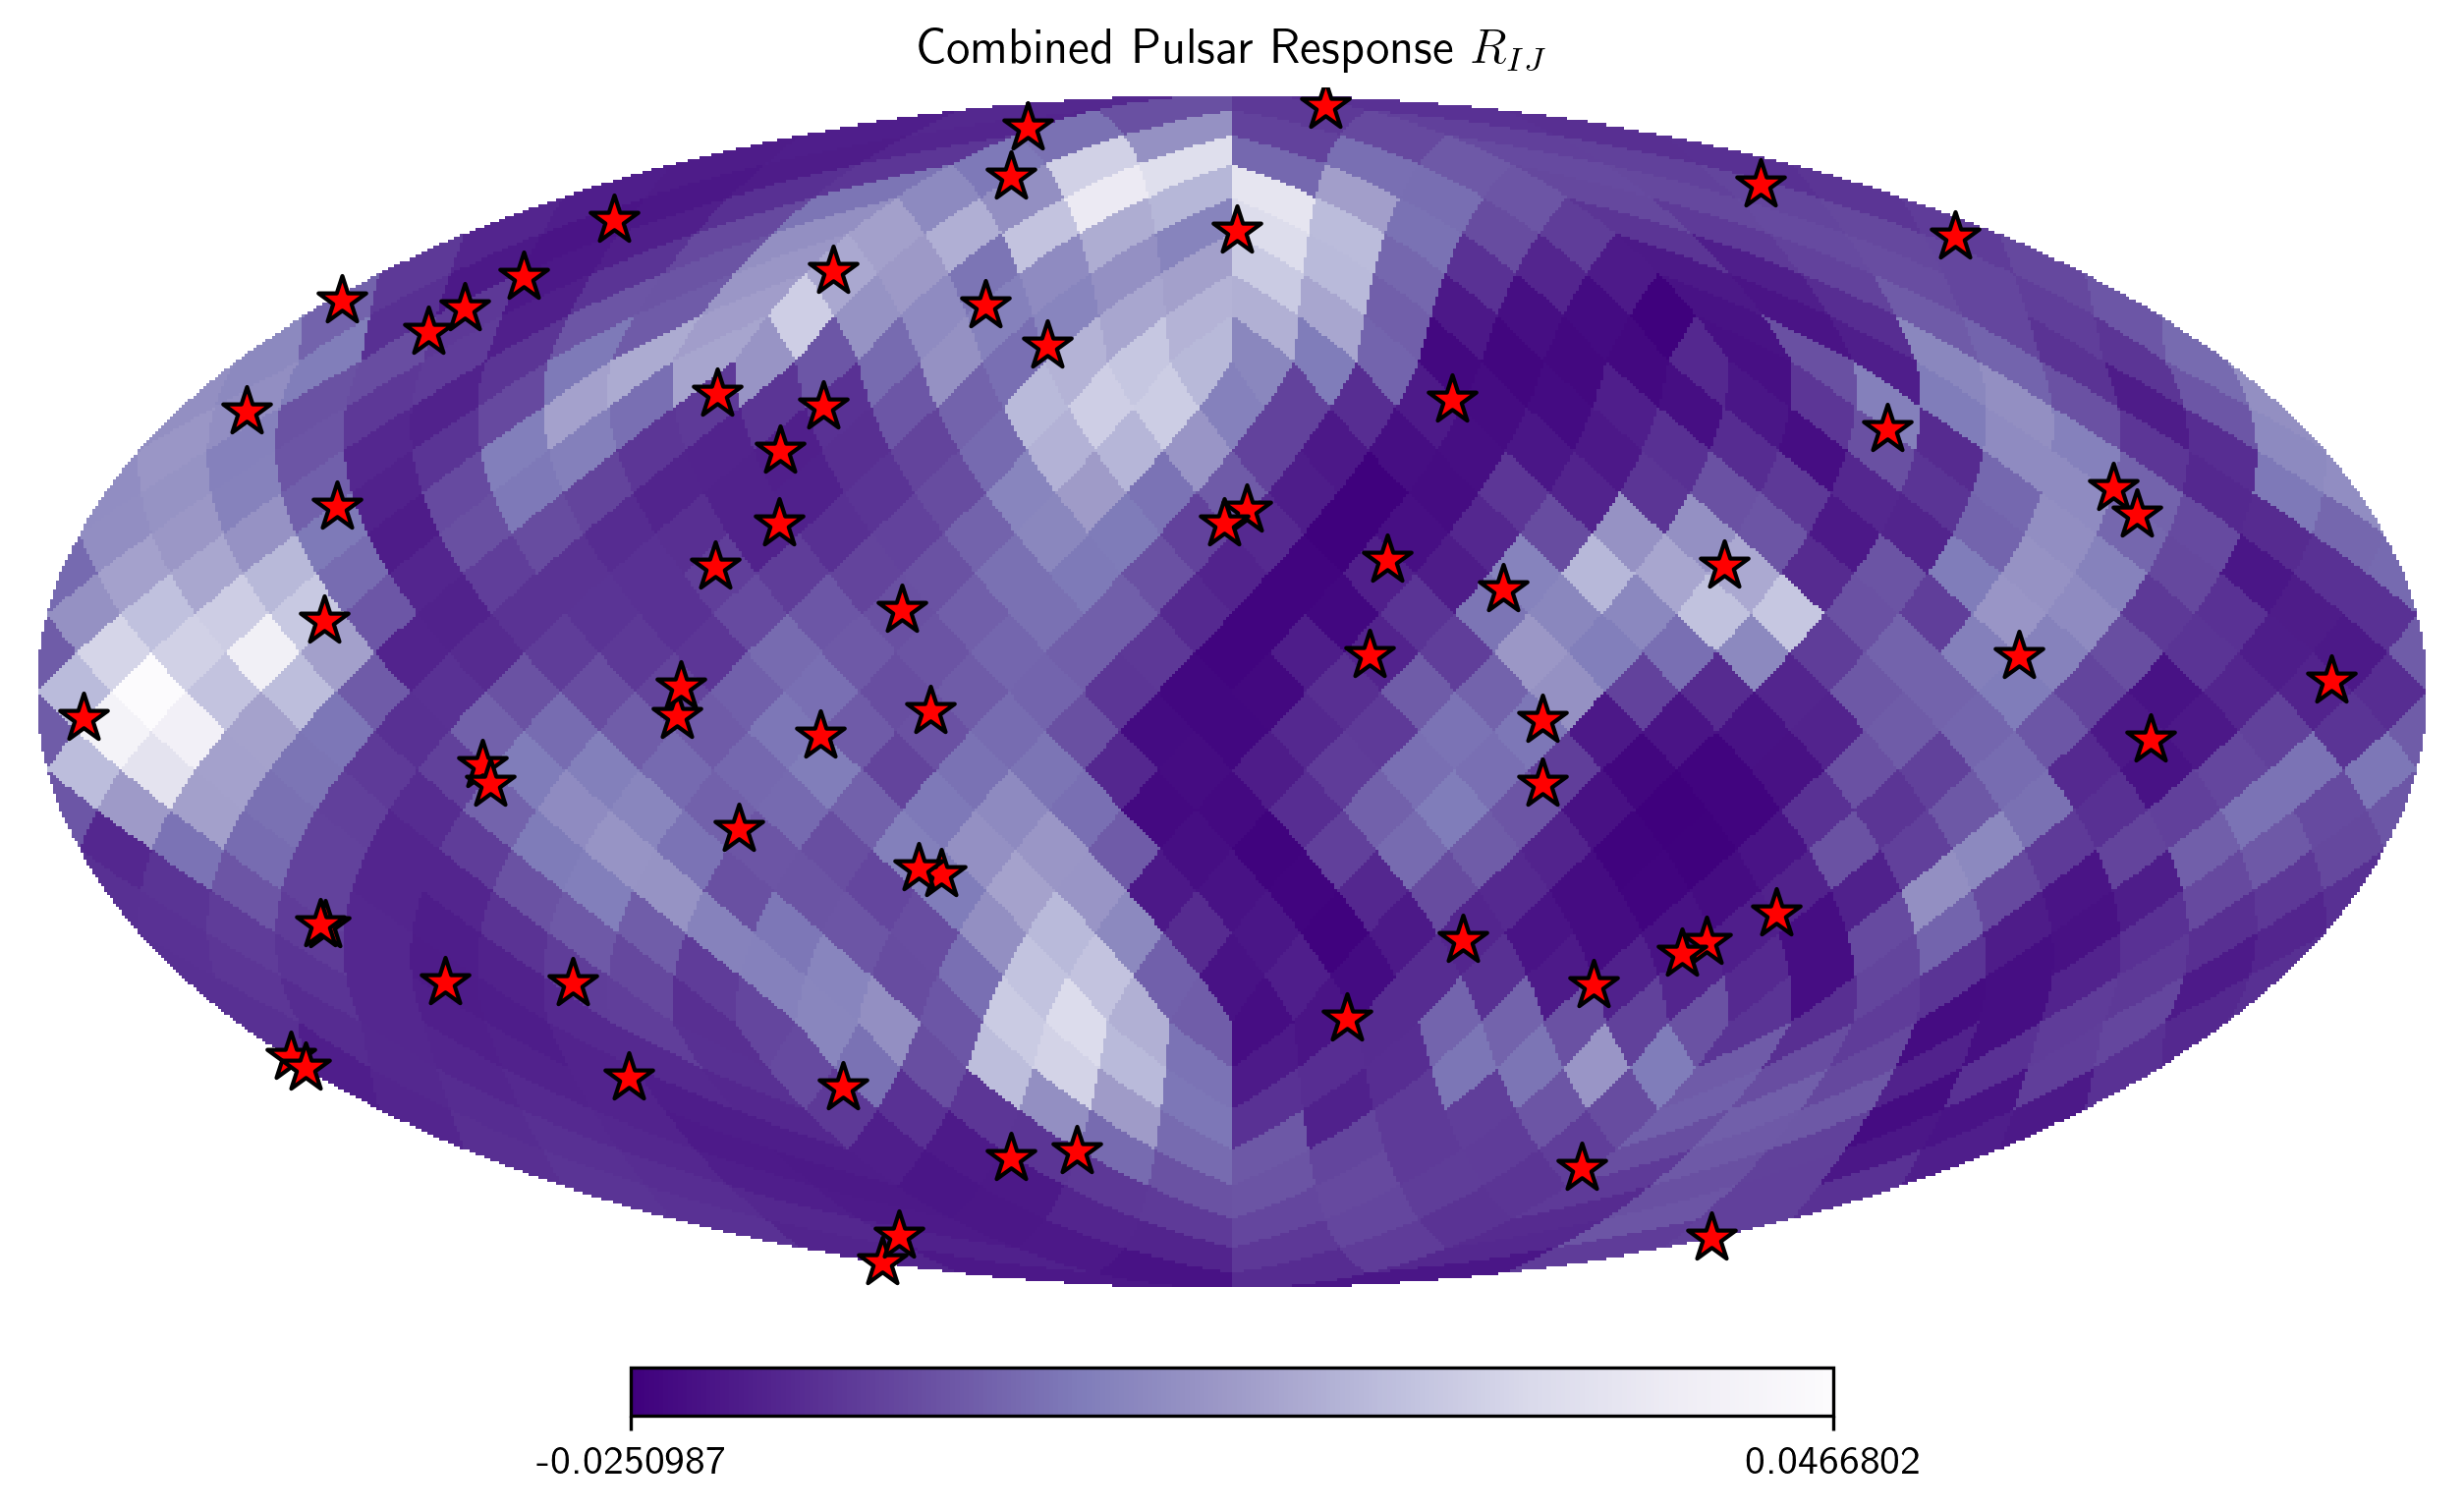

In [10]:
# Summing all pair responses
combined_response = ASM.R_IJ.sum(axis=0)

# Plot the combined response
hp.mollview(combined_response, title="Combined Pulsar Response $R_{IJ}$", cmap='Purples_r', rot=(180,0,0))

# Highlight all pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', s=150, rot=(180,0,0))
plt.savefig(savedir+'combined.png')
plt.show()


## Test of S_IJ and M_kk

Shapes
* R: NCC, k
* T: NCC
* S: NCC, f
* Mkk: k, f

In [11]:
max_value = np.max(ASM.h_c_aniso)
max_index = np.argmax(ASM.h_c_aniso)
max_freq = freqs[max_index]  # Corresponding frequency
print(f"Max value: {max_value}, Index: {max_index}, Frequency: {max_freq}")

min_value = np.min(ASM.h_c_aniso)
min_index = np.argmin(ASM.h_c_aniso)
min_freq = freqs[min_index]  # Corresponding frequency
print(f"Min value: {min_value}, Index: {min_index}, Frequency: {min_freq}")

median_value = np.median(ASM.h_c_aniso)
median_index = (np.abs(ASM.h_c_aniso - median_value)).argmin()
median_freq = freqs[median_index]  # Corresponding frequency
print(f"Median value: {median_value}, Index: {median_index}, Frequency: {median_freq}")

Max value: 2.6651358543948726e-14, Index: 351, Frequency: 3.180510975699499e-08
Min value: 4.113408354069402e-18, Index: 145, Frequency: 2.460510119166596e-09
Median value: 2.4921999414361106e-17, Index: 10, Frequency: 4.598683059713328e-10


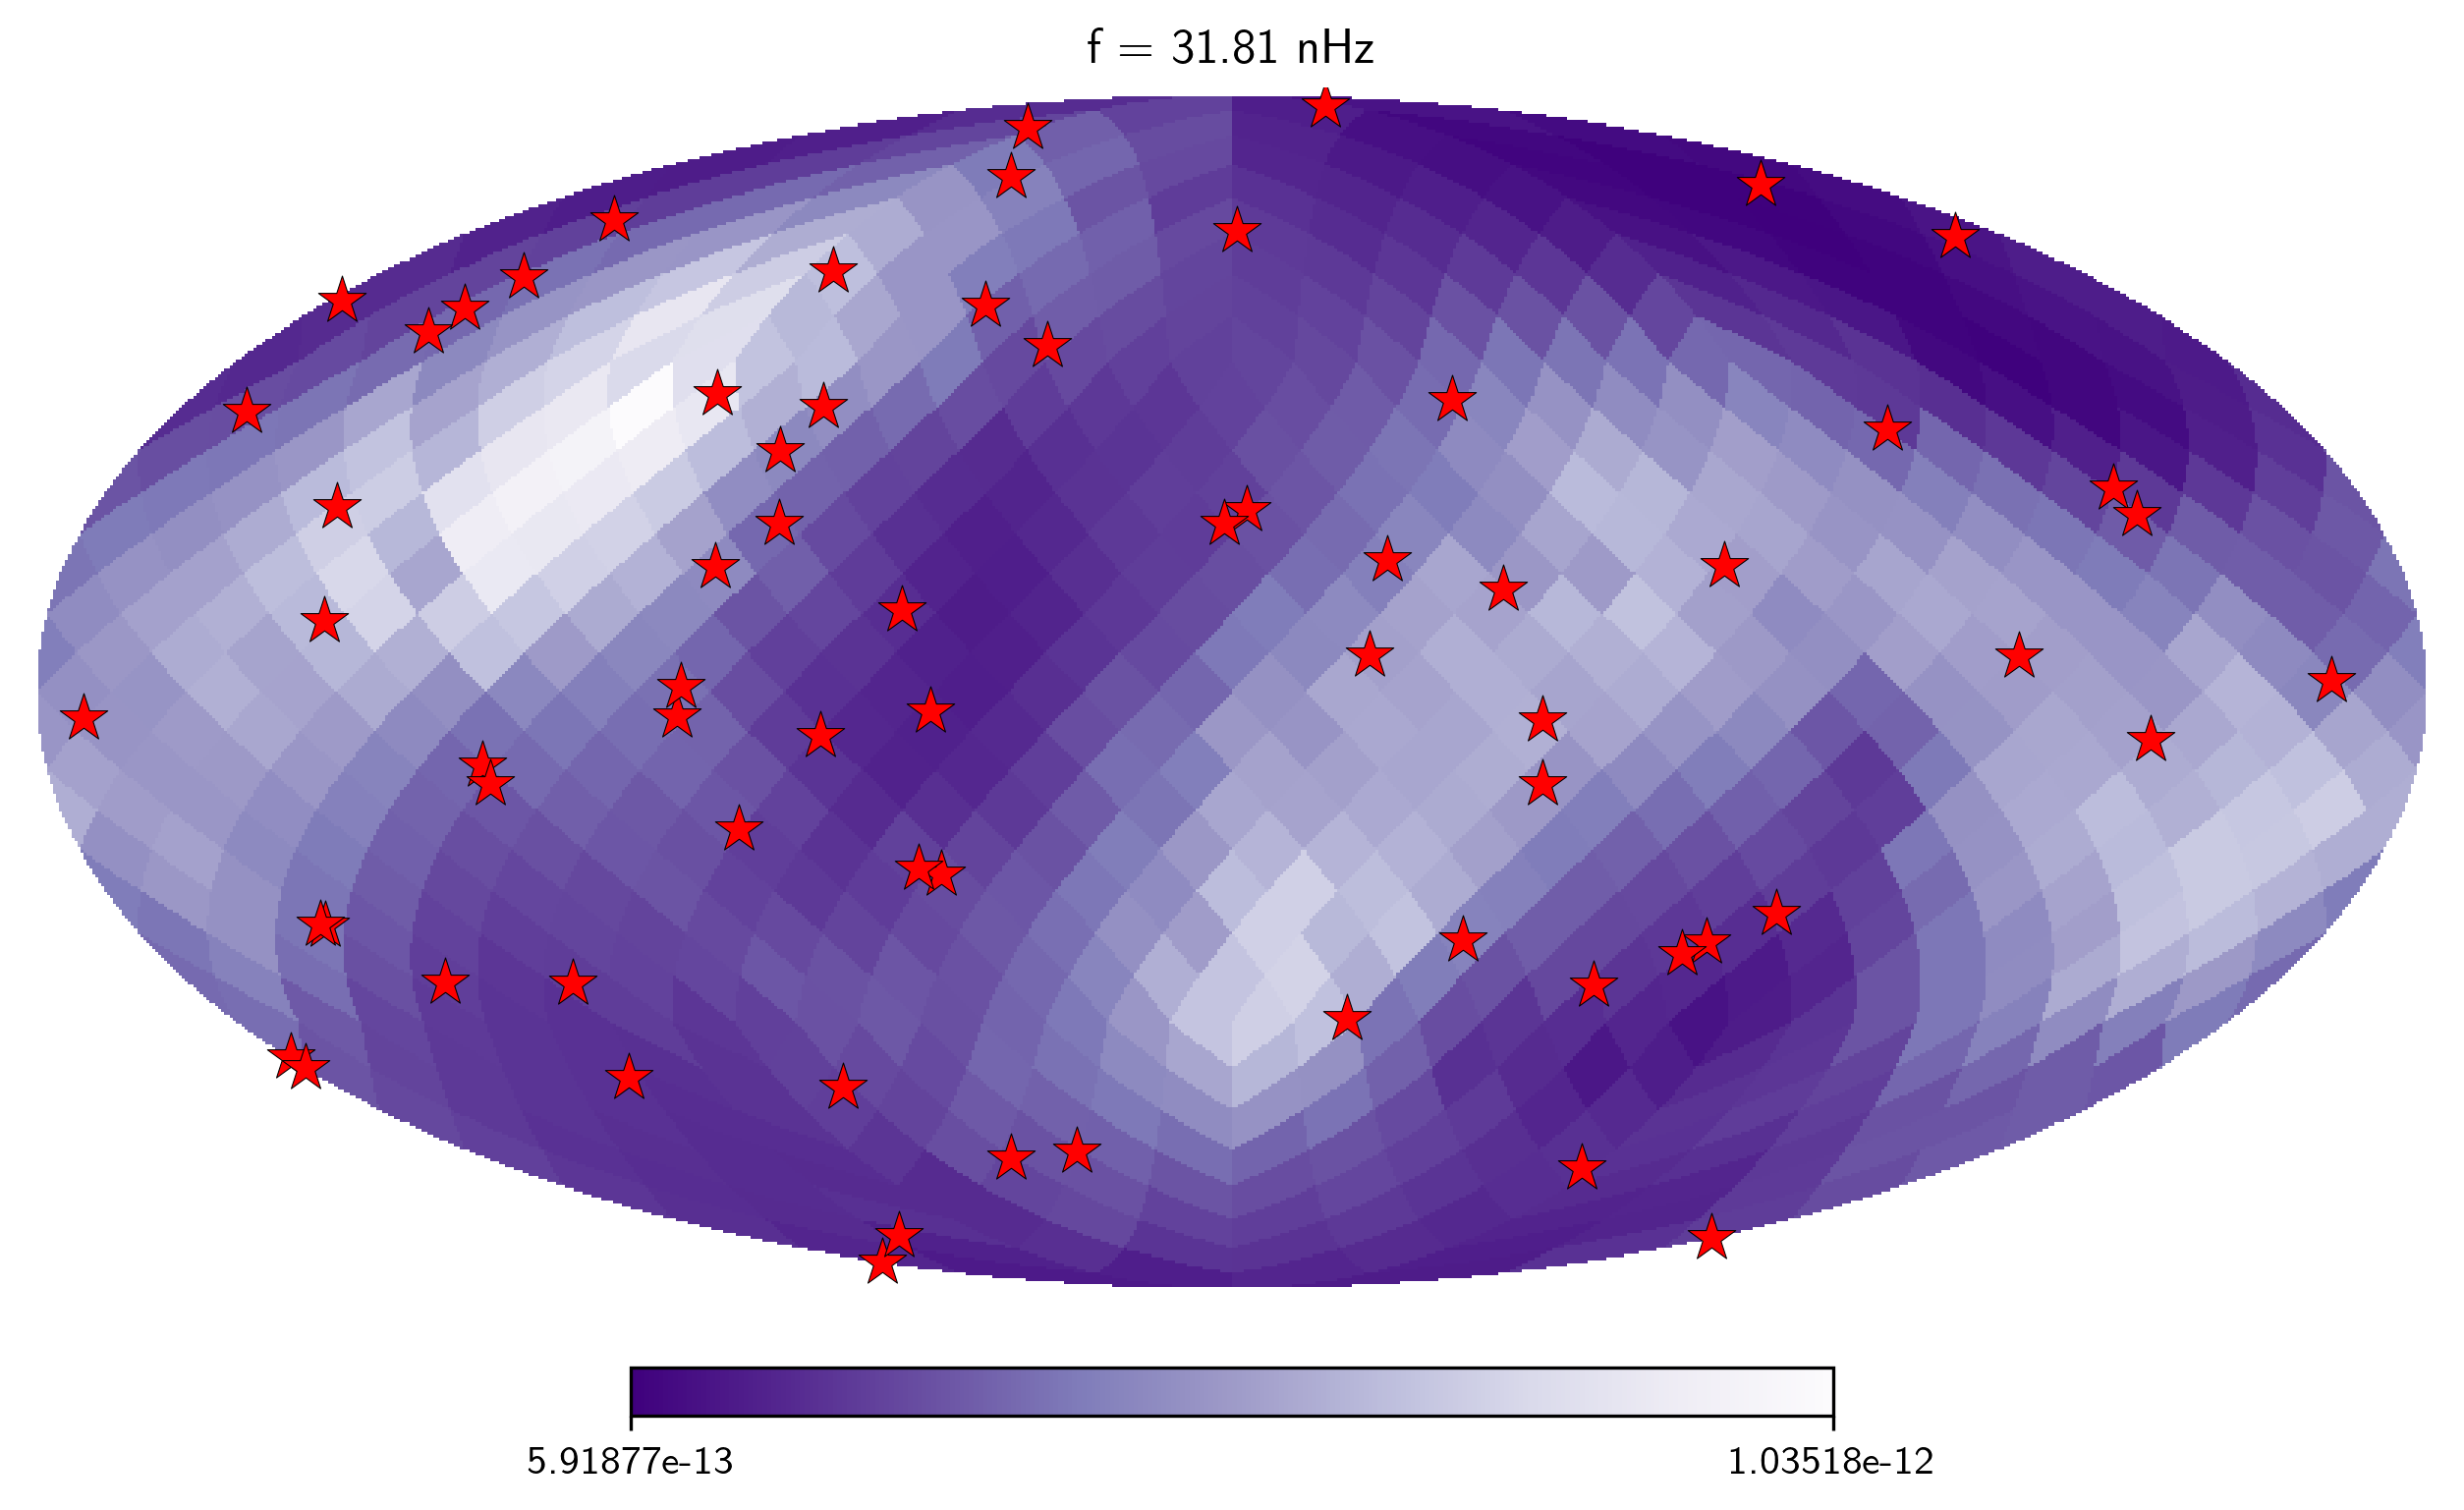

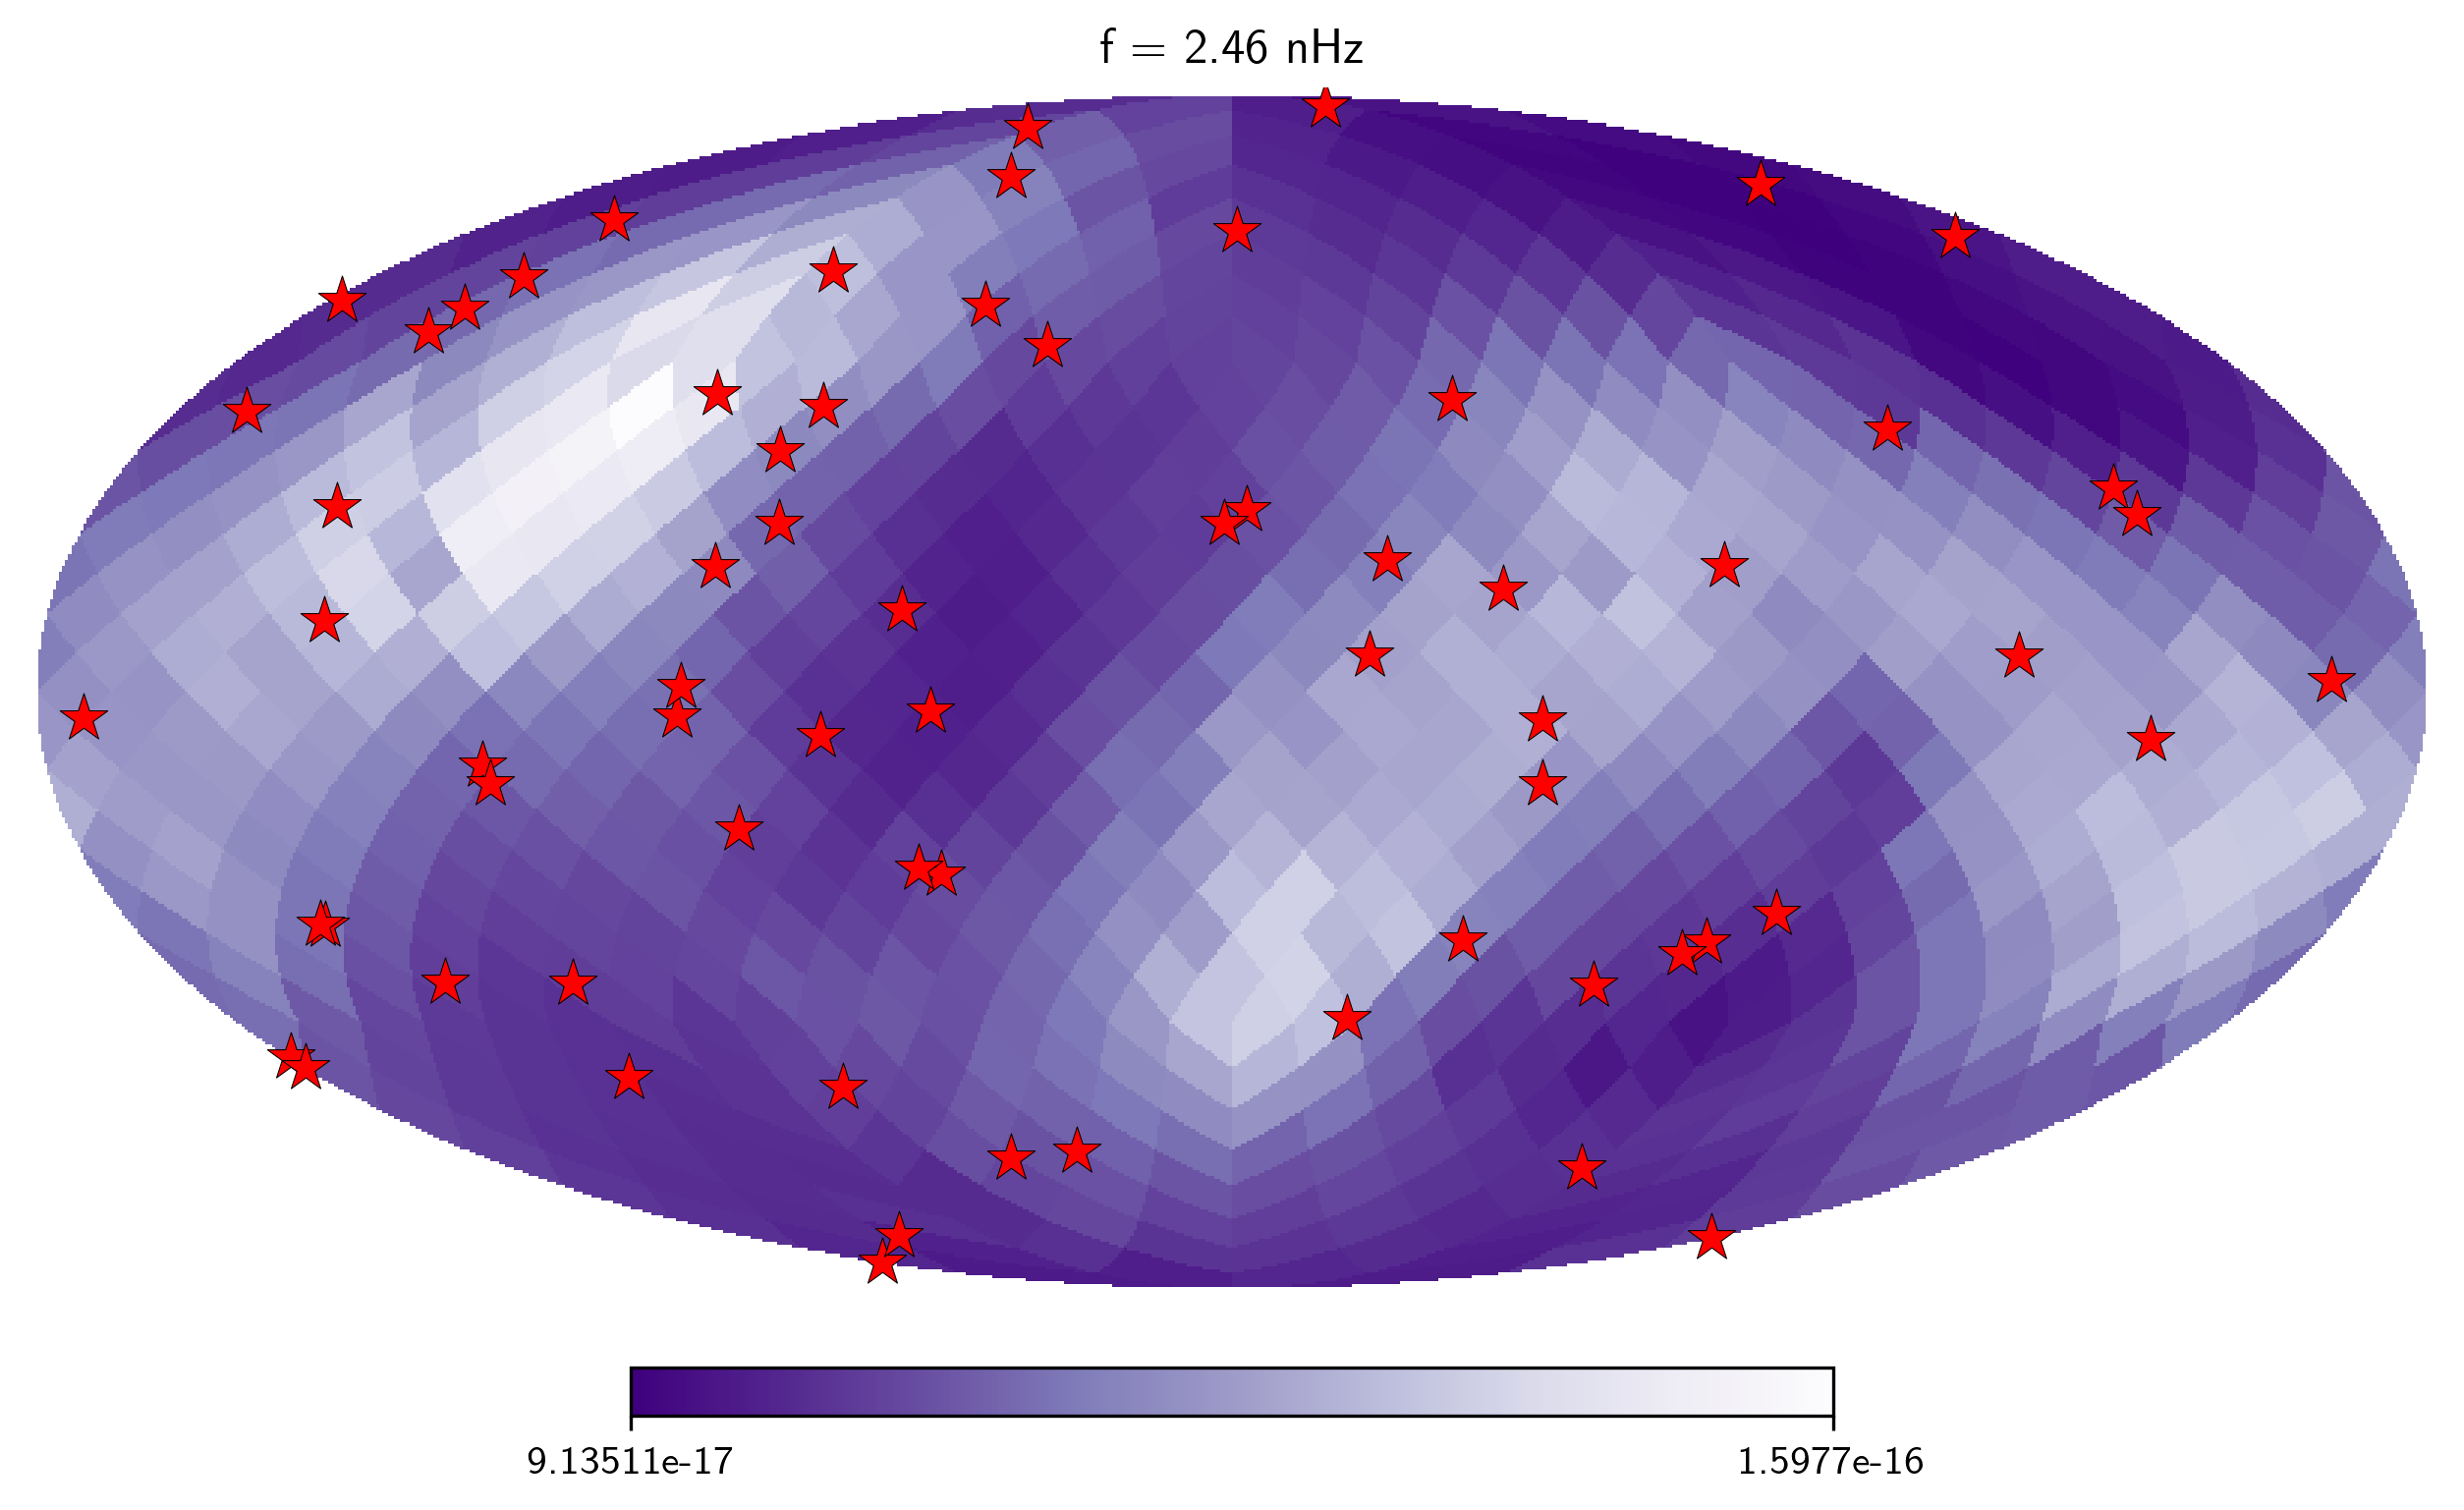

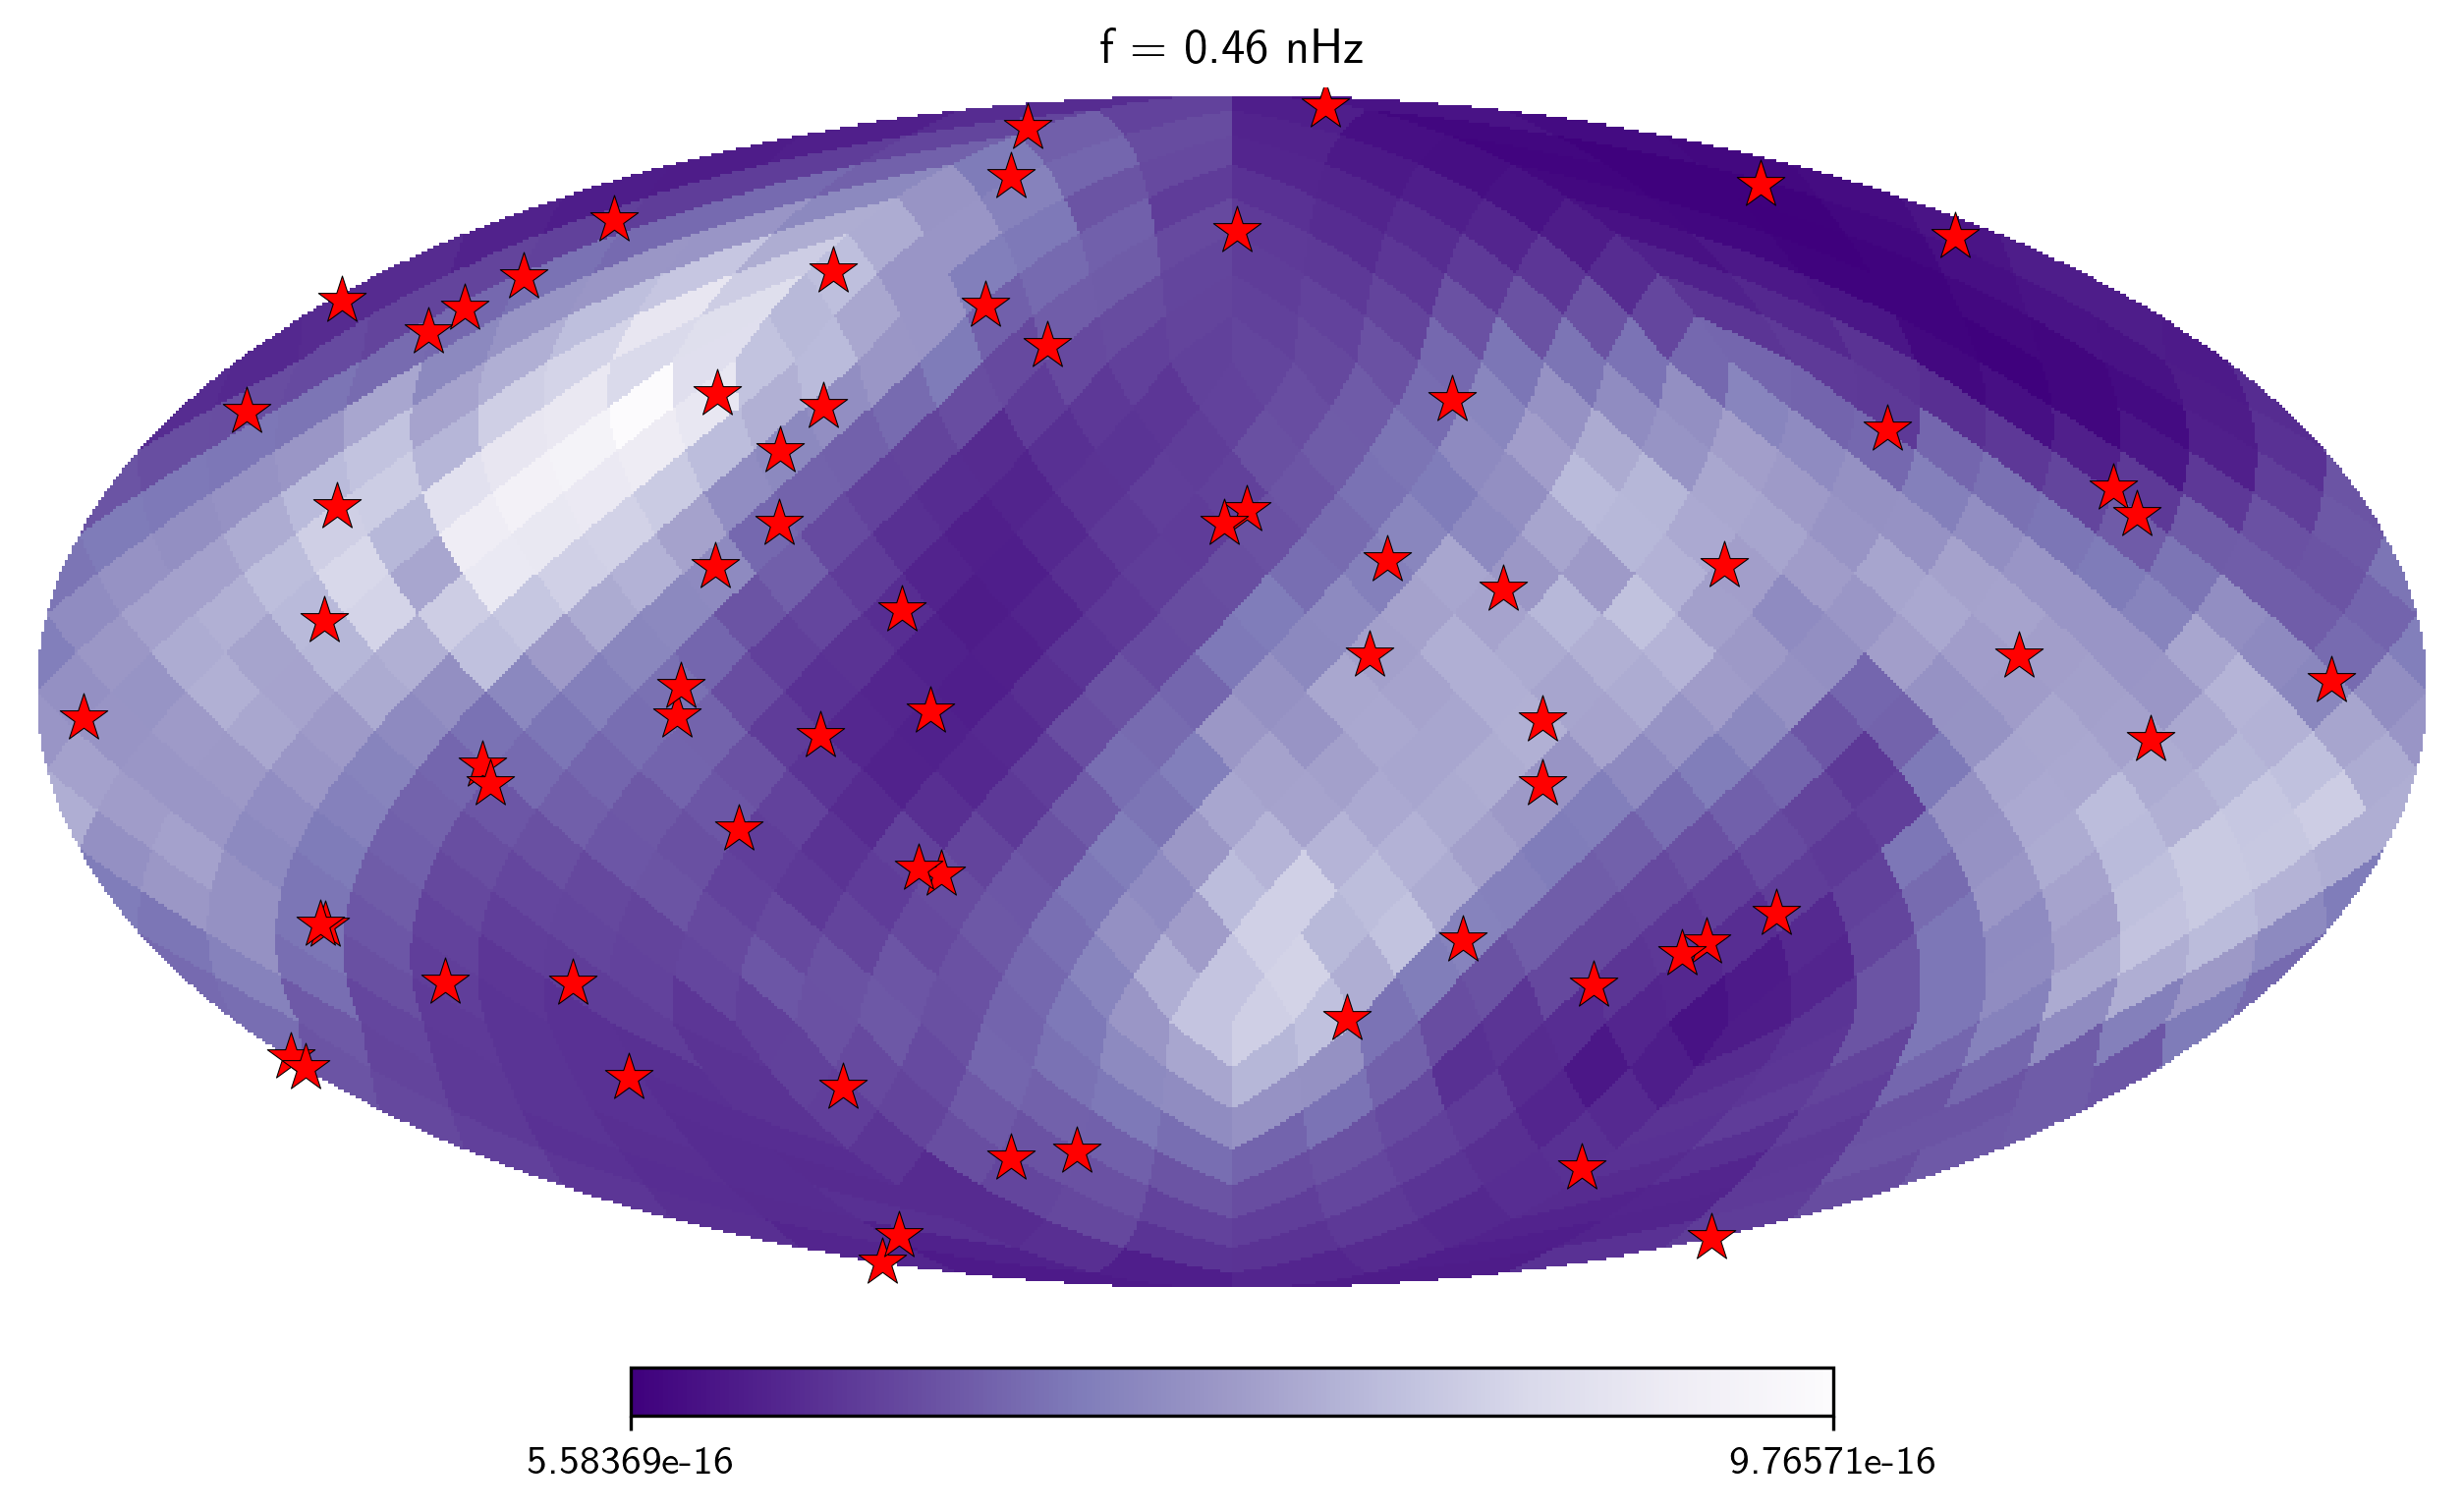

In [12]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    h_c_pixel = ASM.h_c_aniso_pixel(idx)
    
    # Plot the map
    hp.mollview(h_c_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


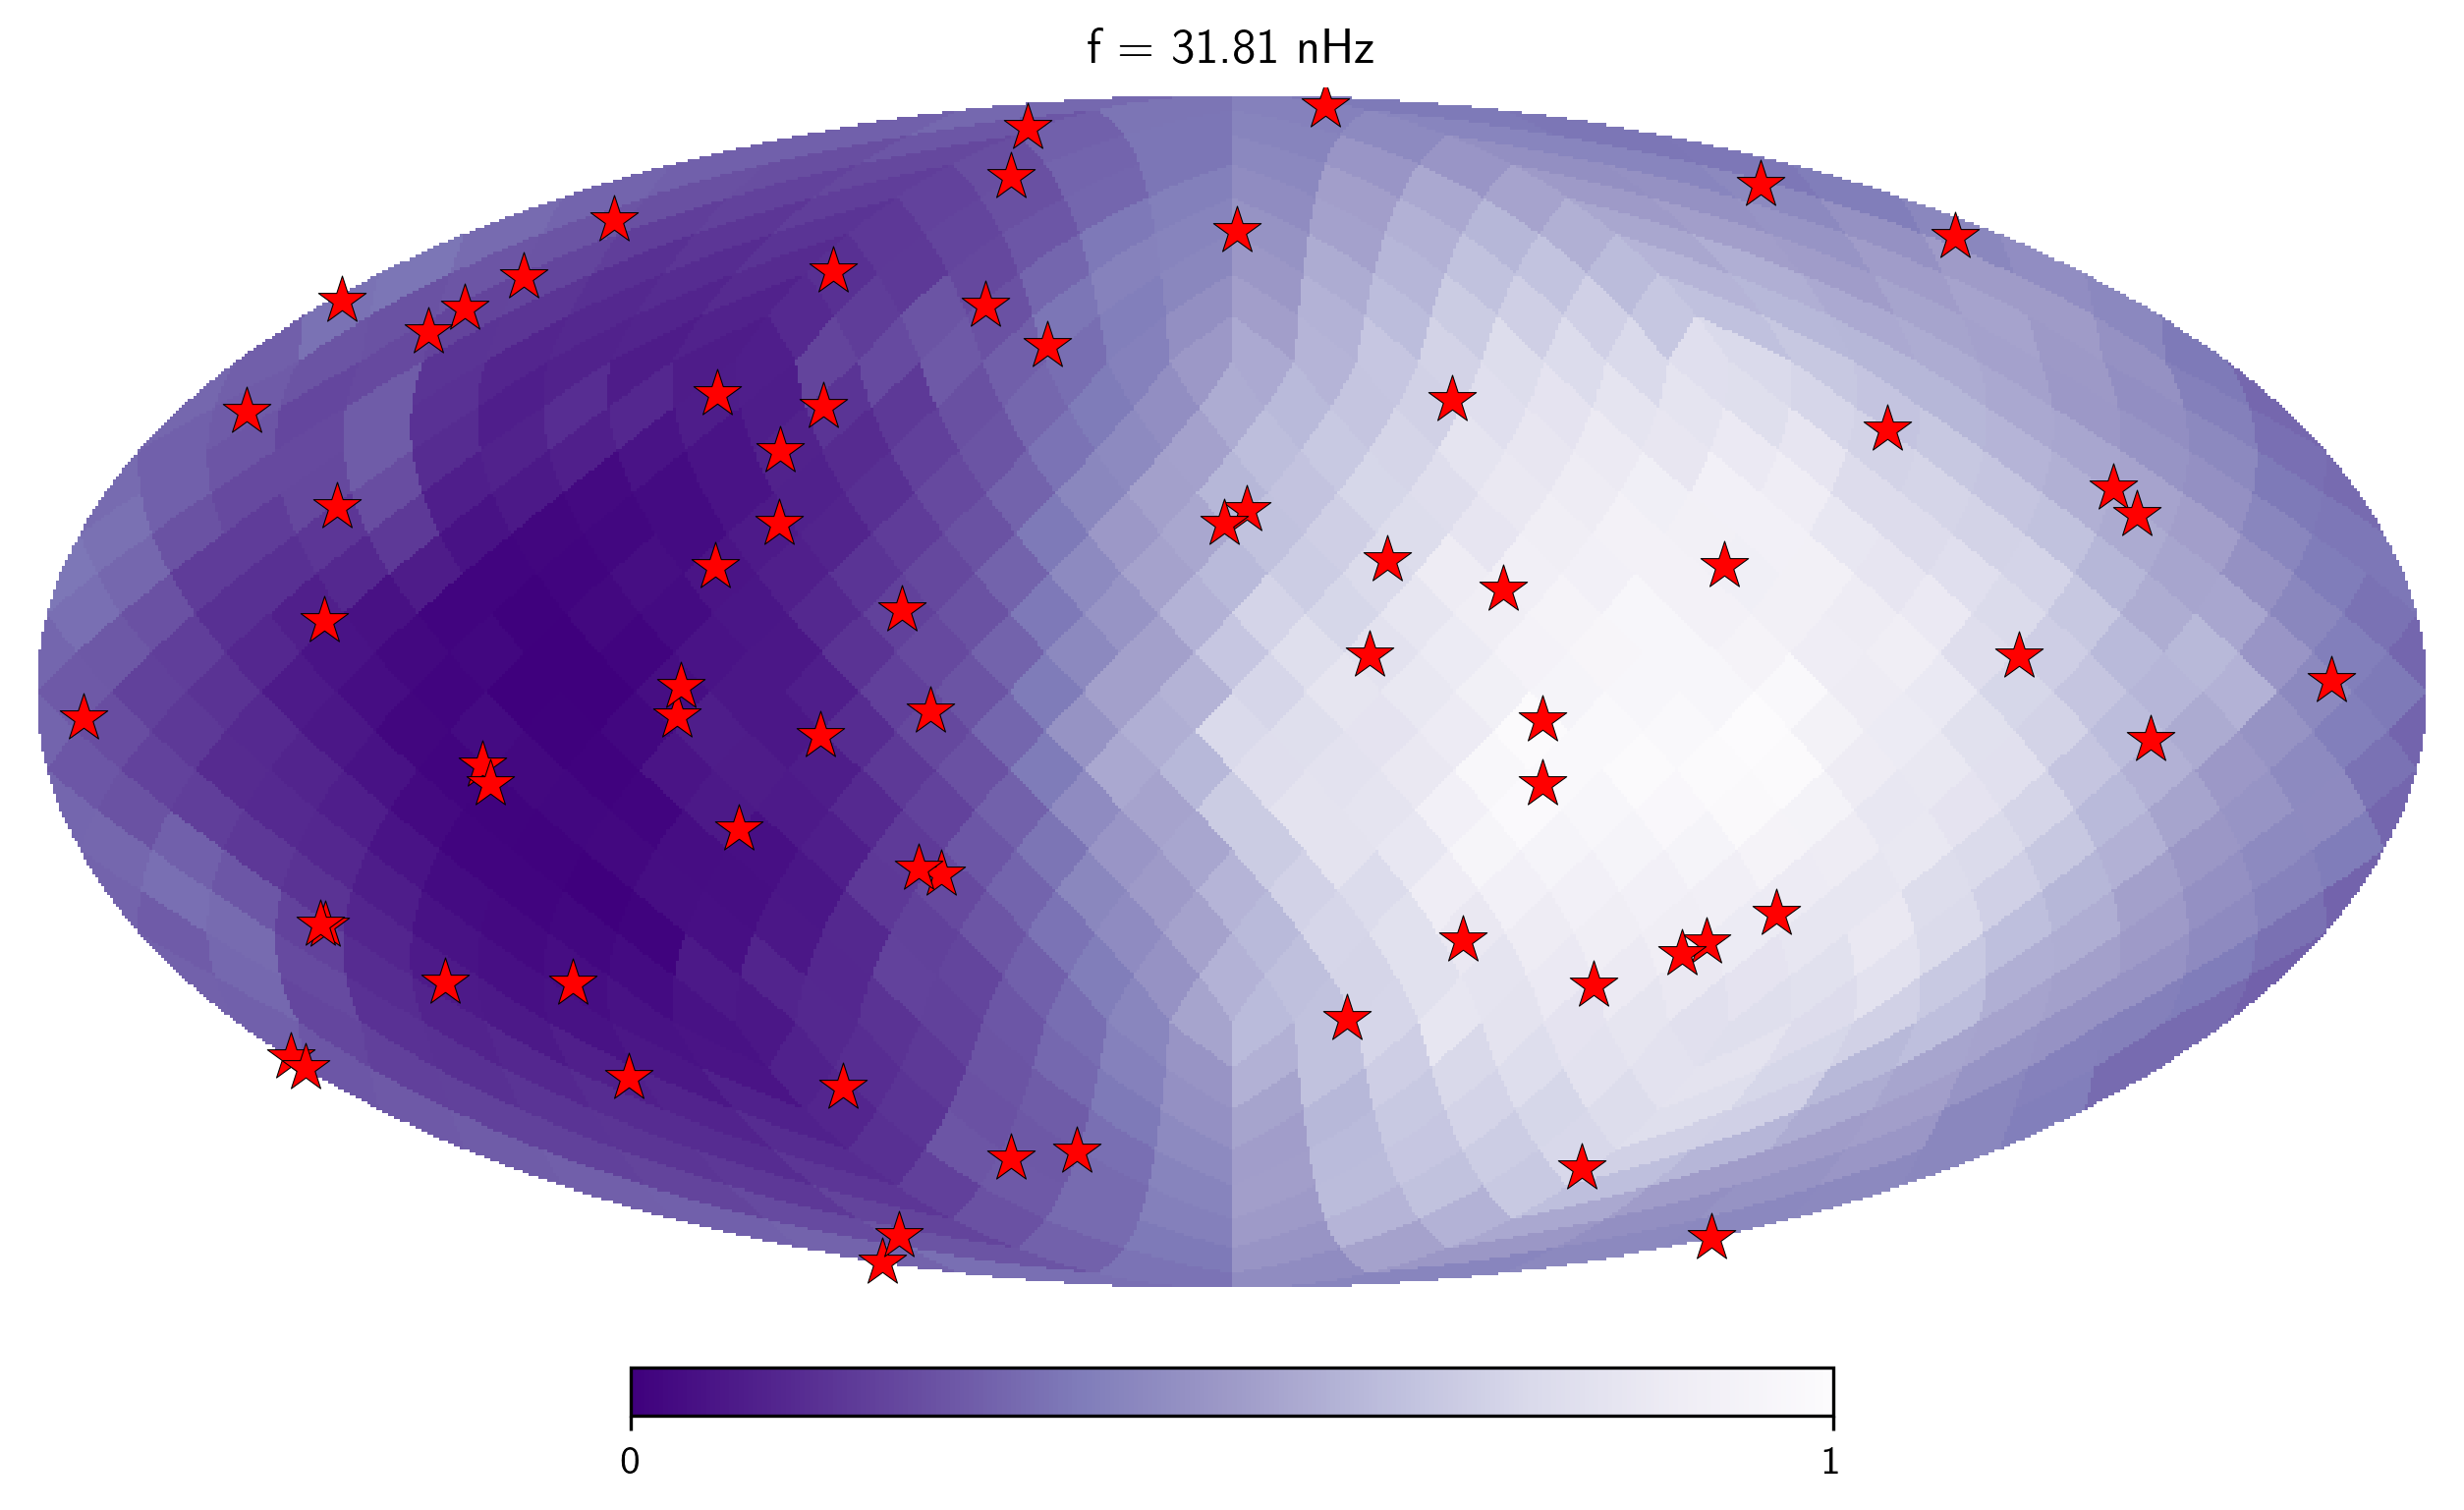

In [13]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, max_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {max_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



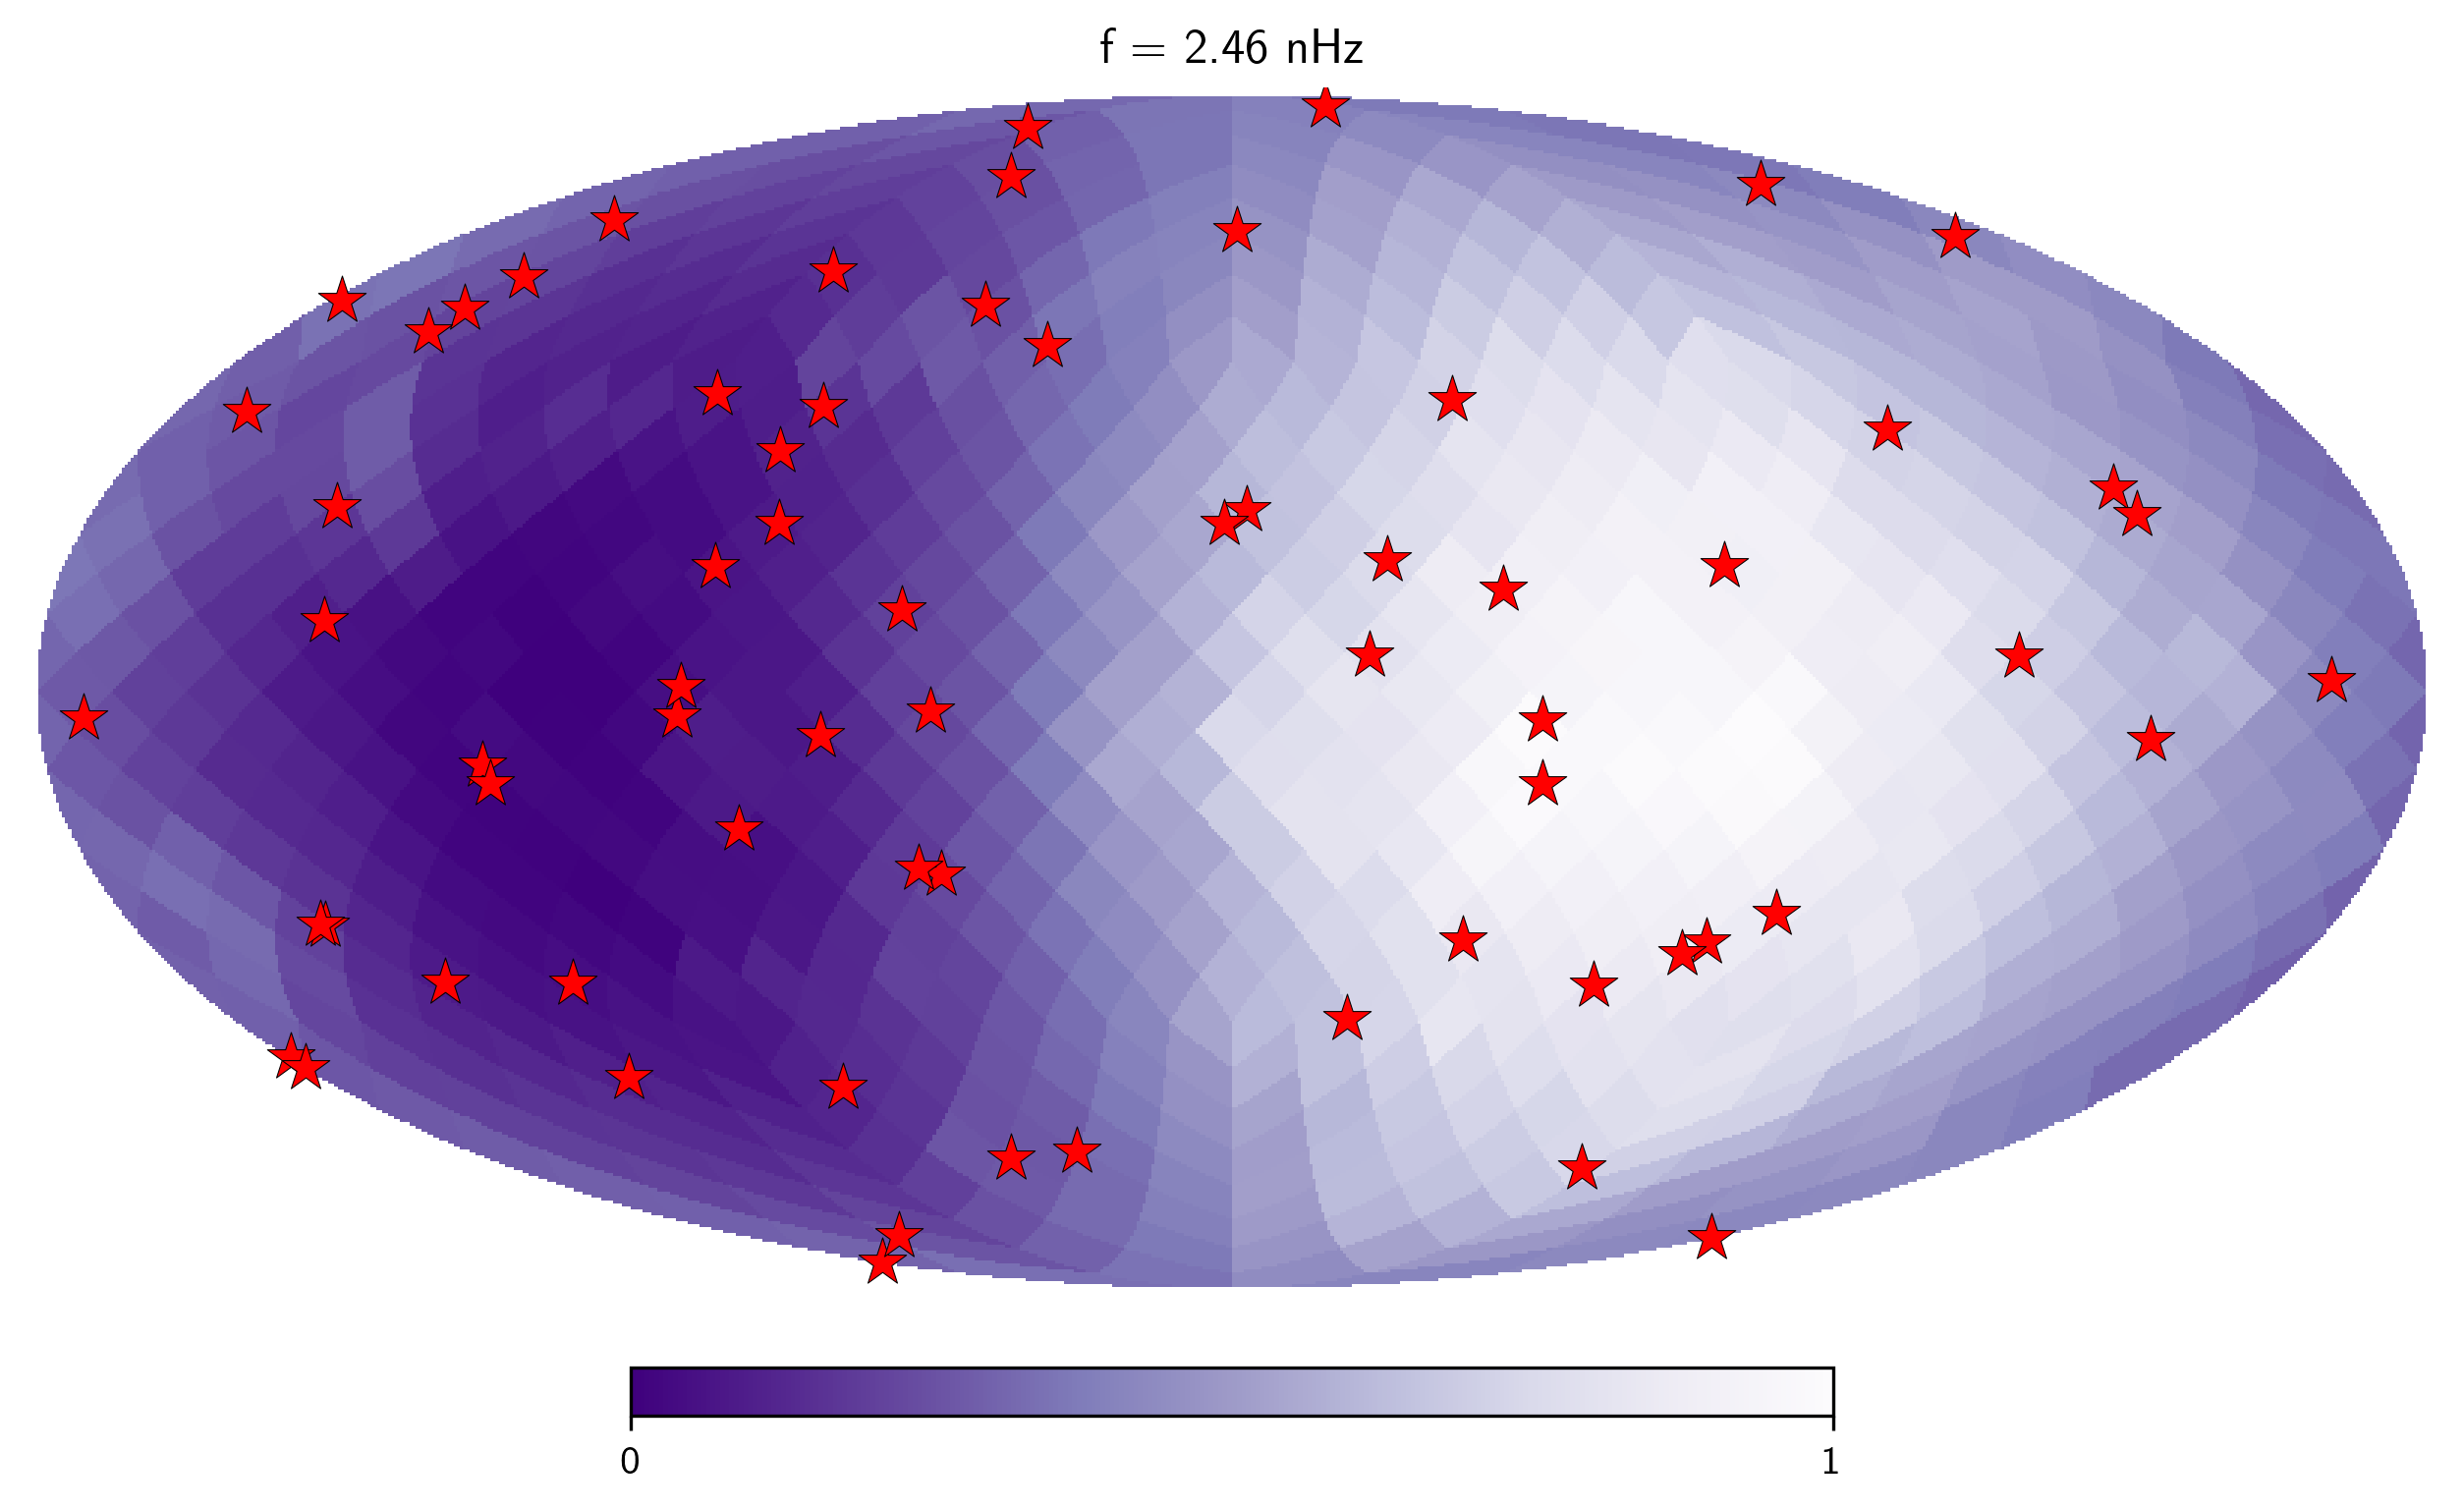

In [14]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, min_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {min_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



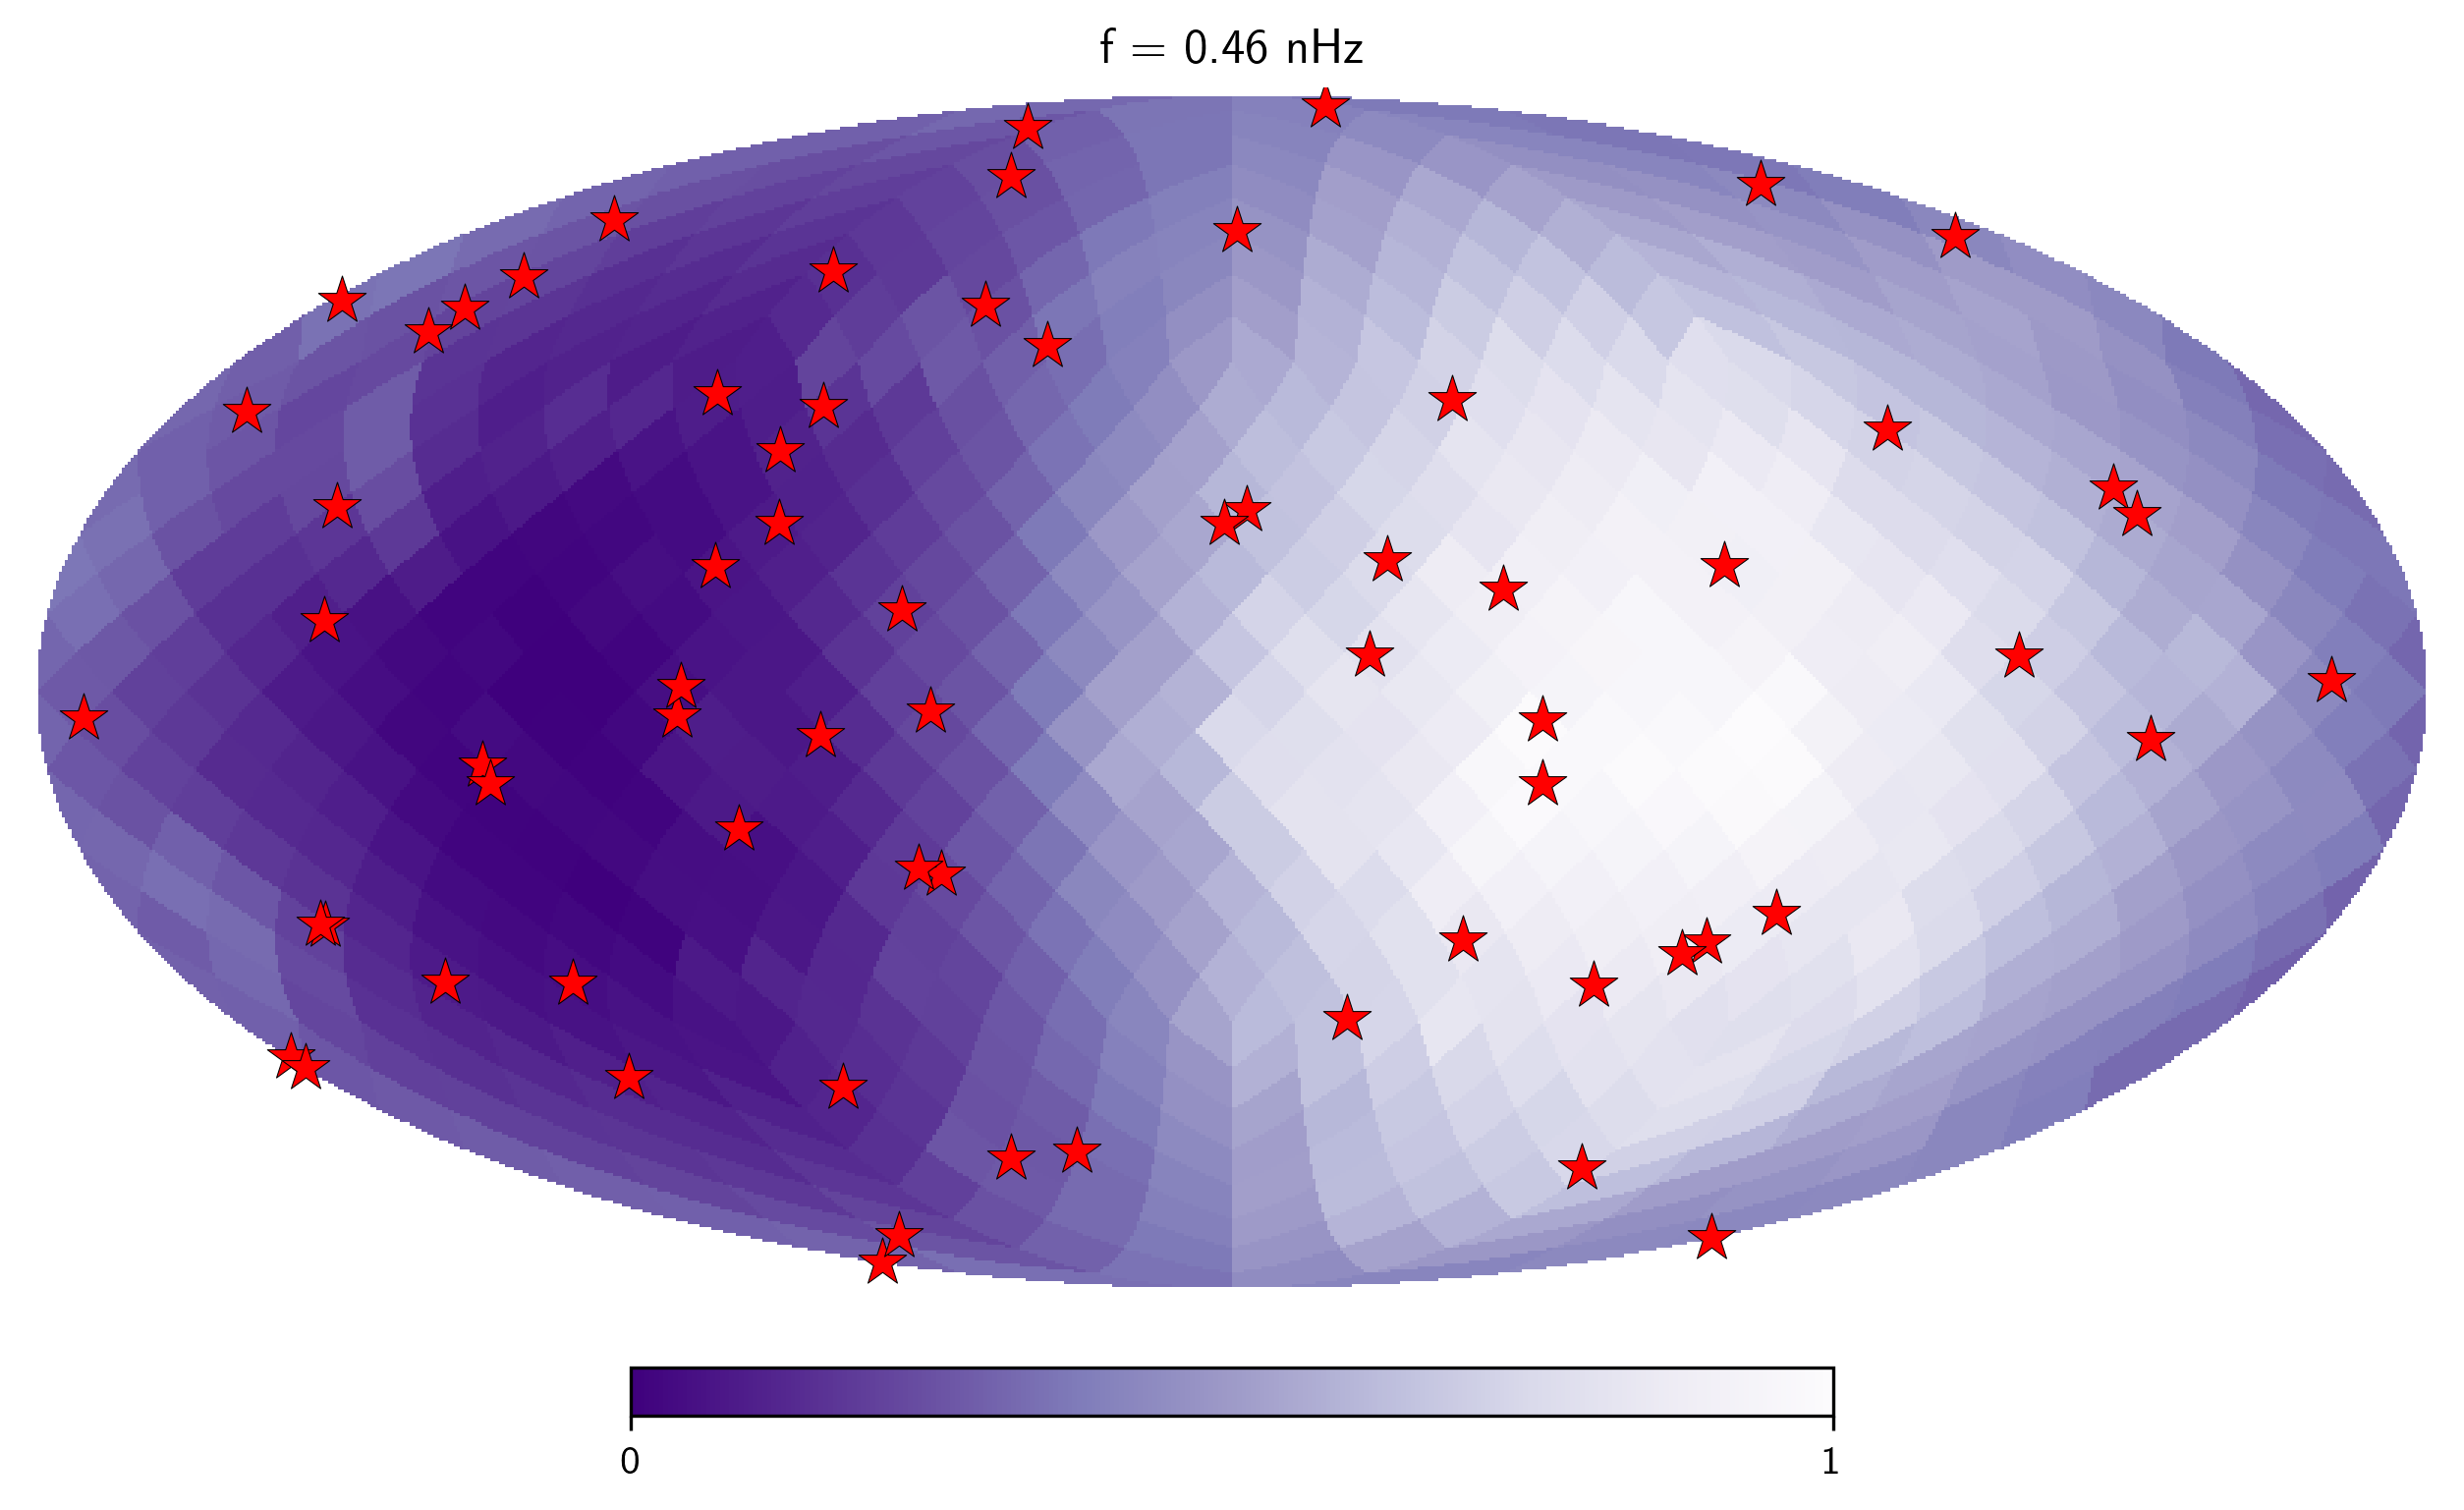

In [15]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, median_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {median_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



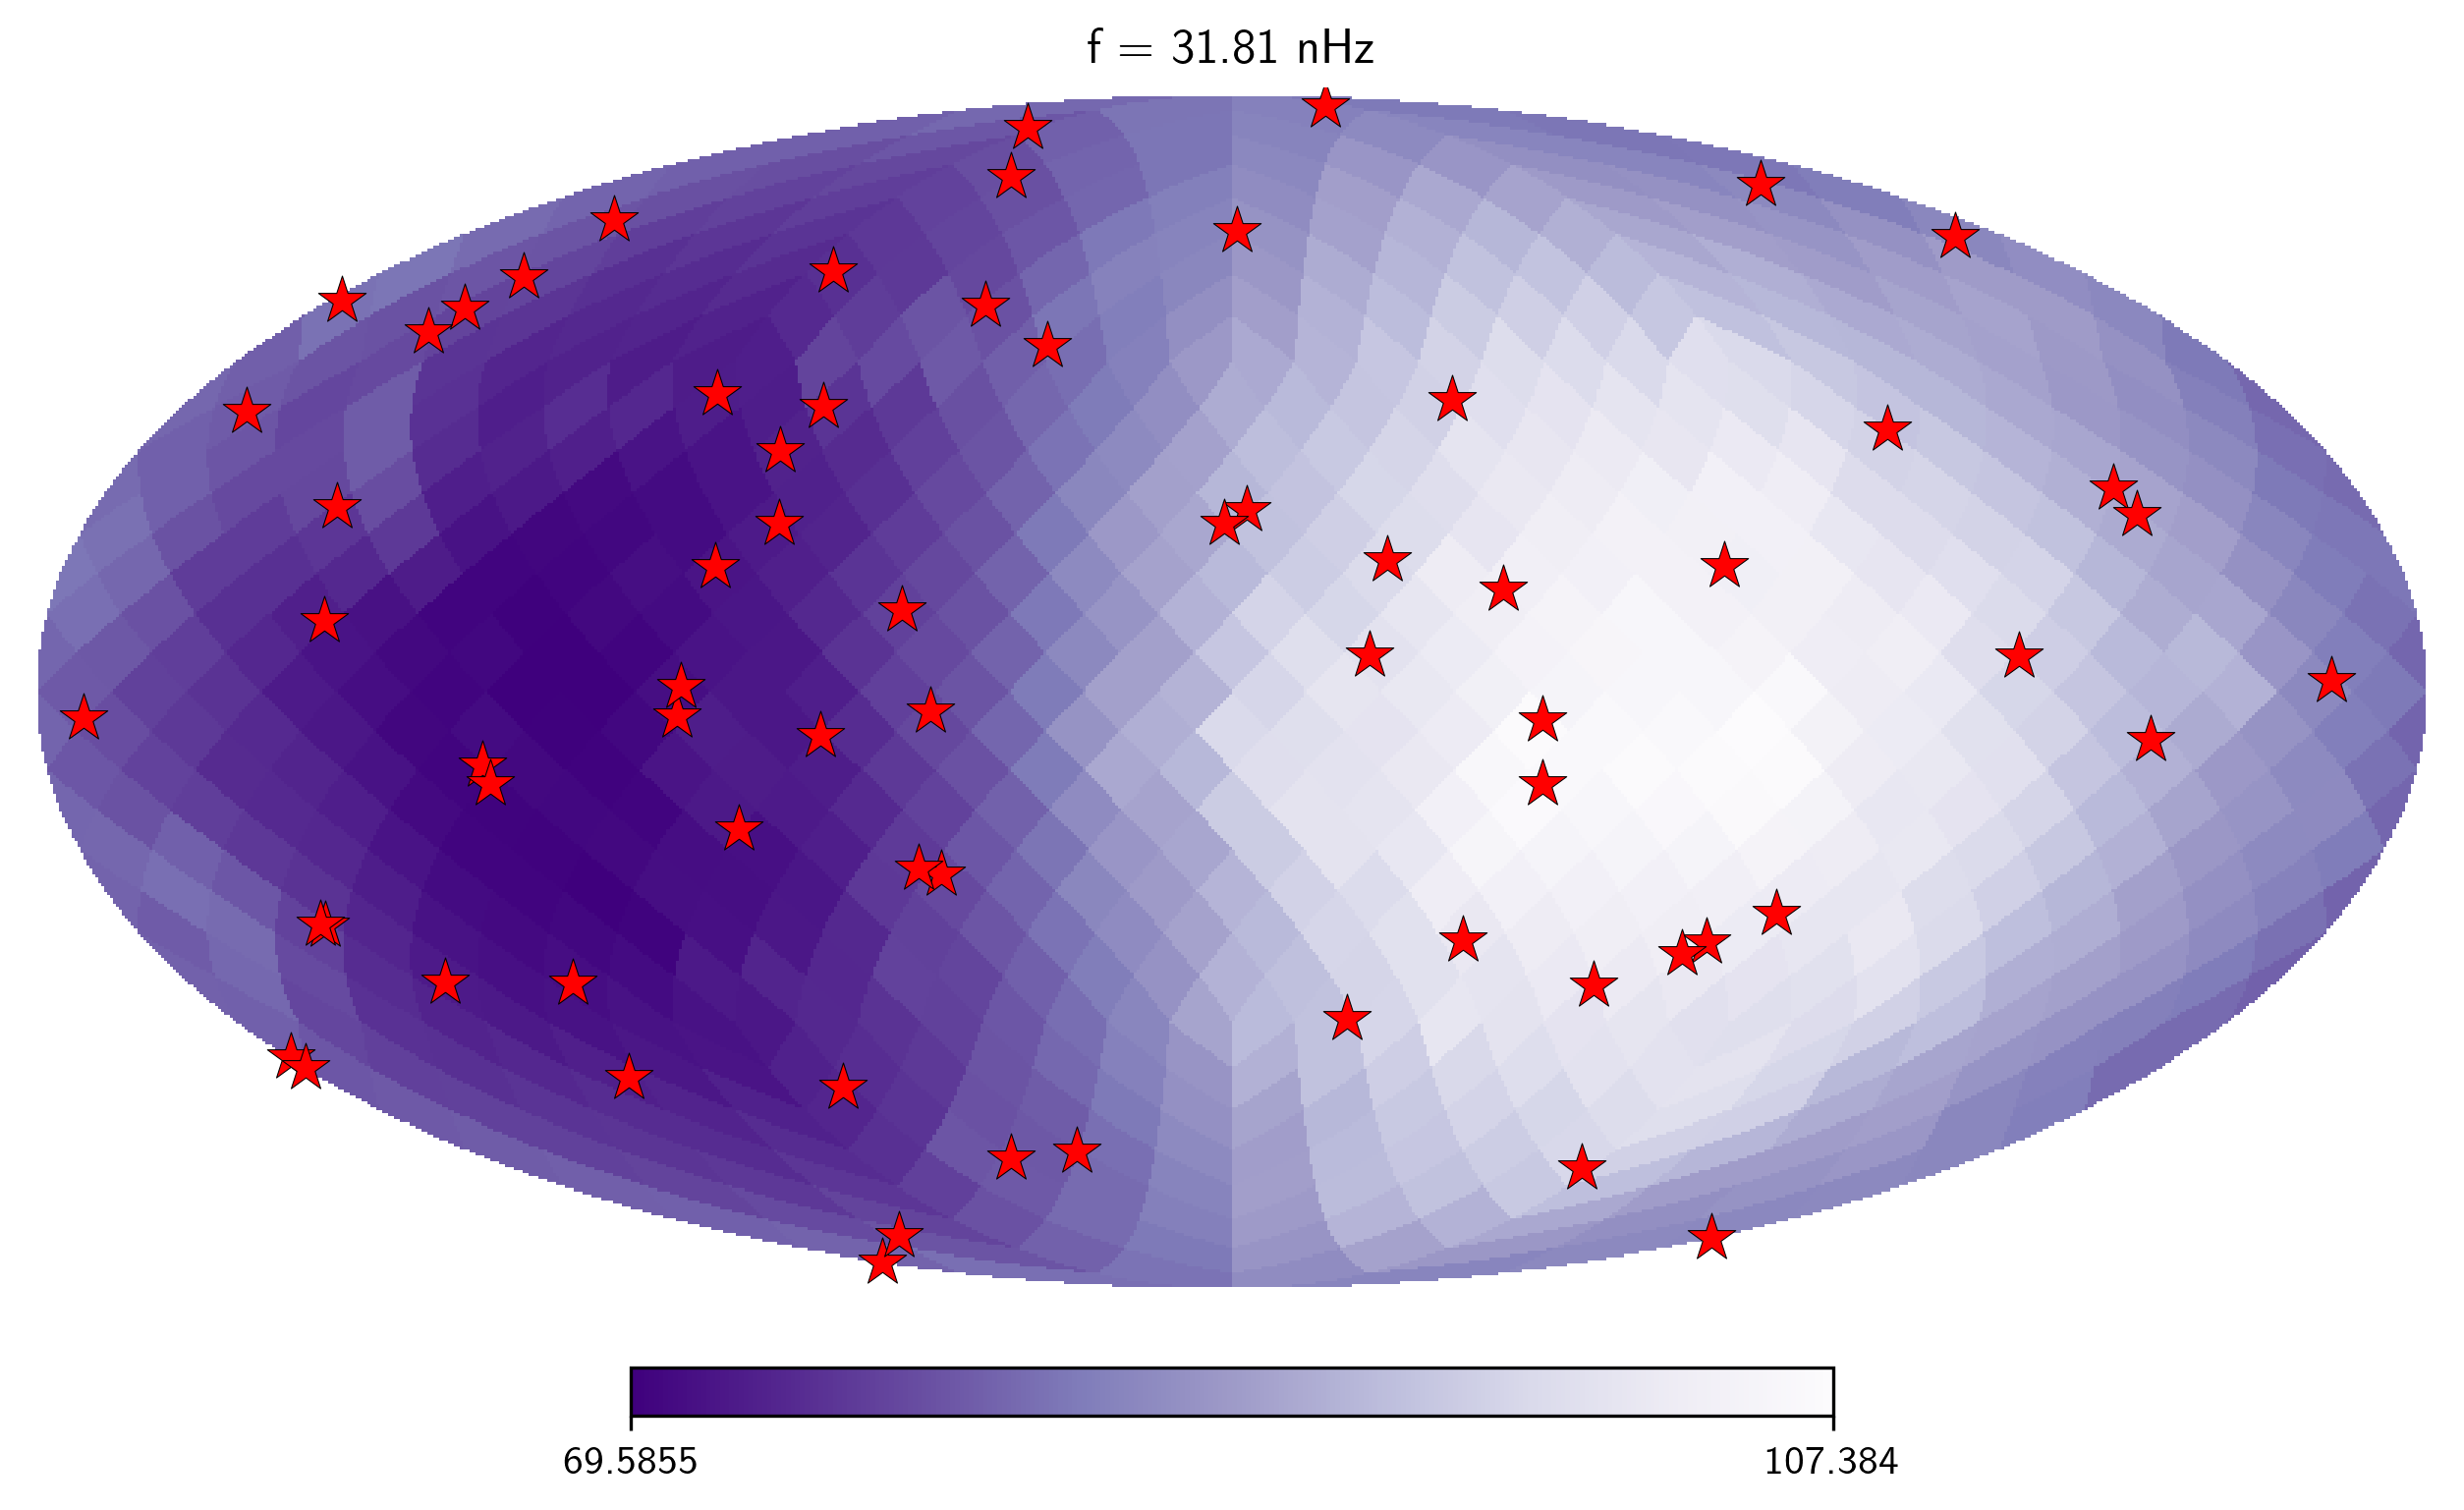

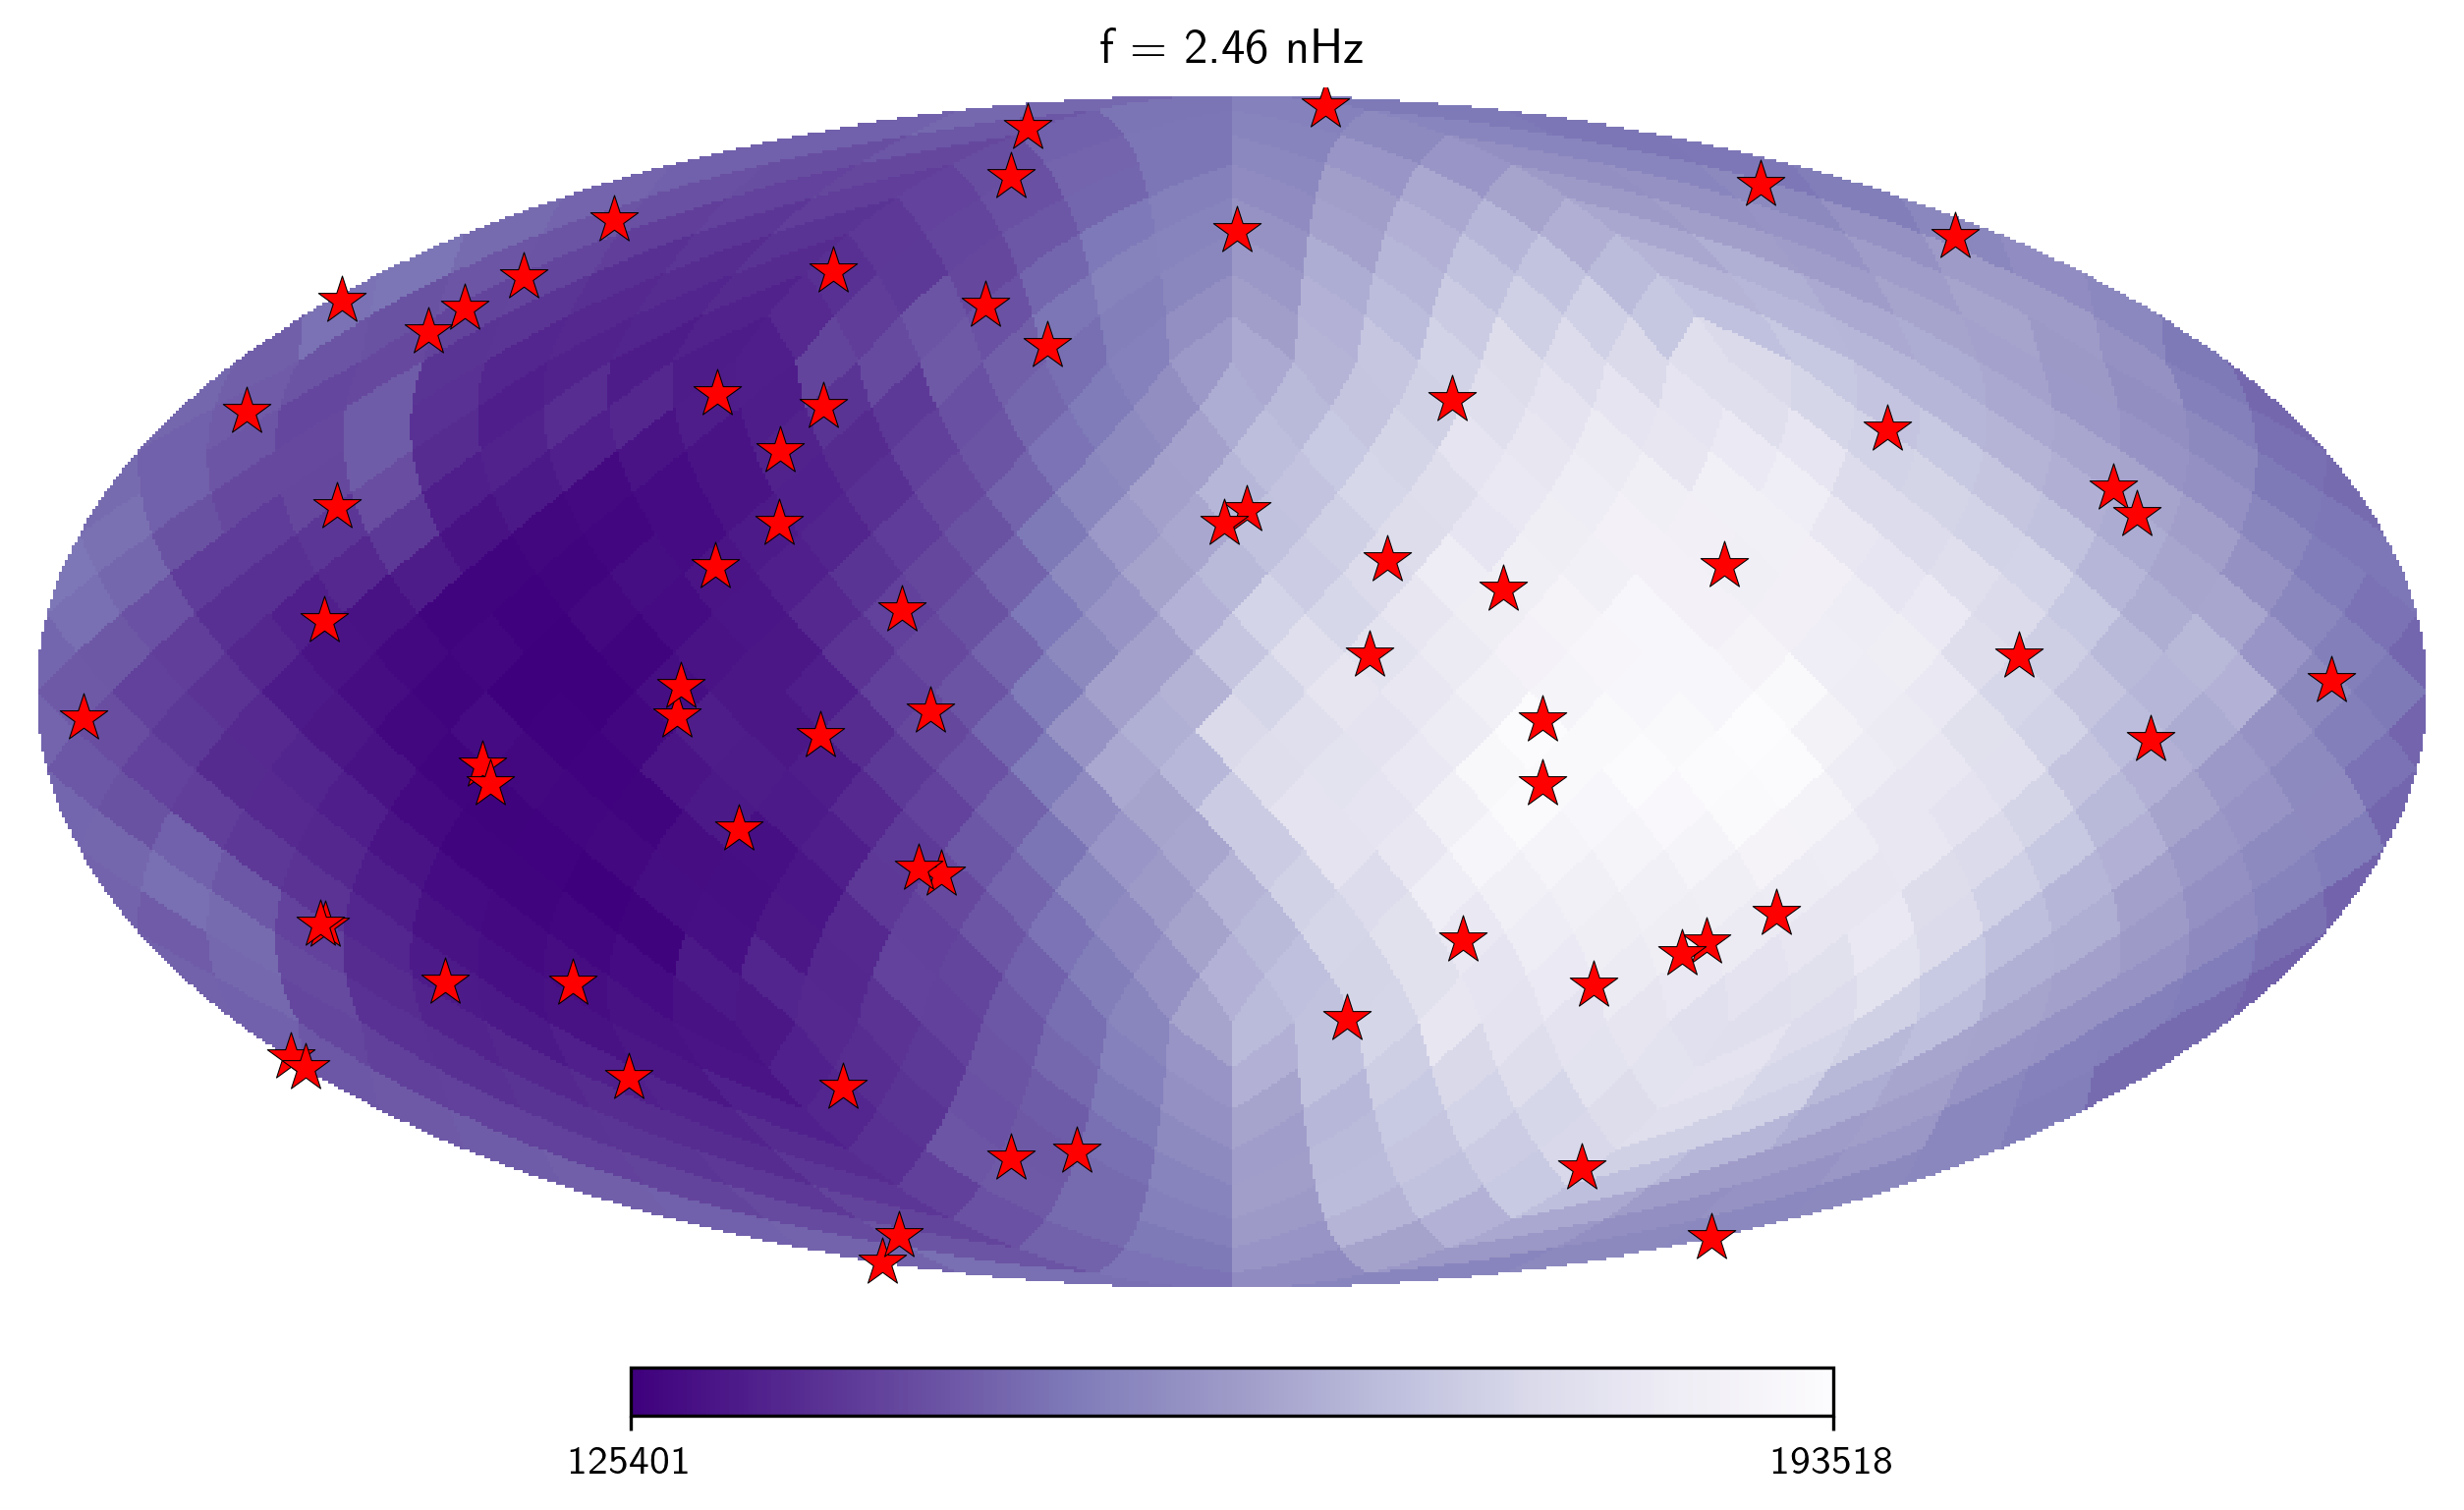

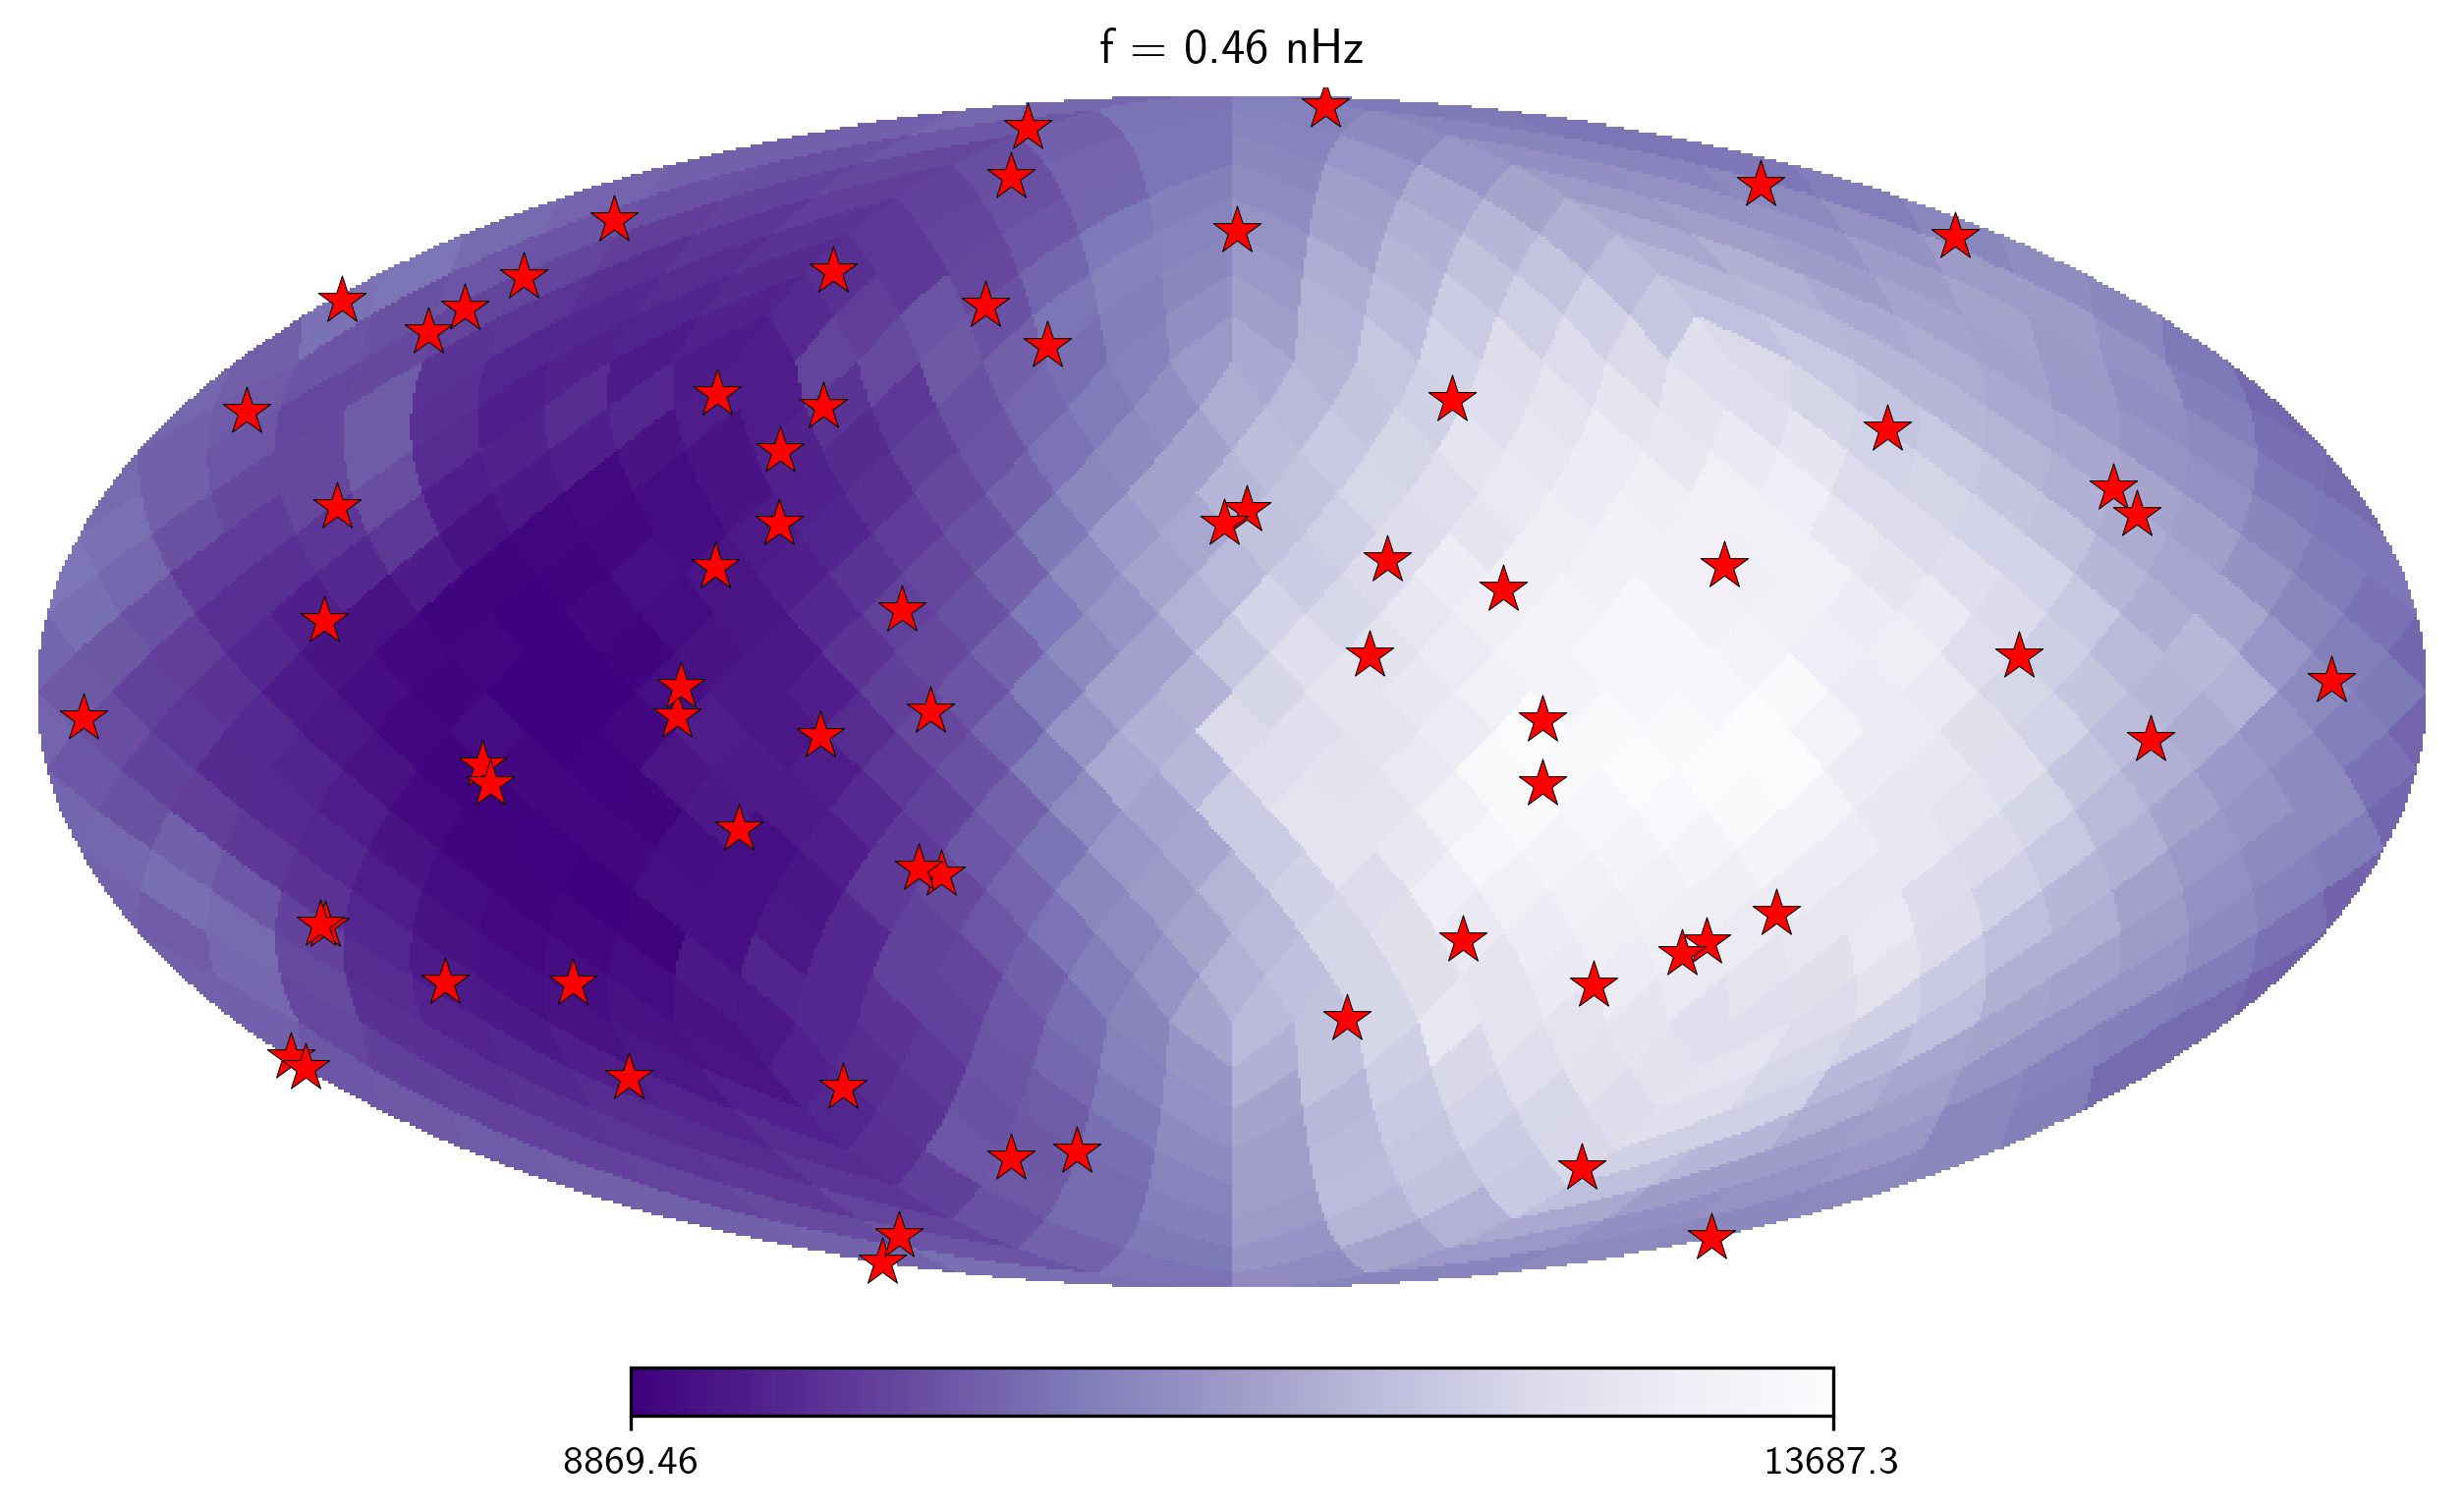

In [16]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    M_kk_pixel = np.sqrt(ASM.M_kk[:, idx])/Tspan
    
    # Plot the map
    hp.mollview(M_kk_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


In [17]:
# # Iterate over frequency indices
# for freq_idx in range(len(freqs)):  # Use range(len(freqs)) to iterate properly
#     # print(f"ASM.M_kk[:, freq_idx] first 5 is {ASM.M_kk[:, freq_idx][:5]}")
#     sqrt_values = np.sqrt(ASM.M_kk[:, freq_idx])
#     # print(f"sqrt_values first 5 is {sqrt_values[:5]}")
#     normalized_sqrt_values = sqrt_values/np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0))
#     normalized_sqrt_values2 = sqrt_values/normalize
#     # print(f"normalize 2 first 5 is {normalized_sqrt_values2[:5]}")
#     # print(f"shape of ASM.M_kk[:, :] is {np.shape(ASM.M_kk[:, :])}")
#     # print(f"shape of ASM.M_kk[:, freq_idx] is {np.shape(ASM.M_kk[:, freq_idx])}")
#     # print(f"shape of np.sqrt(ASM.M_kk[:,:]) is {np.shape(np.sqrt(ASM.M_kk[:,:]))}")
#     # print(f"shape of np.sqrt(ASM.M_kk[:,freq_idx]) is {np.shape(np.sqrt(ASM.M_kk[:,freq_idx]))}")
#     # print(f"shape of np.sqrt(ASM.M_kk[:,:].sum(axis=0)) is {np.shape(np.sqrt(ASM.M_kk[:,:].sum(axis=0)))}")
#     # print(f"shape of np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0)) is {np.shape(np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0)))}")
#     # print(f"np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0)) is {np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0))}")
#     # print(f"normalized_sqrt_values first 5 is {normalized_sqrt_values[:5]}")

In [18]:
# # Placeholder for computed values
# averages = []

# # Initialize variables for overall min and max
# global_min = np.inf
# global_max = -np.inf

# # Iterate over frequency indices
# for freq_idx in range(len(freqs)):  # Use range(len(freqs)) to iterate properly
#     sqrt_values = np.sqrt(ASM.M_kk[:, freq_idx])/Tspan
#     avg_value = np.mean(sqrt_values)  # Compute average
#     averages.append(avg_value)  # Append to list

#     # Update global min and max values
#     global_min = min(global_min, np.min(sqrt_values))
#     global_max = max(global_max, np.max(sqrt_values))

# # Compute statistics for frequencies
# max_freq_idx = np.argmax(averages)  # Index of the max average value
# min_freq_idx = np.argmin(averages)  # Index of the min average value
# avg_freq_idx = np.argmin(np.abs(averages - np.mean(averages)))  # Closest to mean

# print(f"max: {max_freq_idx}, min: {min_freq_idx}, avg: {avg_freq_idx}")

# max_freq = freqs[max_freq_idx]
# min_freq = freqs[min_freq_idx]
# avg_freq = freqs[avg_freq_idx]

# # Plot for max frequency
# max_mkk = np.sqrt(ASM.M_kk[:, max_freq_idx])/Tspan

# # Use the global min and max values for consistent scaling
# hp.mollview(max_mkk, title=f"Max f = {max_freq * 1e9:.2f} nHz", 
#             min=global_min, max=global_max, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()

# # Plot for min frequency
# min_mkk = np.sqrt(ASM.M_kk[:, min_freq_idx])/Tspan

# # Use the global min and max values for consistent scaling
# hp.mollview(min_mkk, title=f"Min f = {min_freq * 1e9:.2f} nHz", 
#             min=global_min, max=global_max, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()

# # Plot for average frequency
# avg_mkk = np.sqrt(ASM.M_kk[:, avg_freq_idx])/Tspan

# # Use the global min and max values for consistent scaling
# hp.mollview(avg_mkk, title=f"Avg f = {avg_freq * 1e9:.2f} nHz", 
#             min=global_min, max=global_max, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                          edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()


In [19]:
# # Placeholder for computed values
# averages = []

# # Iterate over frequency indices
# for freq_idx in range(len(freqs)):  # Use range(len(freqs)) to iterate properly
#     sqrt_values = np.sqrt(ASM.M_kk[:, freq_idx])
#     normalized_sqrt_values = sqrt_values/np.sqrt(ASM.M_kk[:,freq_idx].sum(axis=0))
#     avg_value = np.mean(sqrt_values)  # Compute average
#     averages.append(avg_value)  # Append to list

# # Compute statistics for frequencies
# max_freq_idx = np.argmax(averages)  # Index of the max average value
# min_freq_idx = np.argmin(averages)  # Index of the min average value
# avg_freq_idx = np.argmin(np.abs(averages - np.mean(averages)))  # Closest to mean

# print(f"max: {max_freq_idx}, min: {min_freq_idx}, avg: {avg_freq_idx}")

# max_freq = freqs[max_freq_idx]
# min_freq = freqs[min_freq_idx]
# avg_freq = freqs[avg_freq_idx]
# # Plot for max frequency
# max_mkk = np.sqrt(ASM.M_kk[:, max_freq_idx])

# vmin, vmax = np.min(max_mkk), np.max(max_mkk)
# print(vmin/np.sqrt(ASM.M_kk[:,max_freq_idx].sum(axis=0)))
# print(vmax/np.sqrt(ASM.M_kk[:,max_freq_idx].sum(axis=0)))
# normalized_max_mkk = max_mkk/np.sqrt(ASM.M_kk[:,max_freq_idx].sum(axis=0))
# print(f"normalized_max_mkk first 5 is {normalized_max_mkk[:5]}")

# hp.mollview(normalized_max_mkk, title=f"Max f = {max_freq * 1e9:.2f} nHz", 
#             min=abs_vmin, max=abs_vmax, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()

# # Plot for min frequency
# min_mkk = np.sqrt(ASM.M_kk[:, min_freq_idx])

# vmin, vmax = np.min(min_mkk), np.max(min_mkk)
# print(vmin/np.sqrt(ASM.M_kk[:,min_freq_idx].sum(axis=0)))
# print(vmax/np.sqrt(ASM.M_kk[:,min_freq_idx].sum(axis=0)))
# normalized_min_mkk = min_mkk/np.sqrt(ASM.M_kk[:,min_freq_idx].sum(axis=0))
# print(f"normalized_min_mkk first 5 is {normalized_min_mkk[:5]}")


# hp.mollview(normalized_min_mkk, title=f"Min f = {min_freq * 1e9:.2f} nHz", 
#             min=abs_vmin, max=abs_vmax, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()

# # Plot for average frequency
# avg_mkk = np.sqrt(ASM.M_kk[:, avg_freq_idx])

# vmin, vmax = np.min(avg_mkk), np.max(avg_mkk)
# print(vmin/np.sqrt(ASM.M_kk[:,avg_freq_idx].sum(axis=0)))
# print(vmax/np.sqrt(ASM.M_kk[:,avg_freq_idx].sum(axis=0)))
# normalized_avg_mkk = avg_mkk/np.sqrt(ASM.M_kk[:,avg_freq_idx].sum(axis=0))
# print(f"normalized_avg_mkk first 5 is {normalized_avg_mkk[:5]}")


# hp.mollview(normalized_avg_mkk, title=f"Avg f = {avg_freq * 1e9:.2f} nHz", 
#             min=abs_vmin, max=abs_vmax, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

# # Highlight all pulsar positions
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                          edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.show()

In [20]:
# print(np.shape(ASM.S_eff_aniso))

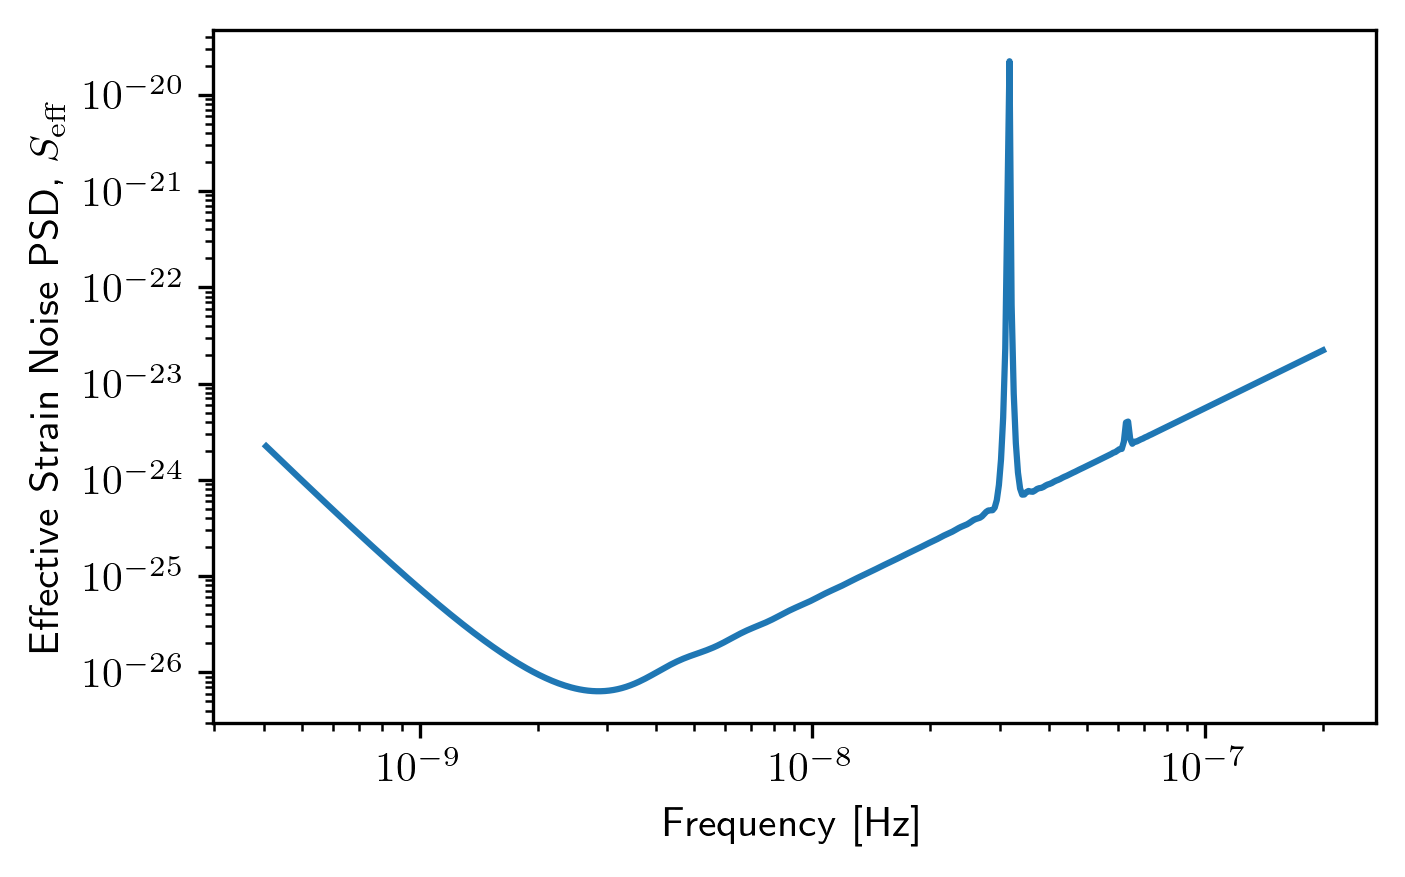

In [21]:
plt.loglog(freqs,ASM.S_eff_aniso)
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
plt.show()

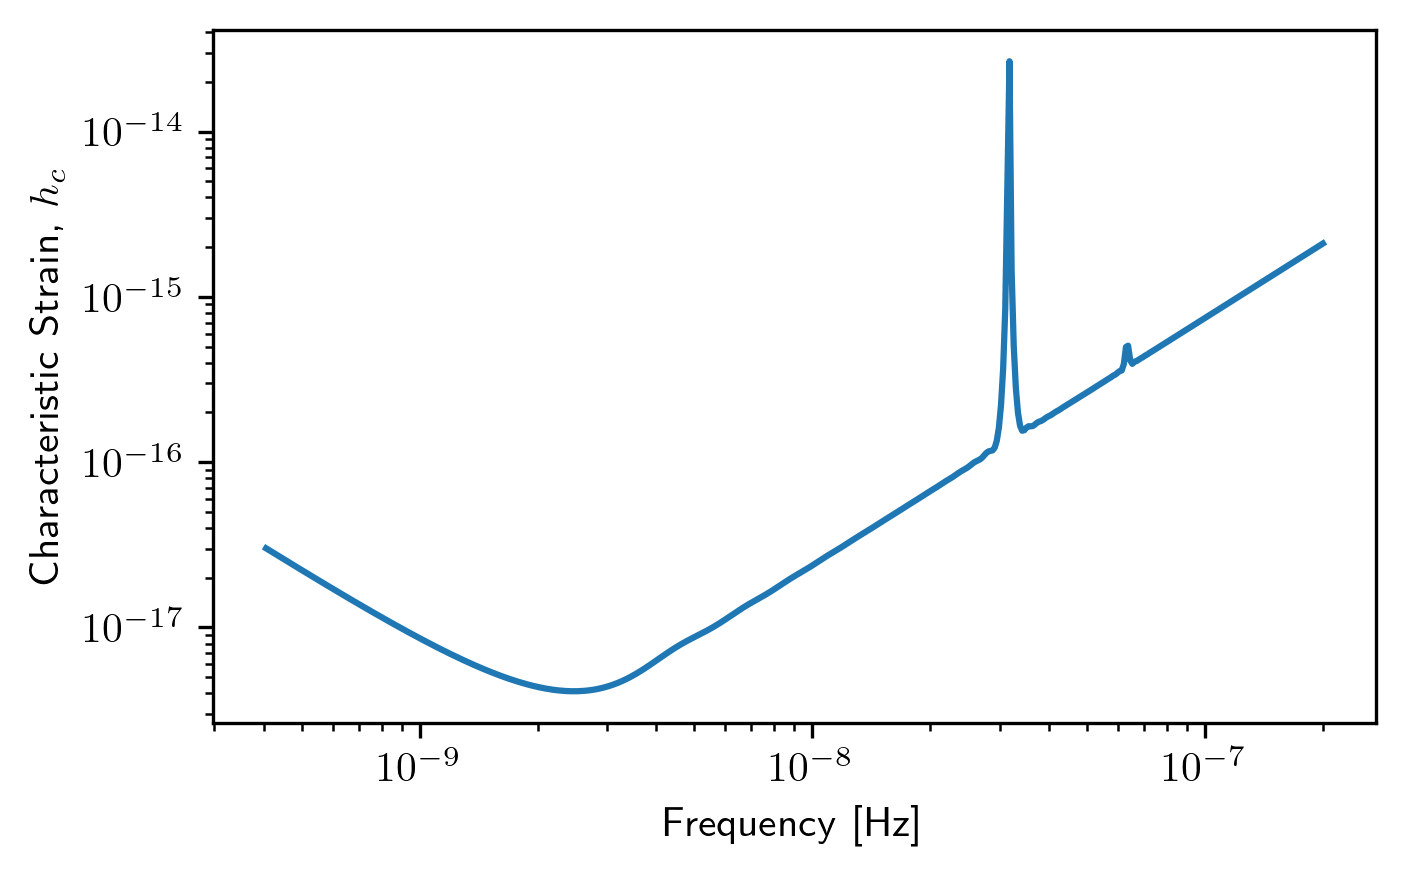

In [22]:
plt.loglog(freqs,ASM.h_c_aniso)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

In [23]:
# import numpy as np
# import healpy as hp
# import matplotlib.pyplot as plt

# search_freq = [2e-9, 4e-9, 5.9e-9, 7.9e-9, 9.9e-9]
# final_freqs = []
# final_idxs = []

# # Use the first pulsar to find the closest frequency indices
# for freq in search_freq:
#     fl_idx = np.argmin(np.abs(freqs - freq))  # Use the first pulsar
#     fl = freqs[fl_idx]  # Access the freqs from the first pulsar
#     final_freqs.append(fl)
#     final_idxs.append(fl_idx)

# print(f"Search frequencies: {search_freq}")
# print(f"Final frequencies: {final_freqs}")
# print(f"Final indices: {final_idxs}")

# # Create figure with a 2-column layout
# fig = plt.figure(figsize=(14, 12))

# # Define subplot positions
# positions = [(0, 0), (0, 1), (1, 0), (1, 1)]  # First 4 plots in a 2x2 grid

# for i, (freq, fl_idx) in enumerate(zip(final_freqs, final_idxs)):    
#     if i < 4:  # First 4 plots in 2x2 grid
#         ax = plt.subplot2grid((3, 2), positions[i], colspan=1)
#     else:  # Last plot spans both columns
#         ax = plt.subplot2grid((3, 2), (2, 0), colspan=2)

#     plt.sca(ax)  # Set the current axis
#     vmin, vmax = np.min(ASM.M_kk[:, fl_idx]), np.max(ASM.M_kk[:, fl_idx])
#     hp.mollview(ASM.M_kk[:, fl_idx], title=f"f = {freq:.2e} Hz", 
#                 min=0, max=1, cmap='Purples_r', rot=(180,0,0), hold=False)  # Consistent scale & better contrast

#     # Highlight all pulsar positions
#     hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='white', 
#                              edgecolors='black', s=200, alpha=0.8, rot=(180,0,0))  # Transparency for clarity

#     # Annotate each plot with frequency
#     plt.text(0, -1.2, f"{freq:.2e} Hz", fontsize=14, ha='center', color='white', fontweight='bold')

# plt.show()


## Test with NG 15yr pulsars

In [24]:
spectra_15yr = []
file_count = 0
max_files = 5  # Number of files to load

for filename in os.listdir(datadir):
    if filename.endswith('.has'):
        file_path = os.path.join(datadir, filename)
        with open(file_path, 'rb') as file:
            # print(f"Loading file: {filename}")
            spec_15yr = pickle.load(file)
            spectra_15yr.append(spec_15yr)
            # print(f"PSR: {spec_15yr.name}")
            file_count += 1    
            # Clear the loaded file from memory
            del spec_15yr   
            if file_count >= max_files:
                break  # Stop after loading the specified number of files

In [68]:
spectra_15yr[0].__dir__()

['_H_0',
 'toas',
 'toaerrs',
 'phi',
 'theta',
 'N',
 'G',
 'designmatrix',
 'pdist',
 'tm_fit',
 'Tf_kwargs',
 'freqs',
 '_psd_prefit',
 'name',
 '_NcalInv',
 '_P_n',
 '_S_I',
 '__module__',
 '__firstlineno__',
 '__doc__',
 '__init__',
 'psd_postfit',
 'psd_prefit',
 'Tf',
 'NcalInv',
 'P_n',
 'S_I',
 'S_R',
 'h_c',
 'Omega_gw',
 'add_white_noise_power',
 'add_red_noise_power',
 'add_noise_power',
 '__static_attributes__',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [25]:
max_time = max(
    (np.max(spectra.toas) - np.min(spectra.toas)) / (24 * 3600 * 365.25)
    for spectra in spectra_15yr
)
print(max_time)
max_time_secs = max(
    (np.max(spectra.toas) - np.min(spectra.toas))
    for spectra in spectra_15yr
)
print(max_time_secs)
print(1/max_time_secs)
print(spectra_15yr[0].freqs[0])

Tspan = max_time_secs

8.963756103507466
282874629.6120472
3.5351349867305724e-09
2.0000000000000003e-10


In [26]:
#Use the healpy functions to get the sky coordinates
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [27]:
ASM=haniso.Anisotropy(spectra_15yr,theta_gw, phi_gw, NPIX=NPIX)

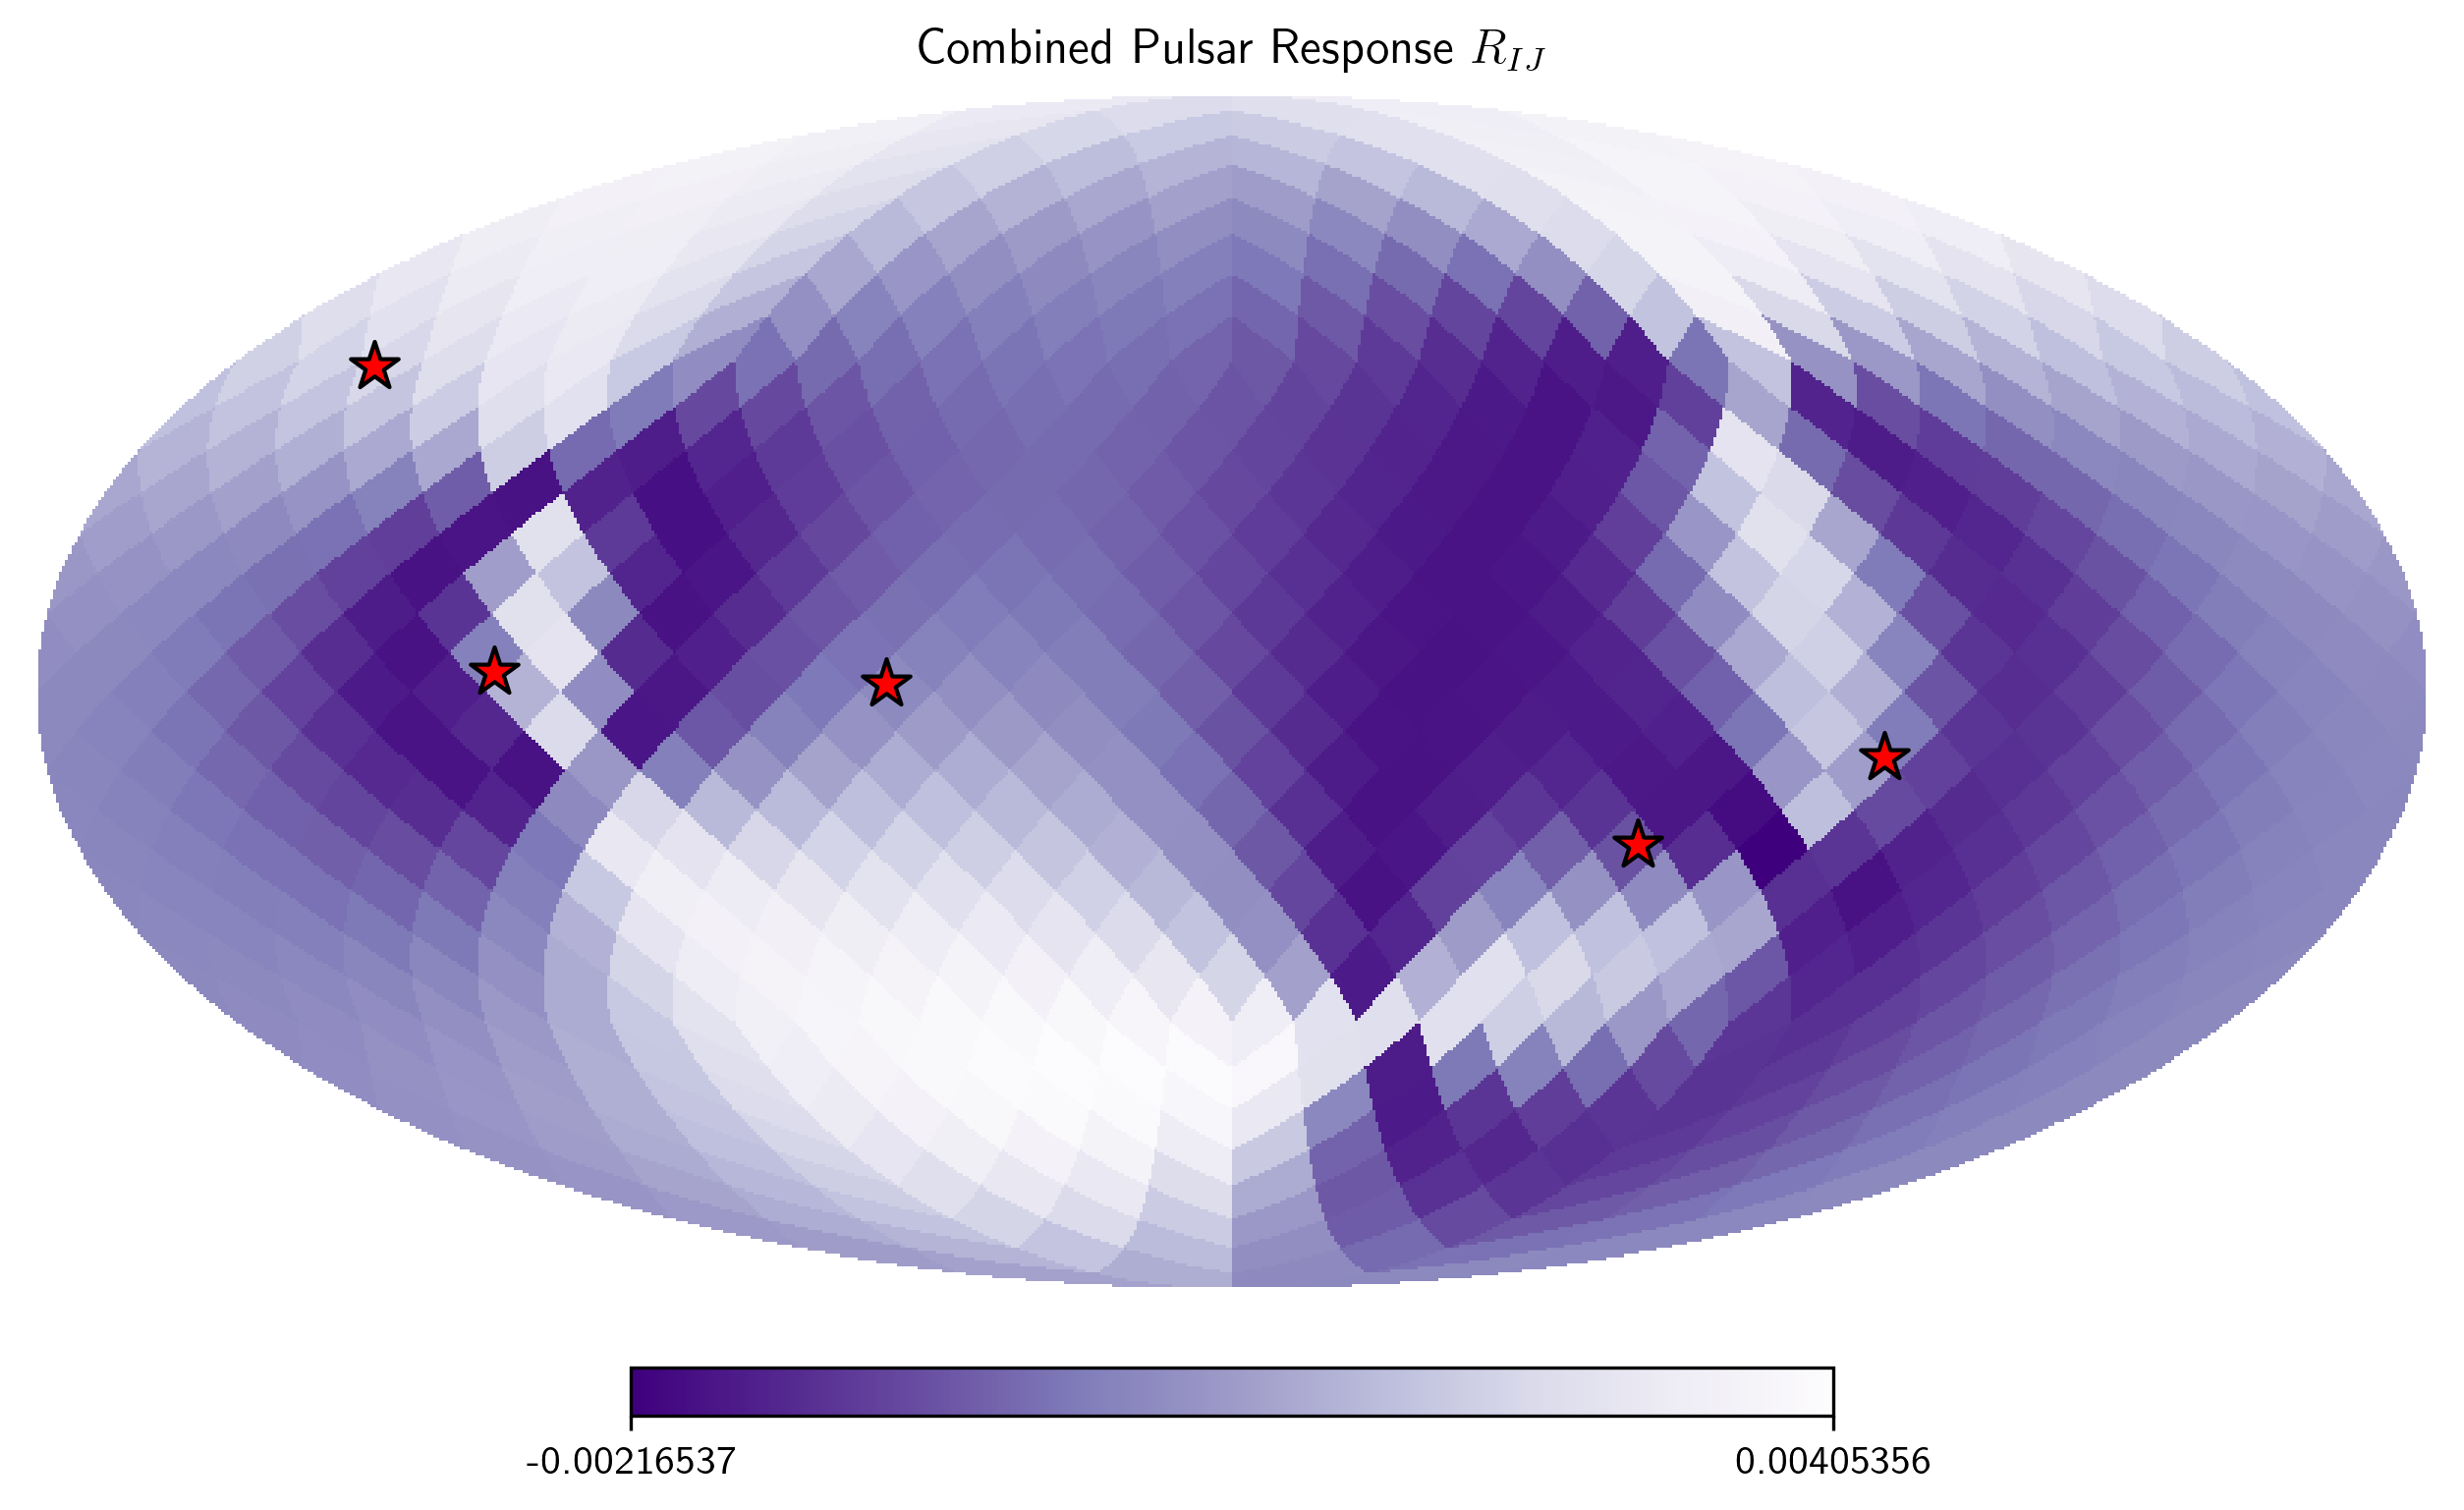

In [28]:
# Summing all pair responses
combined_response = ASM.R_IJ.sum(axis=0)

# Plot the combined response
hp.mollview(combined_response, title="Combined Pulsar Response $R_{IJ}$", cmap='Purples_r', rot=(180,0,0))

# Highlight all pulsar positions


hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', s=150, rot=(180,0,0))
# plt.savefig(savedir+'combined.png')
plt.show()


In [29]:
max_value = np.max(ASM.h_c_aniso)
max_index = np.argmax(ASM.h_c_aniso)
max_freq = spectra_15yr[0].freqs[max_index]  # Corresponding frequency
print(f"Max value: {max_value}, Index: {max_index}, Frequency: {max_freq}")

min_value = np.min(ASM.h_c_aniso)
min_index = np.argmin(ASM.h_c_aniso)
min_freq = spectra_15yr[0].freqs[min_index]  # Corresponding frequency
print(f"Min value: {min_value}, Index: {min_index}, Frequency: {min_freq}")

median_value = np.median(ASM.h_c_aniso)
median_index = (np.abs(ASM.h_c_aniso - median_value)).argmin()
median_freq = spectra_15yr[0].freqs[median_index]  # Corresponding frequency
print(f"Median value: {median_value}, Index: {median_index}, Frequency: {median_freq}")

Max value: 6.508857706794588e-12, Index: 219, Frequency: 3.150318114183249e-08
Min value: 9.473381040730237e-15, Index: 143, Frequency: 5.442677536750618e-09
Median value: 6.804492006026191e-14, Index: 214, Frequency: 2.8066430752109697e-08


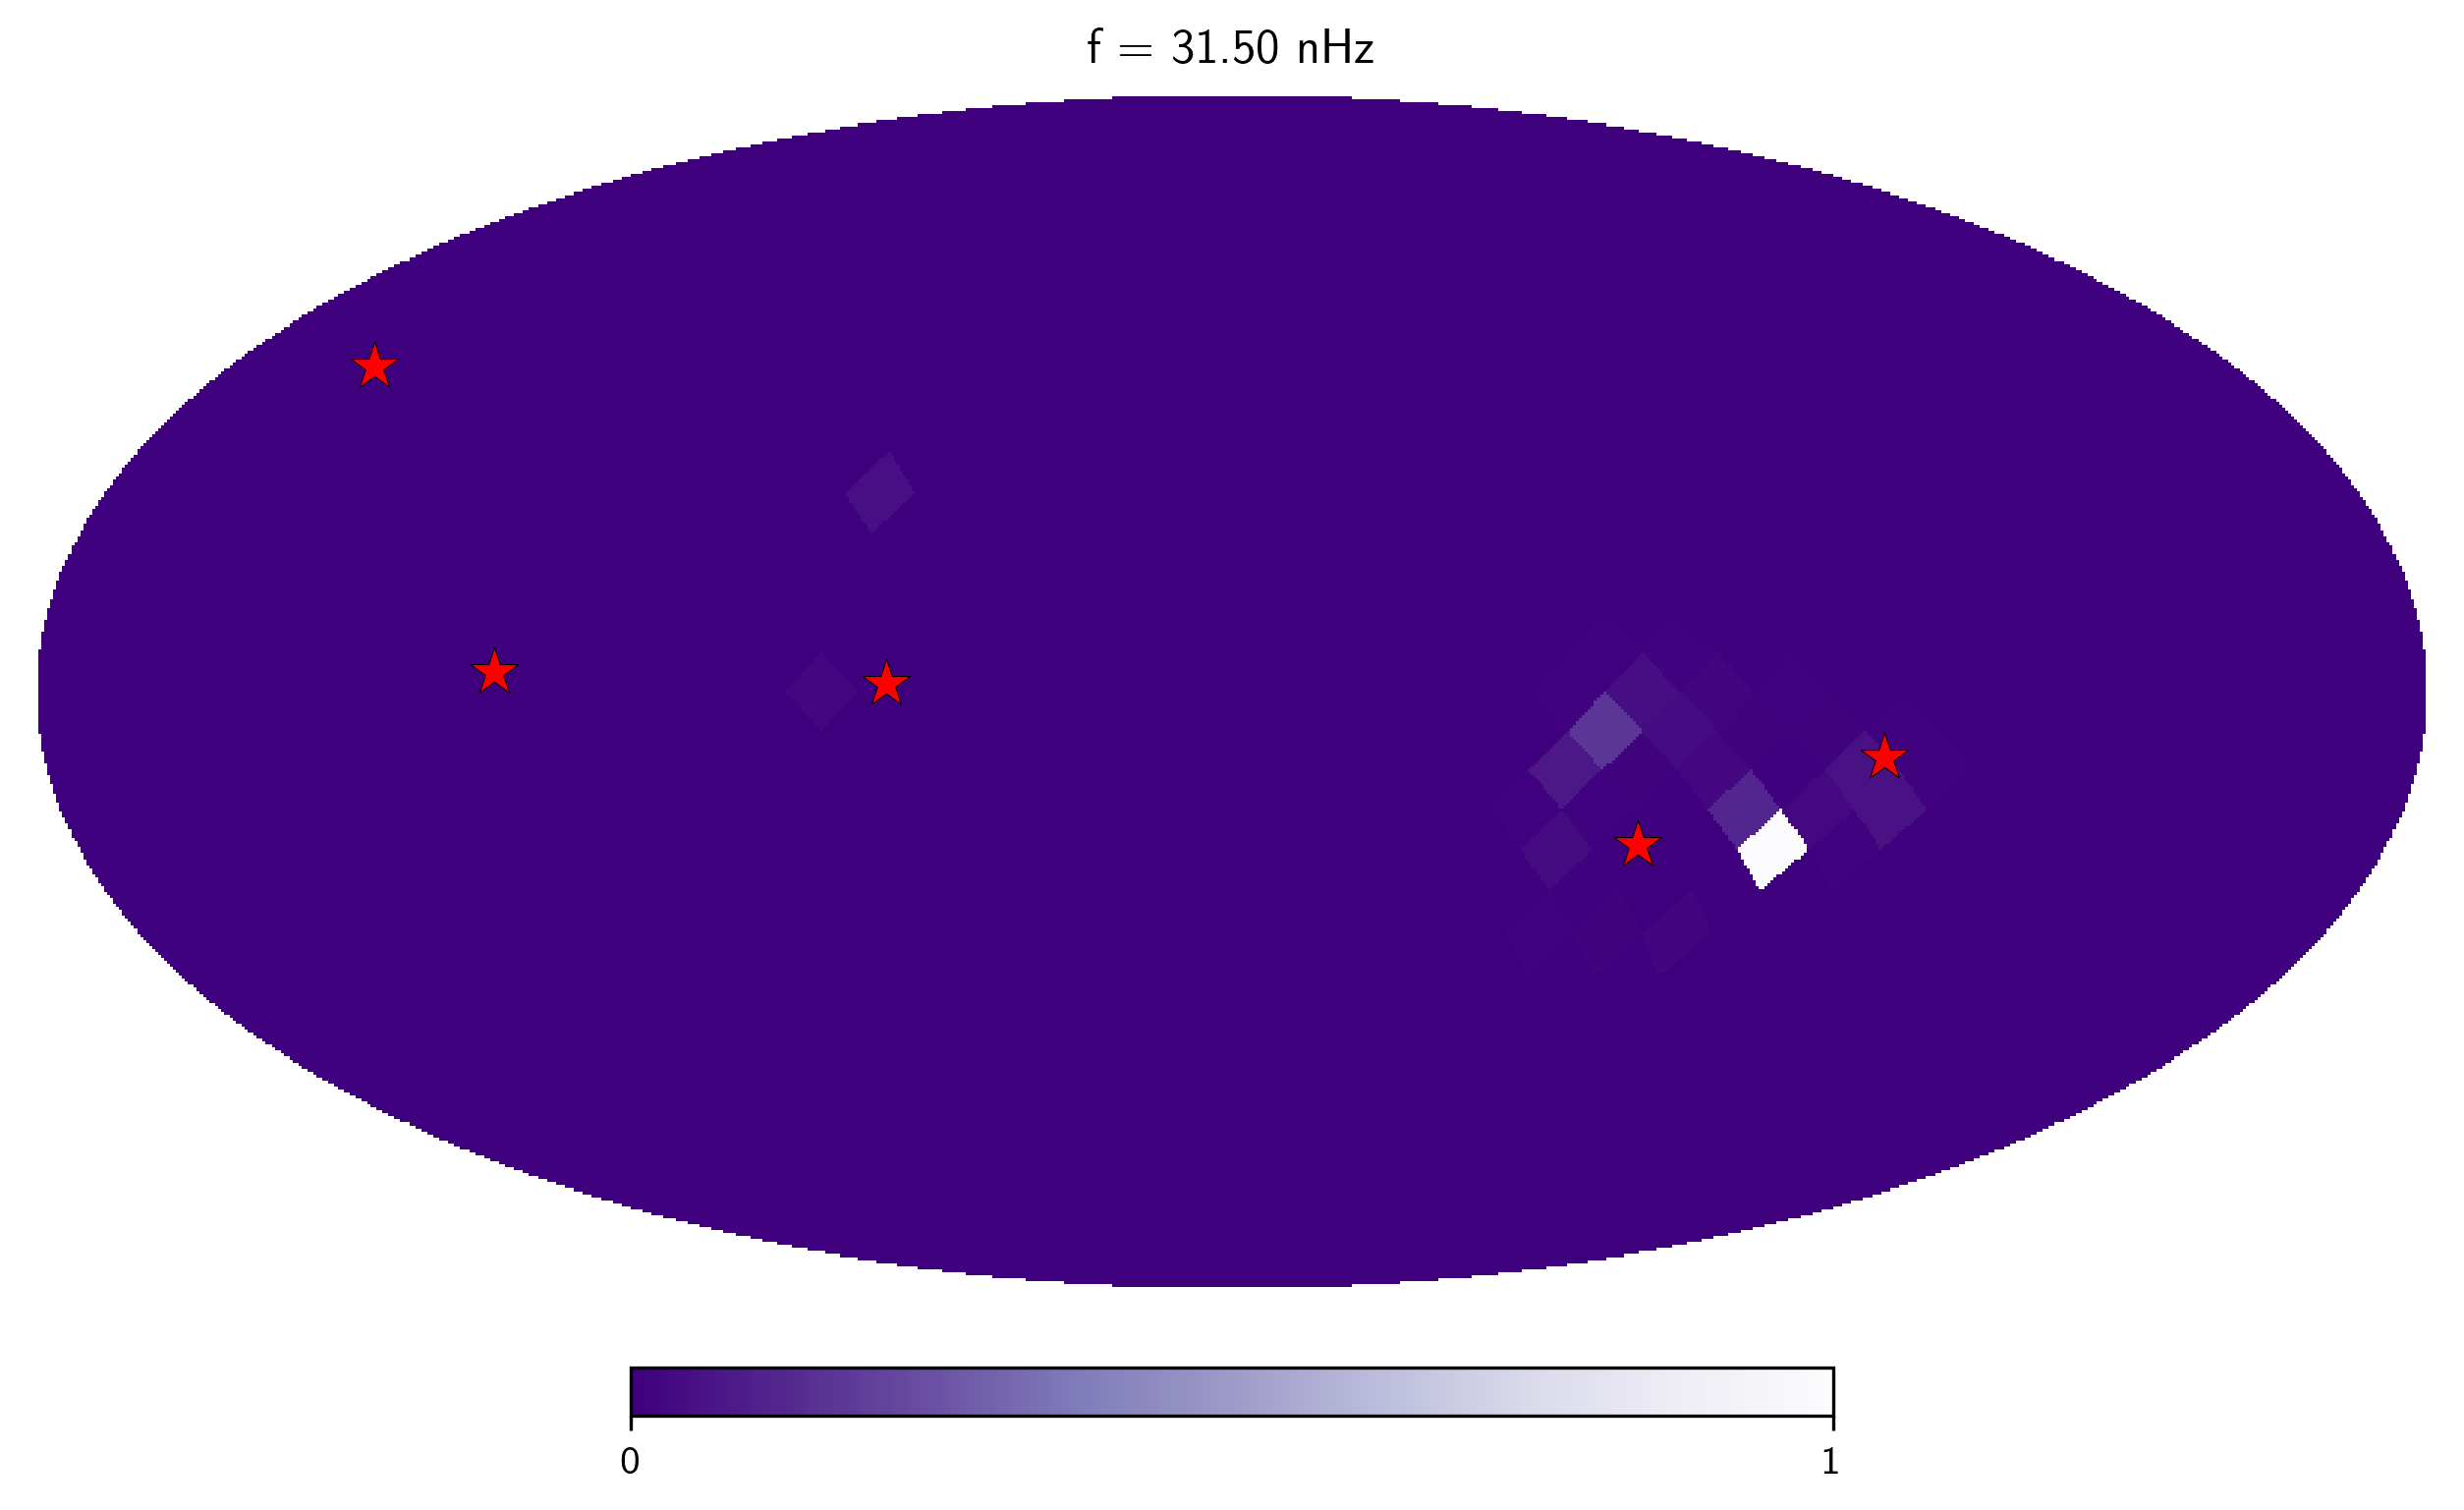

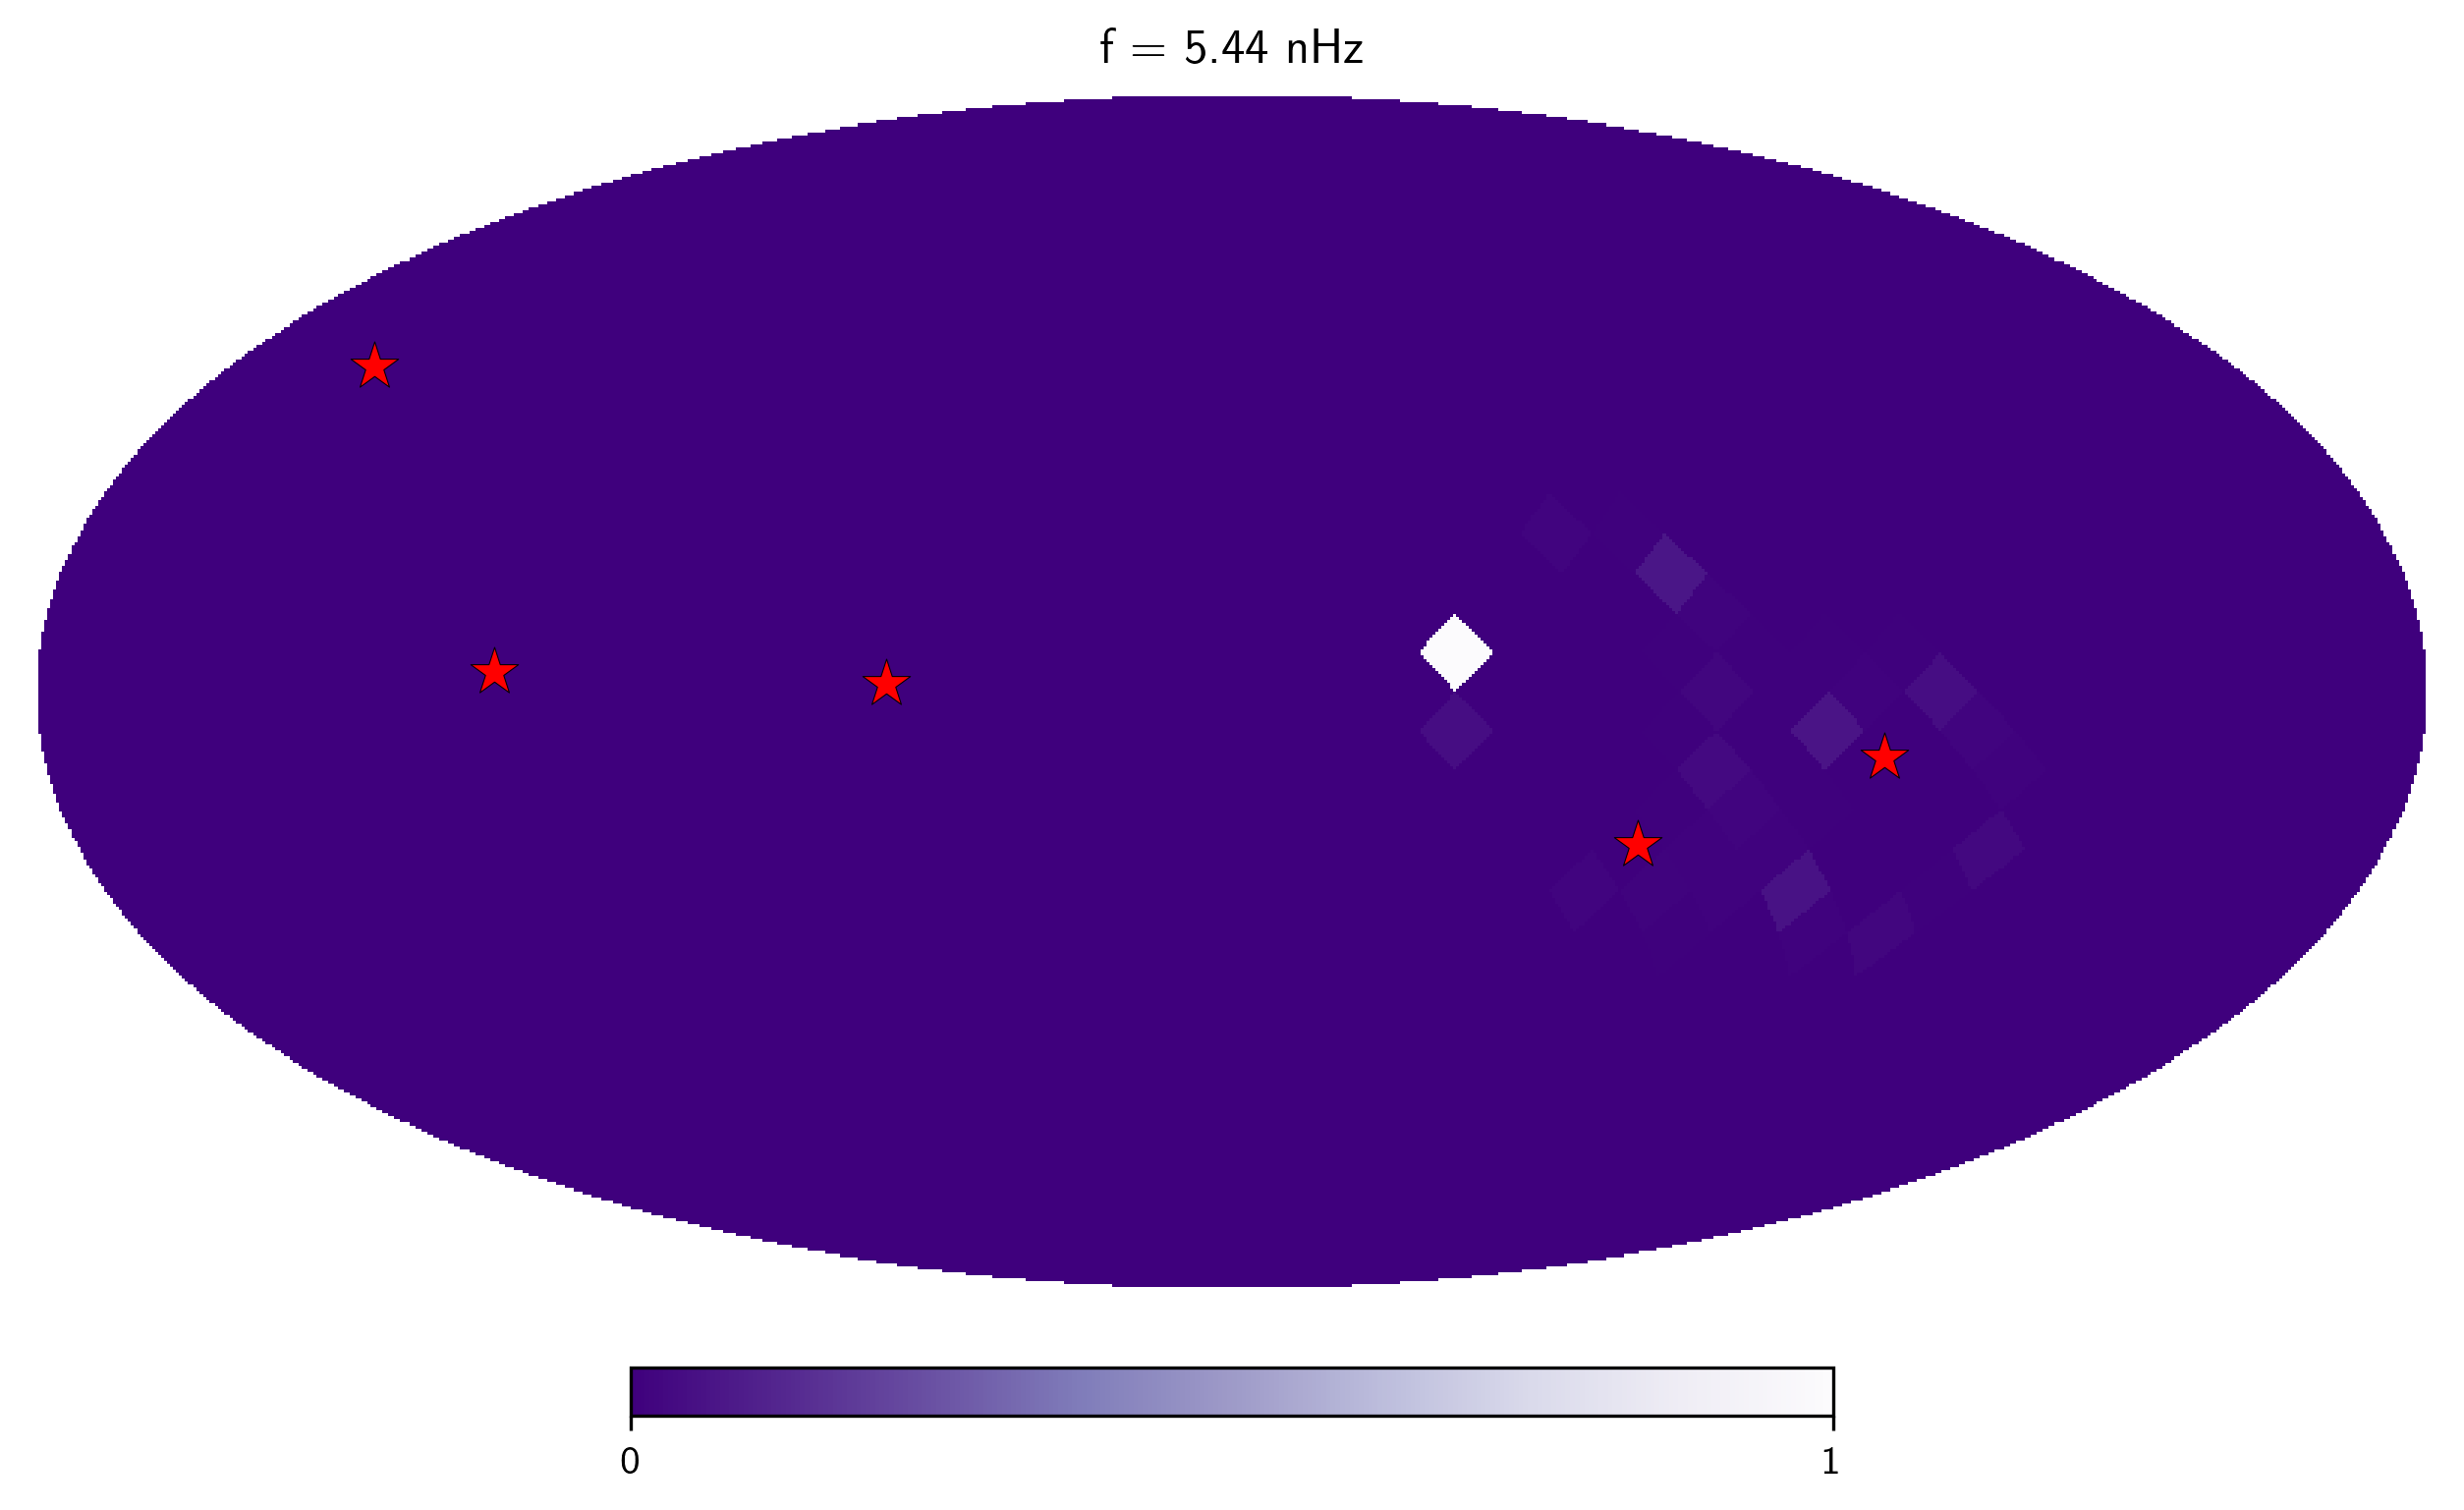

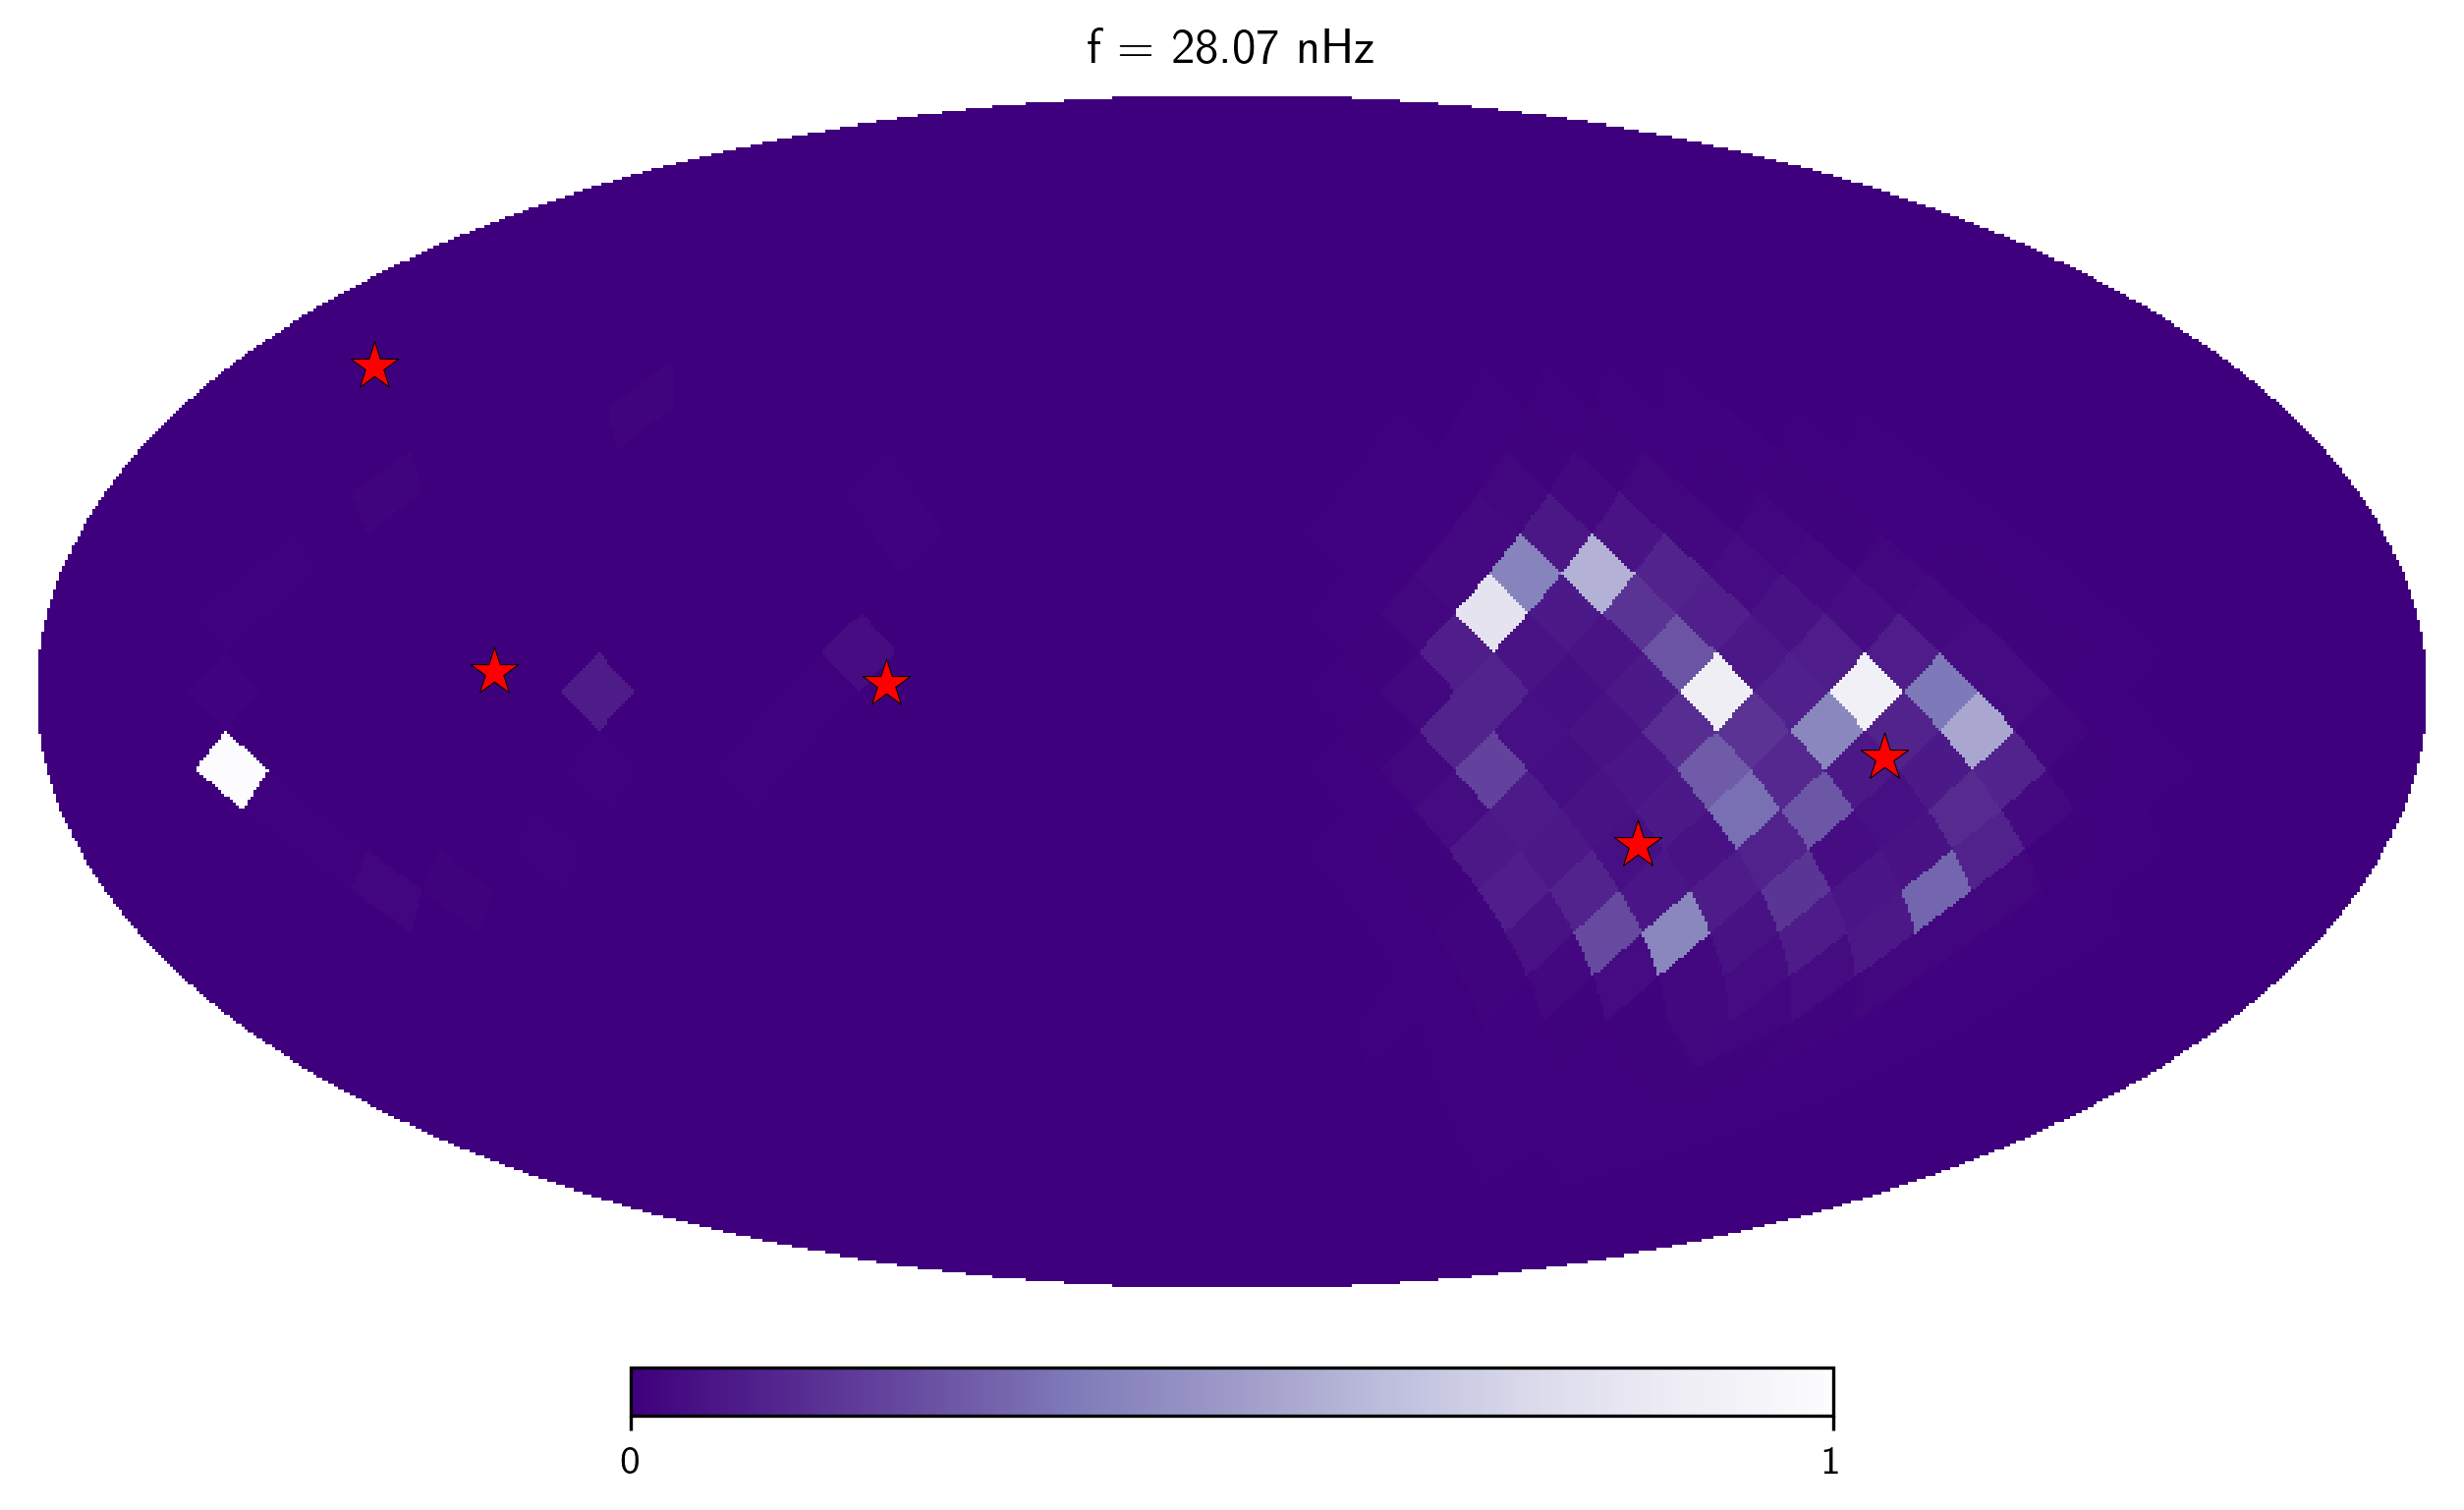

In [30]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    h_c_pixel = ASM.h_c_aniso_pixel(idx)
    h_c_pixel_norm = (h_c_pixel - np.min(h_c_pixel)) / (np.max(h_c_pixel) - np.min(h_c_pixel))
    
    # Plot the map
    hp.mollview(h_c_pixel_norm, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


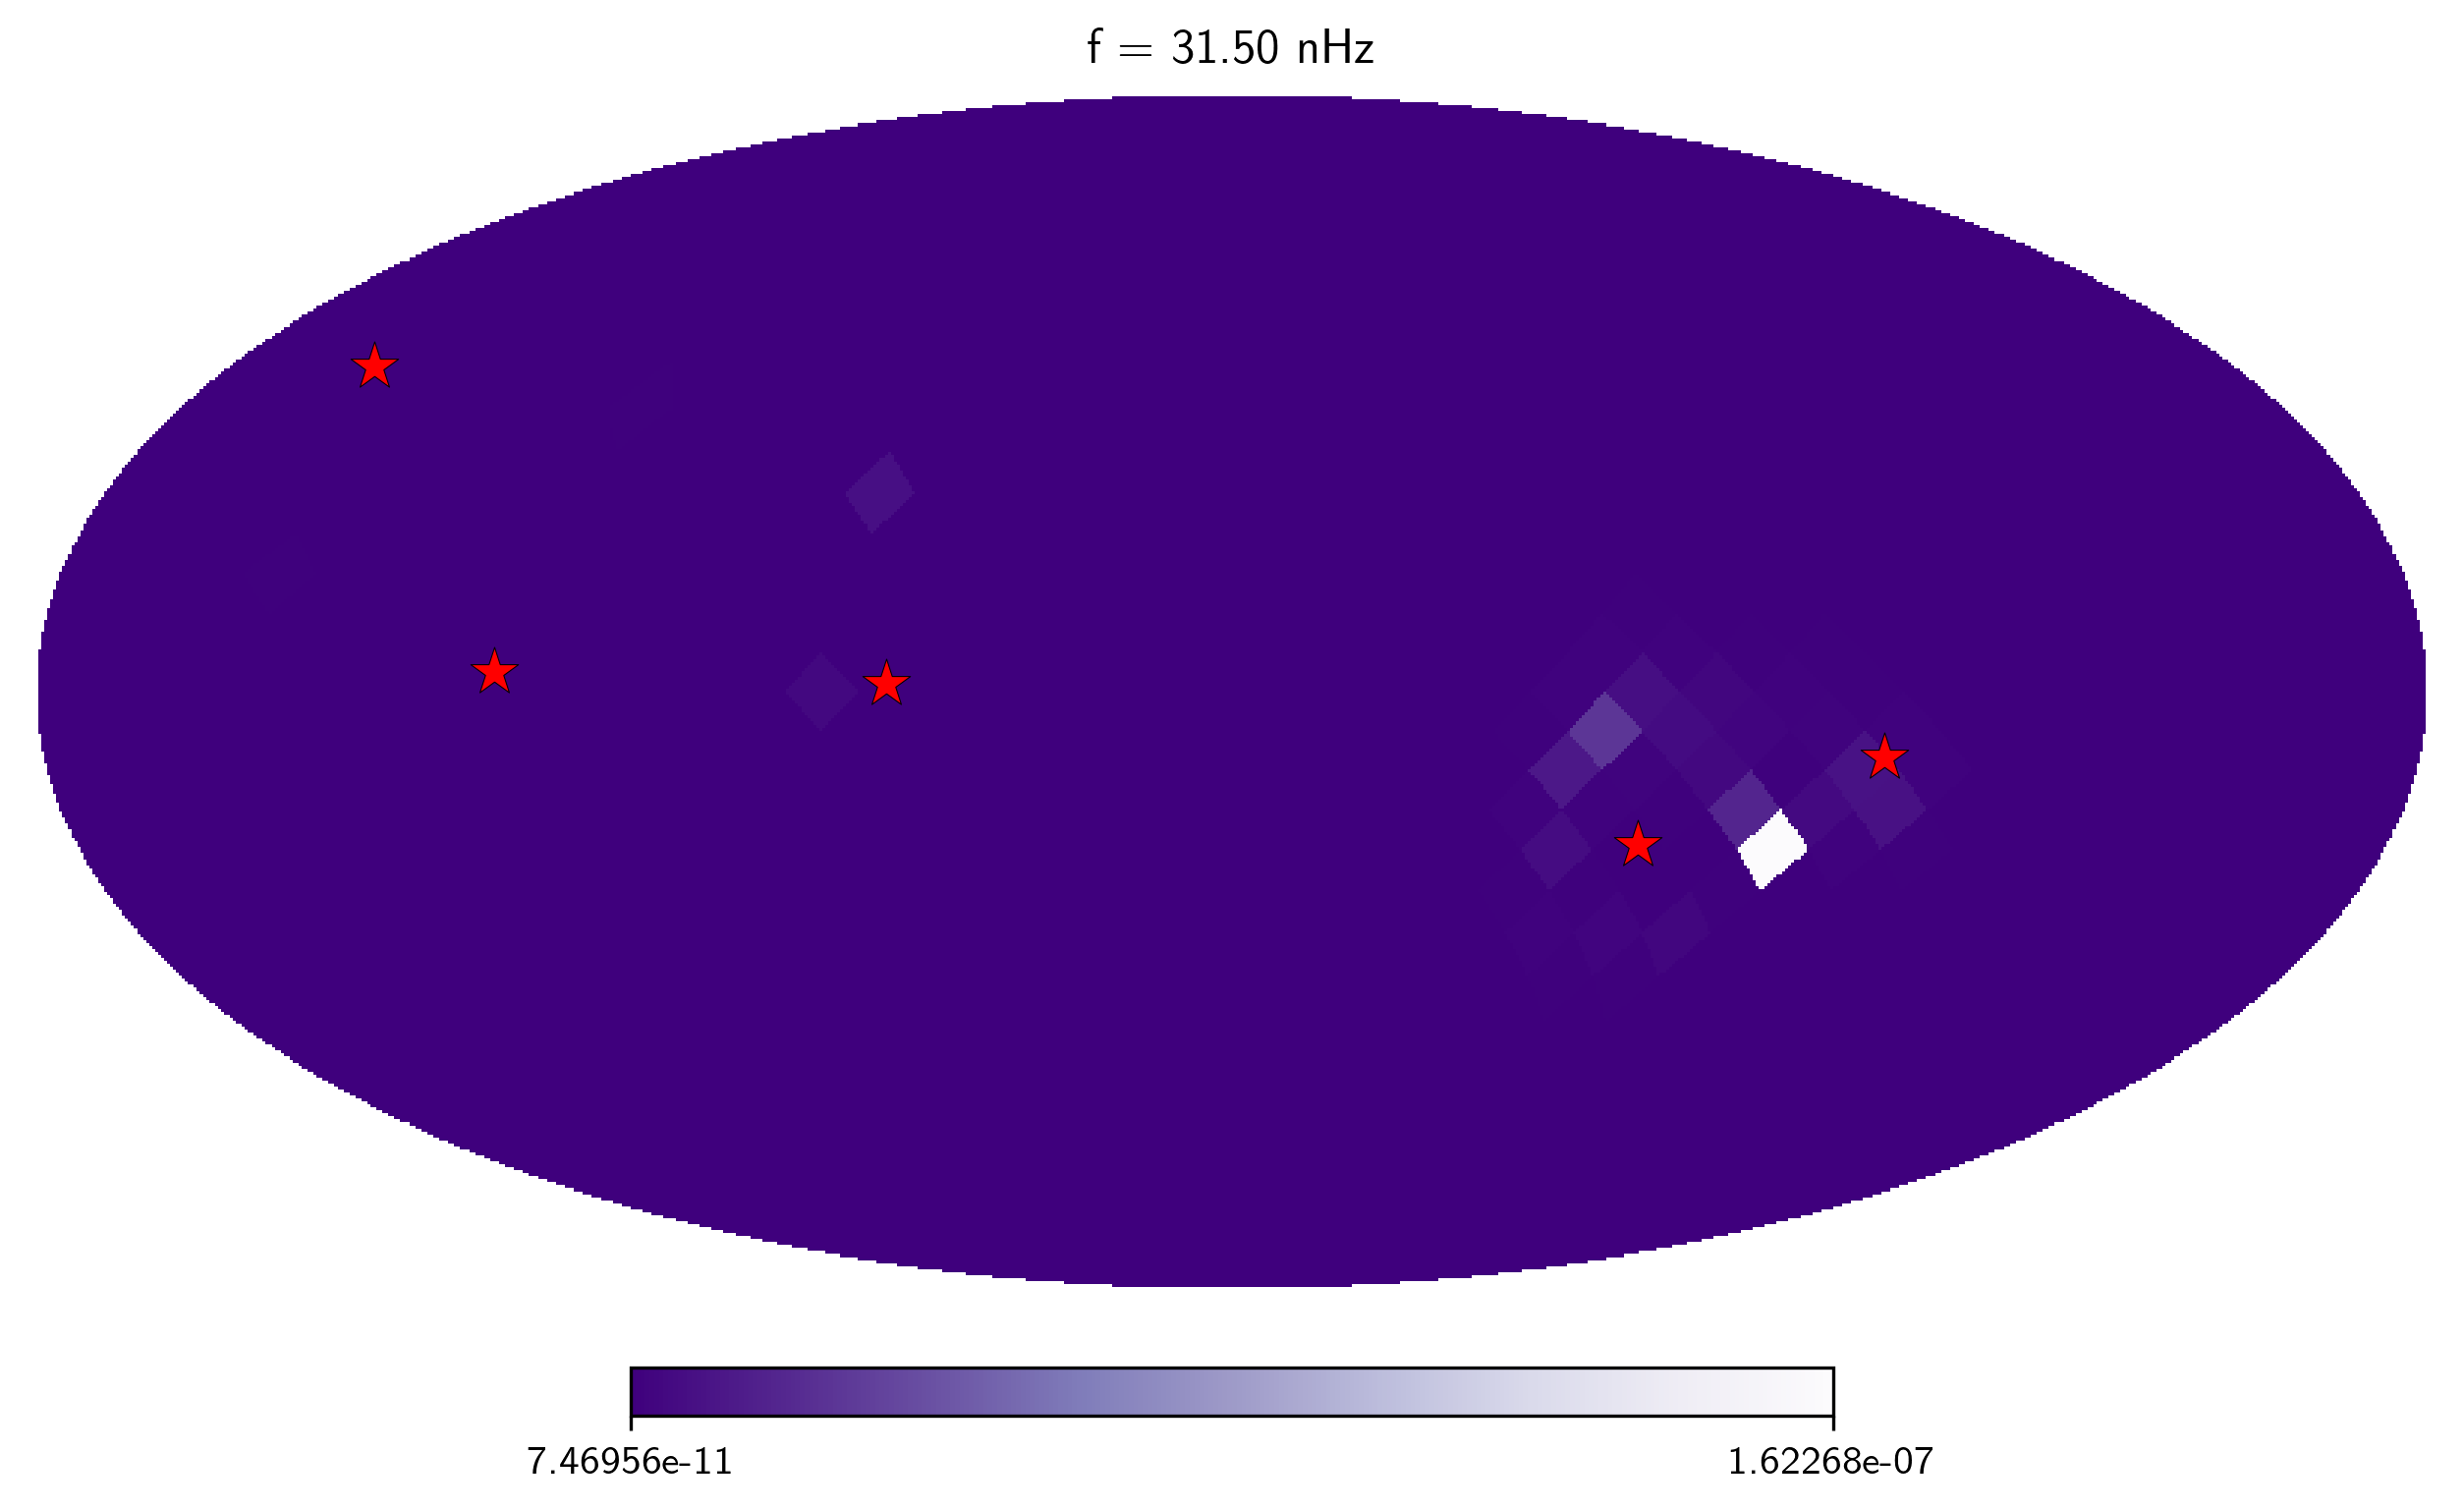

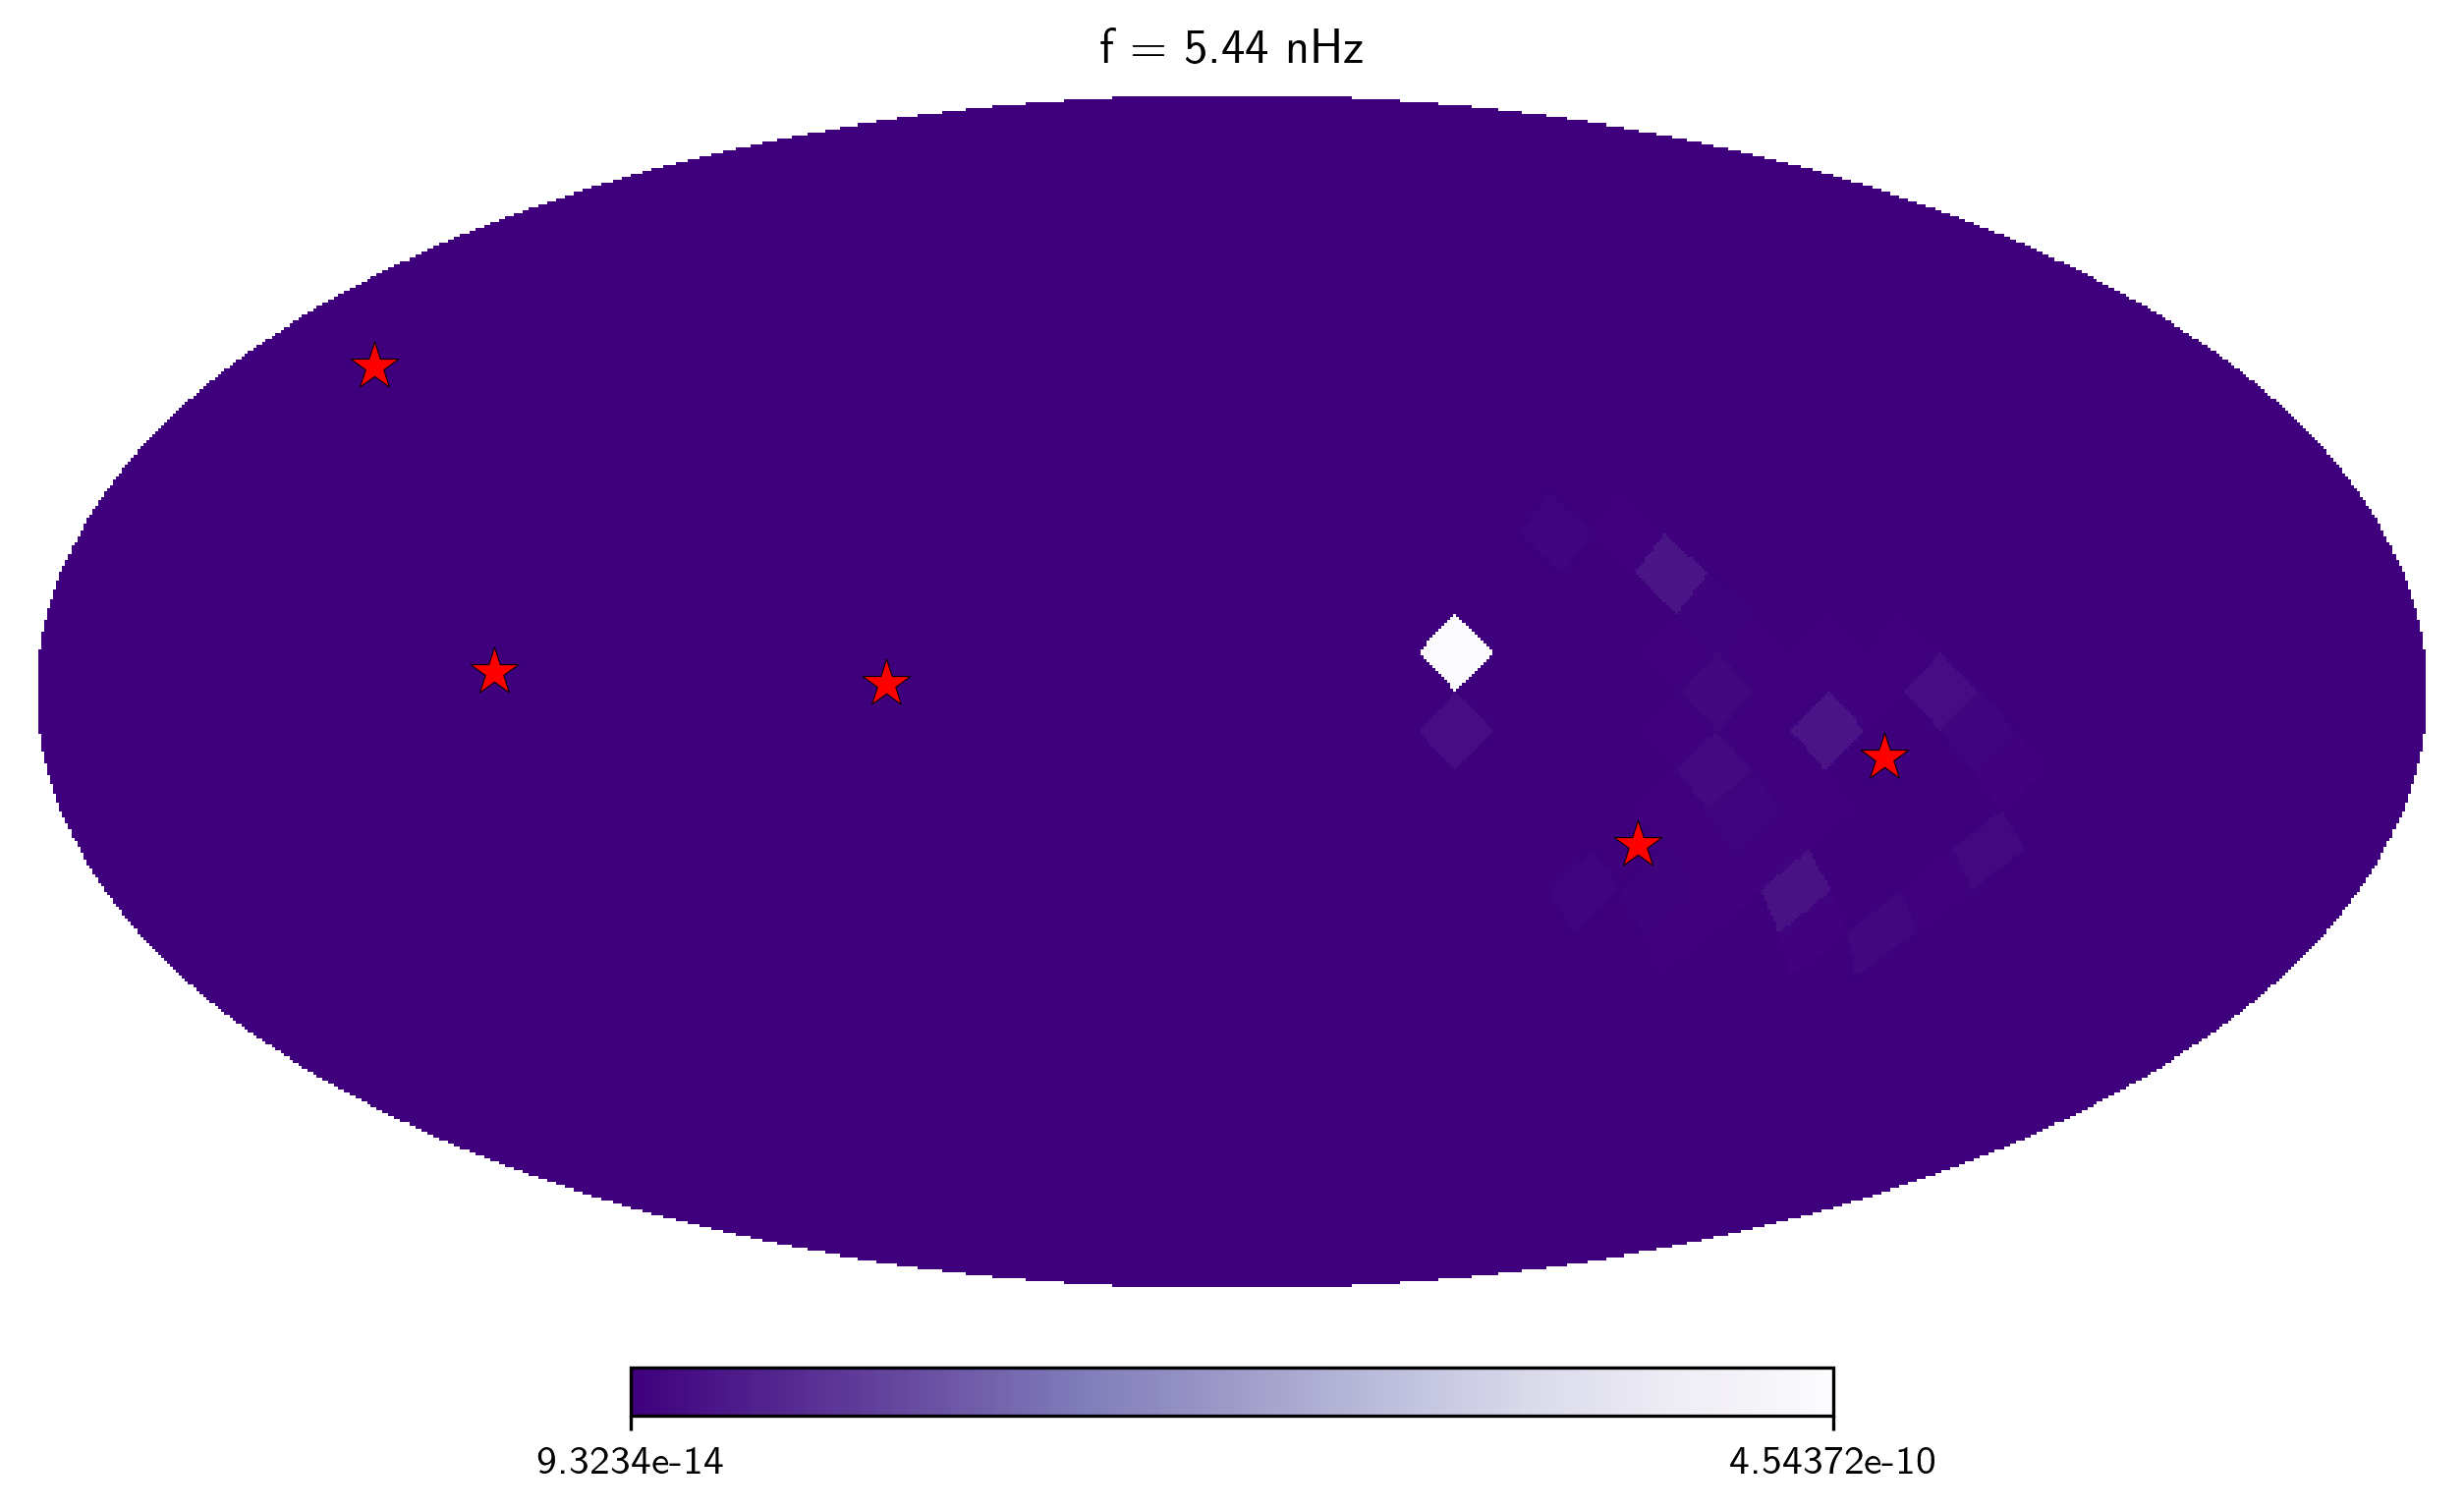

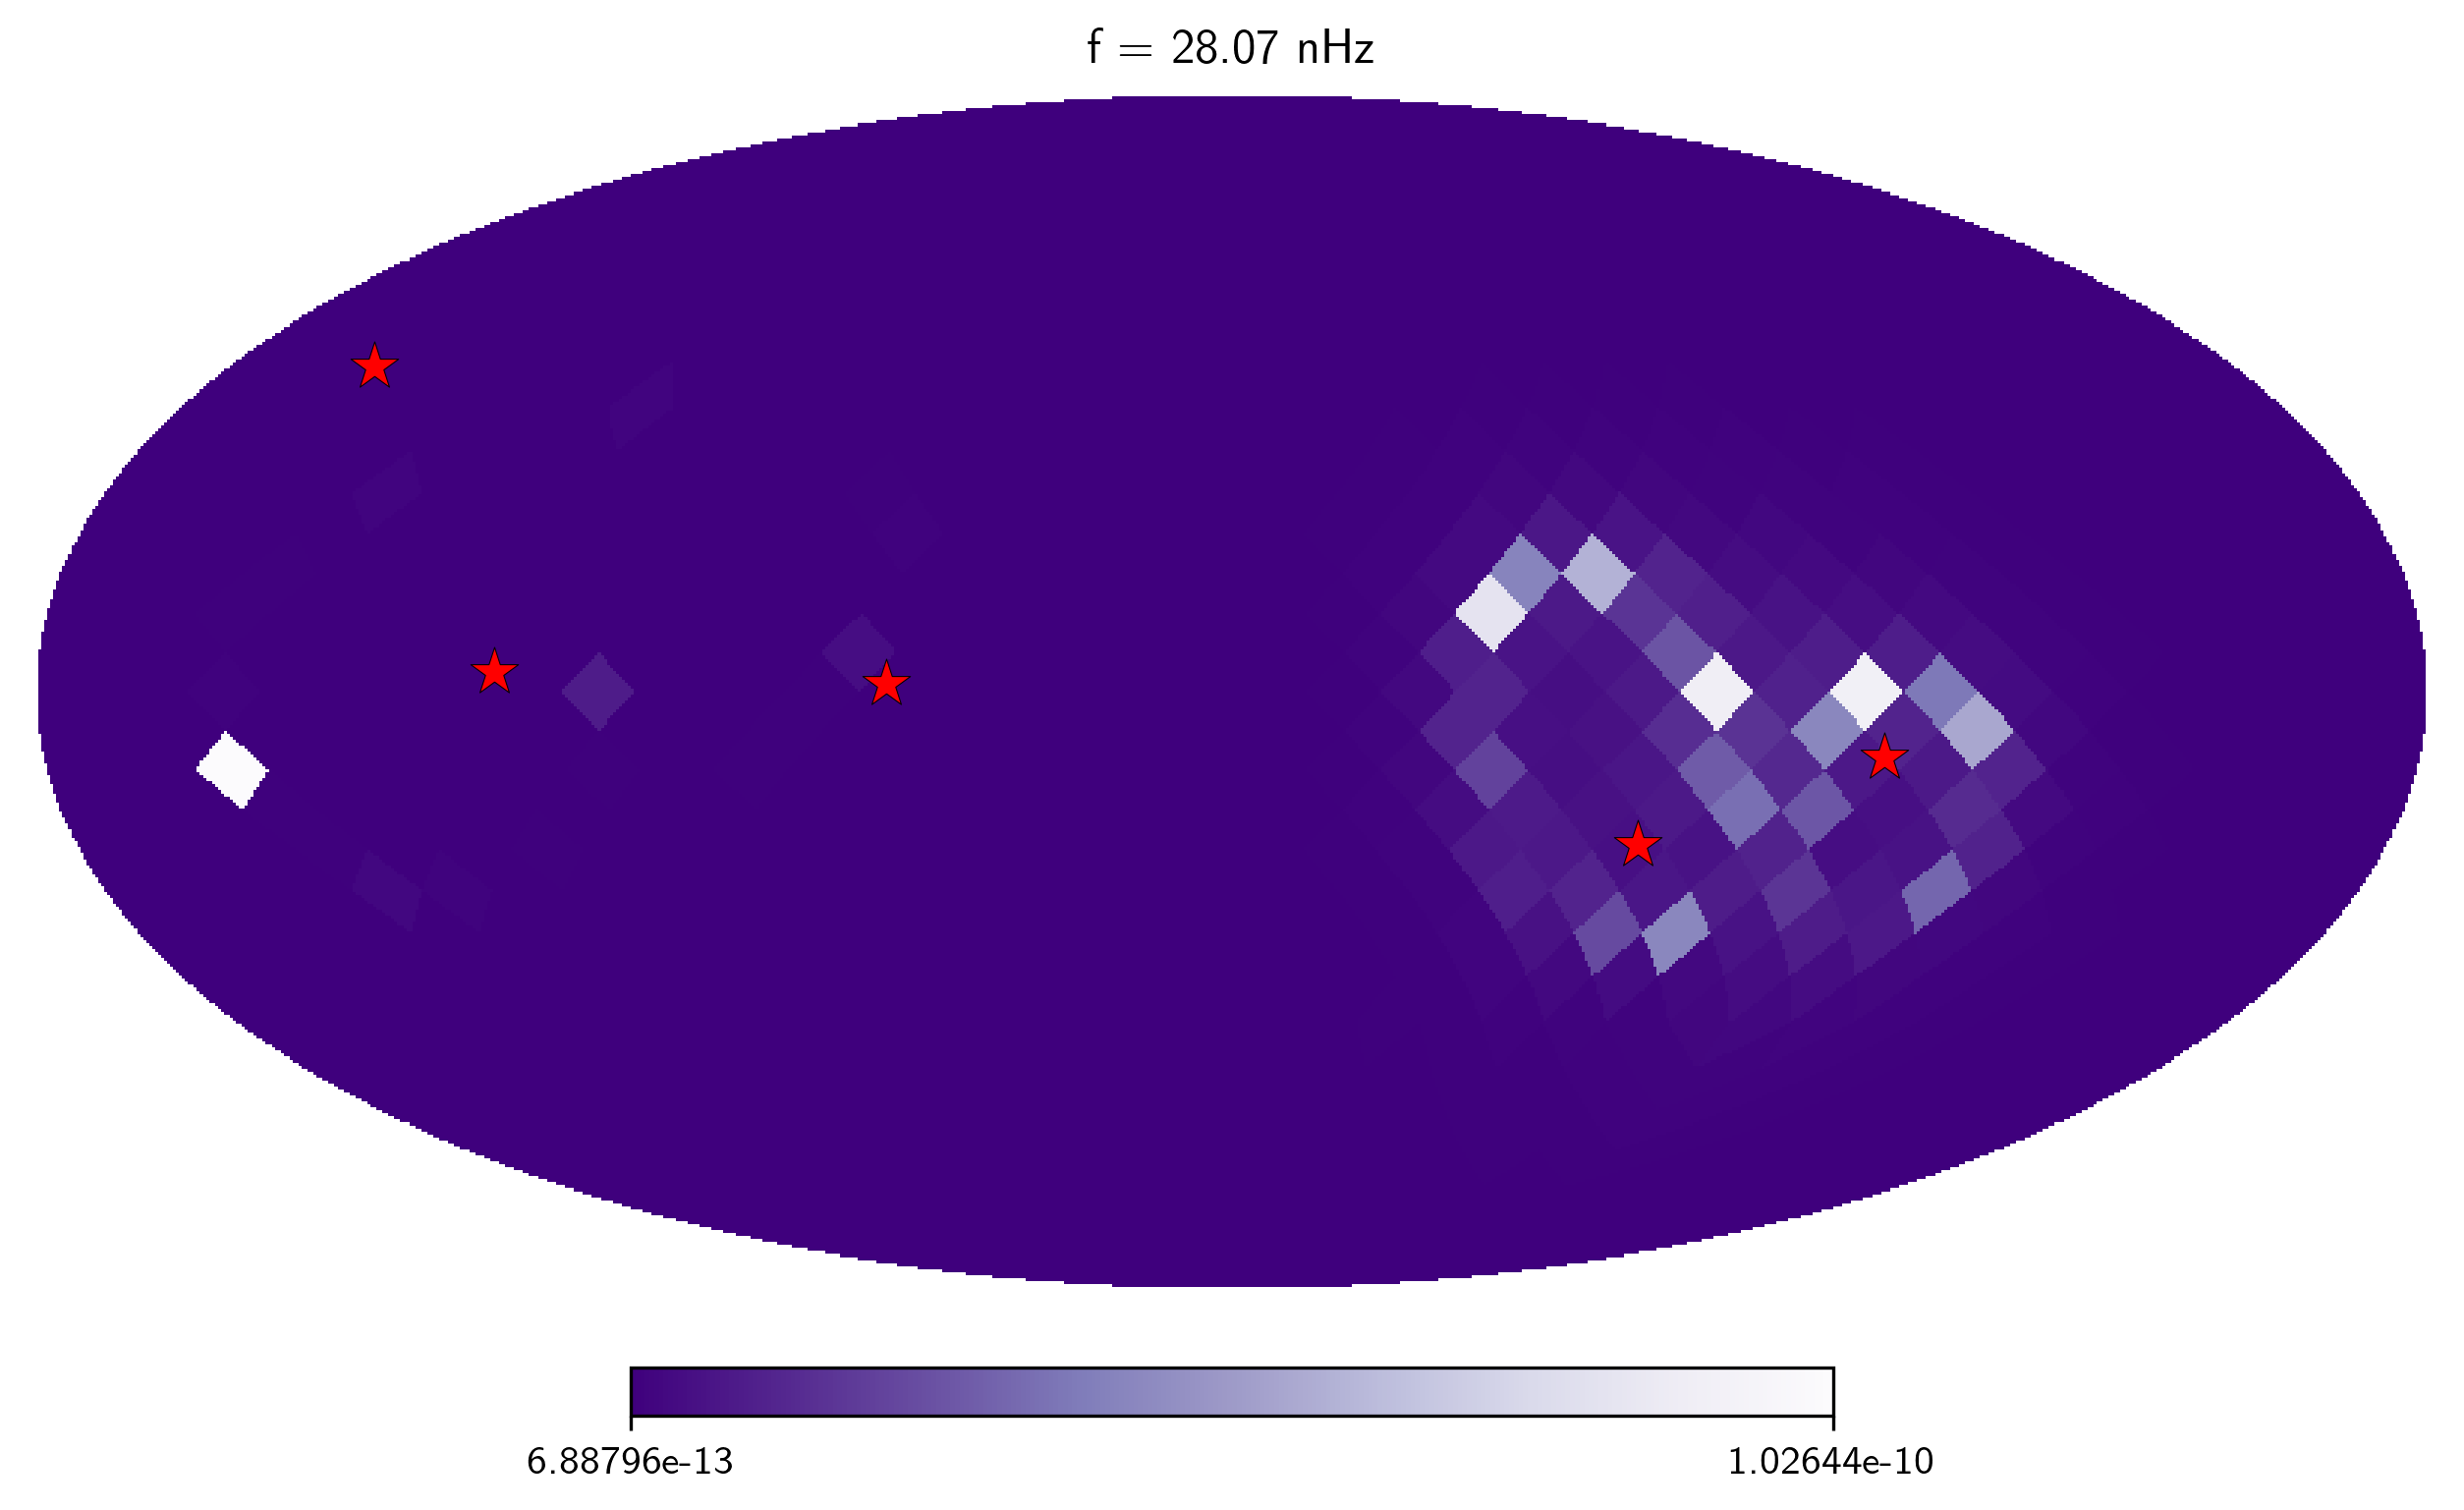

In [31]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    h_c_pixel = ASM.h_c_aniso_pixel(idx)
    
    # Plot the map
    hp.mollview(h_c_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


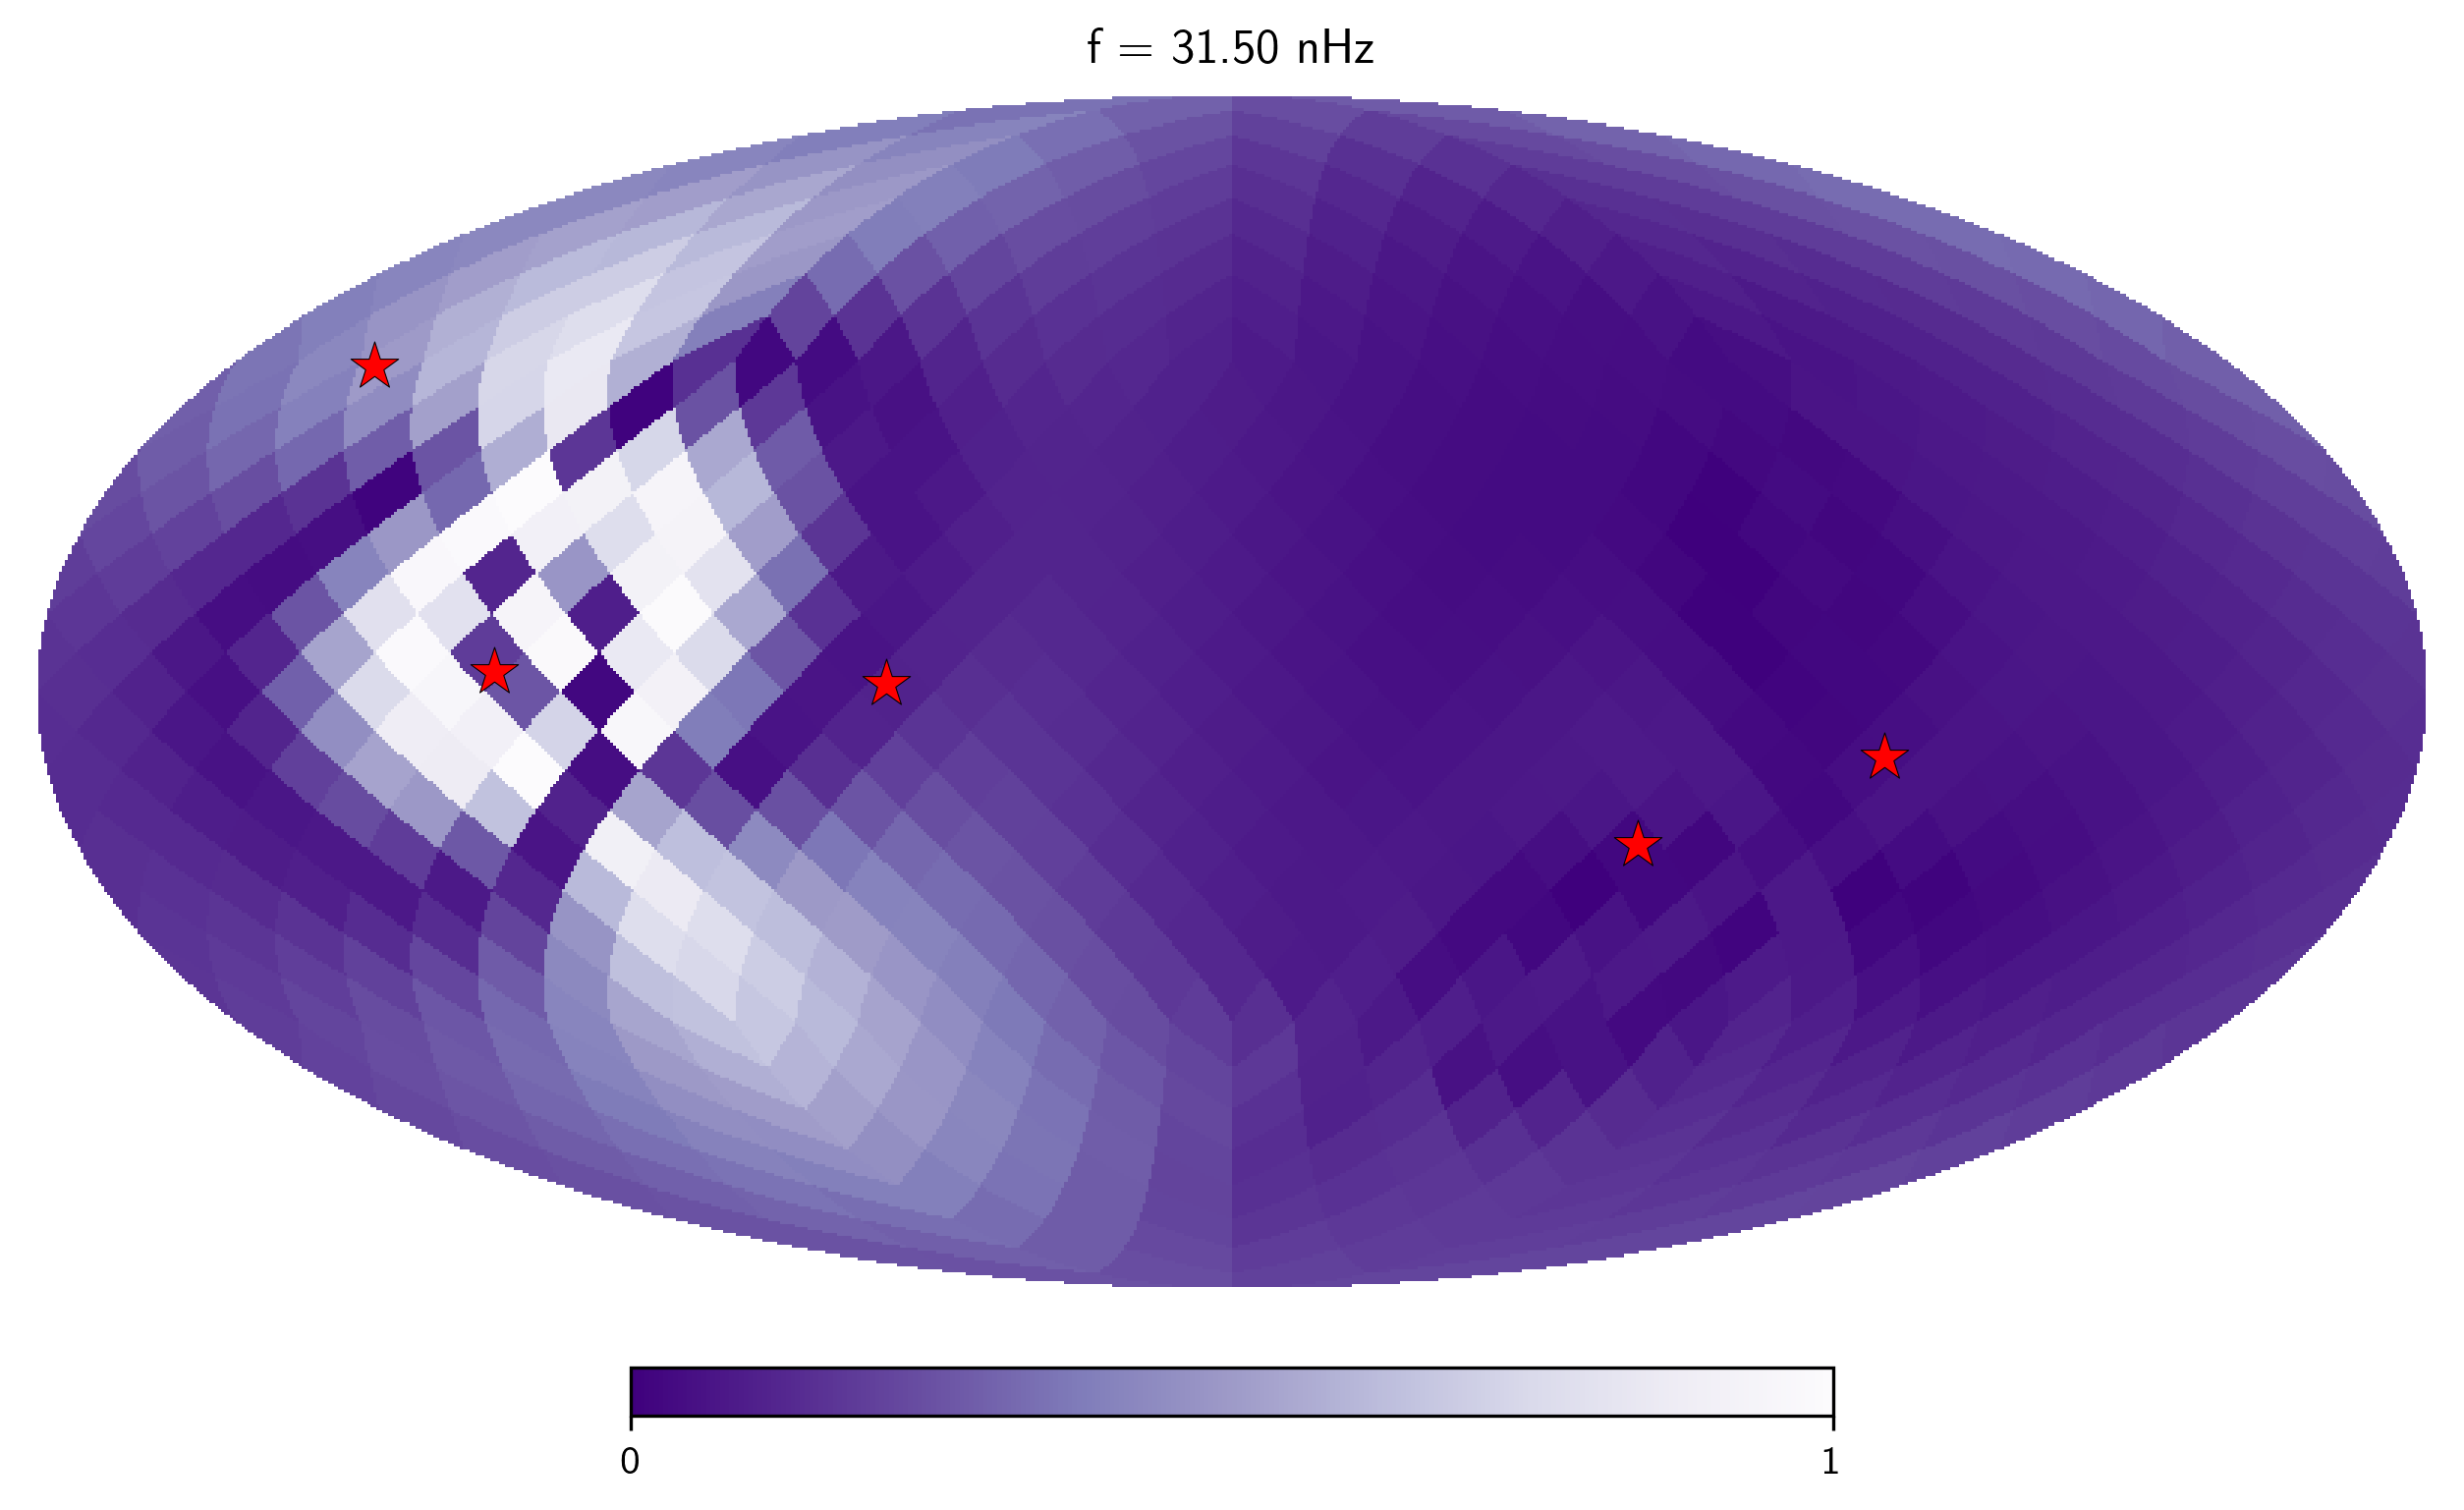

In [32]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, max_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {max_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



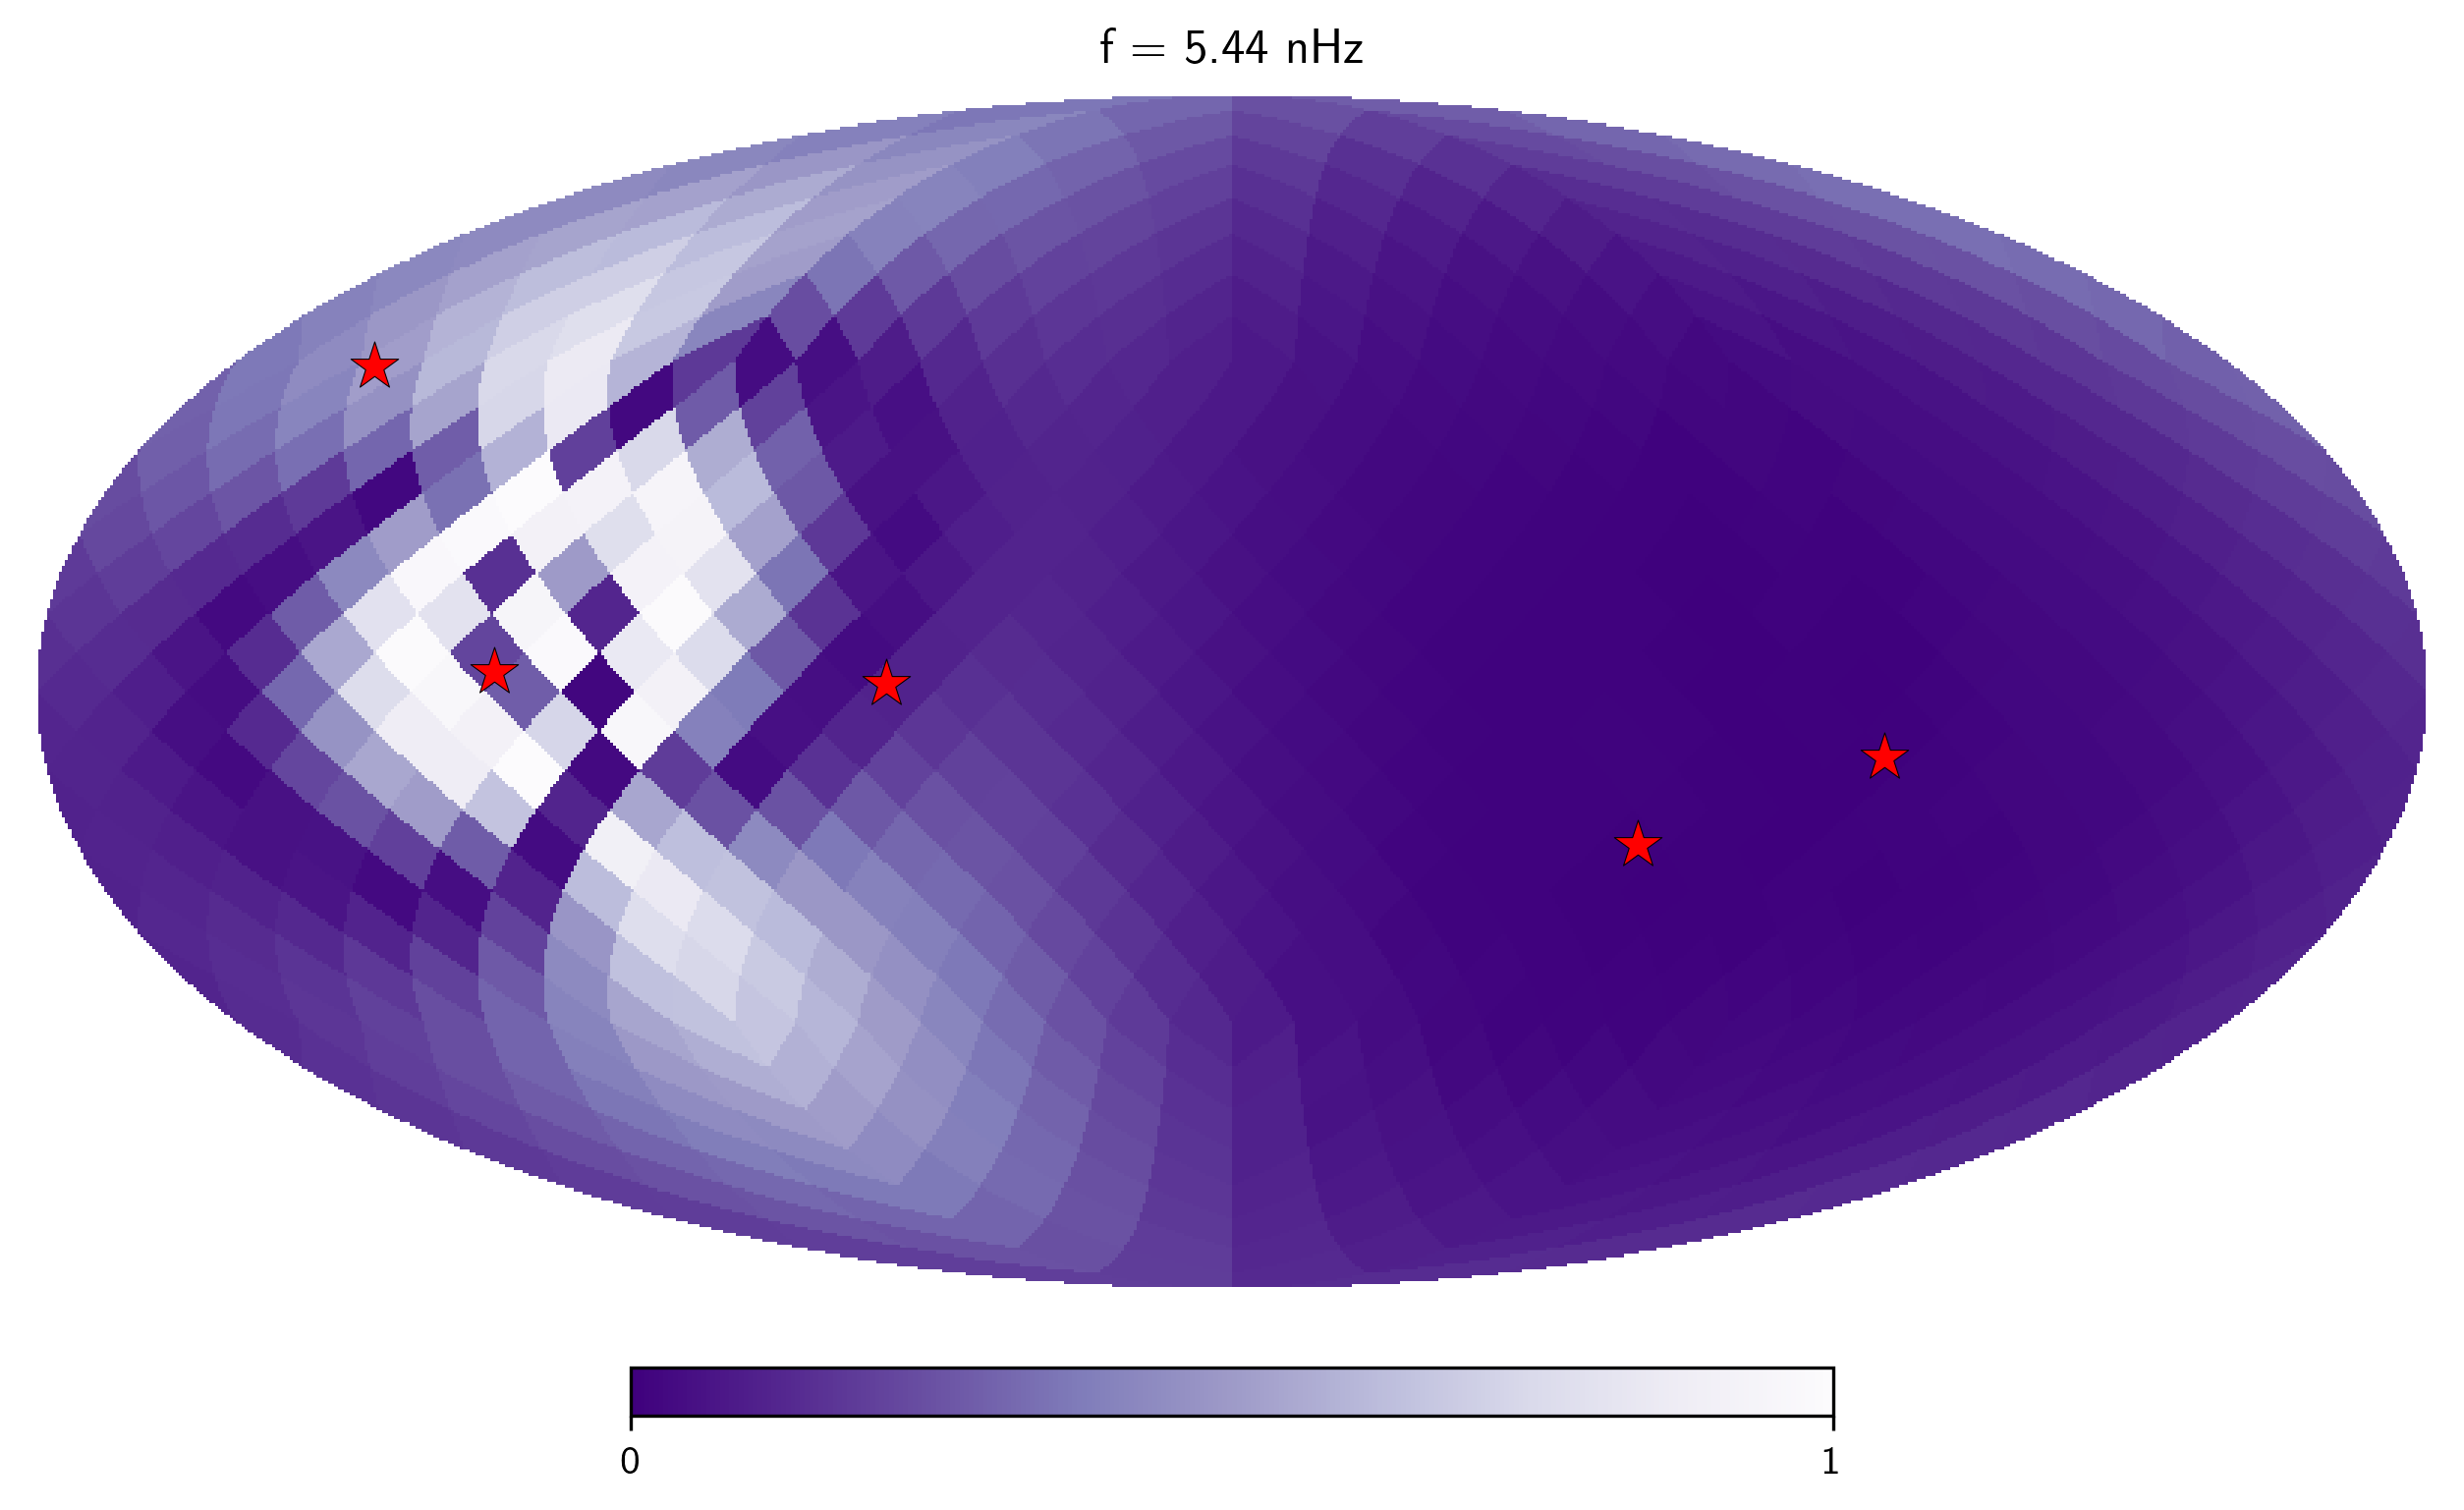

In [33]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, min_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {min_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



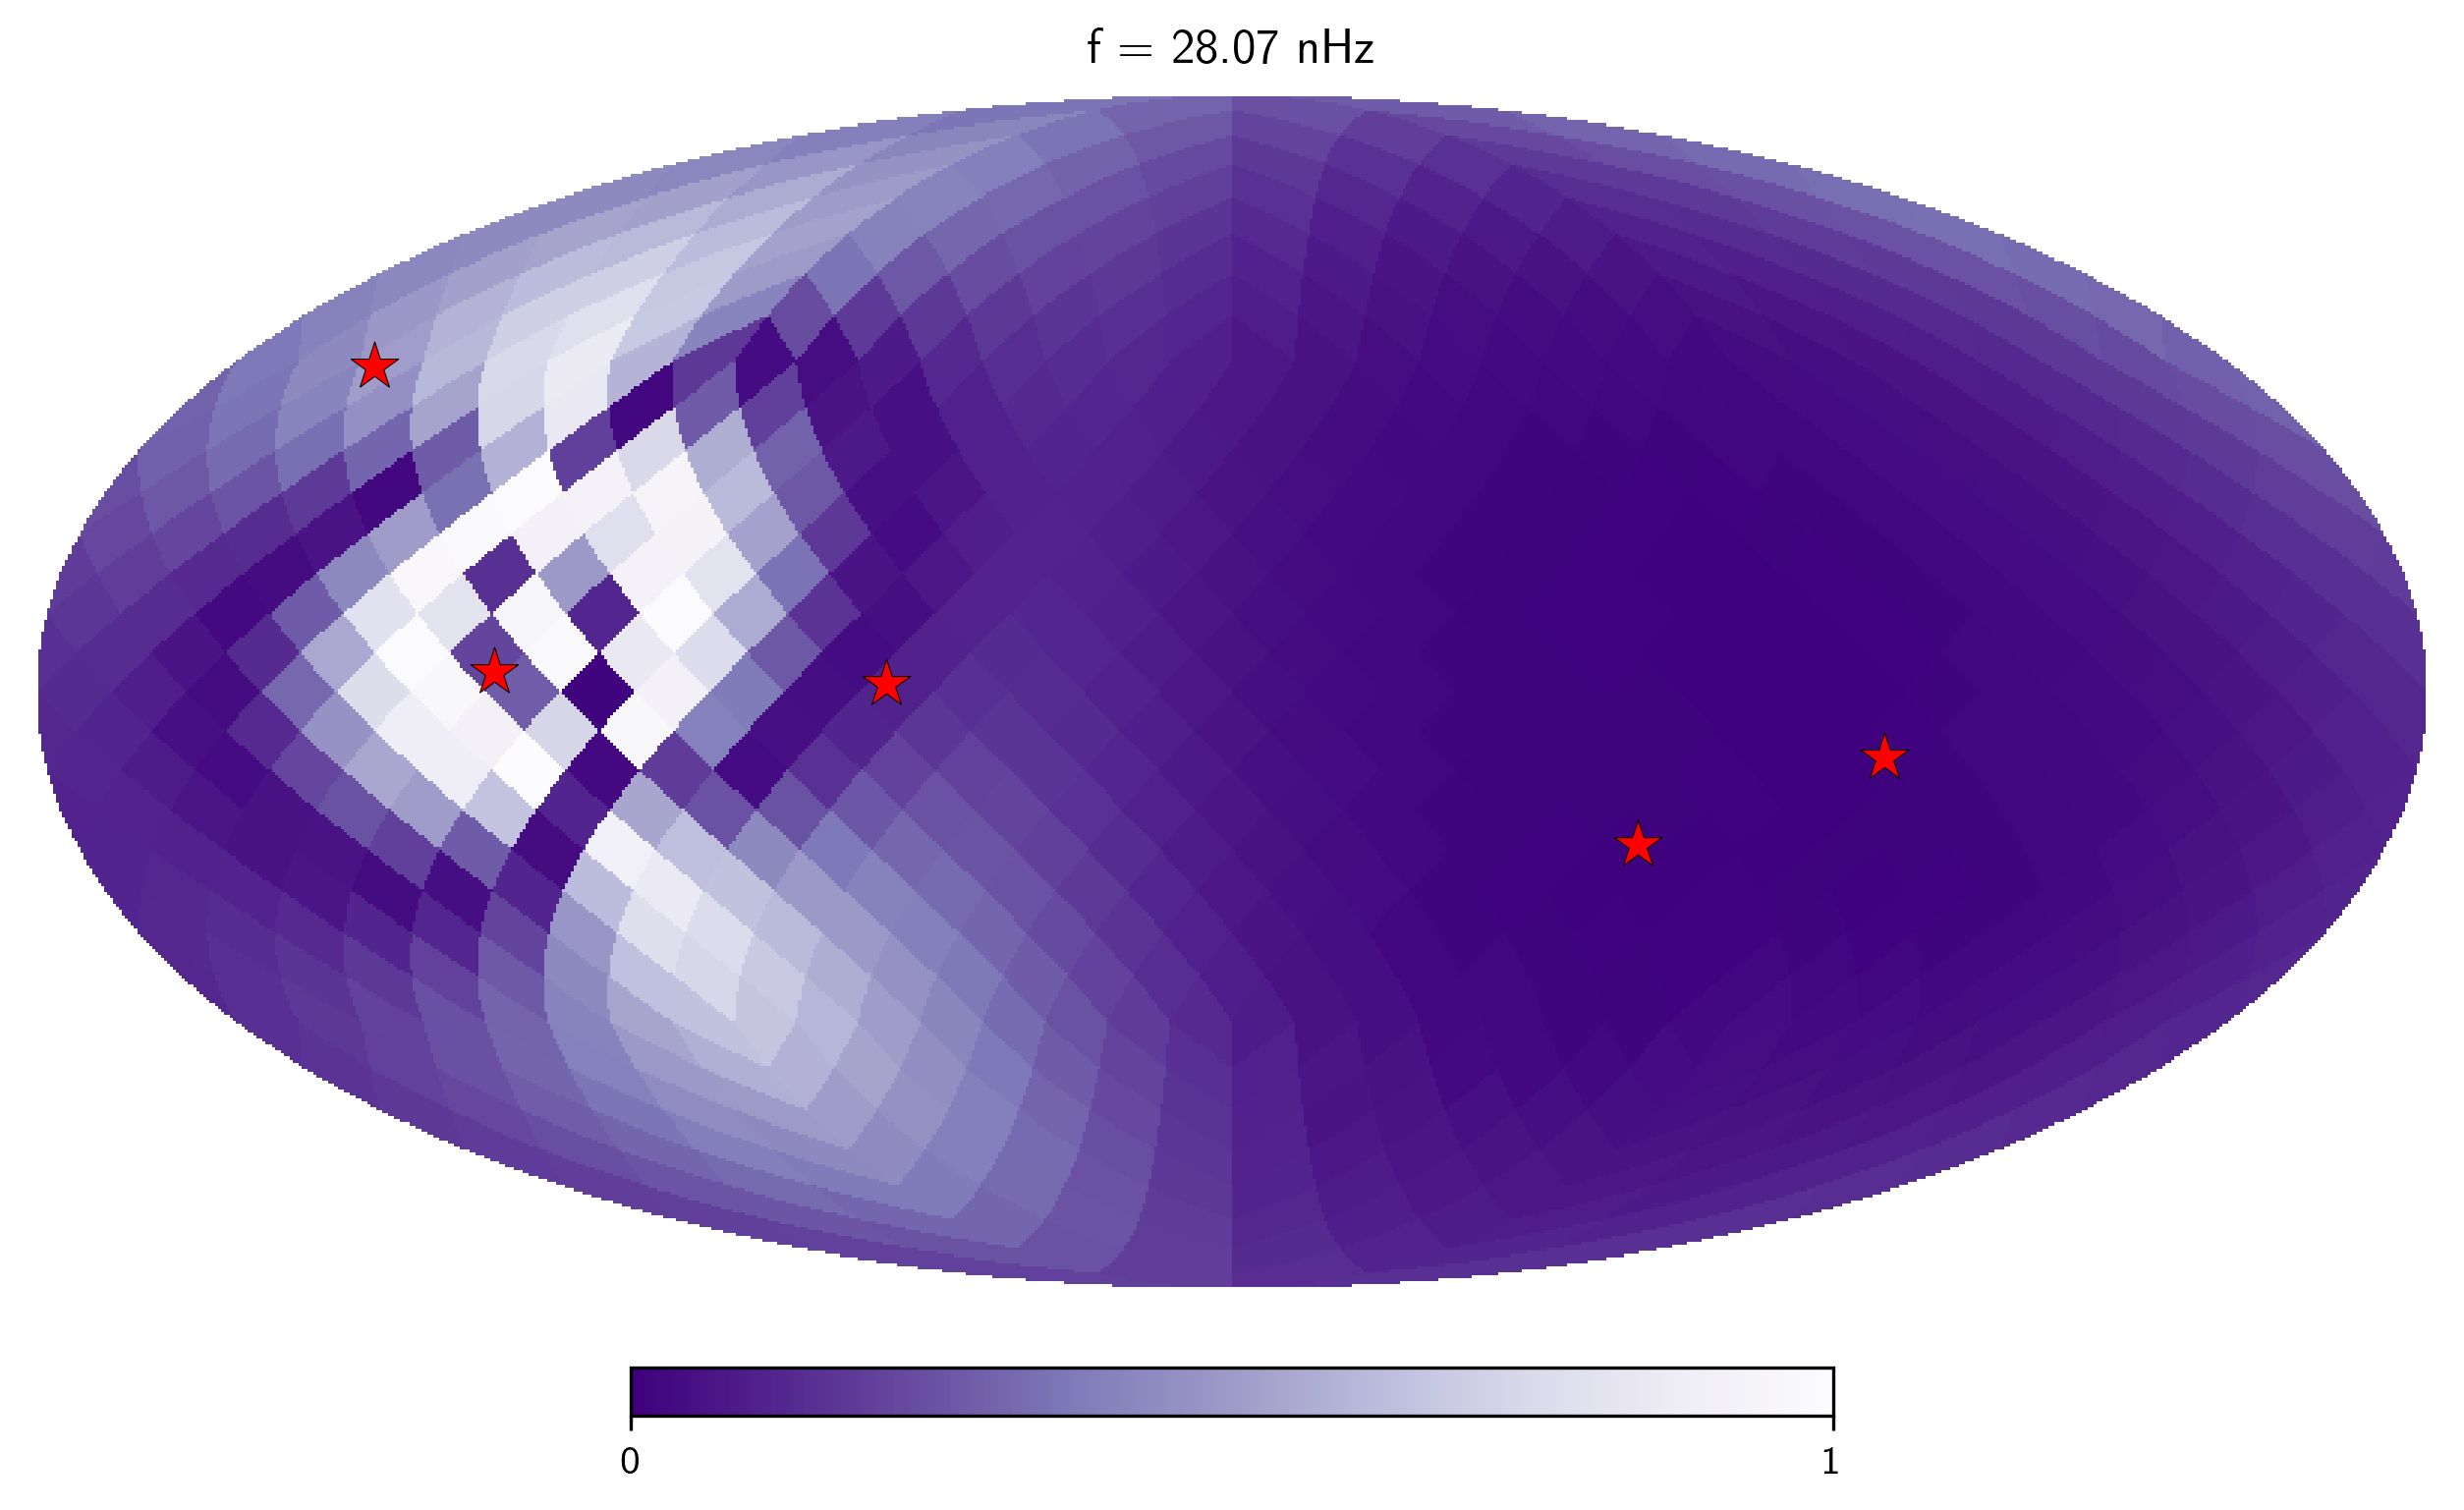

In [34]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, median_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {median_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



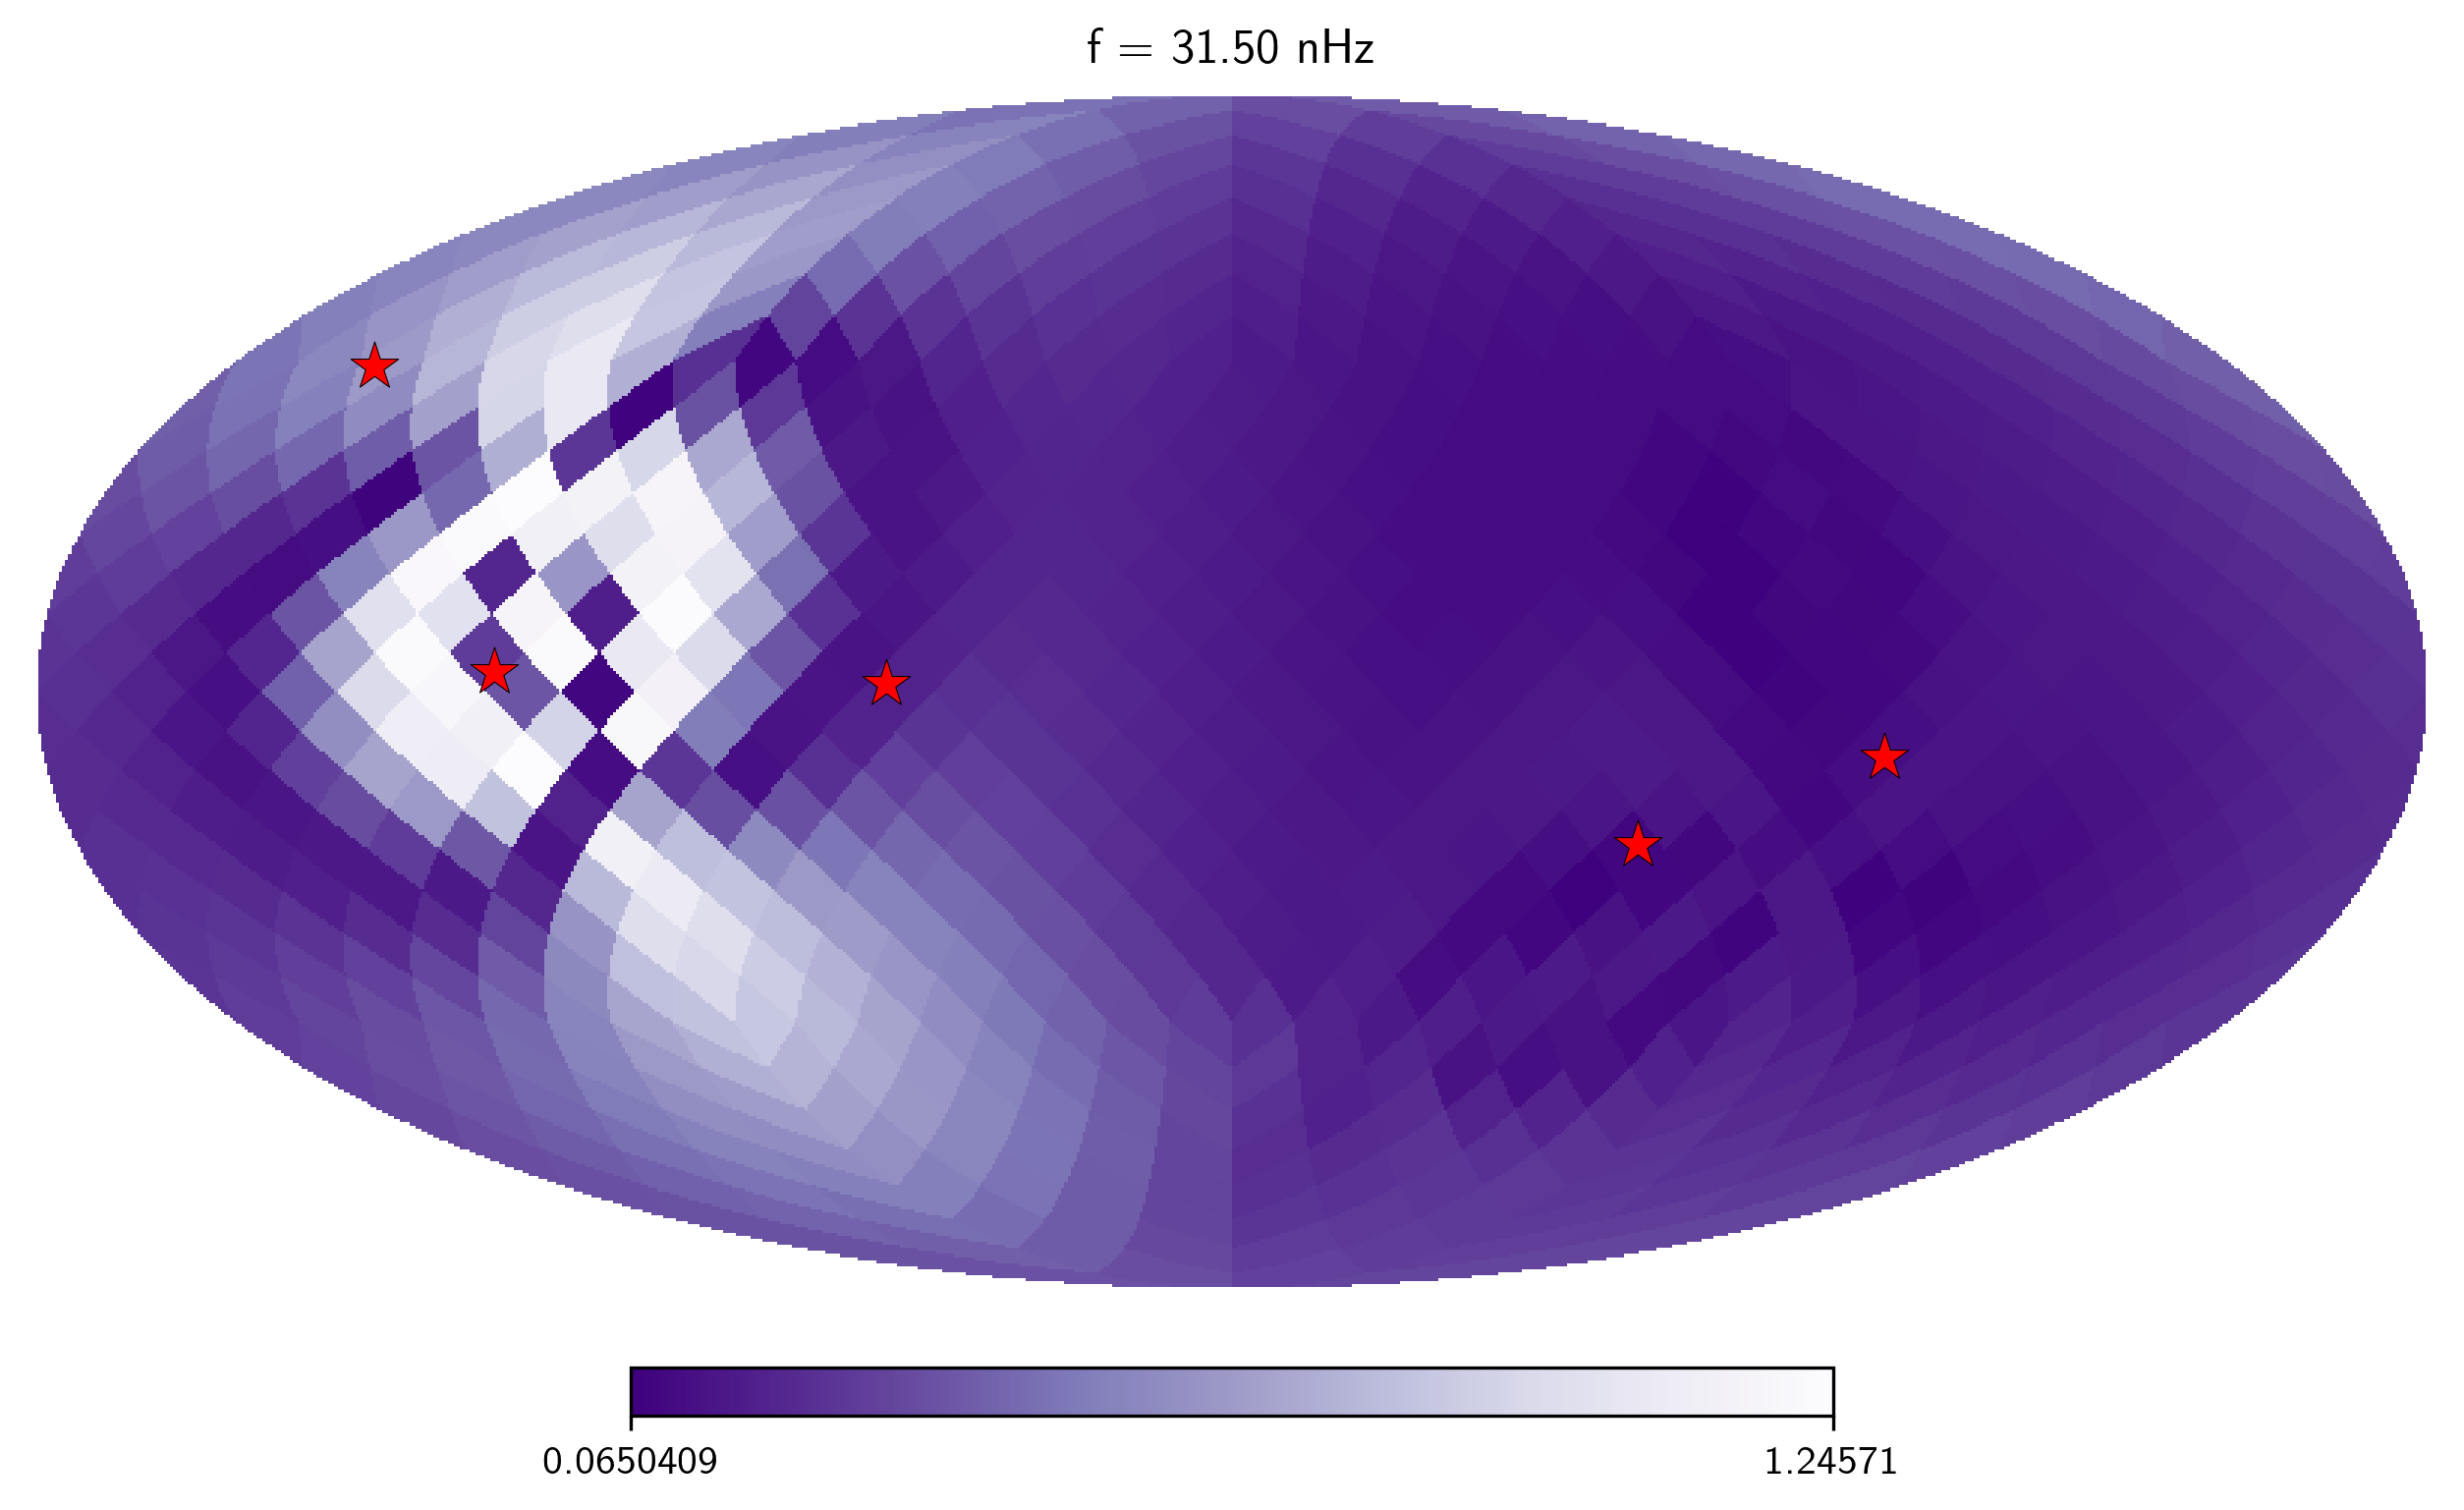

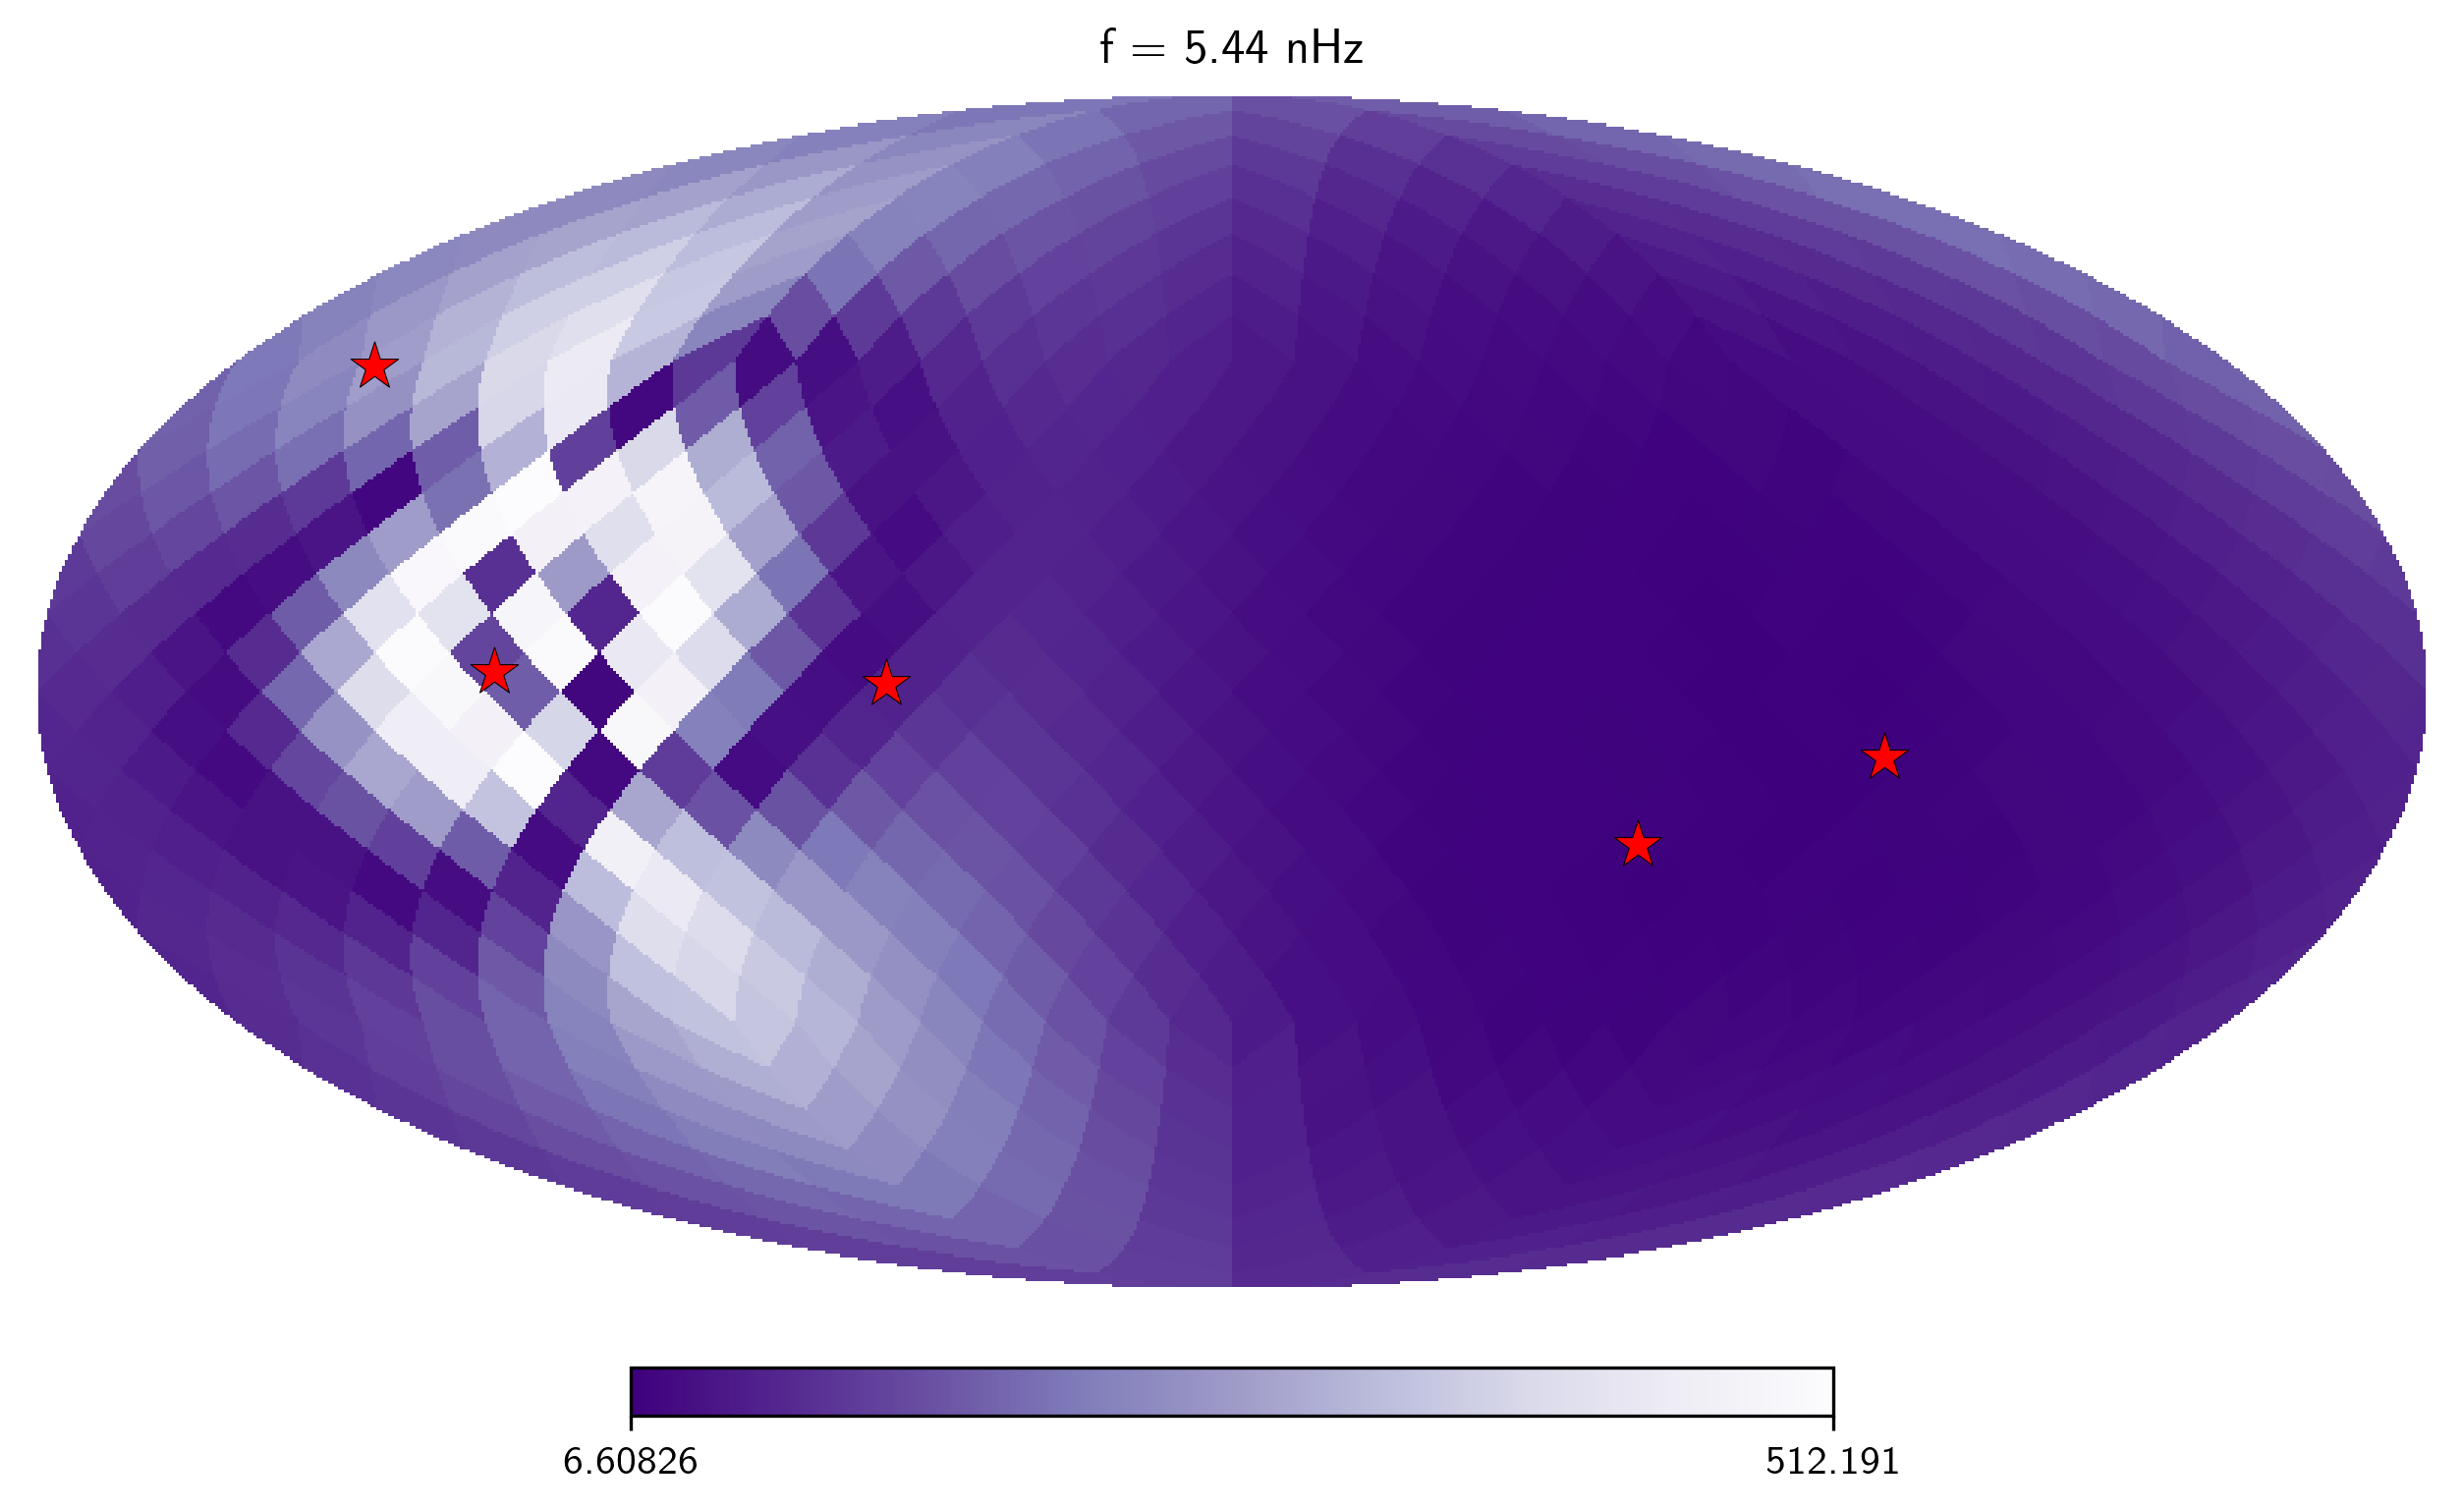

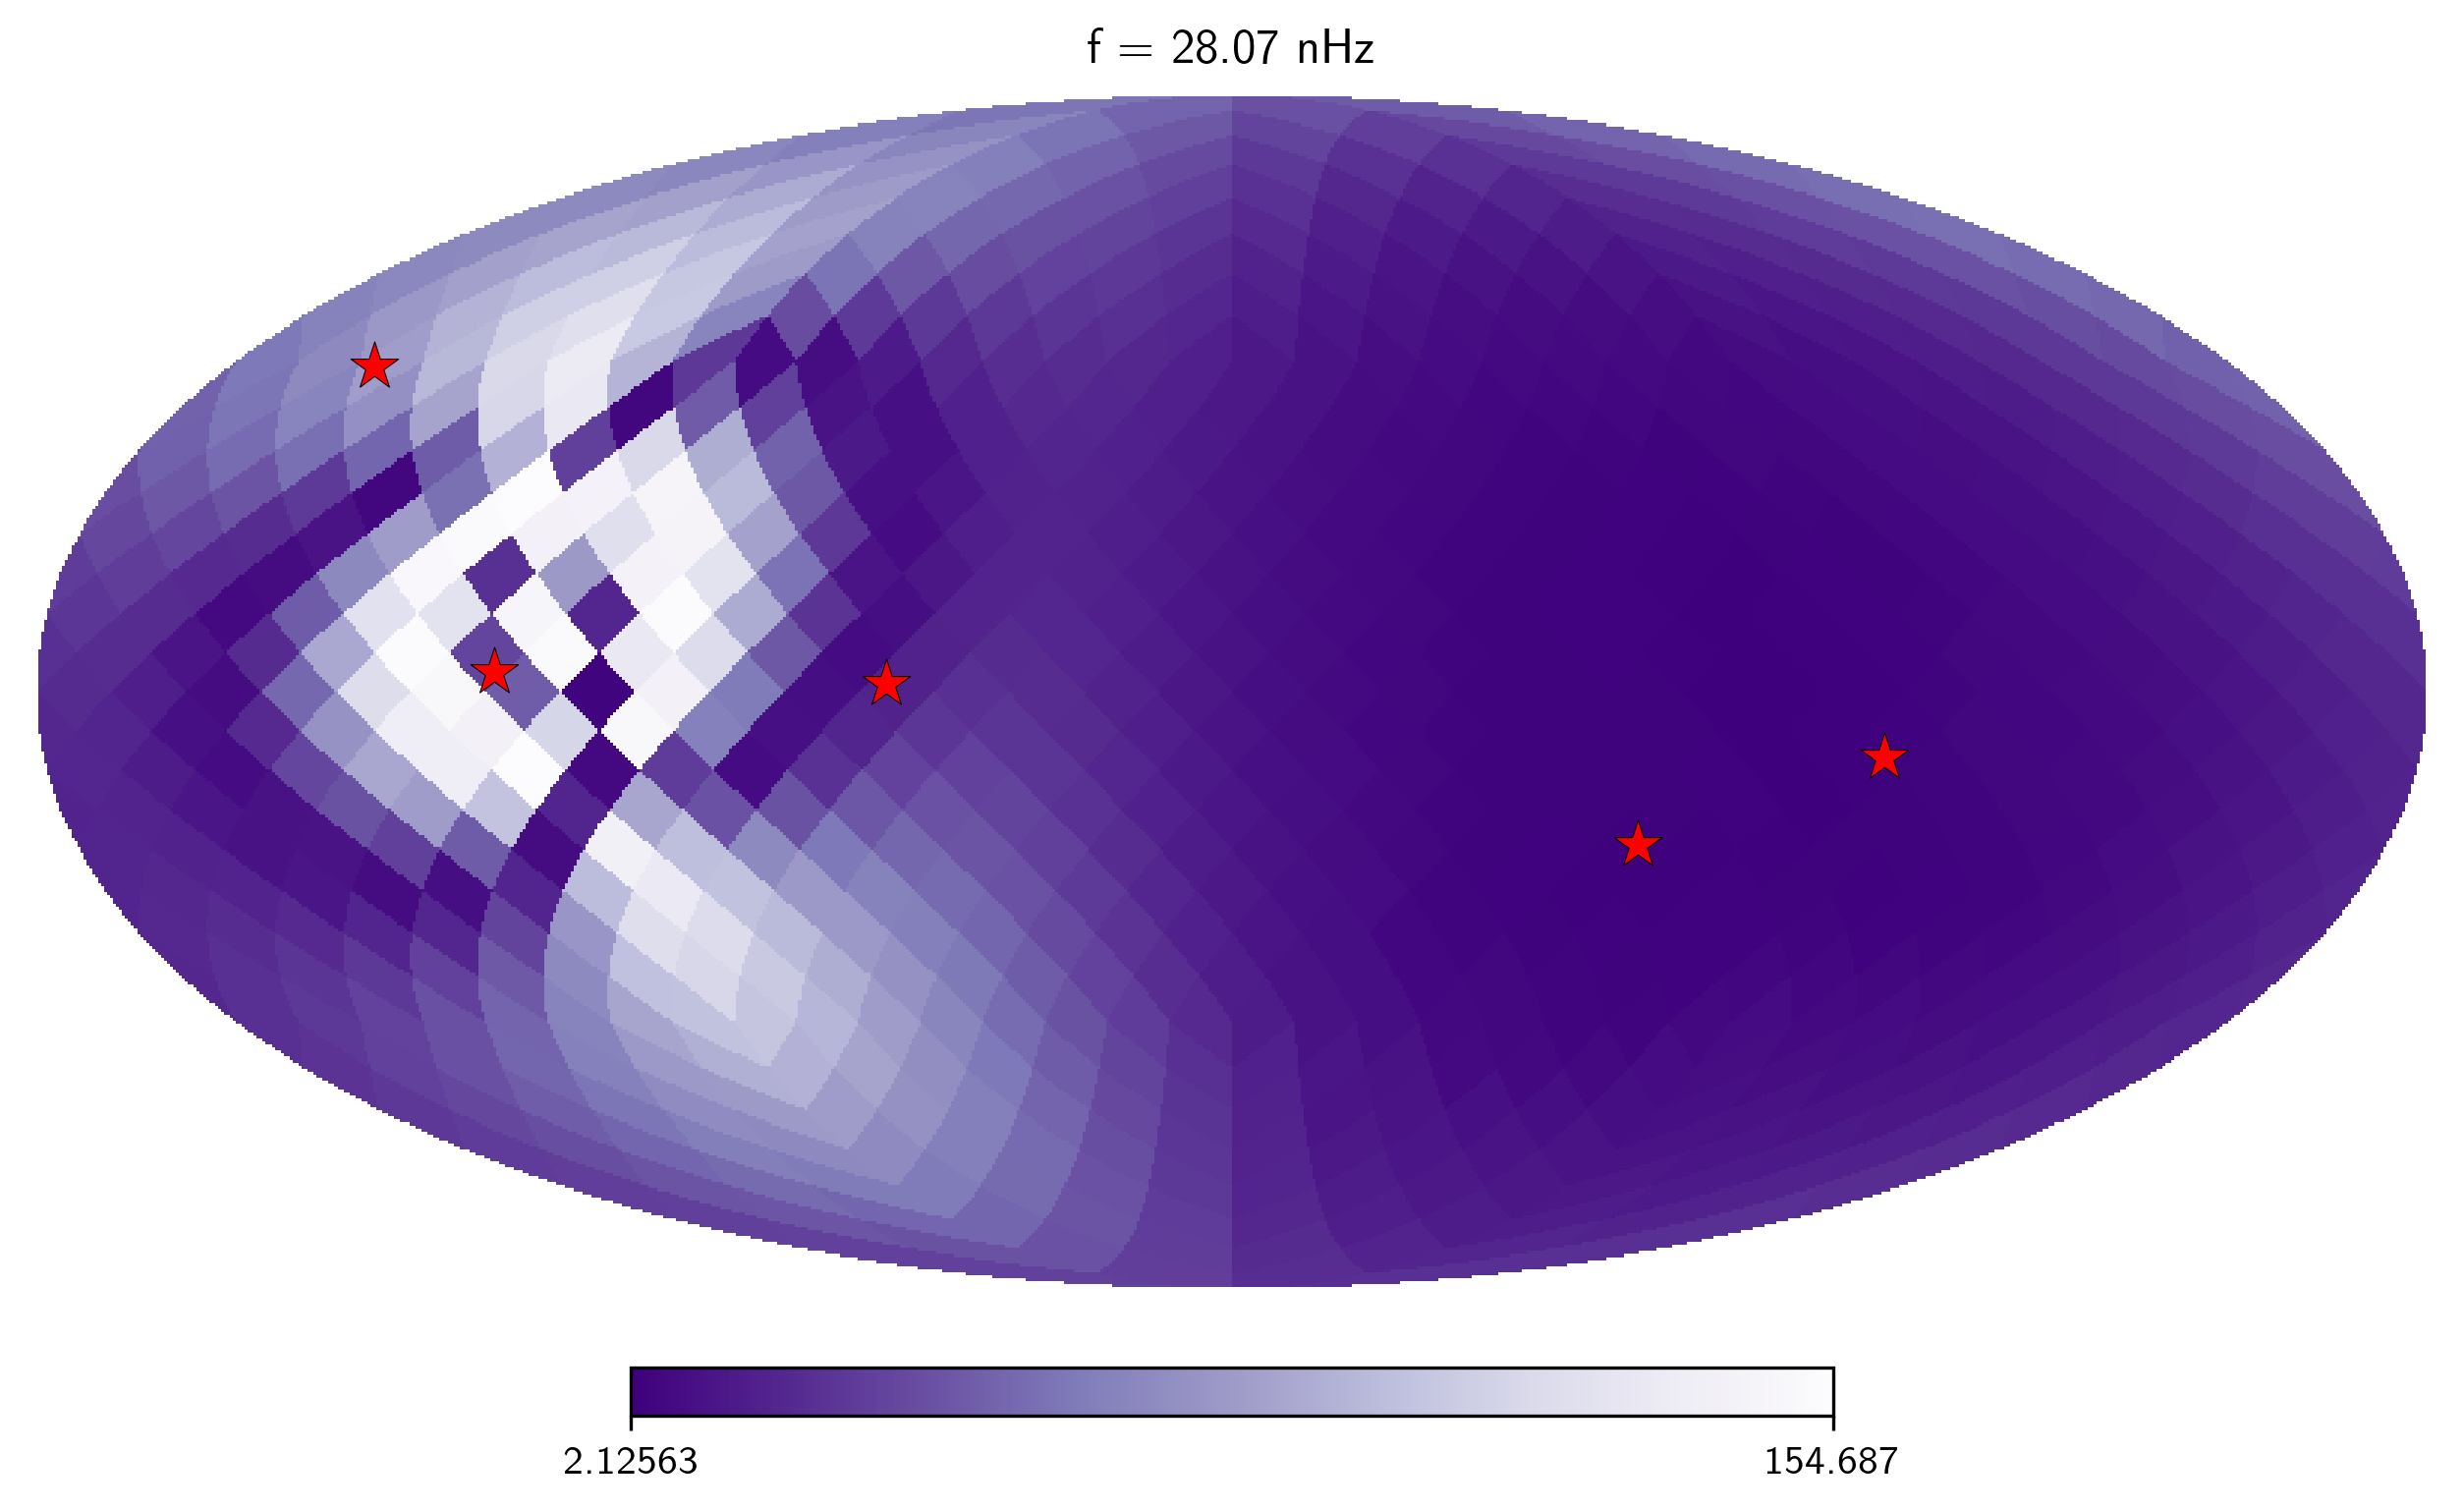

In [35]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    M_kk_pixel = np.sqrt(ASM.M_kk[:, idx])/Tspan
    
    # Plot the map
    hp.mollview(M_kk_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


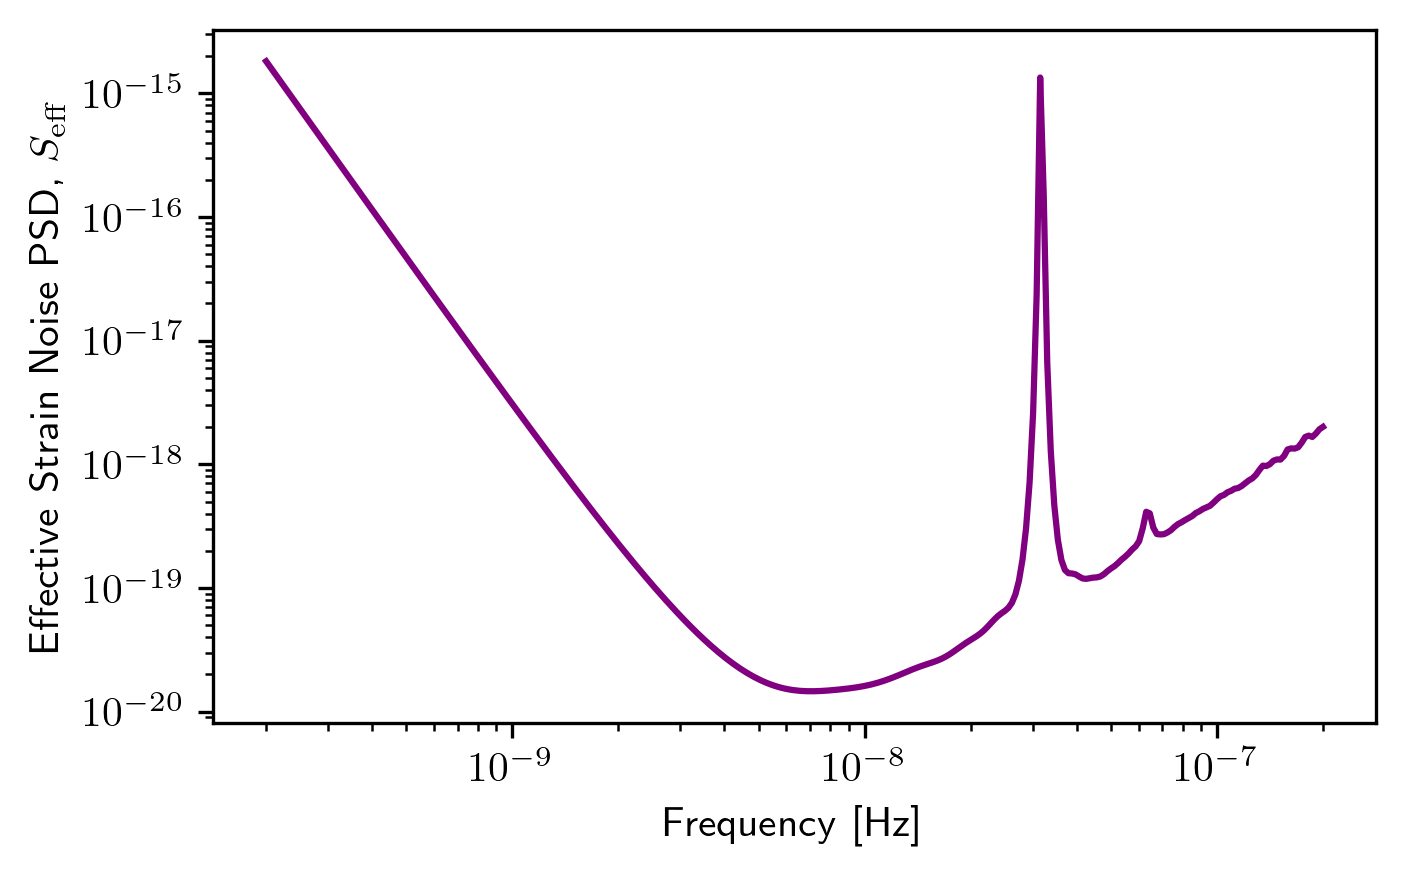

In [36]:
plt.loglog(spectra_15yr[0].freqs,ASM.S_eff_aniso, color='purple', label='NG 15yr')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
plt.show()

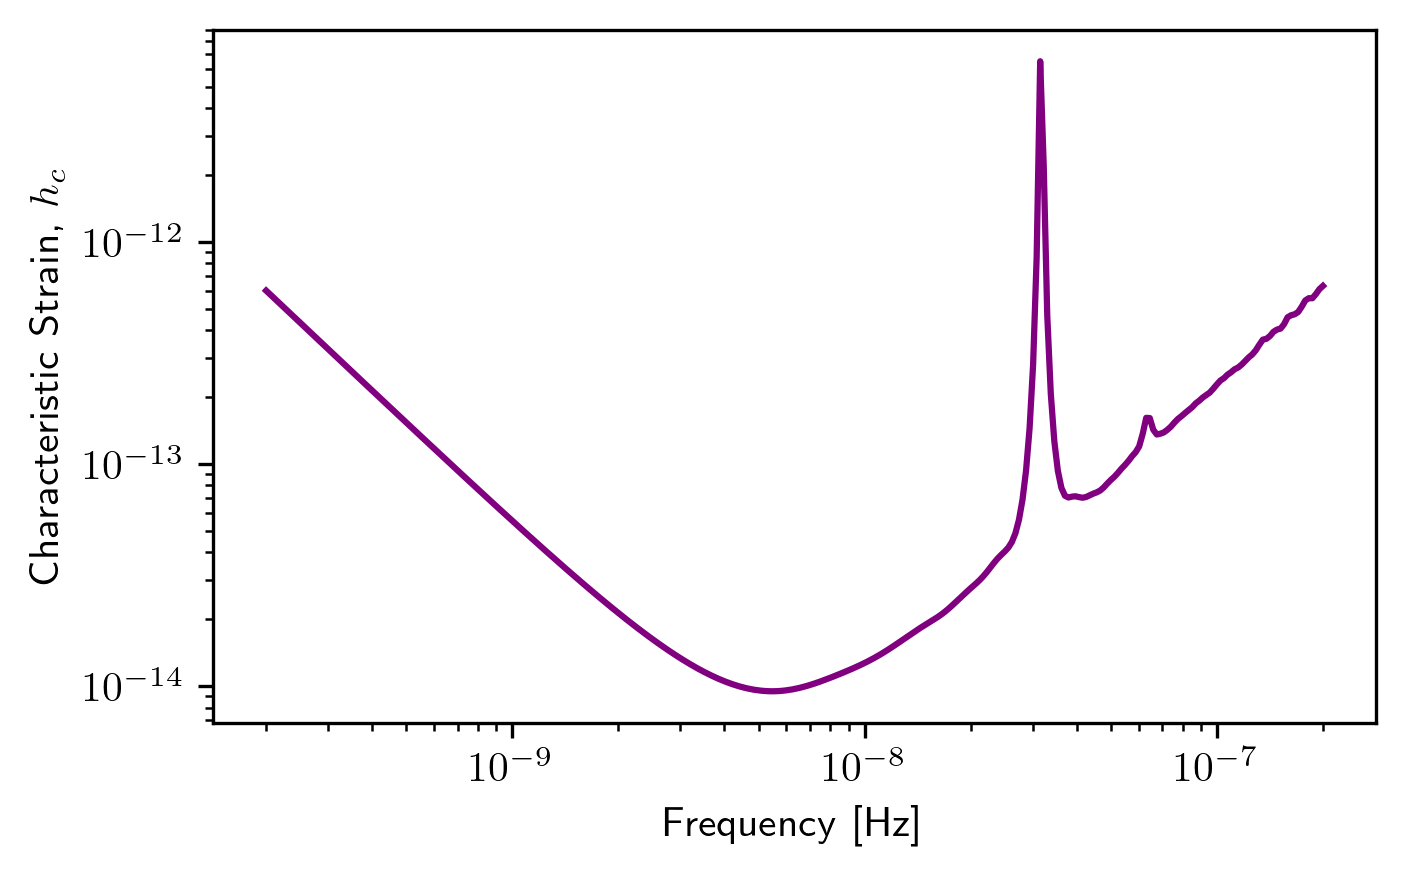

In [37]:
plt.loglog(spectra_15yr[0].freqs,ASM.h_c_aniso, color='purple', label='NG 15yr')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

## Forecasted pulsars from Jeremy

In [38]:
datadir_forecast = '/Users/oliverda/Documents/NANOGrav/Anisotropy/gpta_psrs_40yrs_v2/'

In [39]:
spectra_forecast = []
file_count = 0
max_files = 500  # Number of files to load

for filename in os.listdir(datadir_forecast):
    if filename.endswith('.pkl'):
        file_path = os.path.join(datadir_forecast, filename)
        with open(file_path, 'rb') as file:
            # print(f"Loading file: {filename}")
            spec_forecast = pickle.load(file)
            spectra_forecast.append(spec_forecast)
            # print(f"PSR: {spec_forecast.name}")
            file_count += 1    
            # Clear the loaded file from memory
            del spec_forecast   
            if file_count >= max_files:
                break  # Stop after loading the specified number of files

In [40]:
spectra_forecast[0].__dir__()

['toas',
 'toaerrs',
 'phi',
 'theta',
 'name',
 'pdist',
 'A_rn',
 'alpha',
 'N',
 'designmatrix',
 '_G',
 '__module__',
 '__firstlineno__',
 '__doc__',
 '__init__',
 'filter_data',
 'change_cadence',
 'change_sigma',
 'G',
 '__static_attributes__',
 '__dict__',
 '__weakref__',
 '__new__',
 '__repr__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__getstate__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [41]:
max_time = max(
    (np.max(spectra.toas) - np.min(spectra.toas)) / (24 * 3600 * 365.25)
    for spectra in spectra_forecast
)
print(max_time)
max_time_secs = max(
    (np.max(spectra.toas) - np.min(spectra.toas))
    for spectra in spectra_forecast
)
print(max_time_secs)
print(1/max_time_secs)

40.00998050872093
1262618960.9020116
7.920045801352473e-10


In [42]:
#Use the healpy functions to get the sky coordinates
NSIDE = 8
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta_gw, phi_gw = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [43]:
freqs = np.logspace(np.log10(spectra_15yr[0].freqs[0]),np.log10(spectra_15yr[0].freqs[-1]),300)
spectra = []
for p in spectra_forecast:
    sp = hsen.Spectrum(p, freqs=freqs)
    sp.NcalInv
    spectra.append(sp)

In [44]:
ASM=haniso.Anisotropy(spectra,theta_gw, phi_gw, NPIX=NPIX)

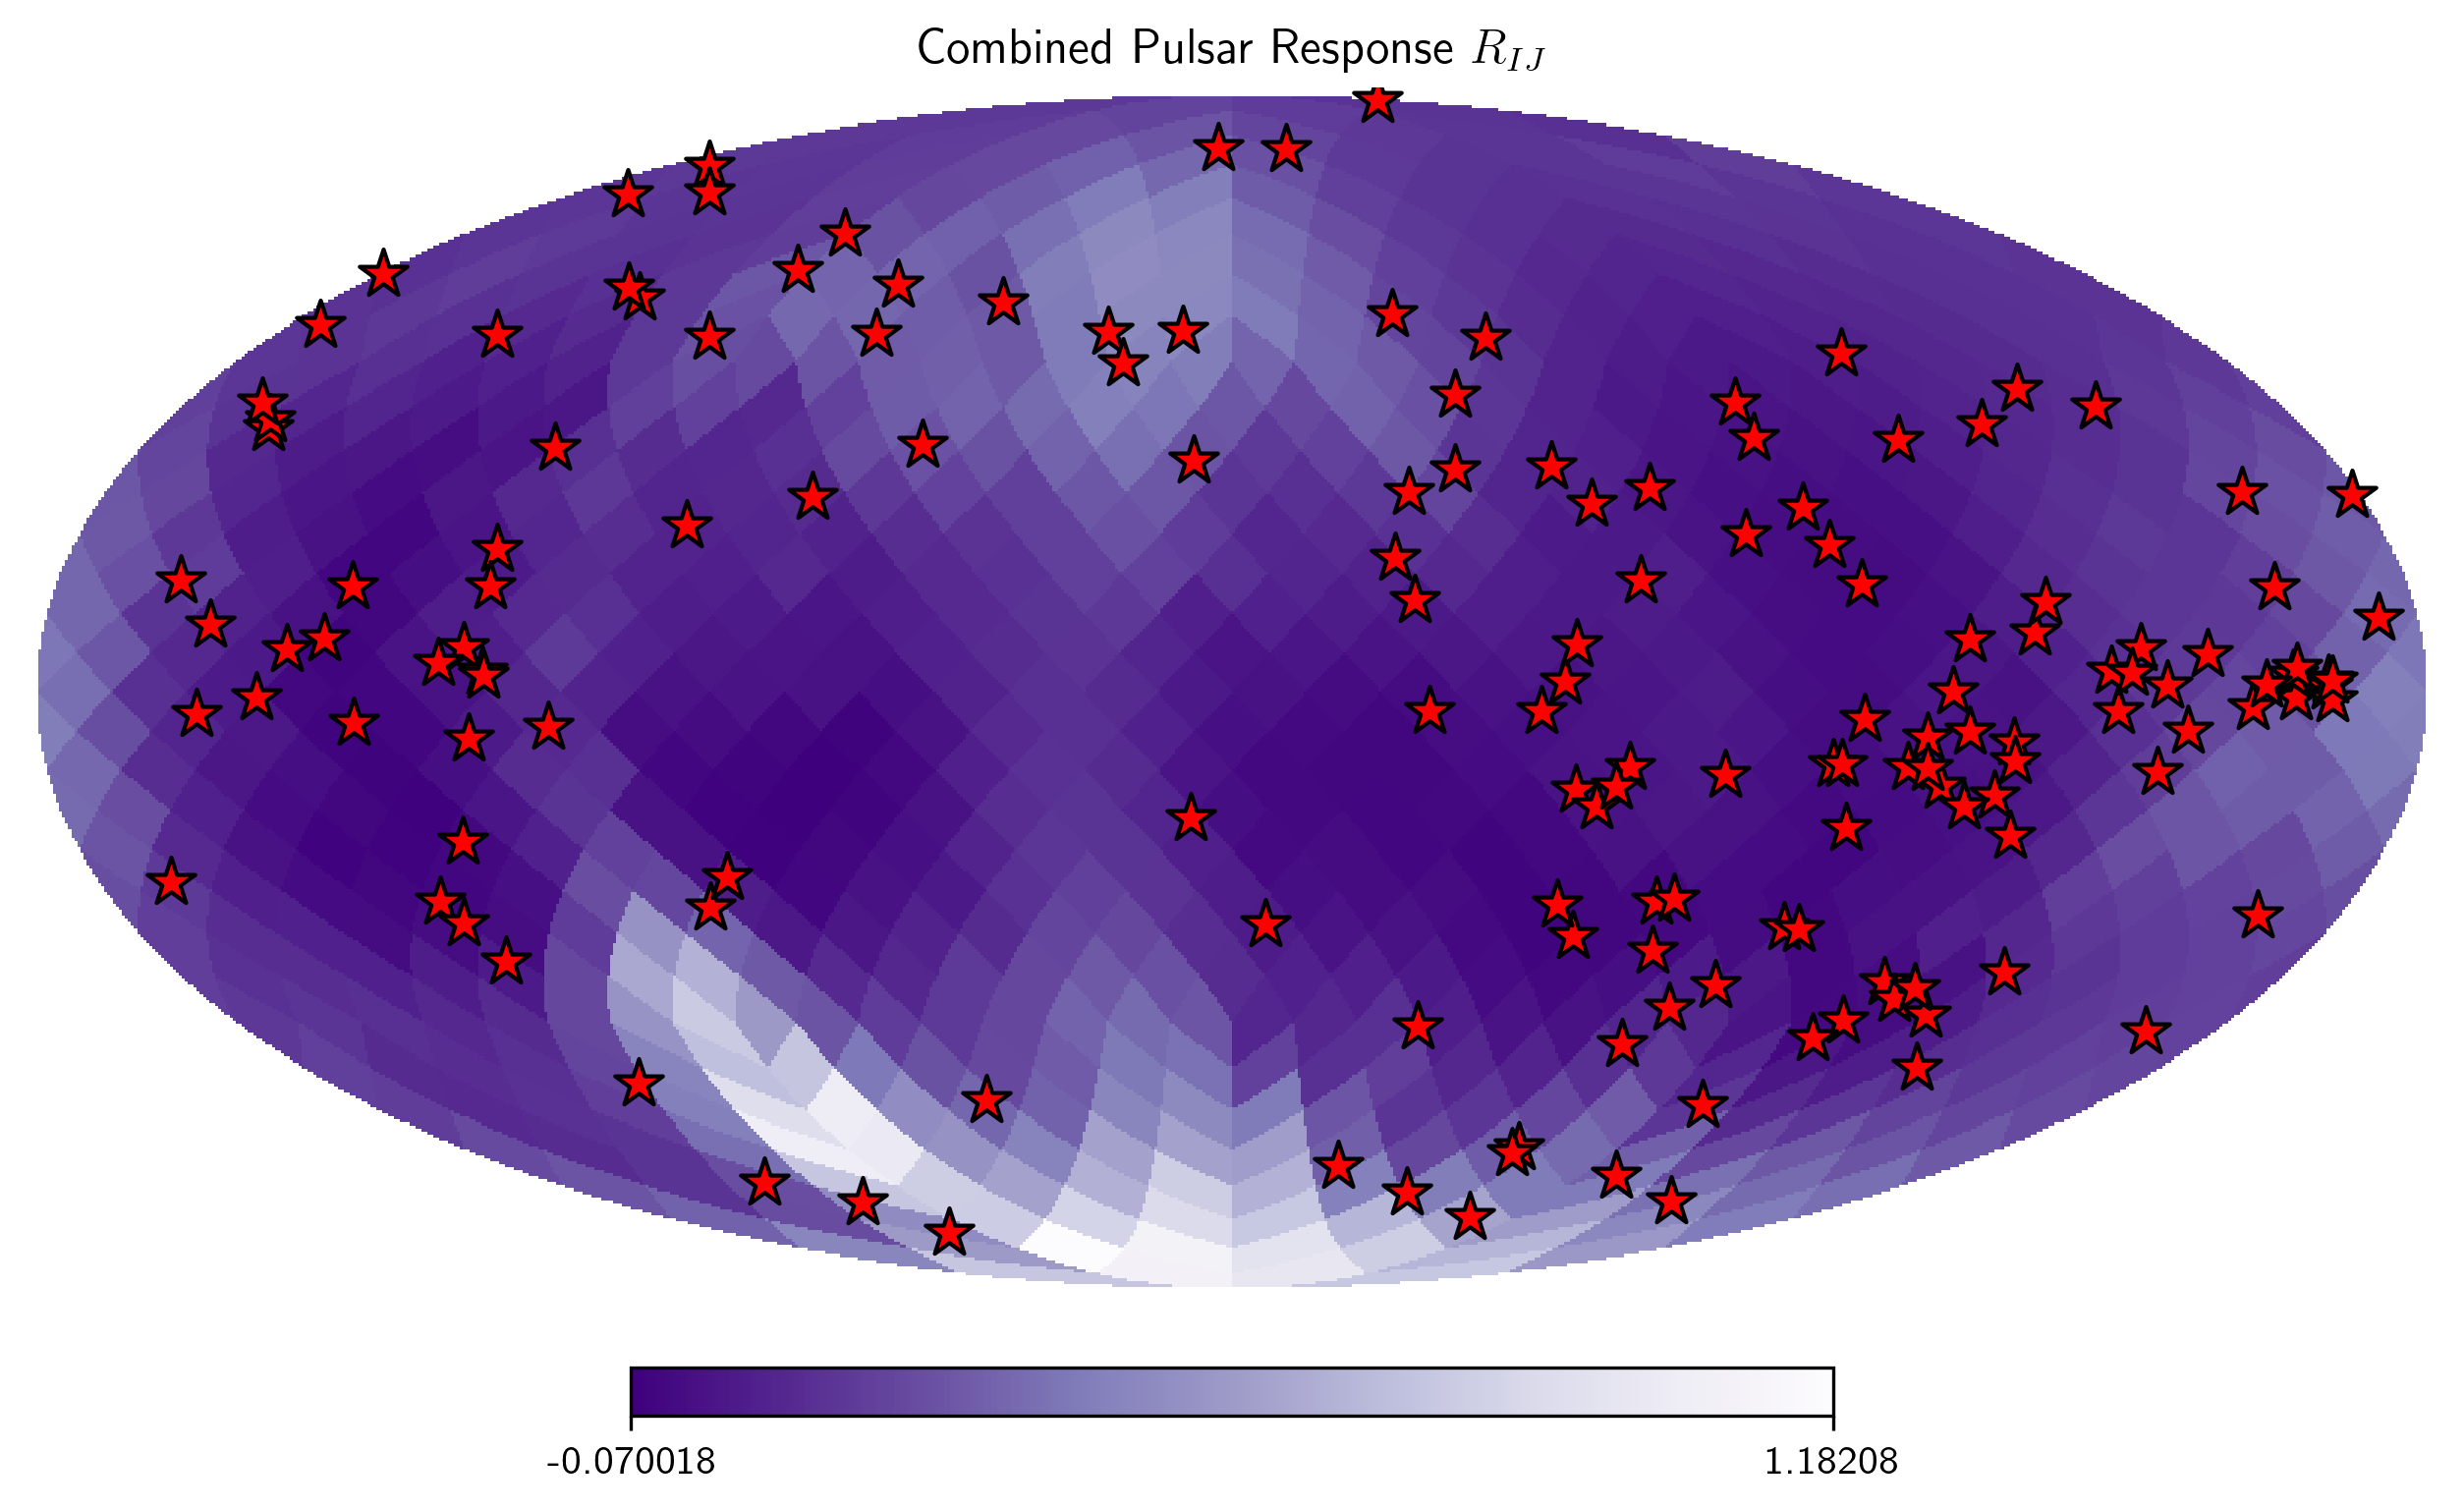

In [45]:
# Summing all pair responses
combined_response = ASM.R_IJ.sum(axis=0)

vmin, vmax = np.min(combined_response), np.max(combined_response)
hp.mollview(combined_response, title="Combined Pulsar Response $R_{IJ}$", 
            cmap='Purples_r', hold=False, rot=(180,0,0))

# Highlight all pulsar positions

hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', s=150, rot=(180,0,0))
plt.savefig(savedir+'combined_forecast.png')
plt.show()


In [46]:
Tspan = max(
    (np.max(spectra.toas) - np.min(spectra.toas))
    for spectra in spectra_forecast
)

In [47]:
max_value = np.max(ASM.h_c_aniso)
max_index = np.argmax(ASM.h_c_aniso)
max_freq = freqs[max_index]  # Corresponding frequency
print(f"Max value: {max_value}, Index: {max_index}, Frequency: {max_freq}")

min_value = np.min(ASM.h_c_aniso)
min_index = np.argmin(ASM.h_c_aniso)
min_freq = freqs[min_index]  # Corresponding frequency
print(f"Min value: {min_value}, Index: {min_index}, Frequency: {min_freq}")

median_value = np.median(ASM.h_c_aniso)
median_index = (np.abs(ASM.h_c_aniso - median_value)).argmin()
median_freq = freqs[median_index]  # Corresponding frequency
print(f"Median value: {median_value}, Index: {median_index}, Frequency: {median_freq}")

Max value: 1.161652019668848e-14, Index: 219, Frequency: 3.150318114183249e-08
Min value: 7.337940821845755e-17, Index: 113, Frequency: 2.7215057728486665e-09
Median value: 1.8723307026417214e-16, Index: 185, Frequency: 1.4362078185074715e-08


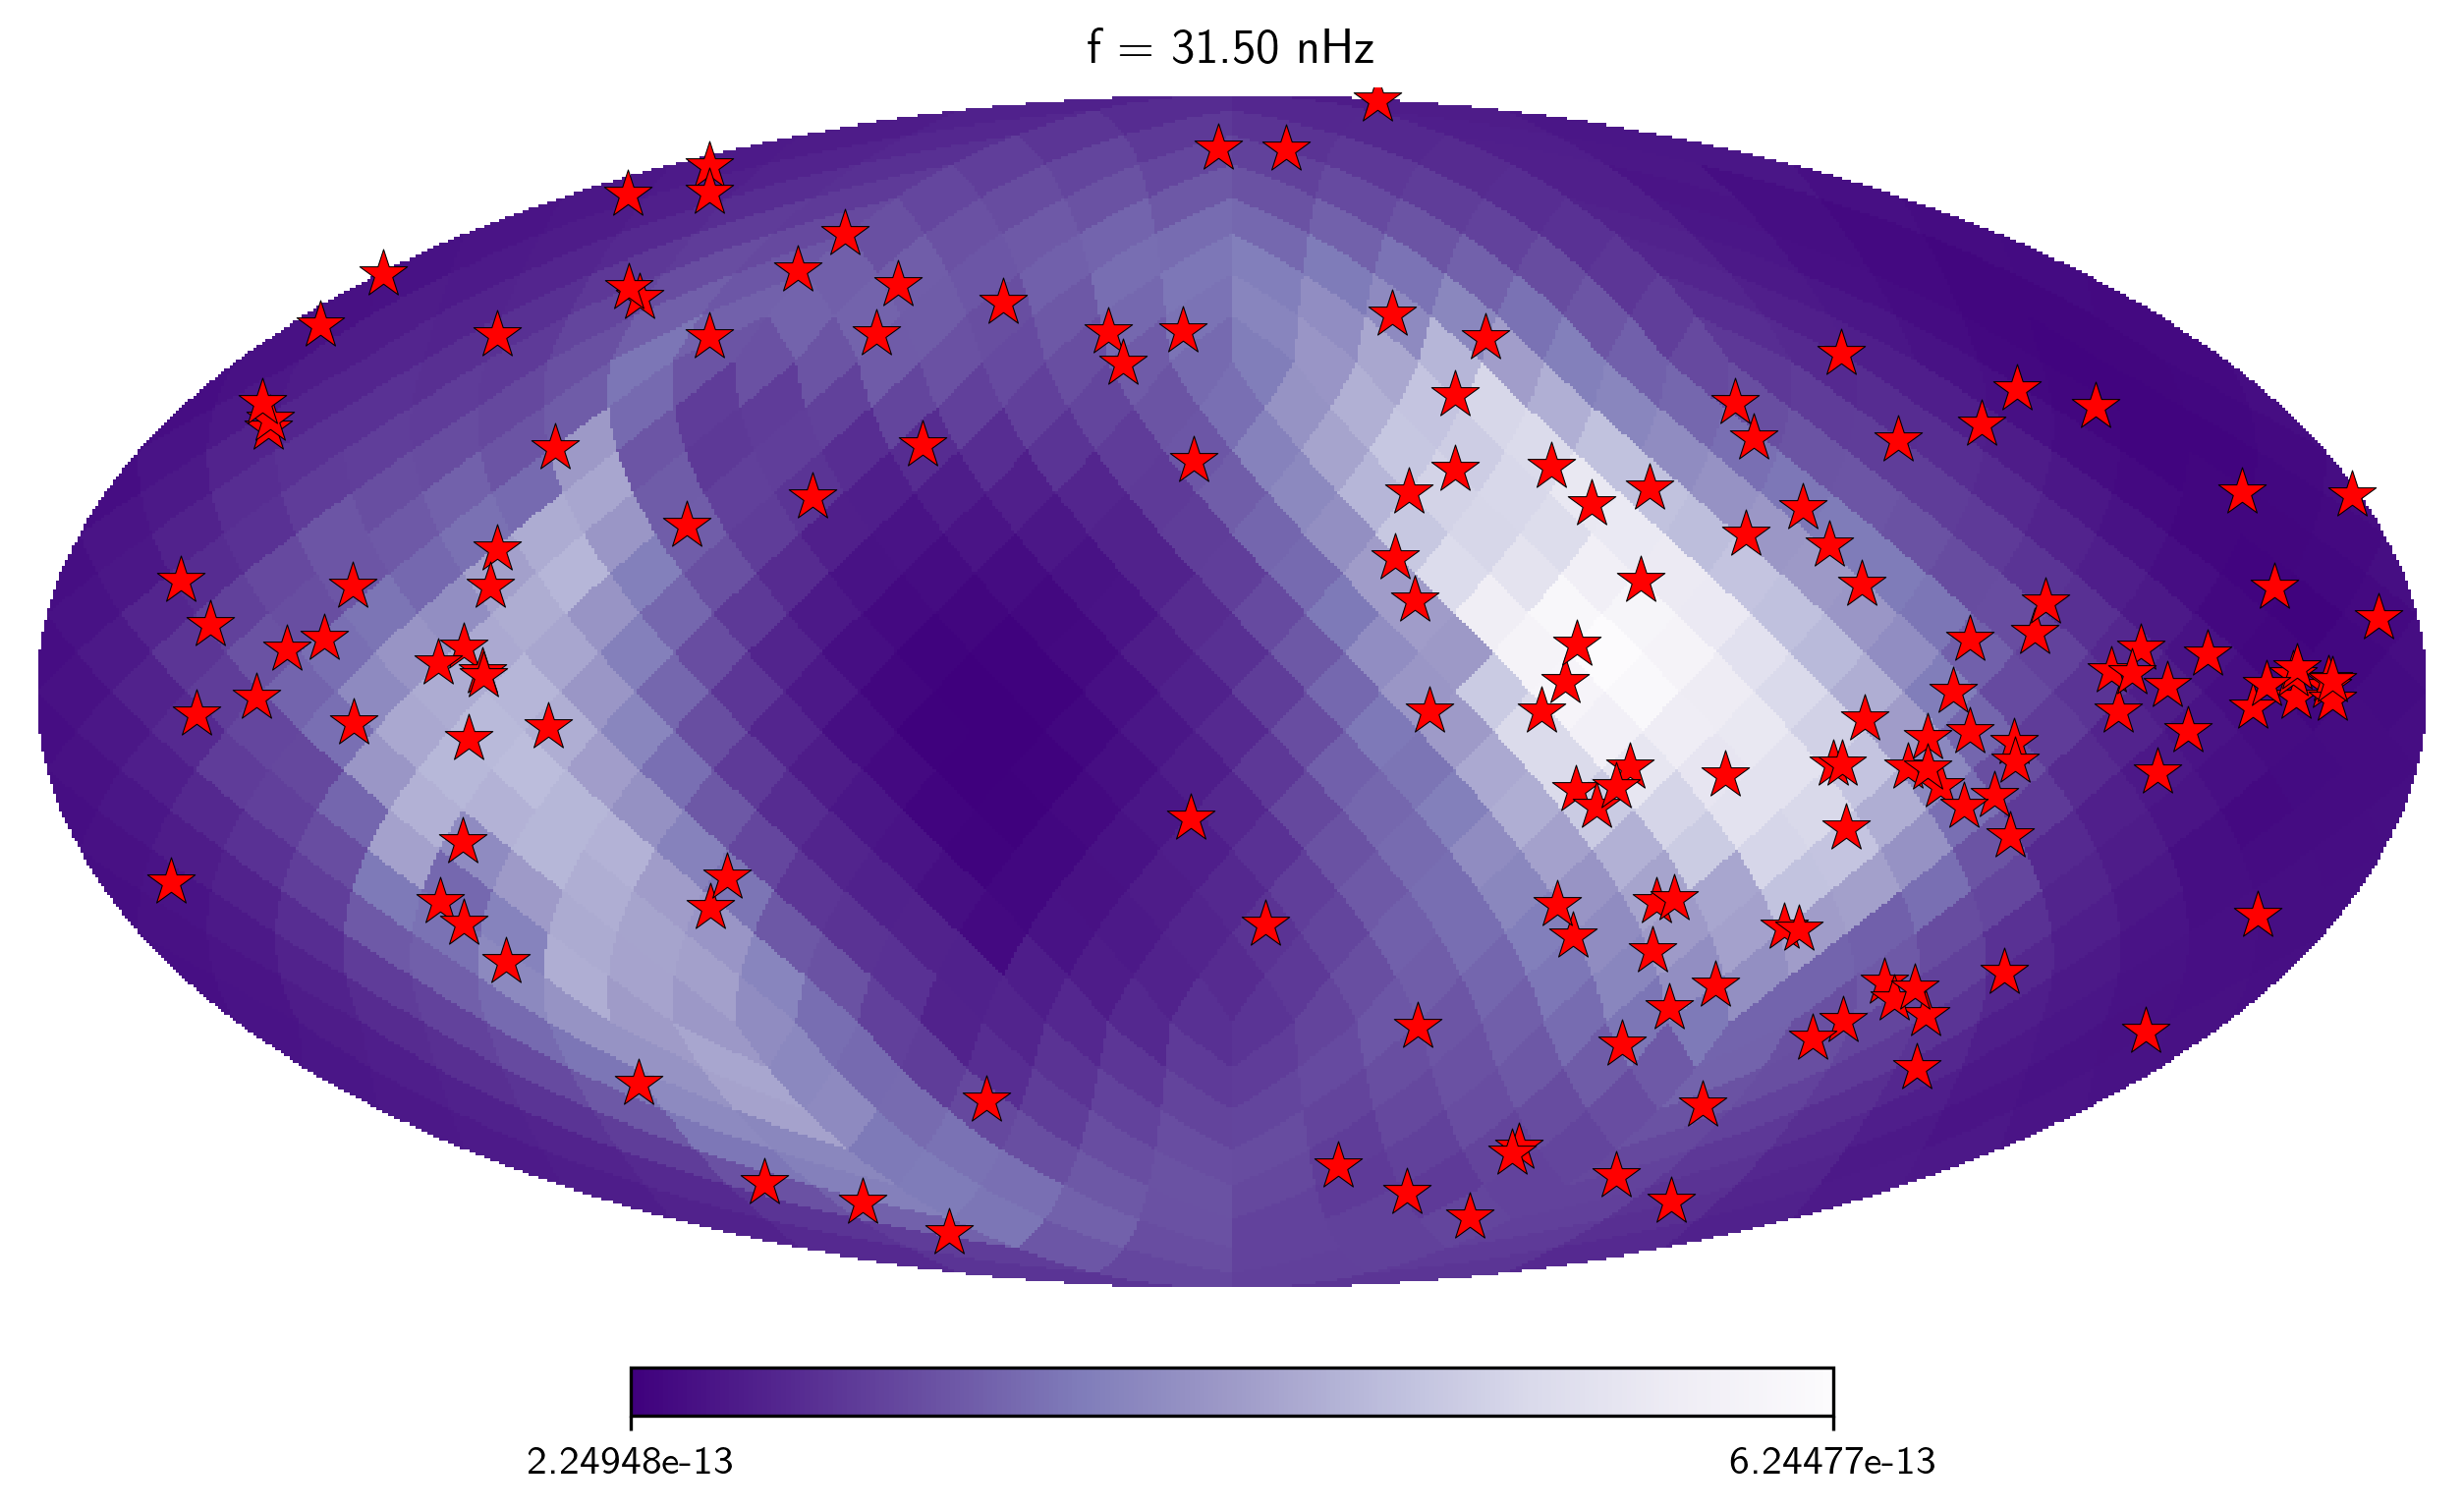

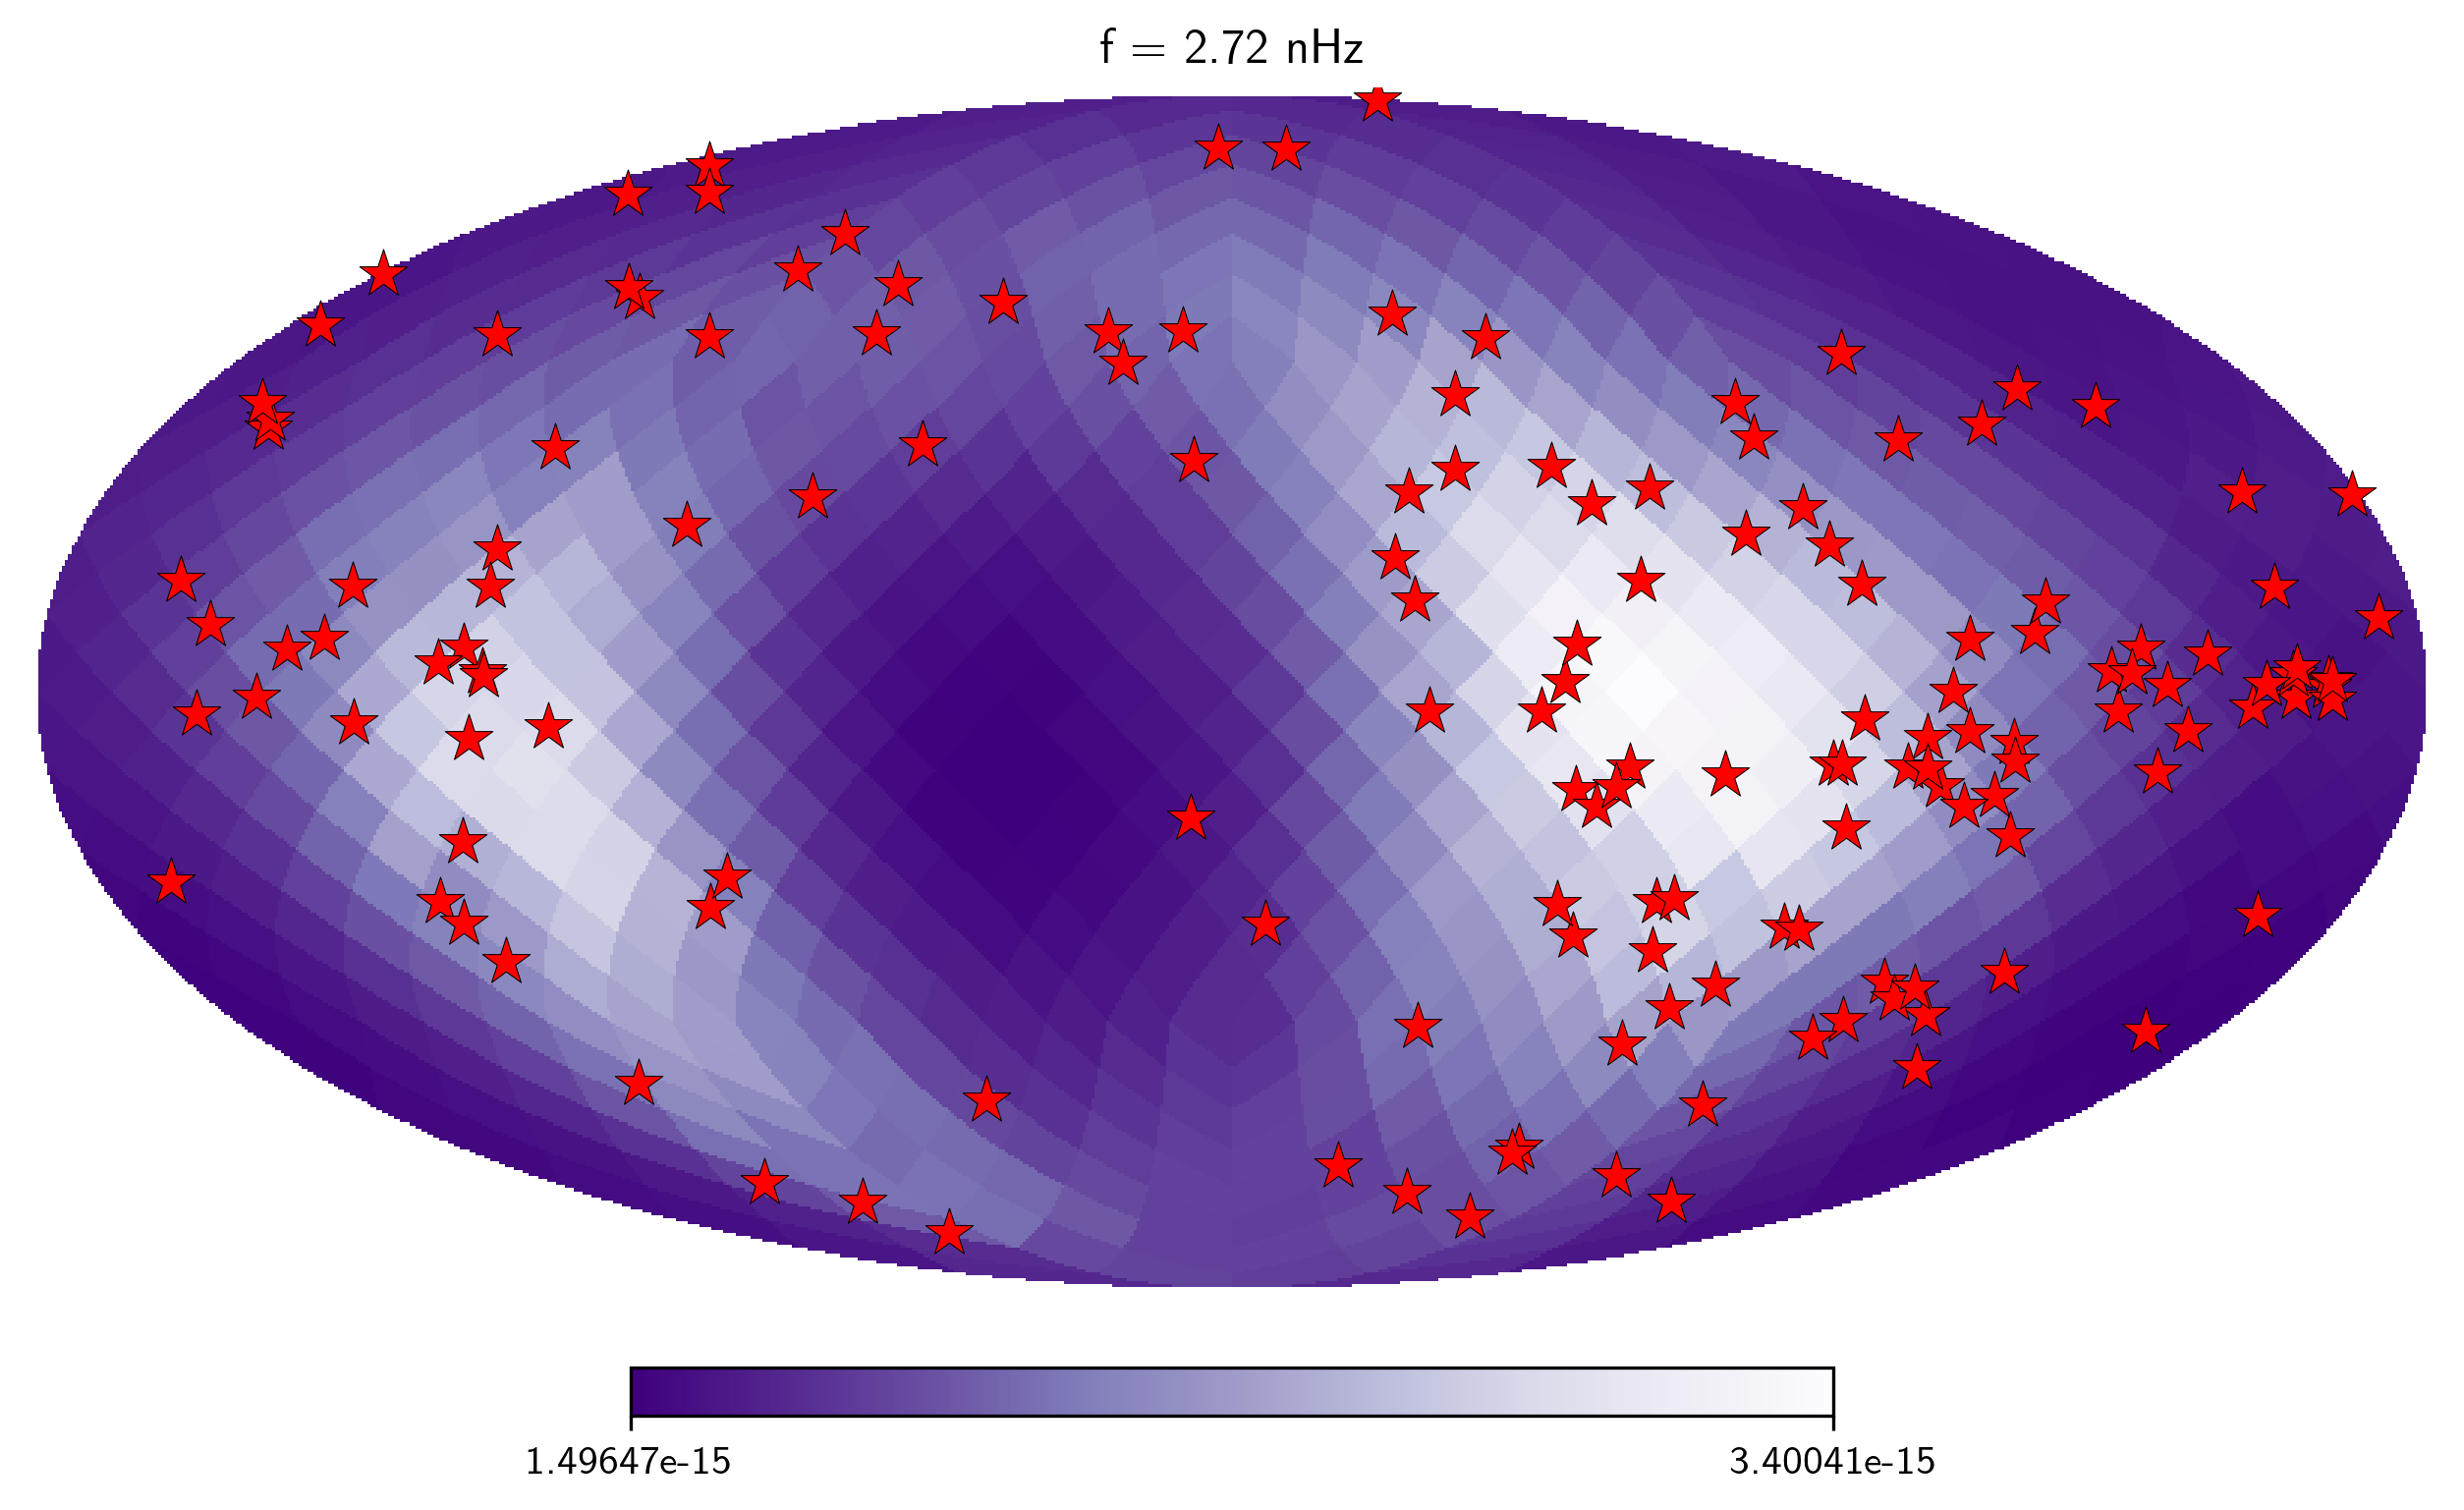

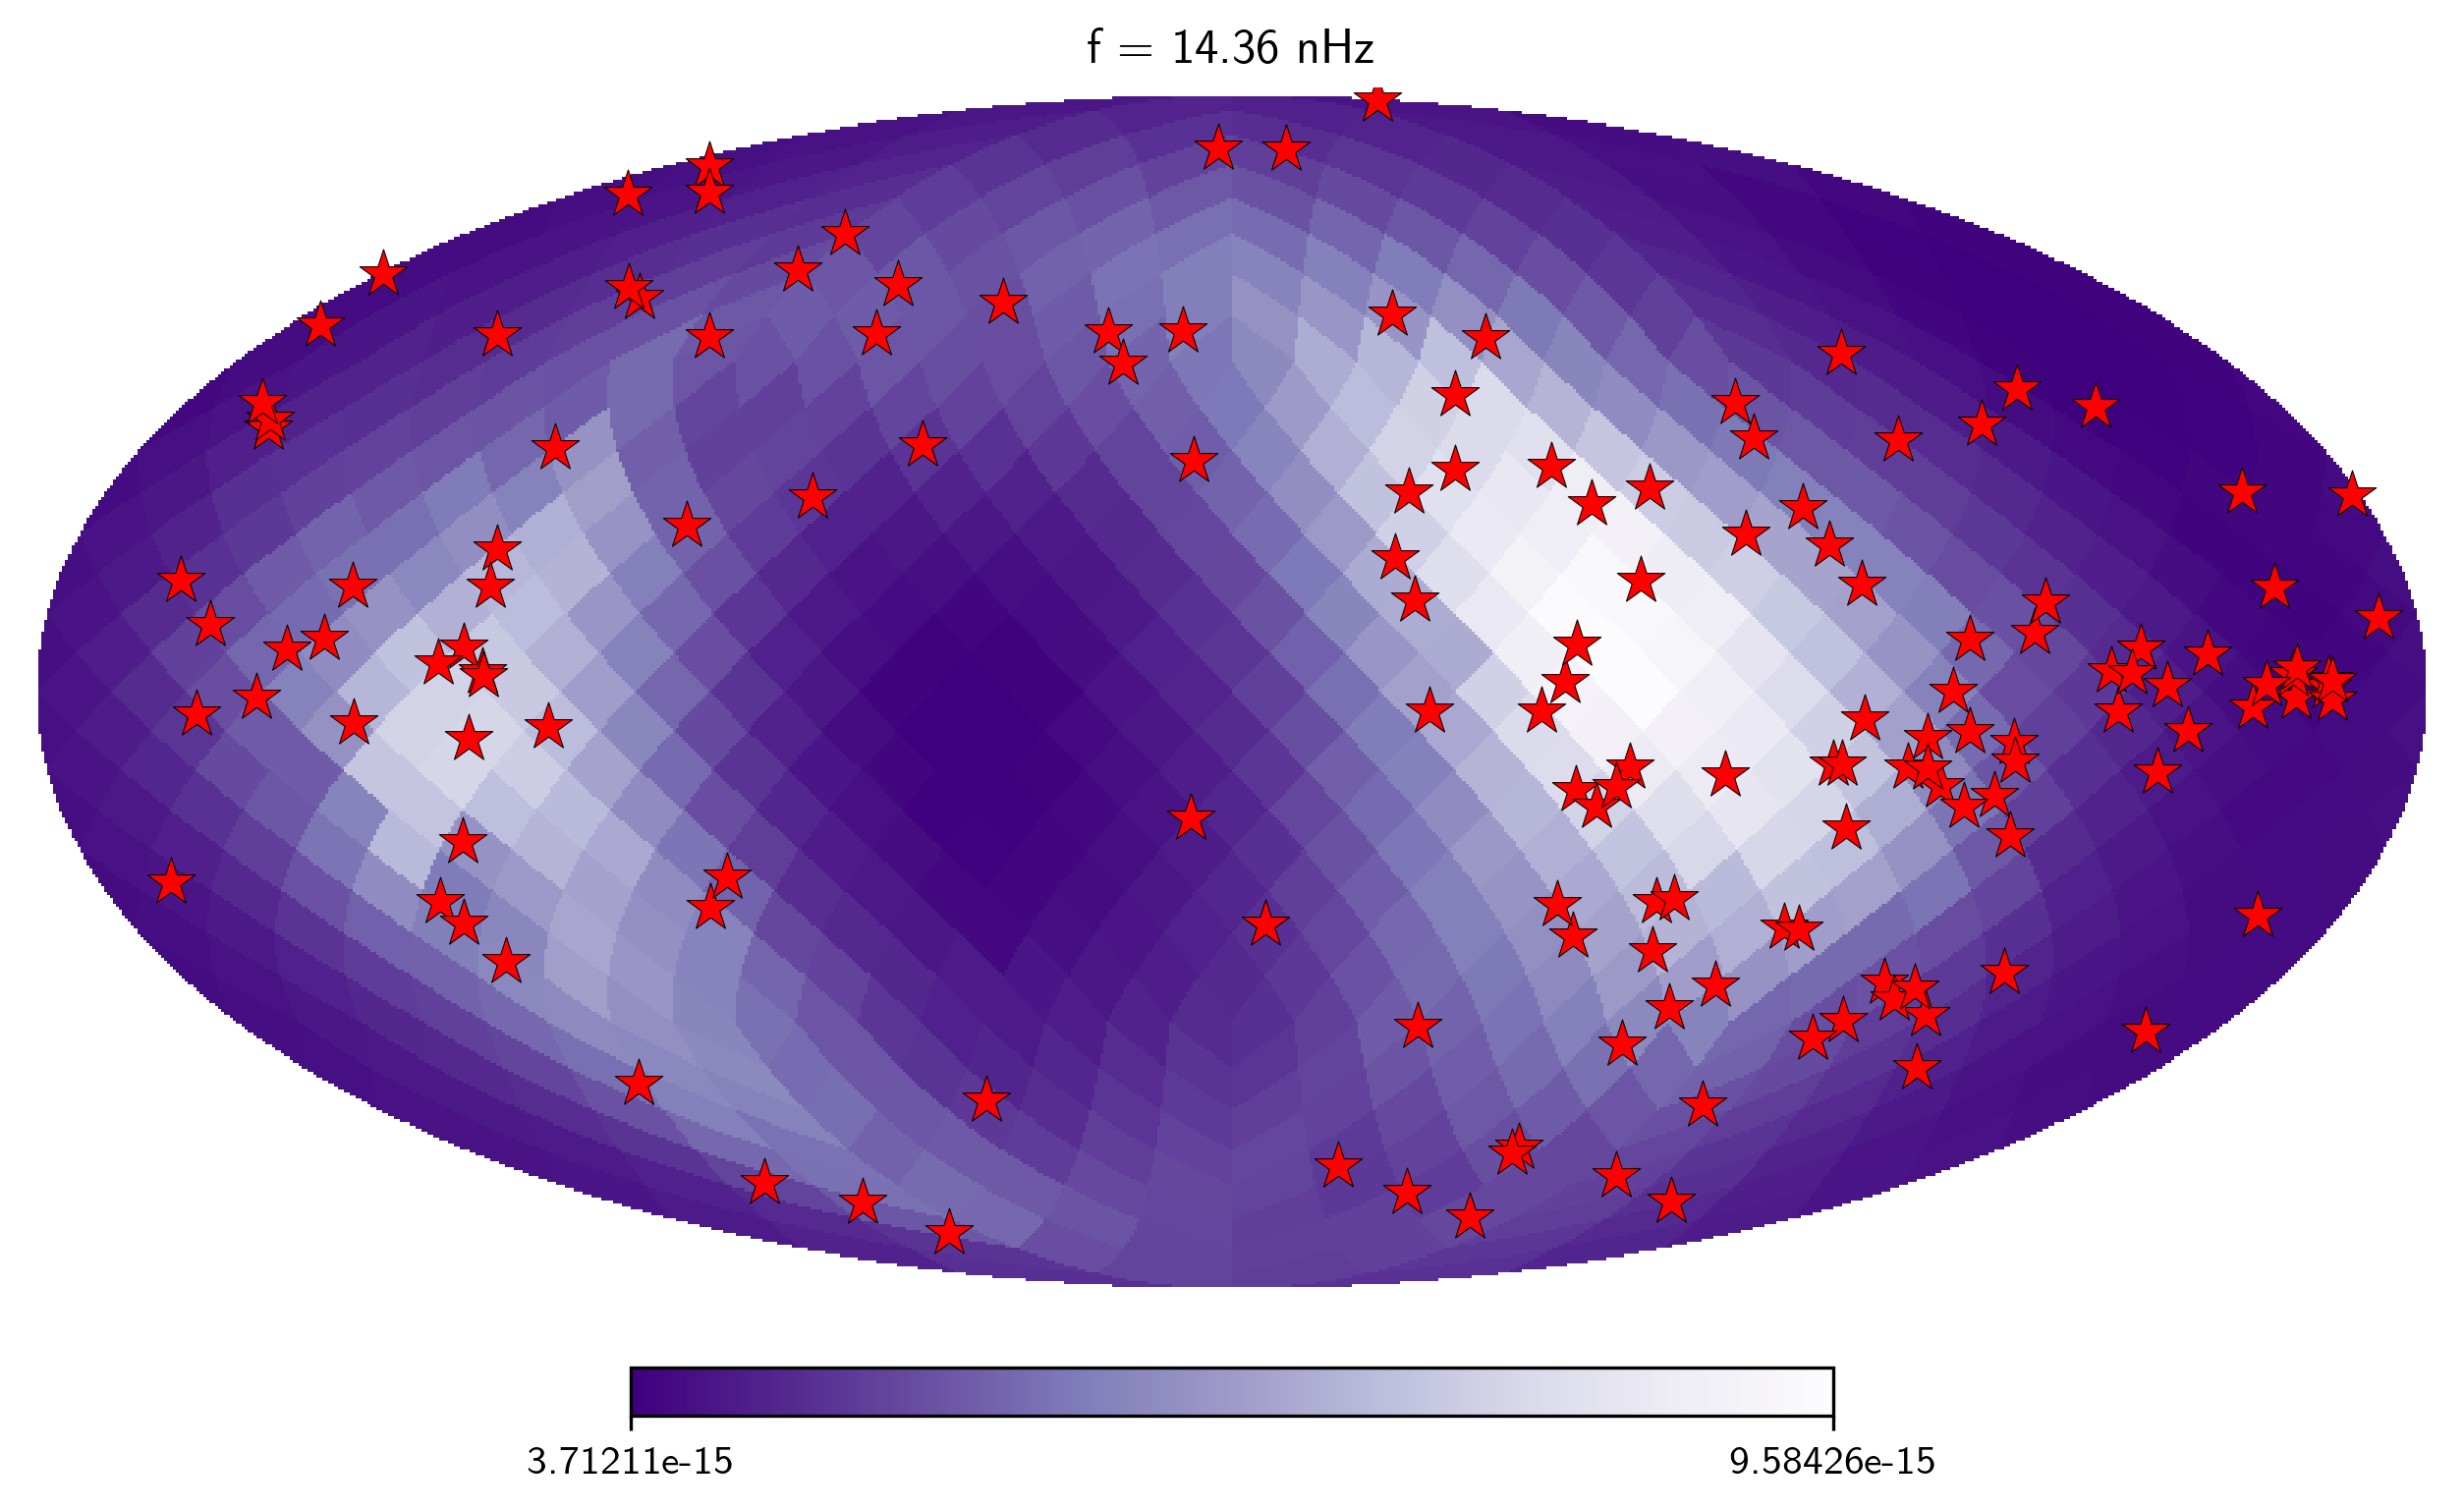

In [48]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    h_c_pixel = ASM.h_c_aniso_pixel(idx)
    
    # Plot the map
    hp.mollview(h_c_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


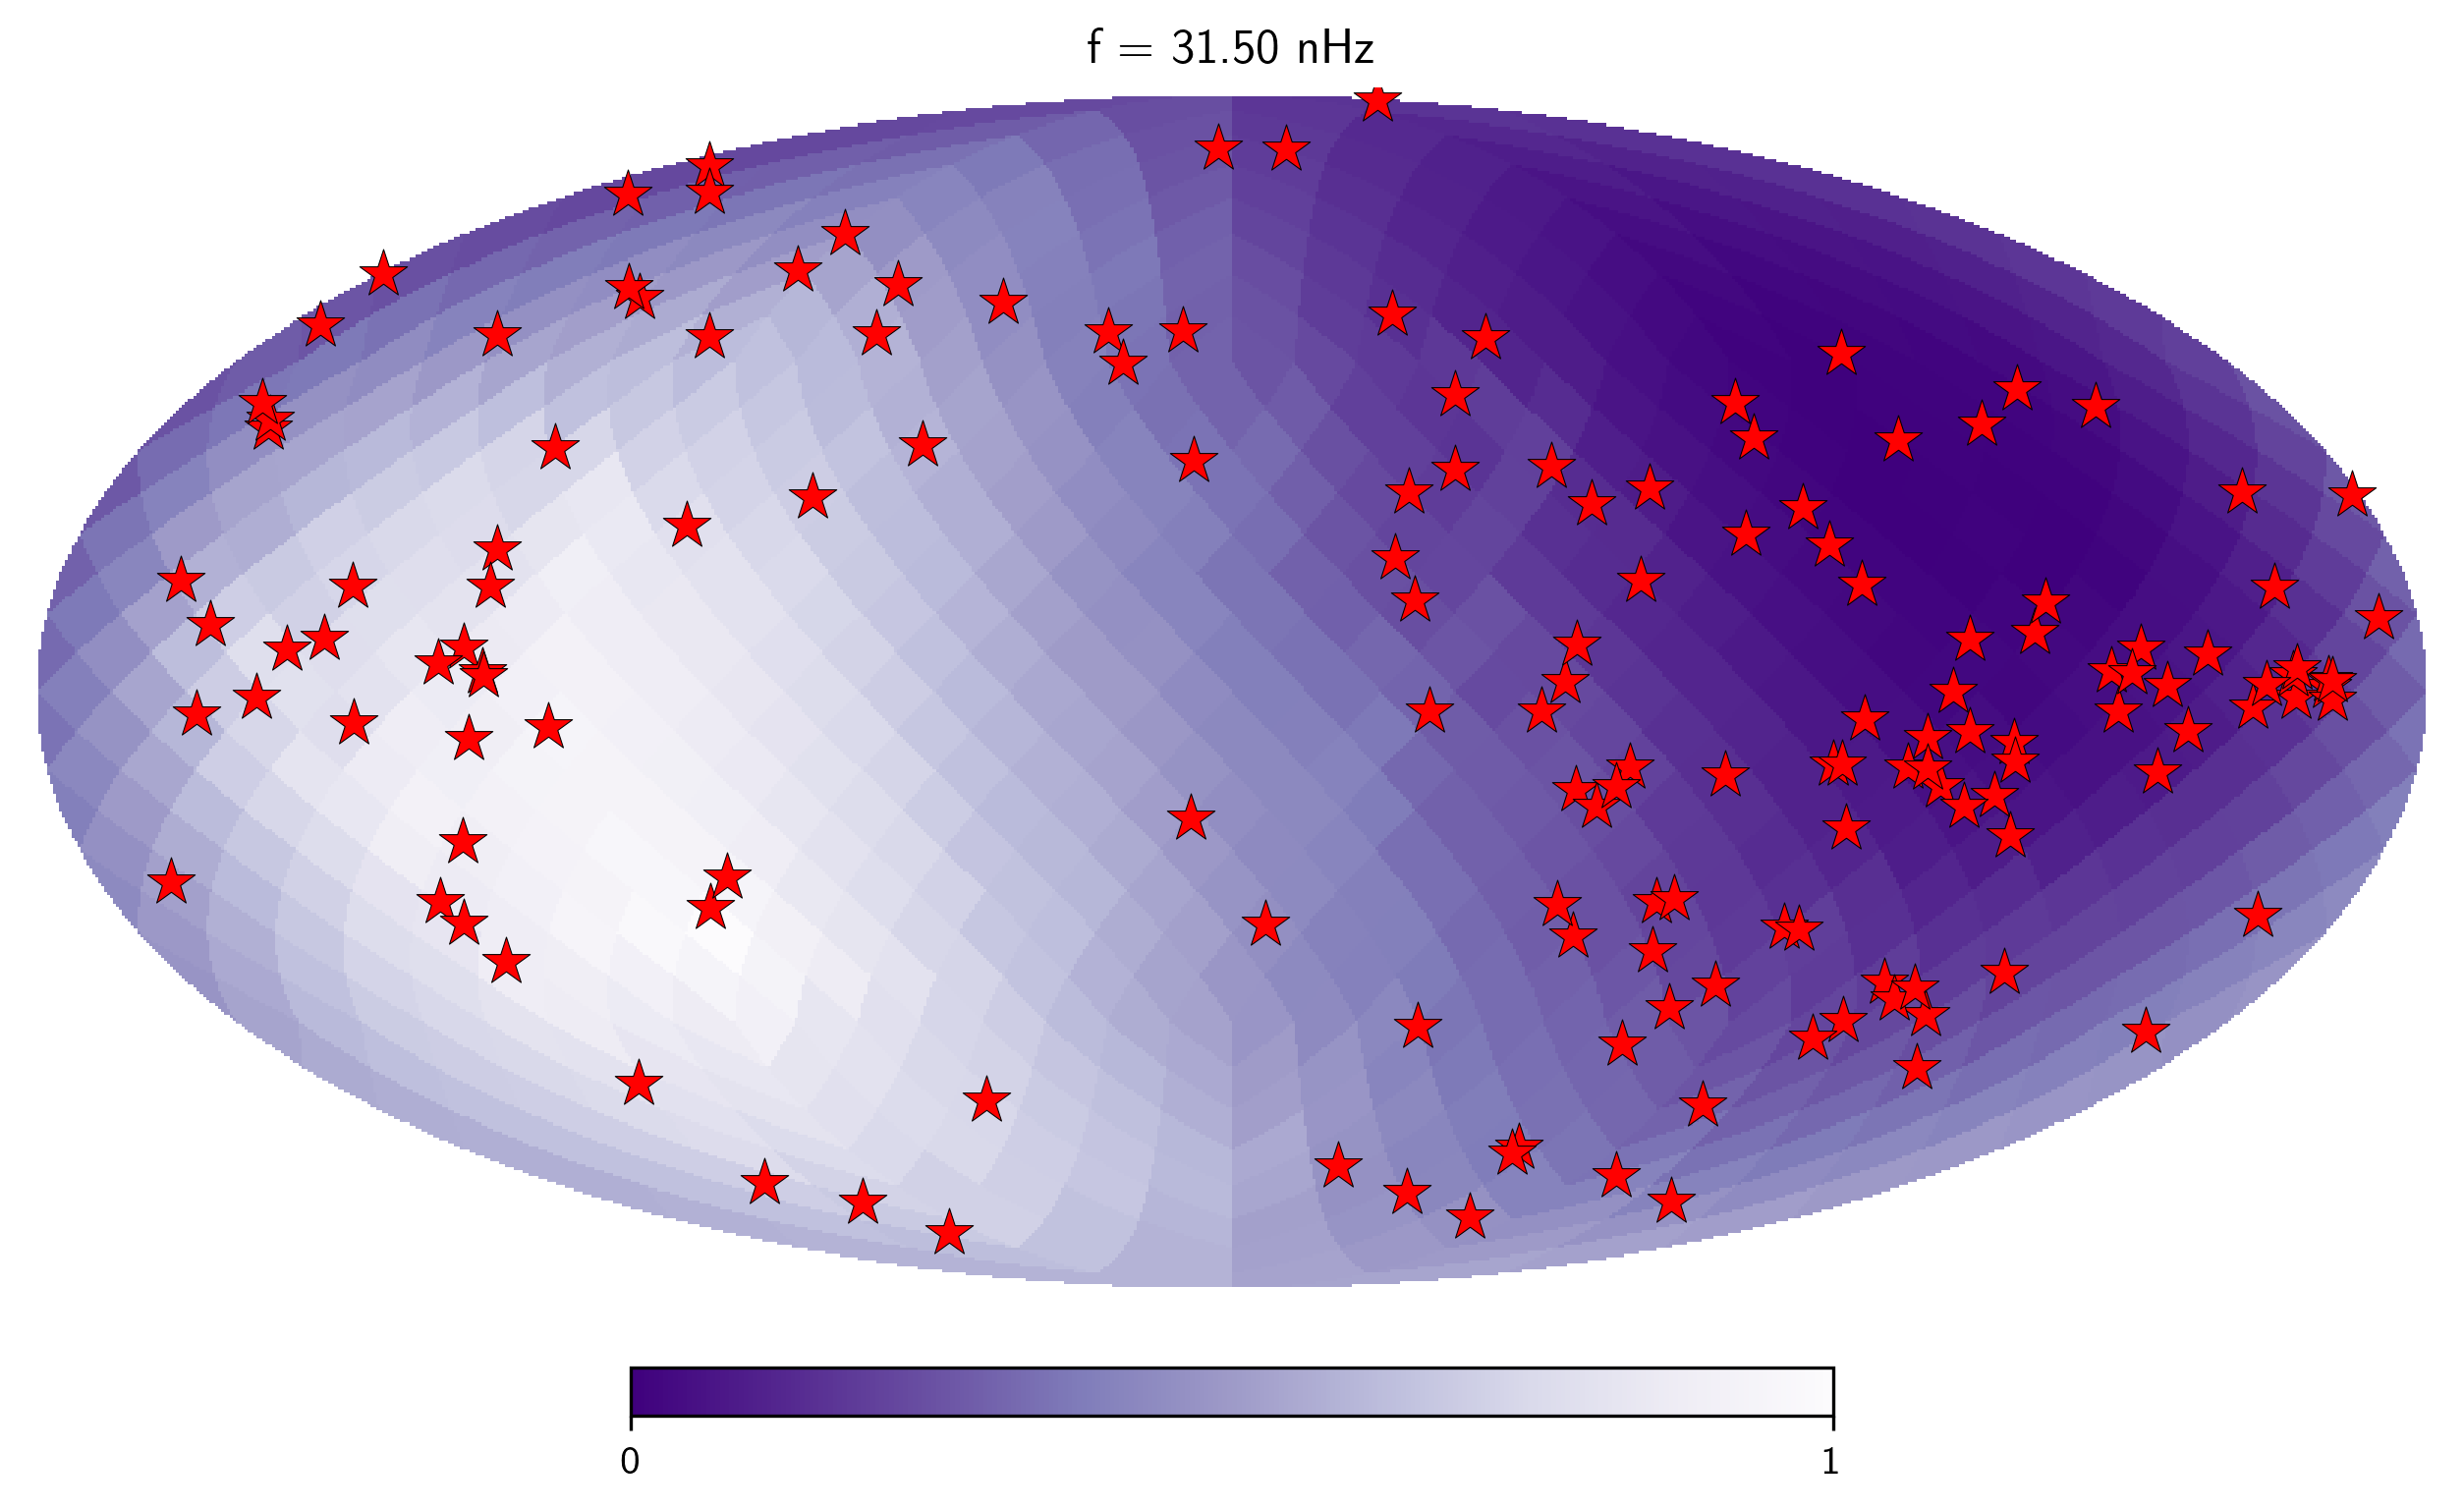

In [49]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, max_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {max_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



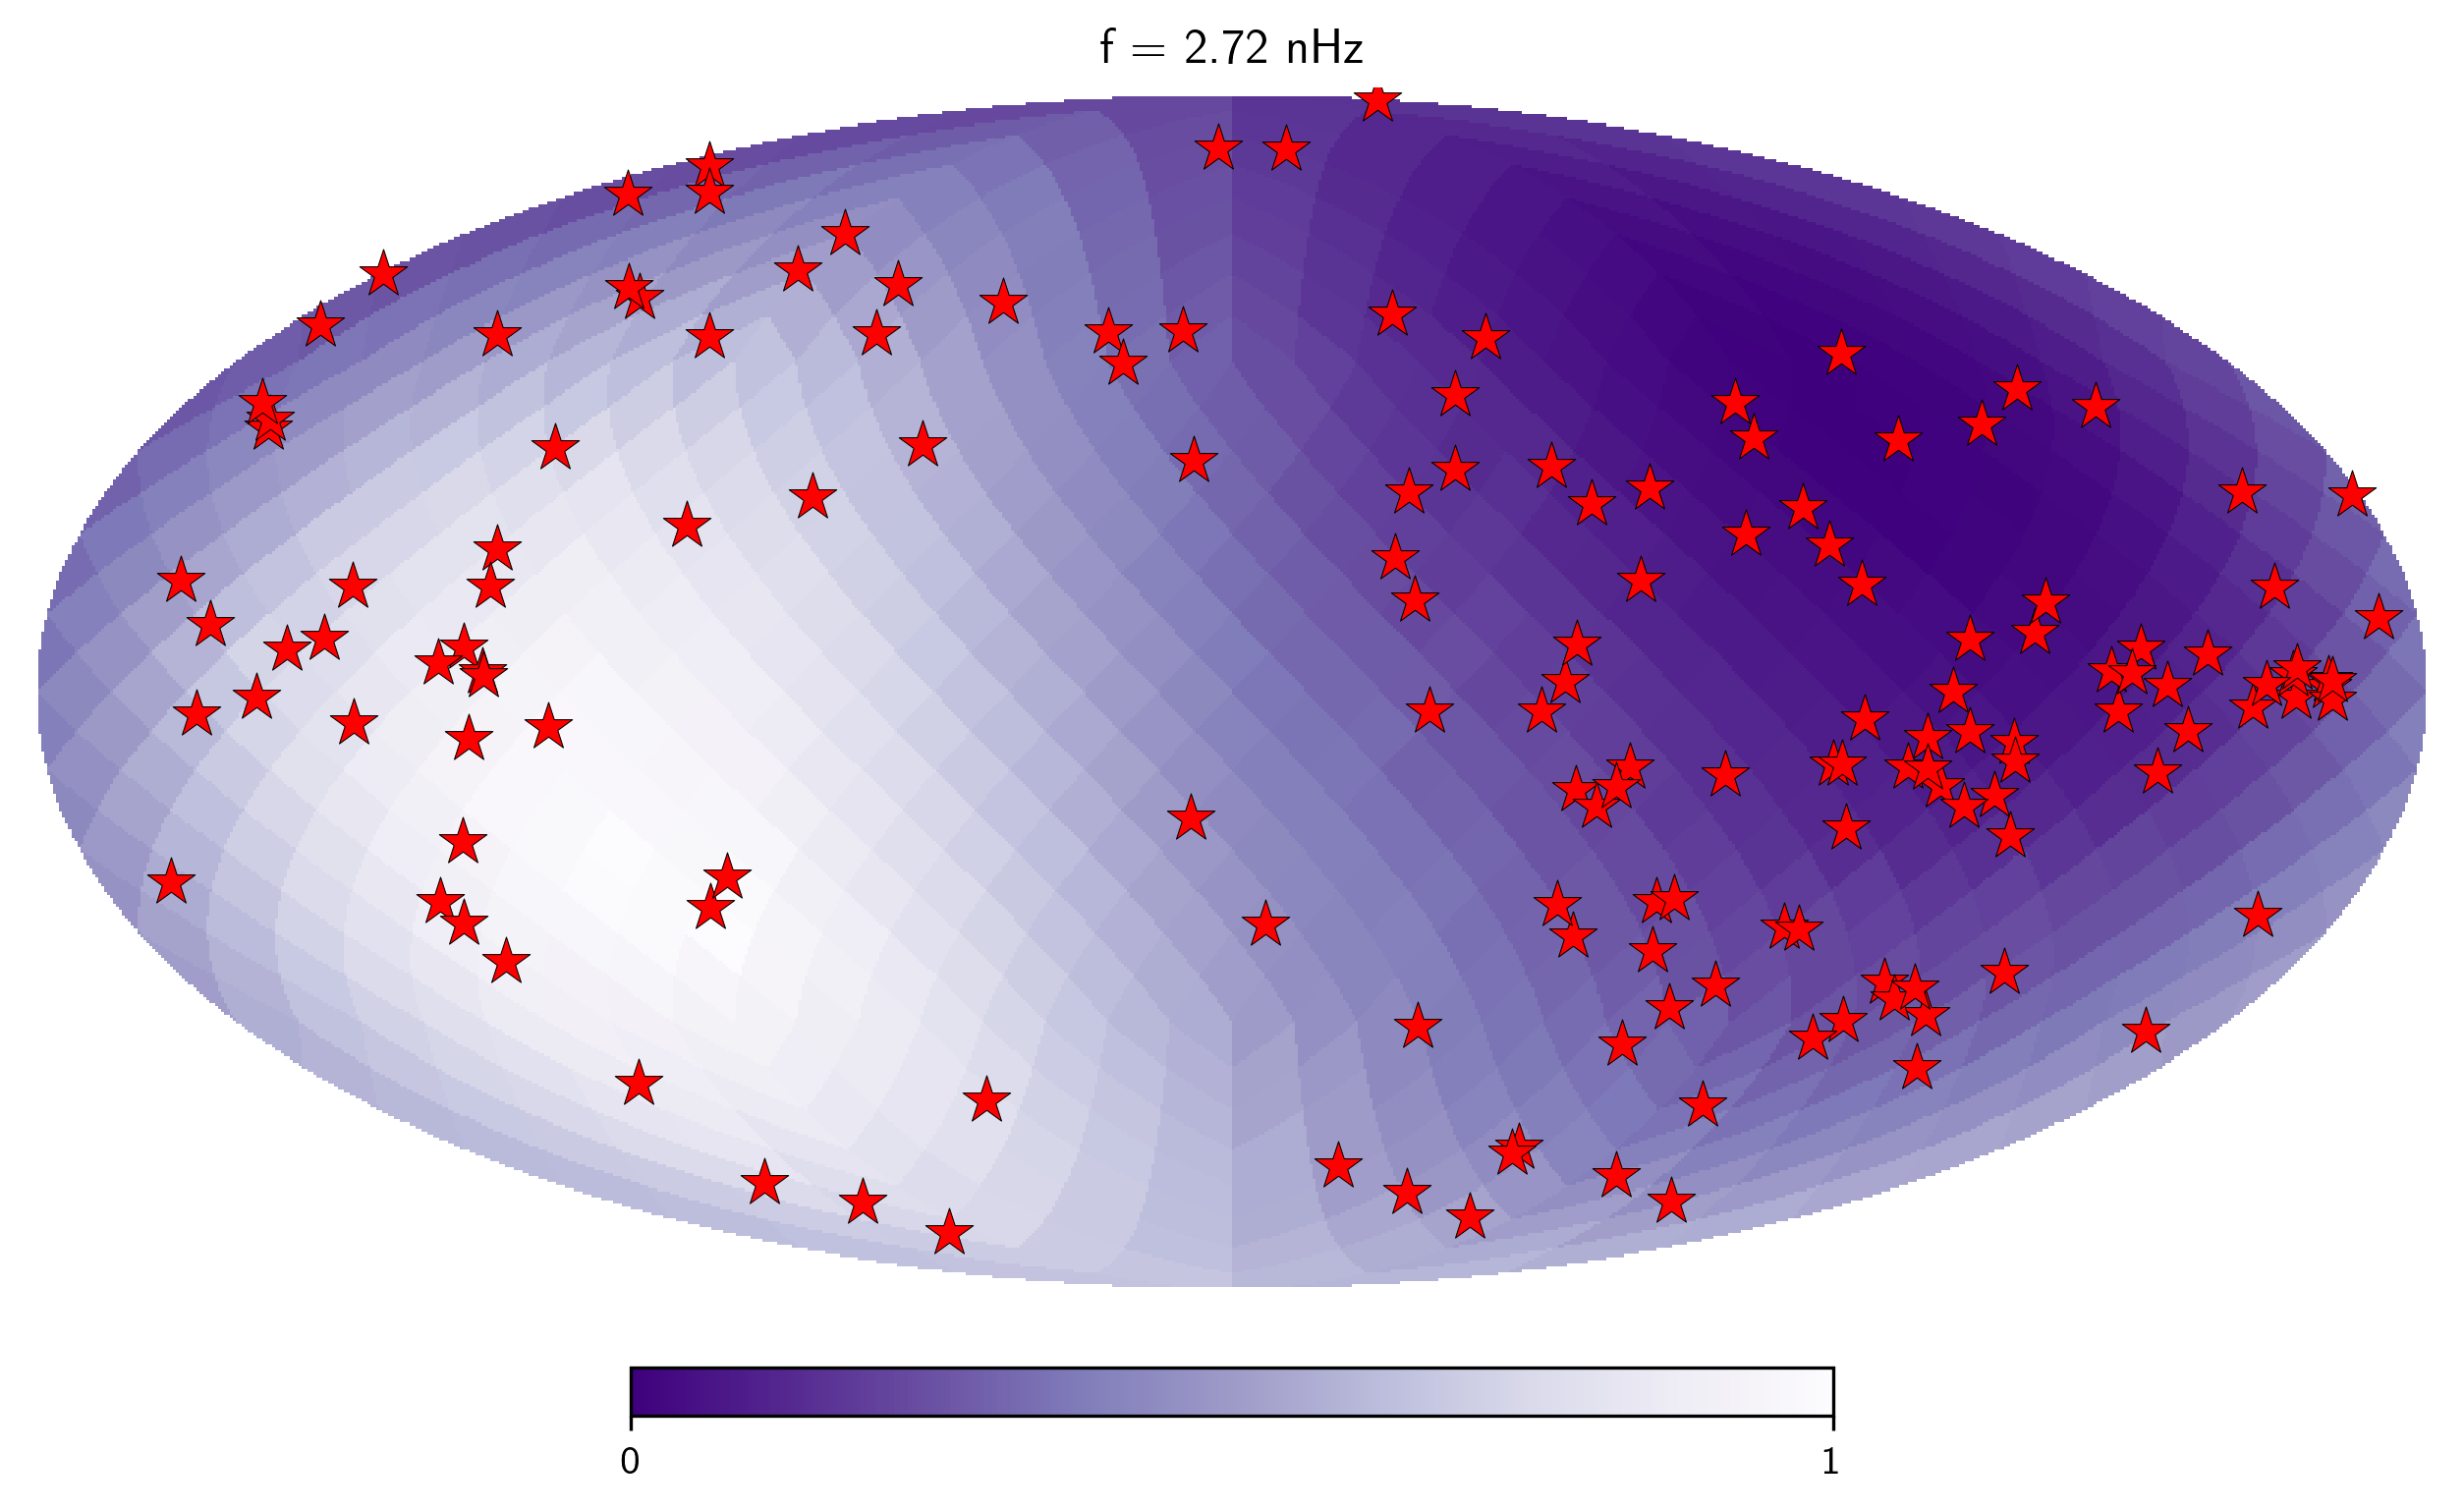

In [50]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, min_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {min_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



In [51]:
# plt.rc('text', usetex=True)
# hp.mollview(M_kk_pixel_norm, title=f"f = {median_freq * 1e9:.2f} nHz", 
#             cmap='Purples_r', rot=(180,0,0), cbar=None)
# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1)
# hp.graticule()
# fig = plt.gcf()
# ax = plt.gca()
# image = ax.get_images()[0]
# cbar = fig.colorbar(image, ax=ax, orientation='horizontal', shrink=0.8, pad=0.05)
# cbar.set_label(r'$\sqrt{\mathcal{M}}$', labelpad=10)
# plt.rcParams.update({'font.size':22,'text.usetex':True})
# plt.show()


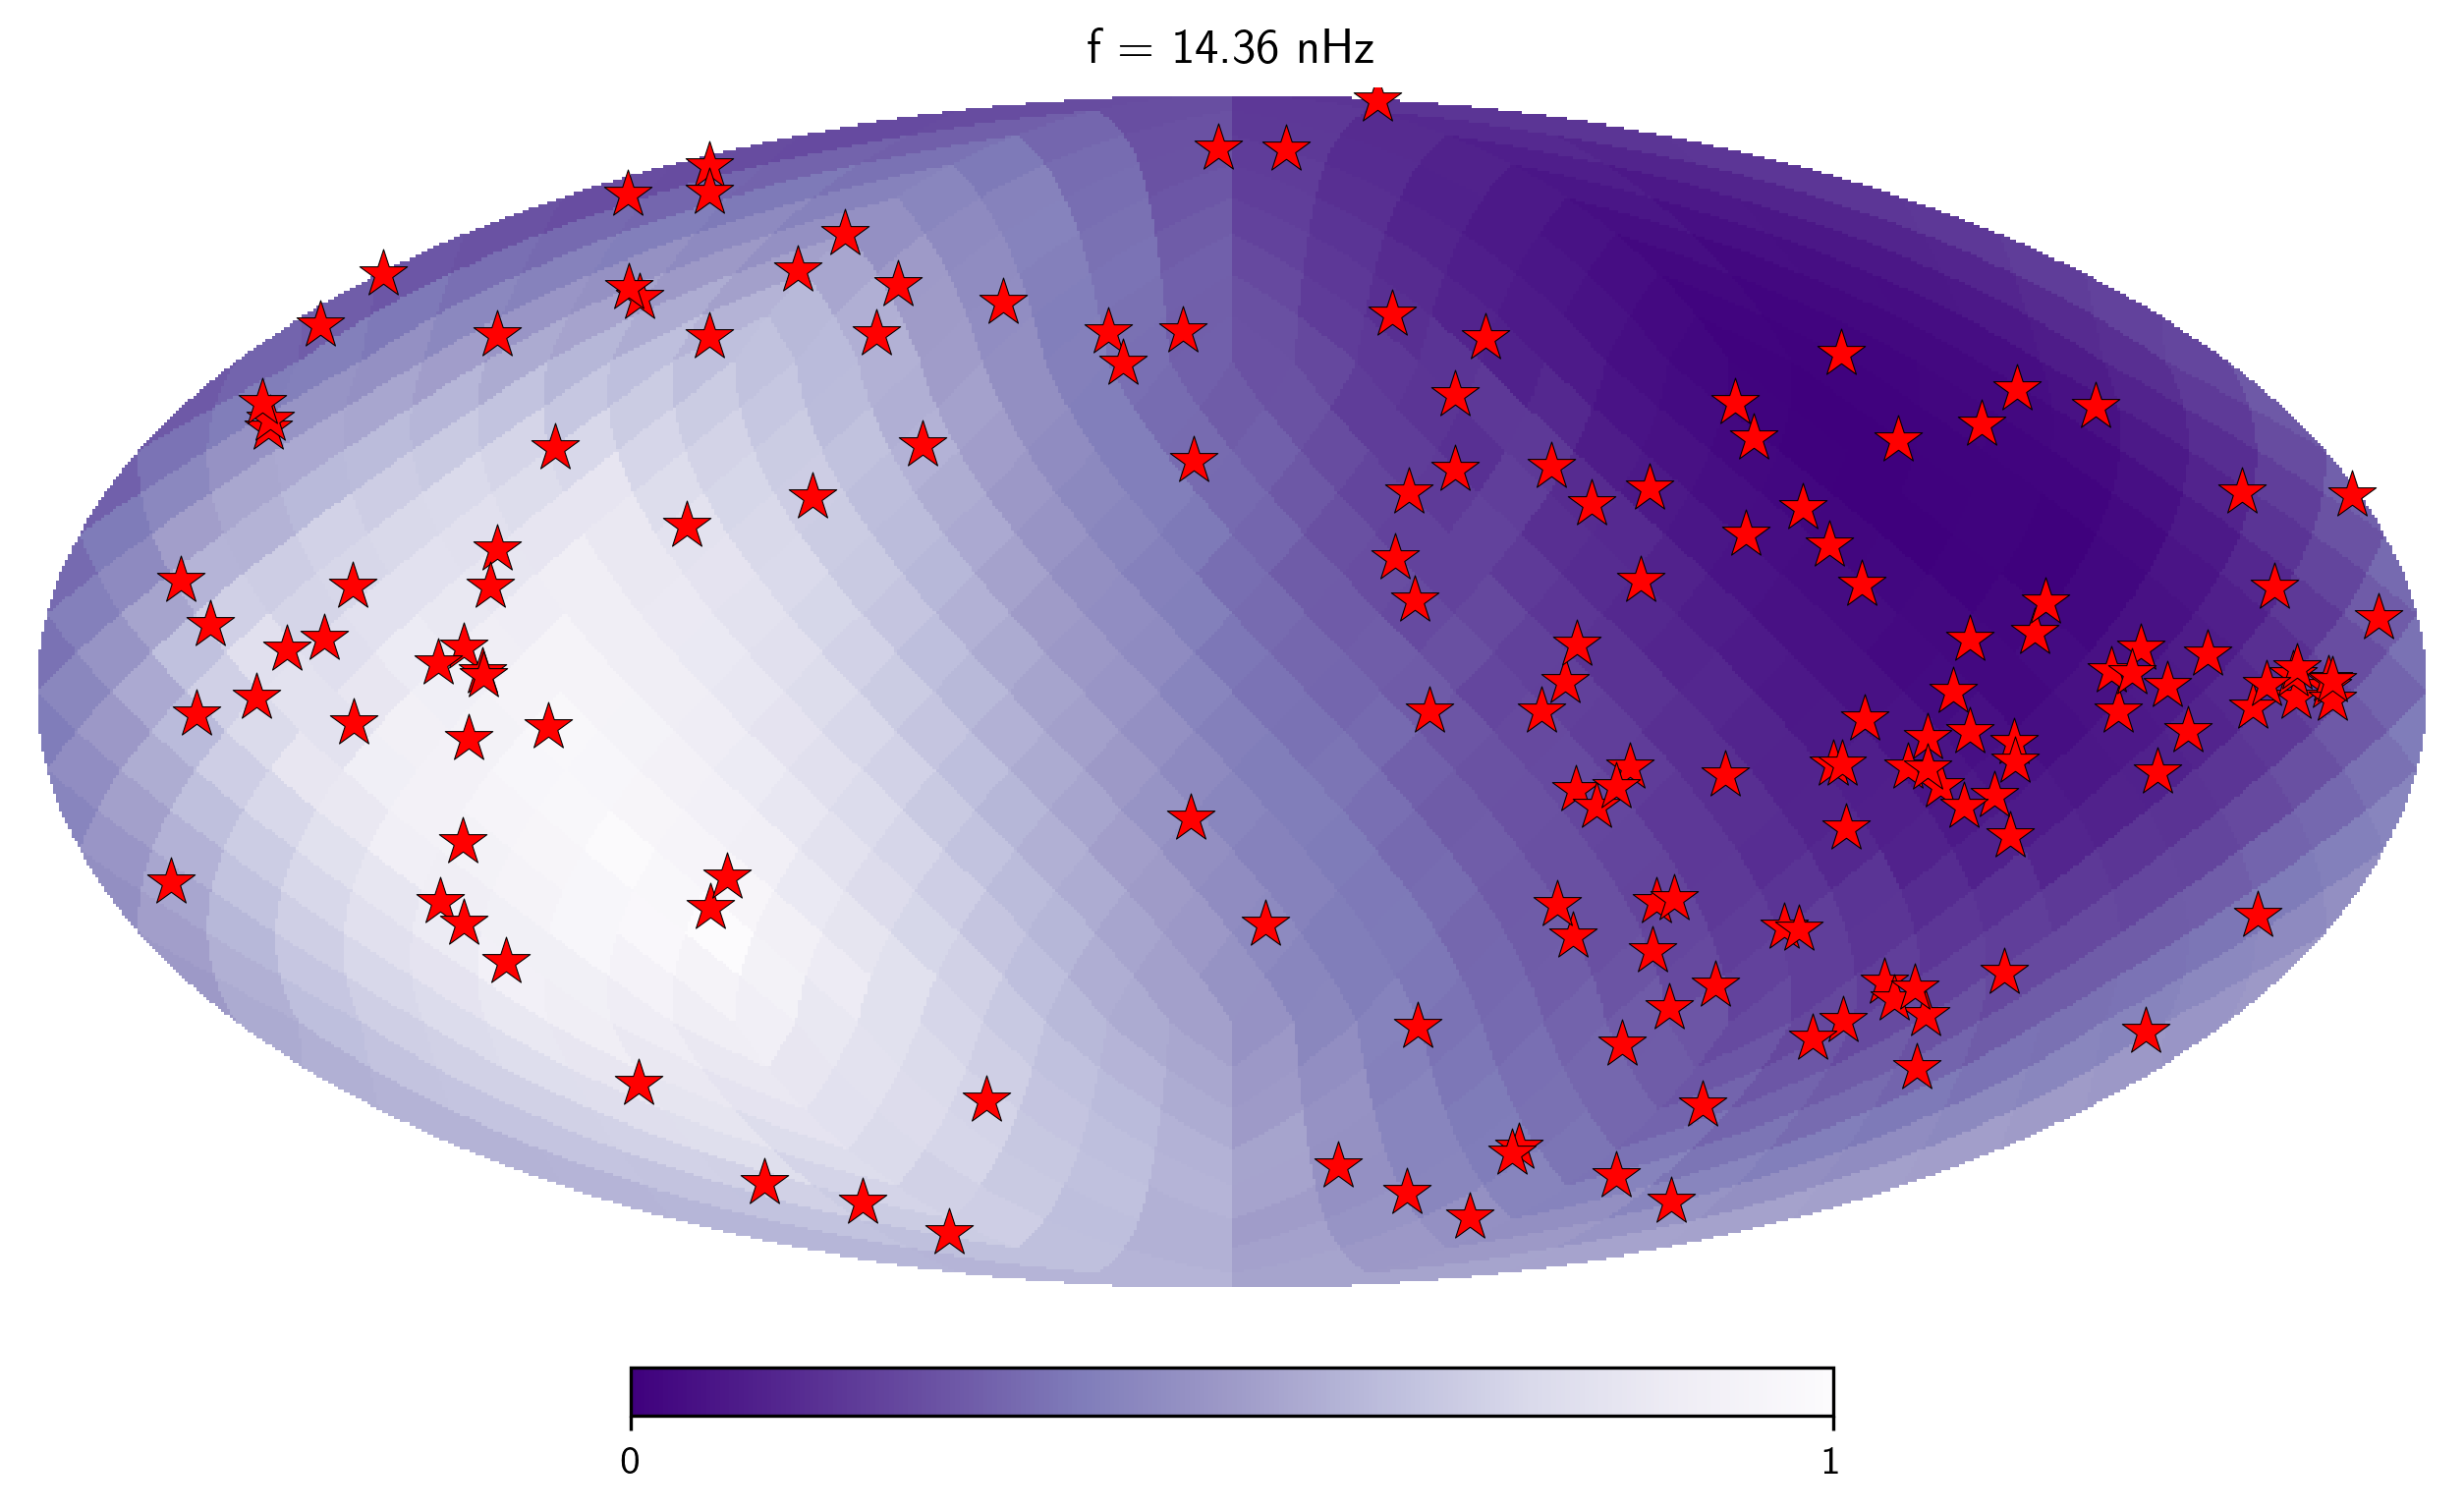

In [52]:
M_kk_pixel = np.sqrt(ASM.M_kk[:, median_index])/Tspan

# Rescale M_kk_pixel such that min = 0 and max = 1
M_kk_pixel_norm = (M_kk_pixel - np.min(M_kk_pixel)) / (np.max(M_kk_pixel) - np.min(M_kk_pixel))

# Plot the map with the normalized values
hp.mollview(M_kk_pixel_norm, title=f"f = {median_freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

# Overlay pulsar positions
hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                        edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))

plt.show()



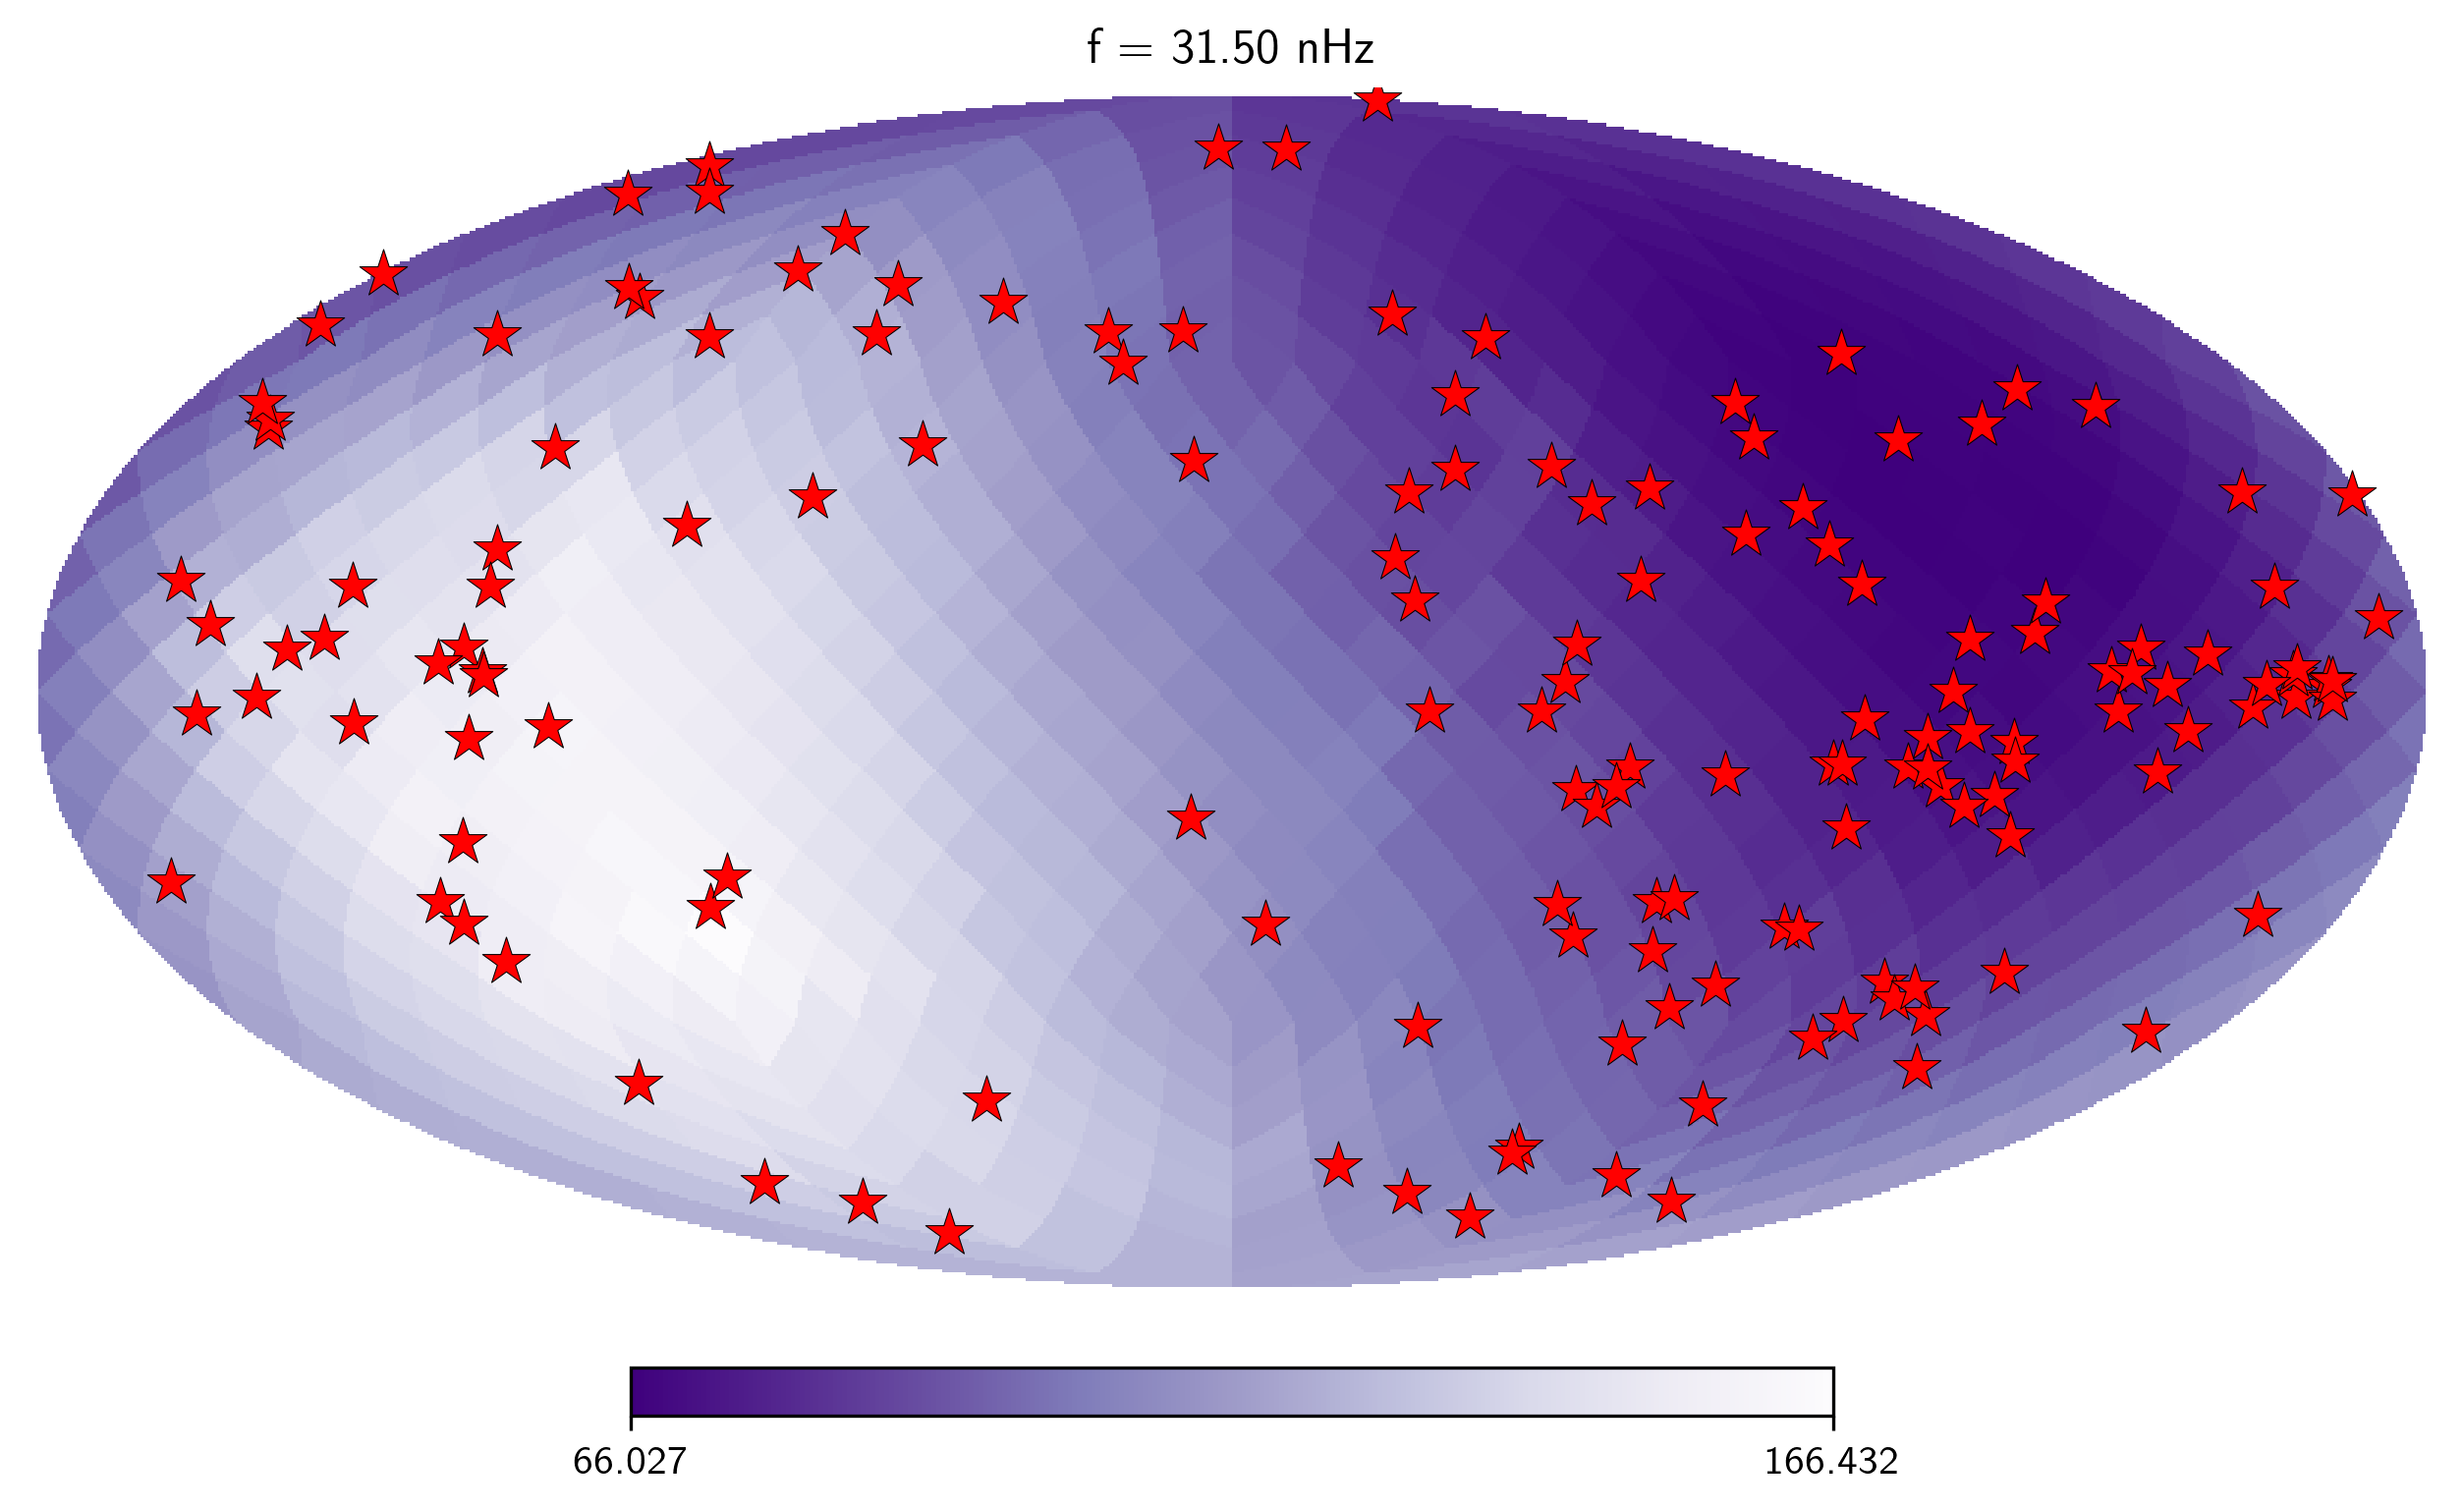

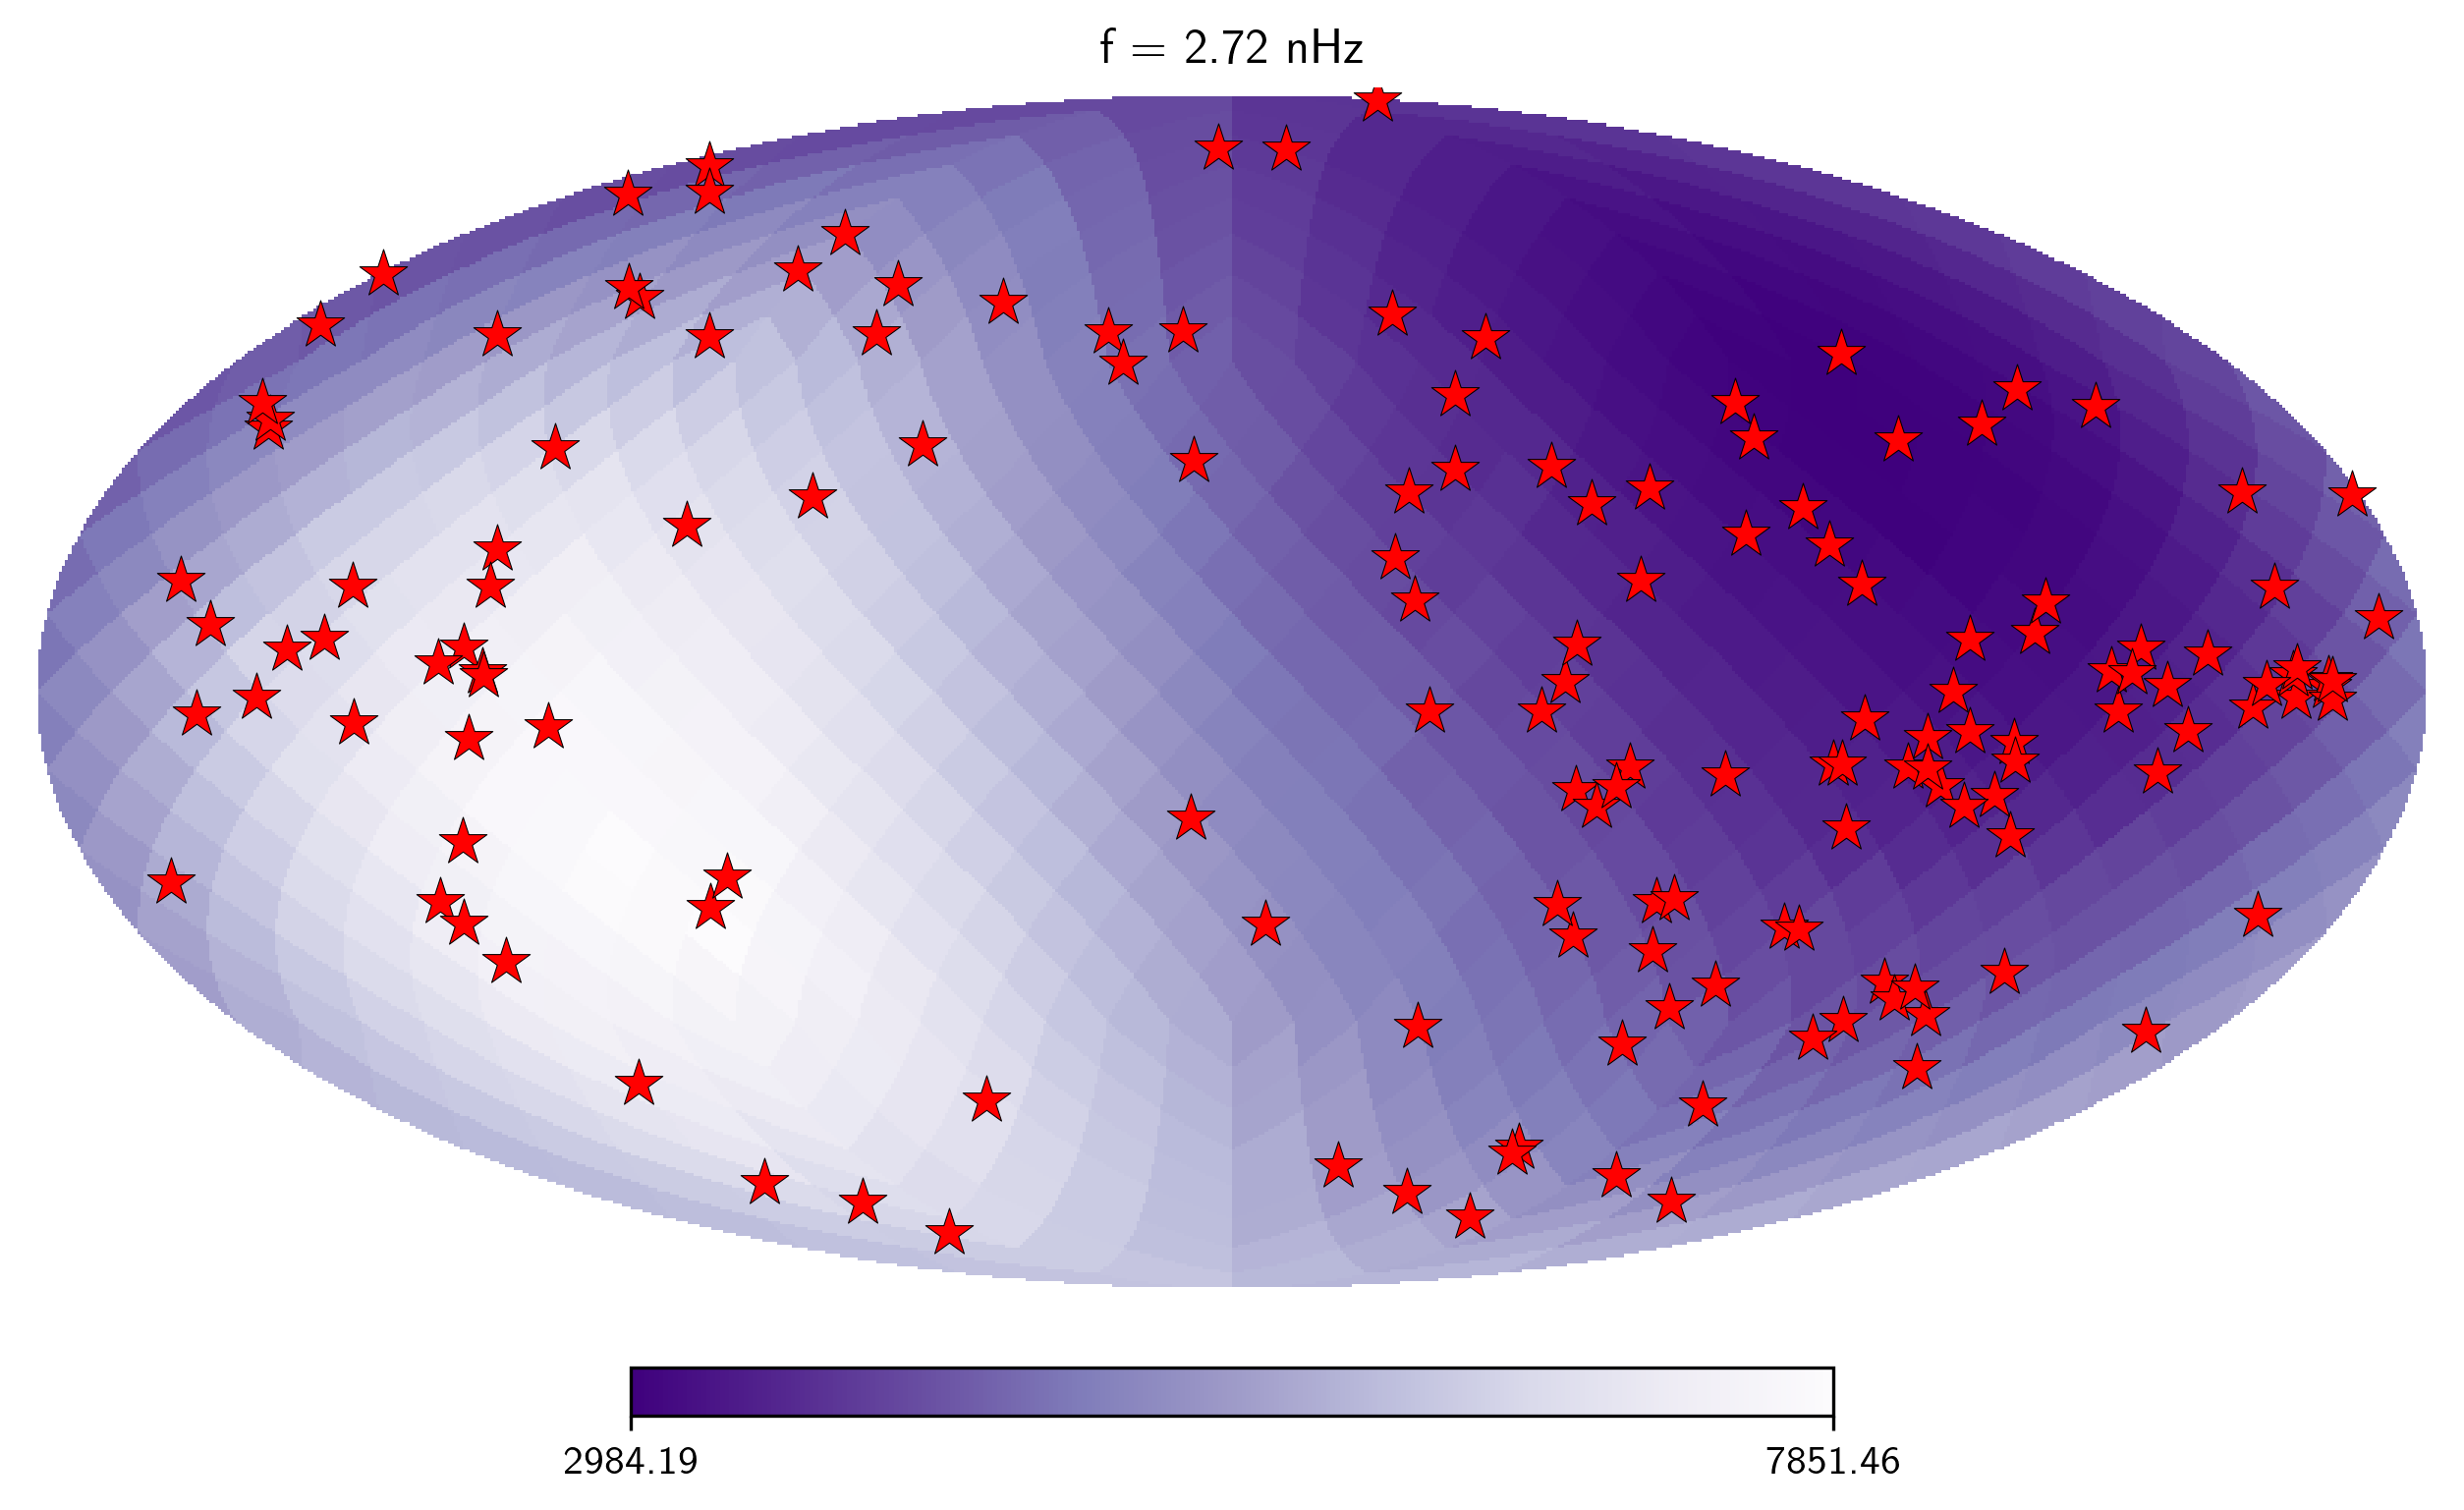

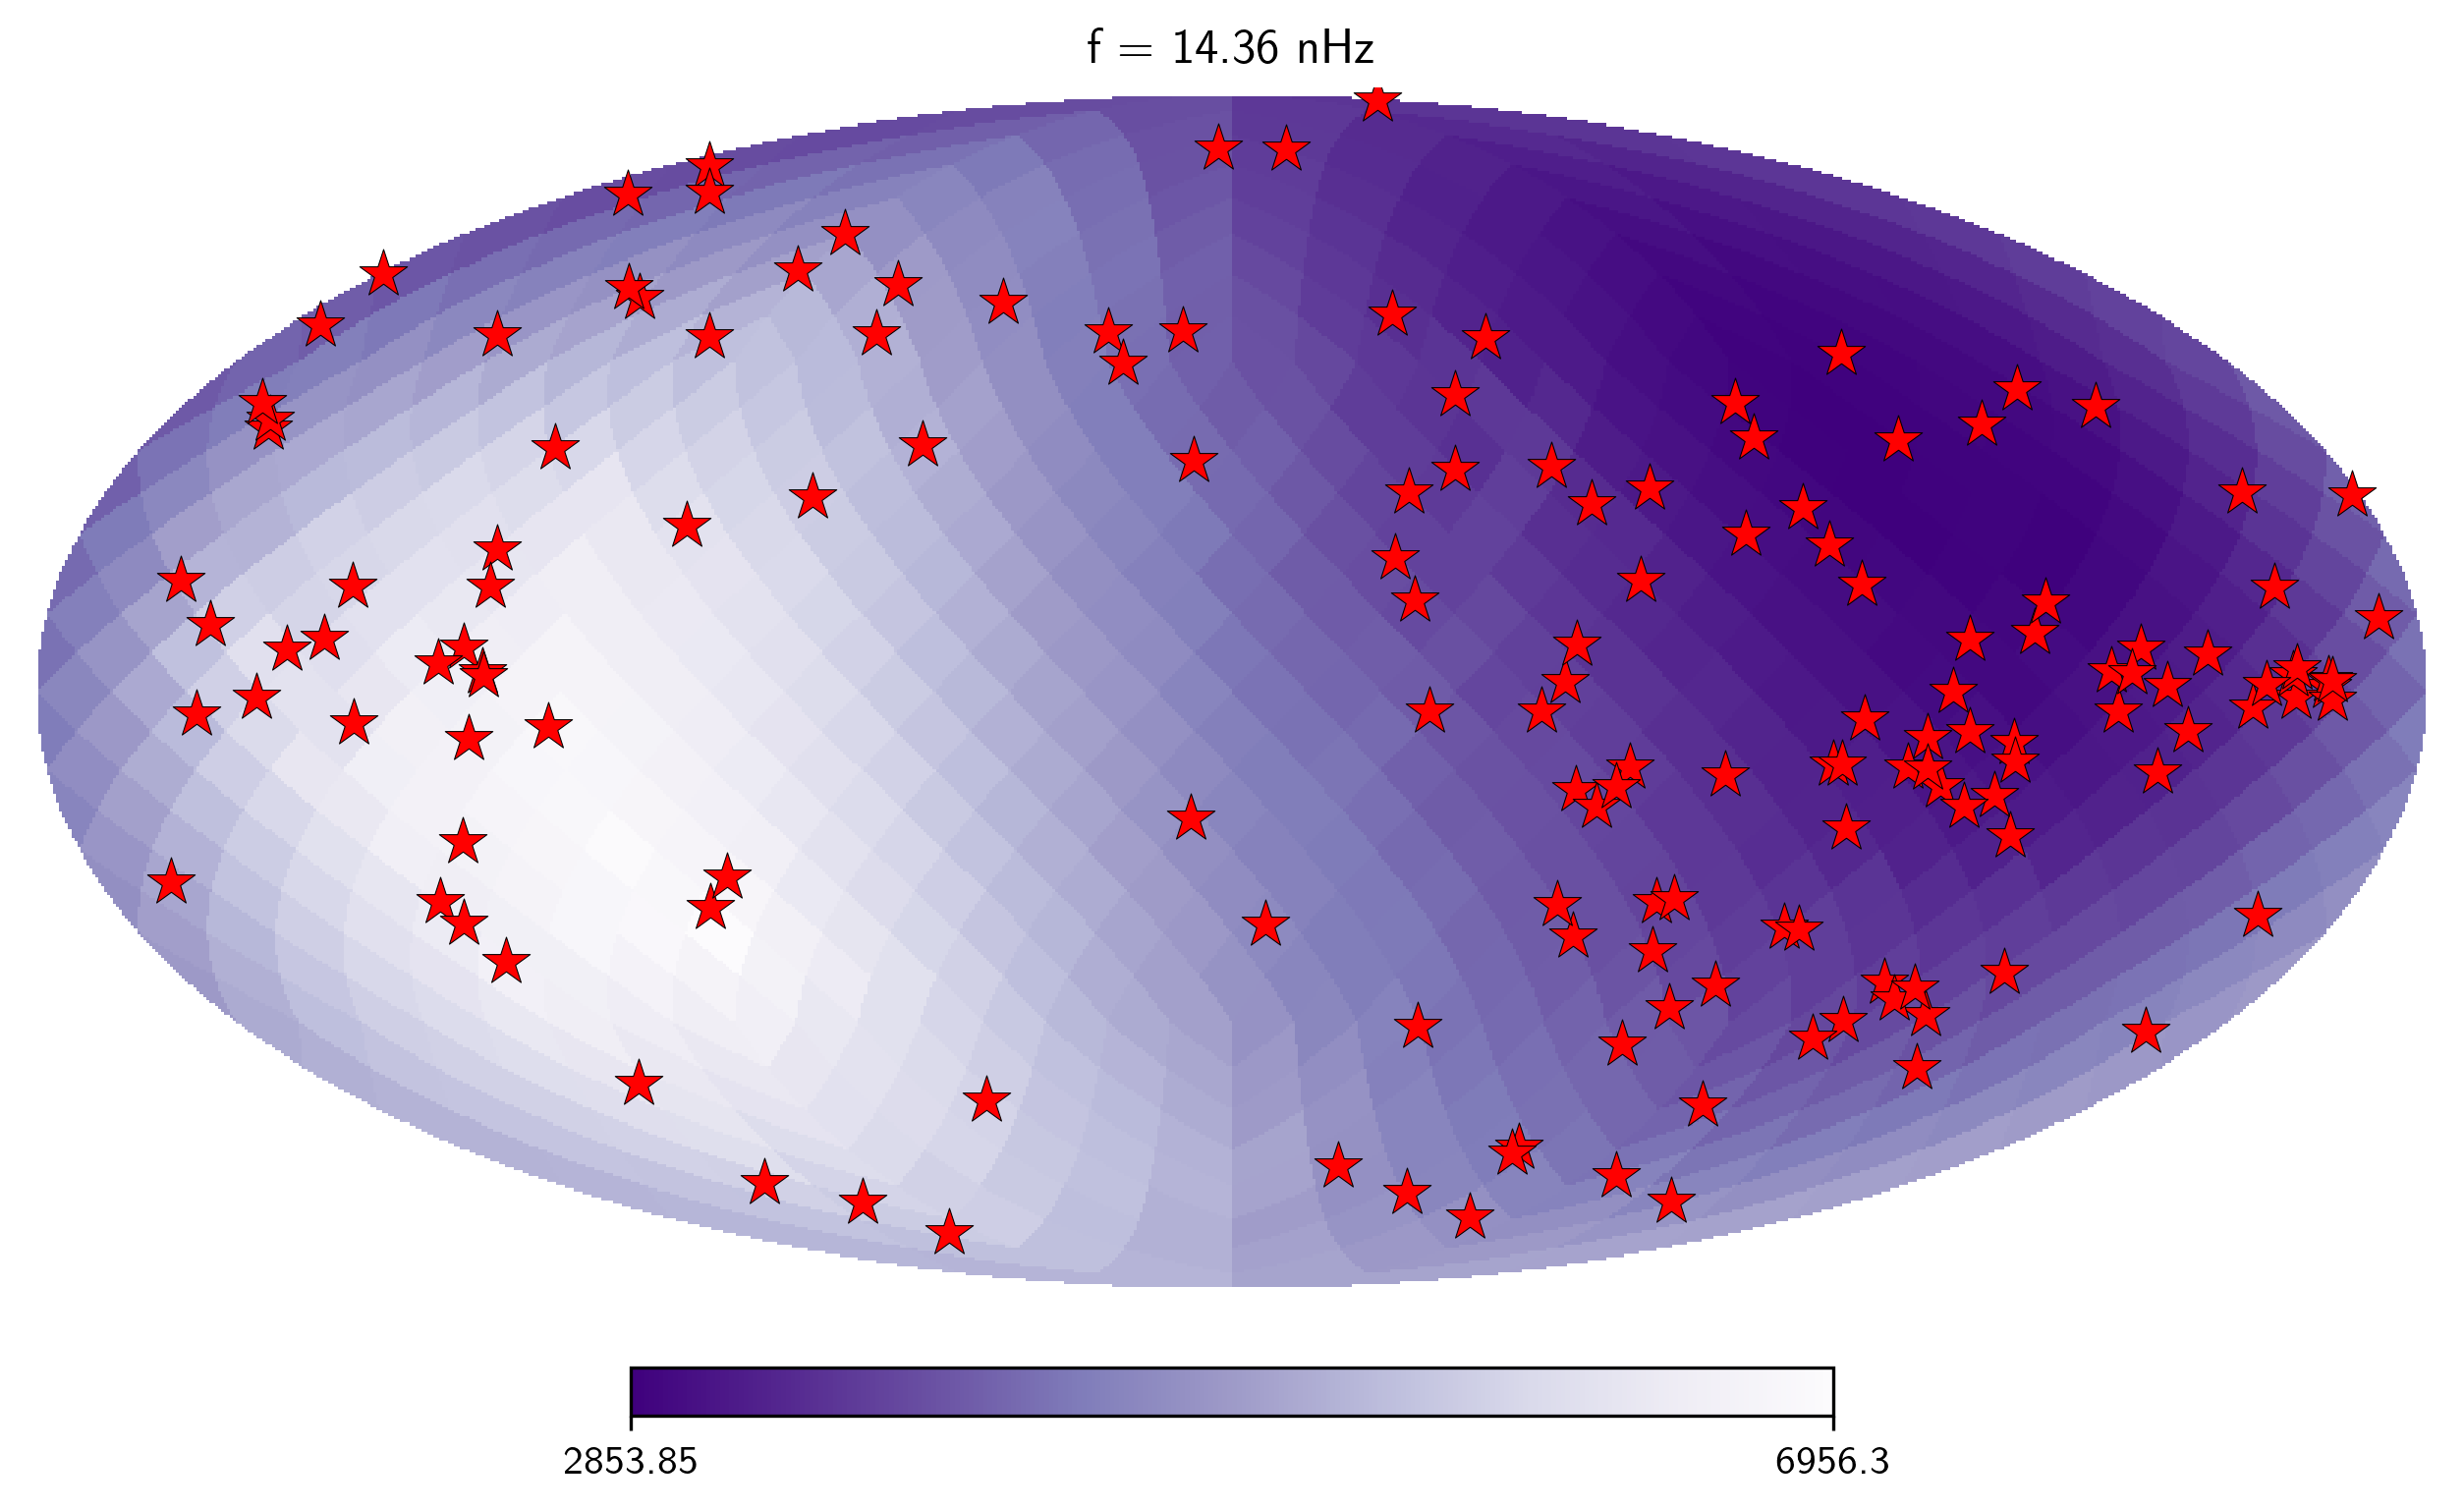

In [53]:
final_freqs = [max_freq, min_freq, median_freq]
final_freqs_idx = [max_index, min_index, median_index]

for freq, idx in zip(final_freqs, final_freqs_idx):
    # Compute the map at this frequency
    M_kk_pixel = np.sqrt(ASM.M_kk[:, idx])/Tspan
    
    # Plot the map
    hp.mollview(M_kk_pixel, title=f"f = {freq * 1e9:.2f} nHz", cmap='Purples_r', rot=(180,0,0))

    # Overlay pulsar positions
    hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
                            edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))
    
    plt.show()


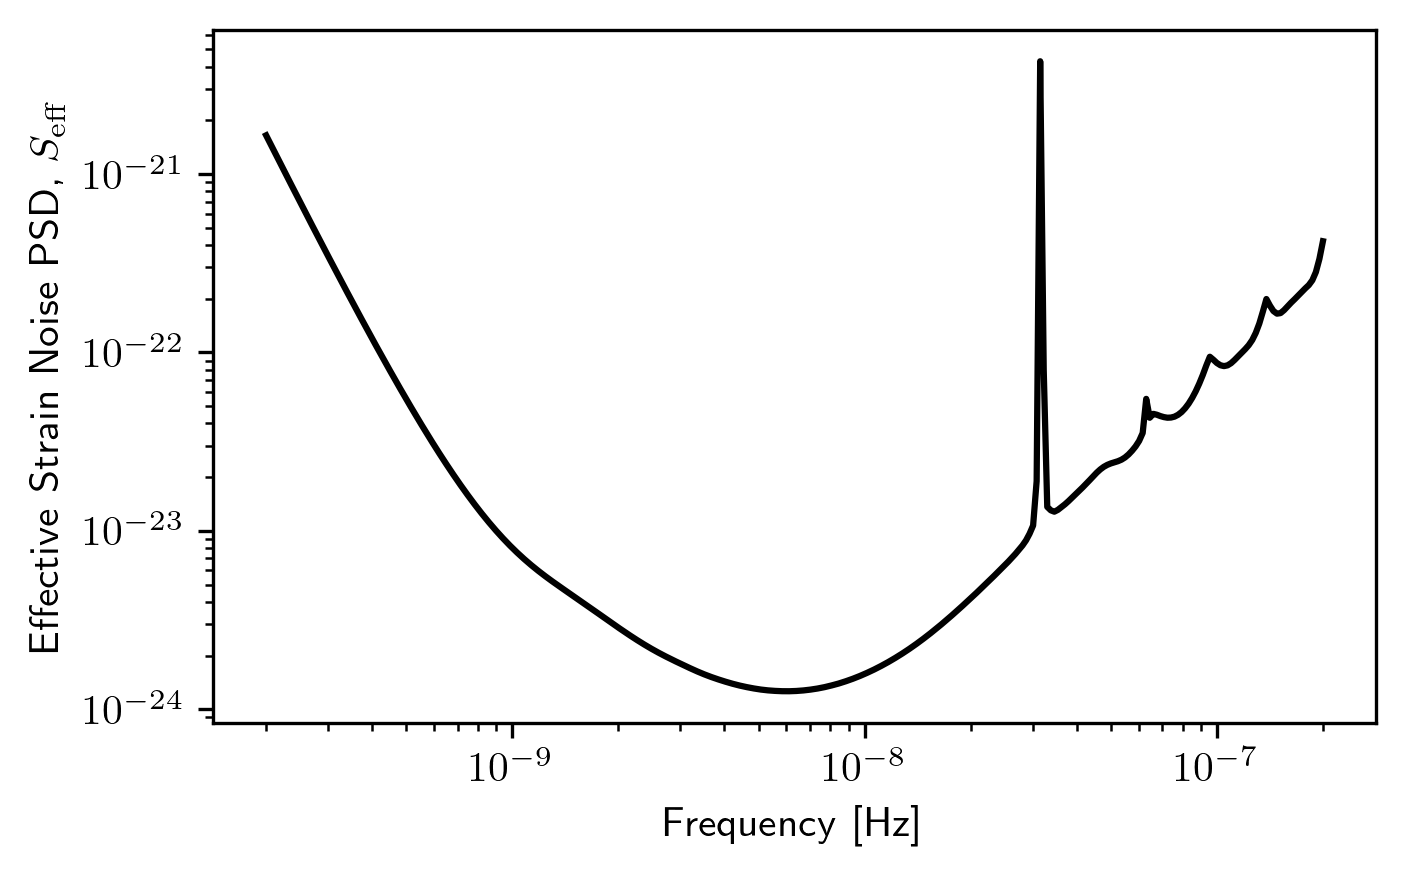

In [54]:
plt.loglog(freqs,ASM.S_eff_aniso, color='black', label='40yr PTA (Simulated)')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
plt.show()

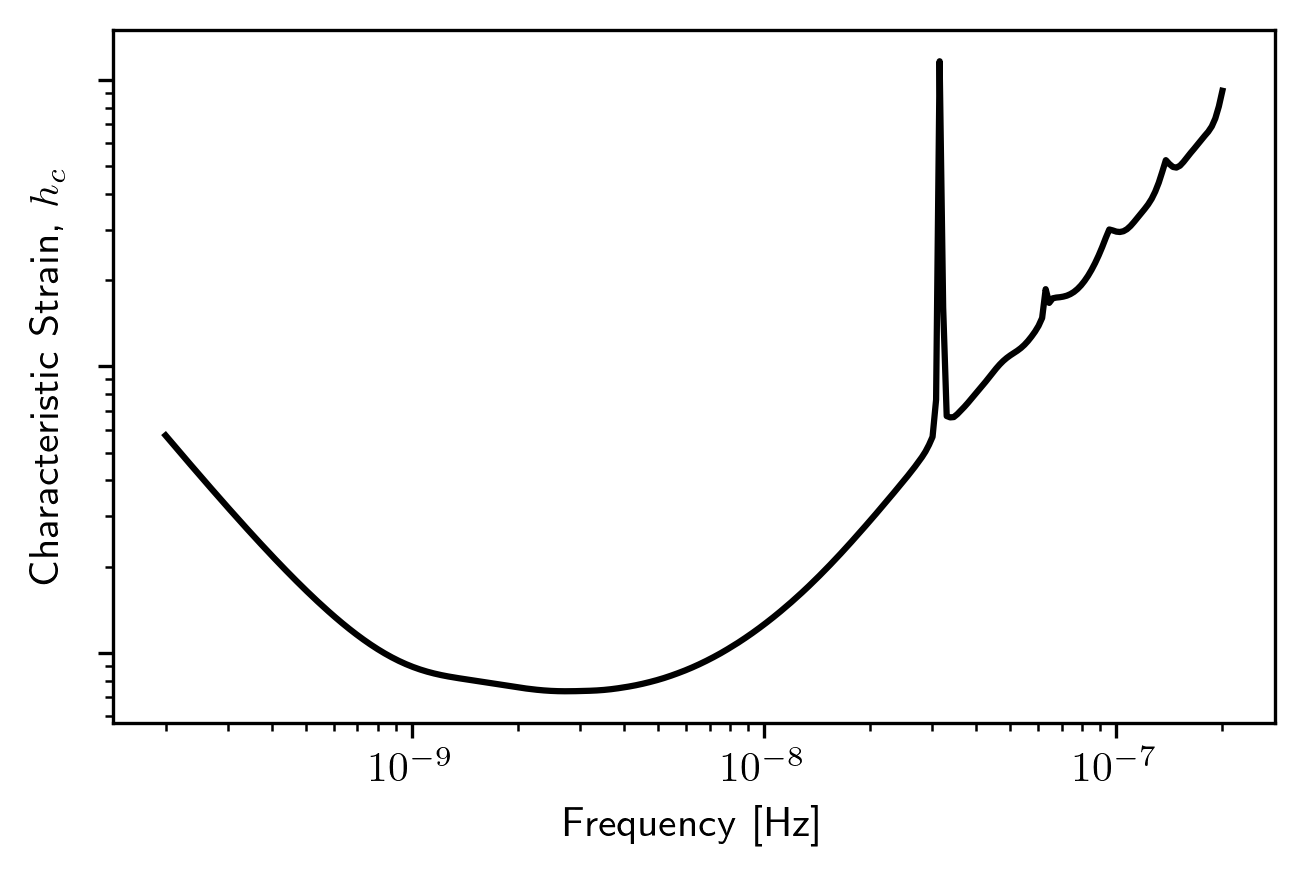

In [65]:
plt.loglog(freqs,ASM.h_c_aniso, color='black', label='40yr PTA (Simulated)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.gca().set_yticklabels([])
plt.show()

In [56]:
sc1a = hsen.GWBSensitivityCurve(spectra)

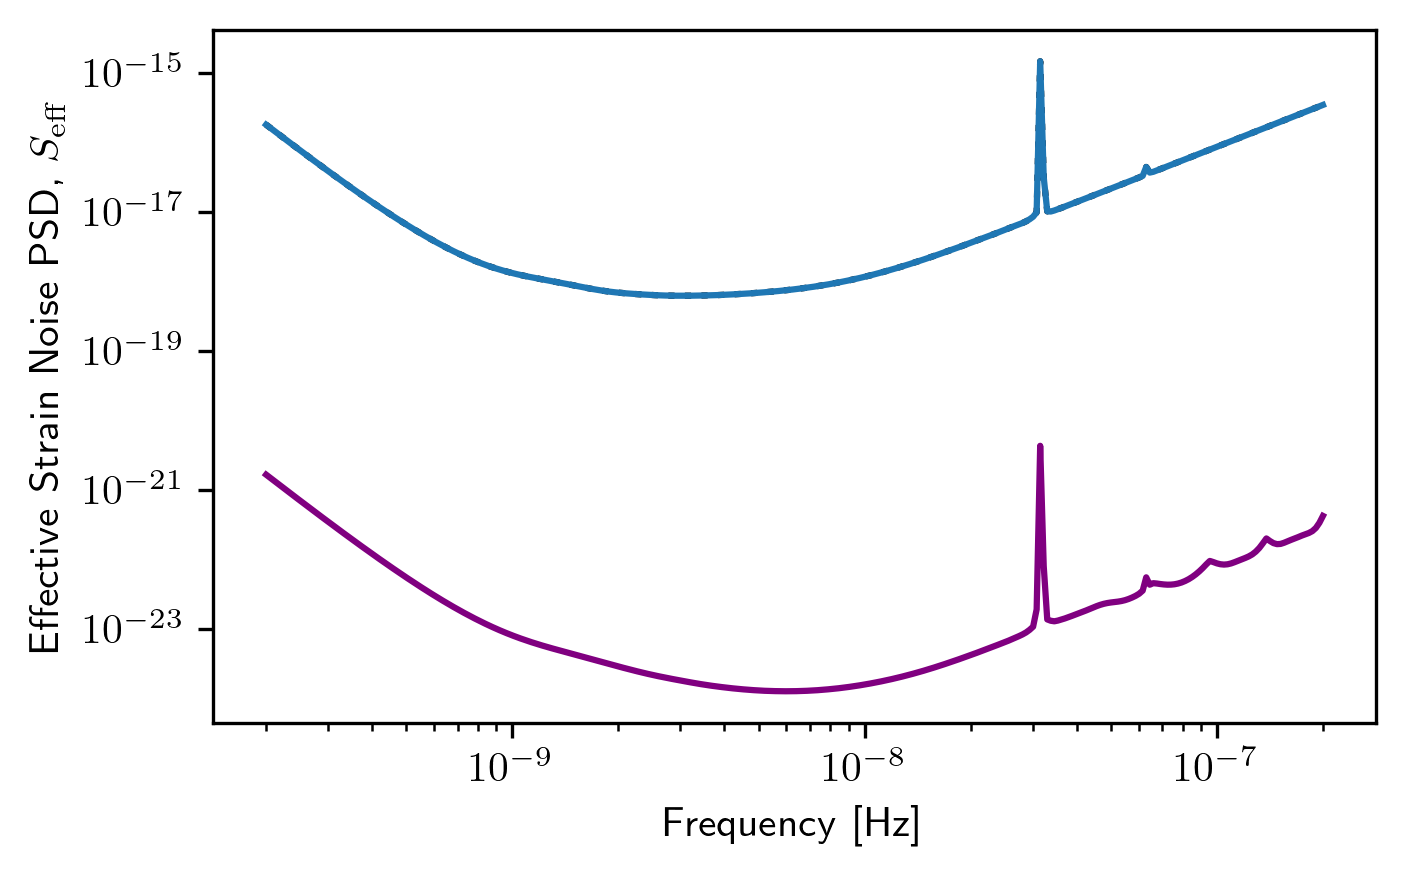

In [57]:
plt.loglog(freqs,ASM.S_effIJ[1], color='black', linestyle=':', label='40yr PTA (Simulated)')
plt.loglog(sc1a.freqs,sc1a.S_effIJ[1],label='GWBSensitivityCurve')
plt.loglog(freqs,ASM.S_eff_aniso, color='purple', label='40yr PTA (Simulated) aniso')
plt.xlabel('Frequency [Hz]')
plt.ylabel(r'Effective Strain Noise PSD, $S_{\rm eff}$')
# plt.legend()
plt.show()

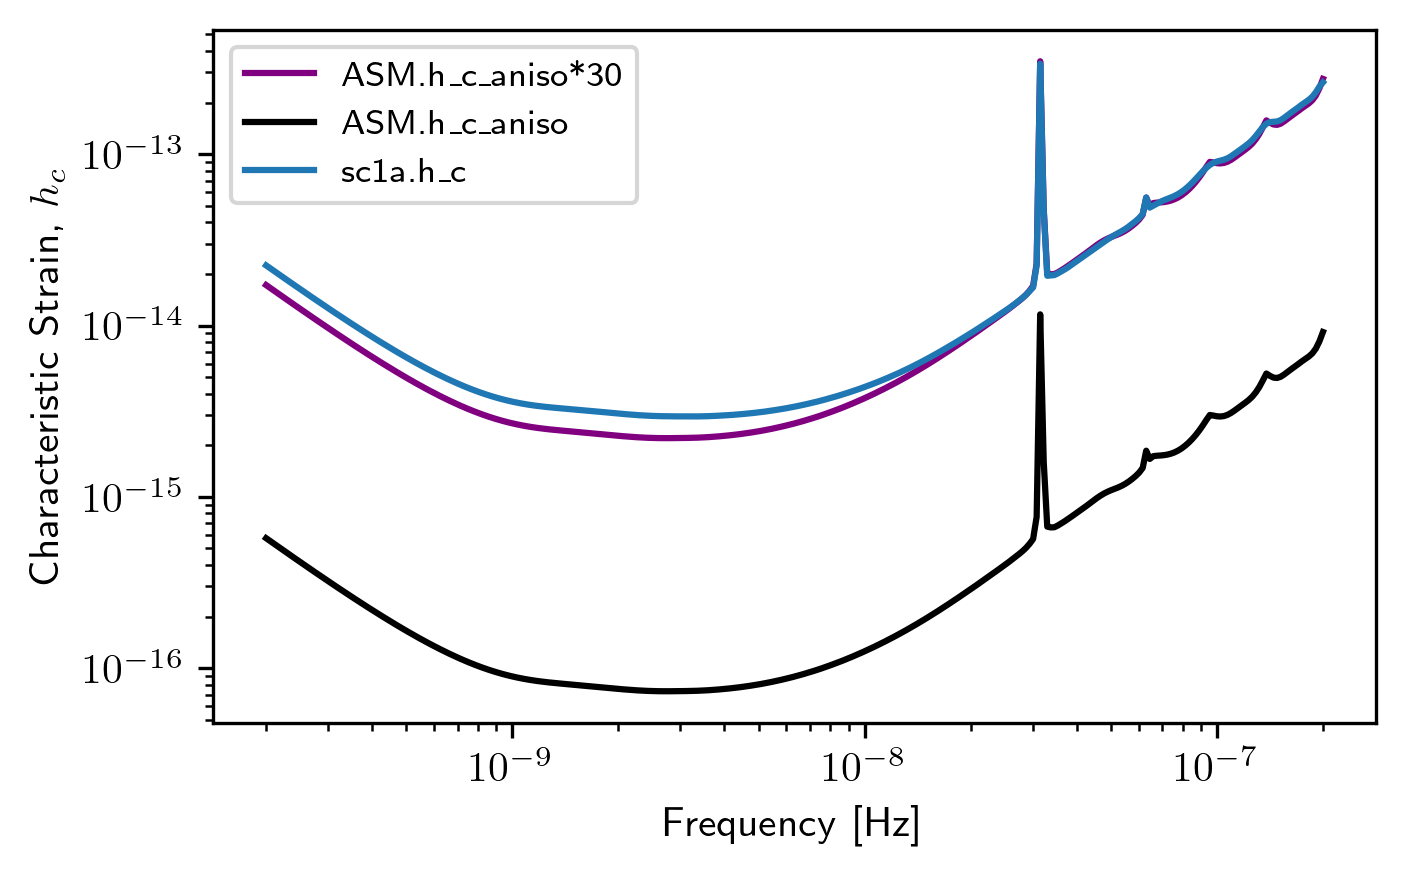

In [ ]:
# plt.loglog(freqs,np.sqrt(freqs*ASM.S_eff_aniso), color='black', label='np.sqrt(freqs*ASM.S_eff_aniso)')
plt.loglog(freqs,ASM.h_c_aniso*30, color='purple', label='ASM.h_c_aniso*30')
plt.loglog(freqs,ASM.h_c_aniso, color='black', label='ASM.h_c_aniso')
plt.loglog(freqs,sc1a.h_c, label='sc1a.h_c')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.legend(fontsize='small')
plt.show()

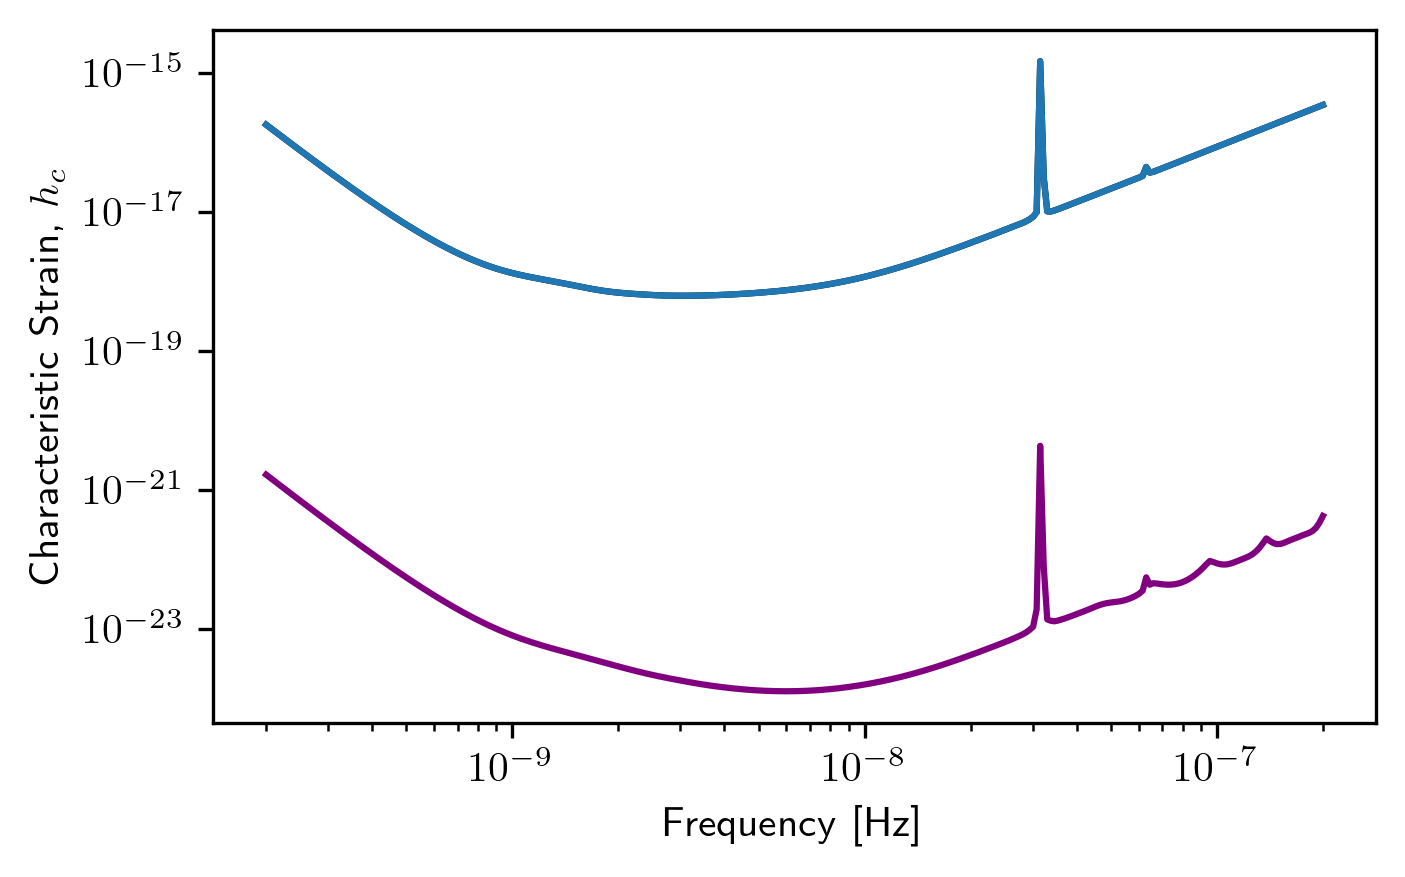

In [59]:
plt.loglog(freqs,ASM.S_effIJ[1], color='black', label='40yr PTA (Simulated)')
plt.loglog(freqs,ASM.S_eff_aniso, color='purple', label='40yr PTA (Simulated) aniso')
plt.loglog(sc1a.freqs,sc1a.S_effIJ[1], label='GWBSensitivityCurve')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

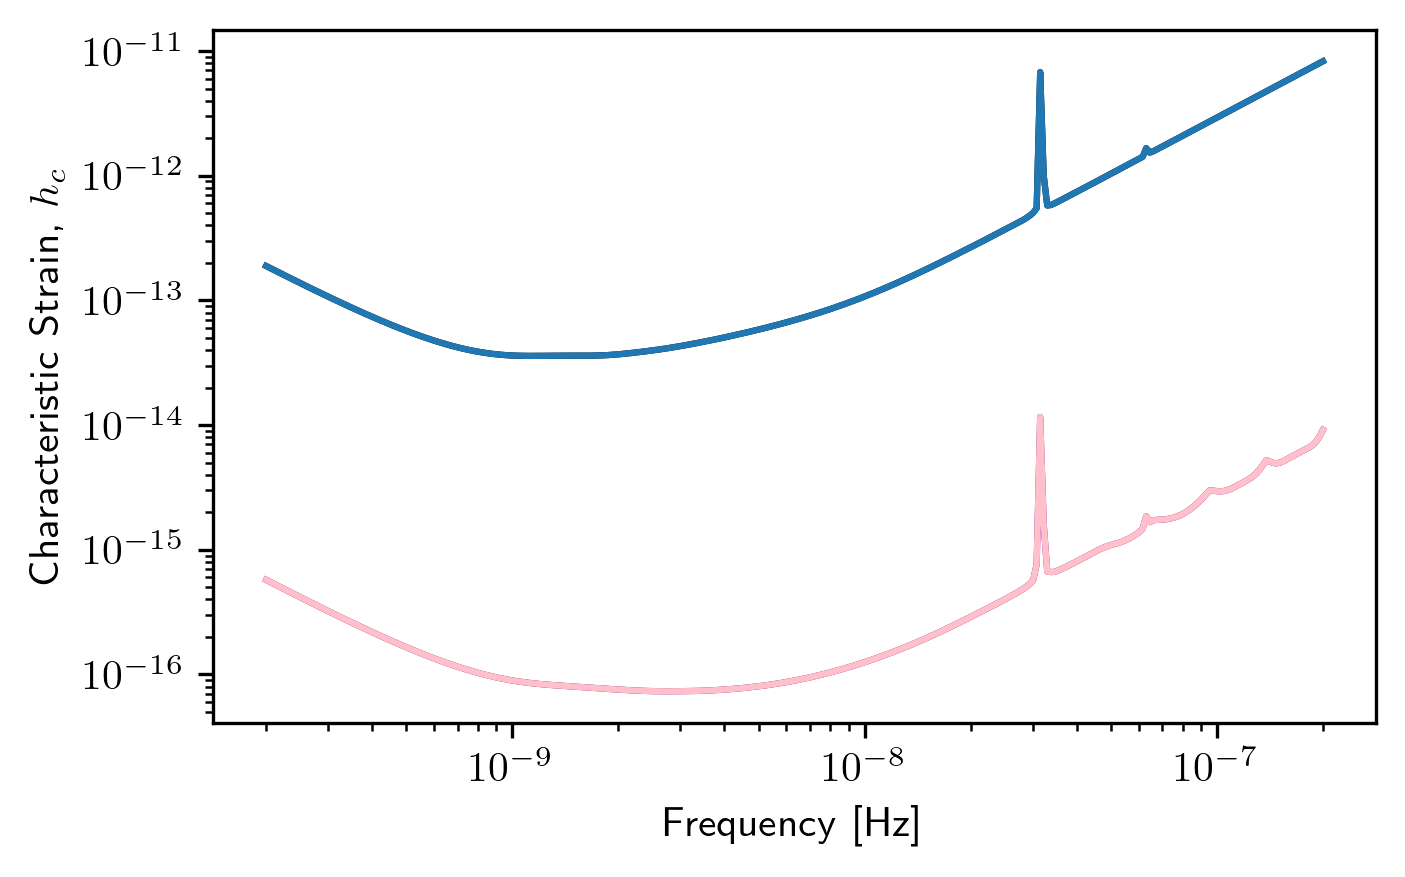

In [60]:
plt.loglog(freqs,np.sqrt(freqs*ASM.S_effIJ[1]), color='black', label='40yr PTA (Simulated)')
plt.loglog(freqs,np.sqrt(freqs*ASM.S_eff_aniso), color='purple', label='40yr PTA (Simulated) aniso')
plt.loglog(freqs,ASM.h_c_aniso, color='pink', label='40yr PTA (Simulated) aniso')
plt.loglog(sc1a.freqs,np.sqrt(sc1a.freqs*sc1a.S_effIJ[1]), label='GWBSensitivityCurve')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.show()

In [61]:
# # Placeholder for computed values
# averages = []

# # Iterate over frequency indices
# for freq_idx in range(len(freqs)):  # Use range(len(freqs)) to iterate properly
#     sqrt_values = np.sqrt(ASM.M_kk[:, freq_idx])  
#     avg_value = np.mean(sqrt_values)  # Compute average
#     averages.append(avg_value)  # Append to list

# # Compute statistics for frequencies
# max_freq_idx = np.argmax(averages)  # Index of the max average value
# min_freq_idx = np.argmin(averages)  # Index of the min average value
# avg_freq_idx = np.argmin(np.abs(averages - np.mean(averages)))  # Closest to mean

# max_freq = freqs[max_freq_idx]
# min_freq = freqs[min_freq_idx]
# avg_freq = freqs[avg_freq_idx]
# # Plot for max frequency
# max_mkk = np.sqrt(ASM.M_kk[:, max_freq_idx])


# vmin, vmax = np.min(max_mkk), np.max(max_mkk)
# hp.mollview(max_mkk, title=f"Max f = {max_freq * 1e9:.2f} nHz", 
#             min=0, max=1, cmap='Purples_r', hold=False, rot=(180,0,0))  # Consistent scale & better contrast

# # Highlight all pulsar positions

# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.savefig(savedir+'mkk_max_forecast.png')

# plt.show()

# # Plot for min frequency
# min_mkk = np.sqrt(ASM.M_kk[:, min_freq_idx])


# vmin, vmax = np.min(min_mkk), np.max(min_mkk)
# hp.mollview(min_mkk, title=f"Min f = {min_freq * 1e9:.2f} nHz", 
#             min=0, max=1, cmap='Purples_r', hold=False, rot=(180,0,0))  # Consistent scale & better contrast

# # Highlight all pulsar positions

# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.savefig(savedir+'mkk_min_forecast.png')

# plt.show()

# # Plot for average frequency
# avg_mkk = np.sqrt(ASM.M_kk[:, avg_freq_idx])

# vmin, vmax = np.min(avg_mkk), np.max(avg_mkk)
# hp.mollview(avg_mkk, title=f"Avg f = {avg_freq * 1e9:.2f} nHz", 
#             min=0, max=1, cmap='Purples_r', hold=False, rot=(180,0,0))  # Consistent scale & better contrast

# # Highlight all pulsar positions

# hp.visufunc.projscatter(ASM.thetas, ASM.phis, marker='*', color='red', 
#                         edgecolors='black', linewidths=0.25, s=150, alpha=1, rot=(180,0,0))  # Transparency for clarity

# plt.savefig(savedir+'mkk_avg_forecast.png')

# plt.show()